

<br>
<br>


<h1><center> SFS </center></h1>


<br>
<br>


#### Signal Formation Simulation
The idea is to develop a lightweight and easy-to-use tool for the top-down how affects the performance of the next-generation dark matter detector.
The code is based on the Noble Element Simulation Technique (NEST).


<br>
<br>


#### This Notebook
This is the notebook that was used to actually conduct the study.
It is supposed to further serve as documentation of the ''sfs.py'' library. Feel free to copy the exemplary function calls below into your personal study project.


<br>
<br>


#### Contents


1. **[Setup](#Setup)**
2. **[Imports and Definitions](#Imports-and-Definitions)**
3. **[Detector Definition](#Detector-Definition)**
4. **[Spectra Definition](#Spectra-Definition)**
5. **[Executing NEST](#Executing-NEST)**
6. **[ER/NR Discrimination](#ER/NR-Discrimination)**
7. **[Maximum Likelihood Sensitivity Estimation](#Maximum-Likelihood-Sensitivity-Estimation)**


<br>
<br>


#### Credits
- NEST collaboration
- C. Hock


<br>
<br>



<br>
<br>


# Setup


<br>
<br>


- install NEST following their official documentation


- Store the absolute path of the NEST installation, i.e., the directory containing the `nest`, `install`, and `build` directories, in an environmental variable. Therefore execute:<br> `$ echo 'export ABSPATH_NEST_INSTALLATION="/abspath/to/your/nest/root/directory/" >> ~/.bashrc'`


- git clone the ''sfsv2'' repository


- edit the ''sfs.py'' file


<br>
<br>



<br>
<br>


# Imports and Definitions


<br>
<br>


#### paths

In [1]:


# path definitions
abspath_sfs_repo = "/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/"
abspath_study = abspath_sfs_repo # you'll probably have different paths for 'abspath_sfs_repo' and 'abspath_study'
abspath_detectors = abspath_study +"detectors/"
abspath_spectra = abspath_study +"spectra/"
abspath_resources = abspath_study +"resources/"
abspath_list_plots = [abspath_study +"plots/", "/home/daniel/Desktop/arbeitsstuff/thesis/images/sfs/"]
abspath_signatures = abspath_study +"signatures/"
abspath_discrimination_lines = abspath_study +"discrimination_lines/"
abspath_test = abspath_study +"test/"
abspath_er_leakage_study = abspath_study +"20230519__er_leakage_study/"


#### imports

In [2]:

# imports <---- check which one of those are actually needed
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
import time
from datetime import timedelta
import datetime
import matplotlib.gridspec as gridspec



# importing my personal matplotlib style file
import matplotlib as mpl
plt.style.use("file:///home/daniel/Desktop/arbeitsstuff/monxe/software/miscfig/danielsmplstyle.mplstyle")


# importing the sfs library
import sys
sys.path.append(abspath_sfs_repo)
import sfs


#### study assumptions

In [3]:


# default study parameters
default_wimp_eroi_kev_ee = [1.4, 11.6] # WIMP energy region of interest in keV_ee
default_wimp_eroi_kev_nr = [sfs.convert_recoil_energy_scale(default_wimp_eroi_kev_ee[0], "ER"), sfs.convert_recoil_energy_scale(default_wimp_eroi_kev_ee[1], "ER")] # WIMP energy region of interest in keV_nr
print(f"WIMP EROI: [{default_wimp_eroi_kev_ee[0]:.1f},{default_wimp_eroi_kev_ee[1]:.1f}] keV_ER")
print(f"WIMP EROI: [{default_wimp_eroi_kev_nr[0]:.1f},{default_wimp_eroi_kev_nr[1]:.1f}] keV_NR")
default_wimp_mass_gev = 100 # WIMP mass in GeV
default_wimp_nucleon_cross_section_cm2 = 5e-49 # WIMP-nucleon cross-section in cm^2


# default study settings
default_number_of_medium_stat_simulations = 5*10**5 # number of events simulated in medium statistics simulations
default_number_of_high_stat_simulations = 5*10**6 # number of events simulated in high statistics simulations
default_simulation_energy_bins = 50 # number of energy bins used for the spectra simulation
default_recoil_energy_simulation_window_er = [0.8*default_wimp_eroi_kev_ee[0], default_wimp_eroi_kev_ee[1]*1.5] # energy simulation window for ER signatures (due to leakage one needs to simulate events from outside the EROI)
default_recoil_energy_simulation_window_nr = [0.8*default_wimp_eroi_kev_nr[0], default_wimp_eroi_kev_nr[1]*1.5] # energy simulation window for ER signatures (due to leakage one needs to simulate events from outside the EROI)
print(f"simulation EROI: [{default_recoil_energy_simulation_window_er[0]:.1f},{default_recoil_energy_simulation_window_er[1]:.1f}] keV_ER")
print(f"simulation EROI: [{default_recoil_energy_simulation_window_nr[0]:.1f},{default_recoil_energy_simulation_window_nr[1]:.1f}] keV_NR")
default_number_of_discrimination_line_energy_bins = 50 # number of energy bins into which the WIMP EROI is subdivided for the computation of the ER rejection
default_nr_acceptance = 0.50 # acceptance of the (not in percent) of the nuclear recoils on which the NR computation is based
default_seed_for_baseline_assessment = 2615 # 2614


# default detector parameters
default_param_range_eLife_us = [800, 19200] # in us, baseline value: 10000 us
default_param_range_e_drift = [80, 320] # in V/cm, baseline value: 200 V/cm
default_param_range_g1 = [0.080, 0.170] # in phd/photon, baseline value: 0.125
default_param_range_E_gas = [6.0, 10.0] # in kV/cm, baseline value: 8 kV/cm
default_param_eLife_us = 10000
default_param_e_drift = 200
default_param_g1 = 0.125
default_param_E_gas = 8


WIMP EROI: [1.4,11.6] keV_ER
WIMP EROI: [7.3,54.9] keV_NR
simulation EROI: [1.1,17.4] keV_ER
simulation EROI: [5.9,82.3] keV_NR



<br>
<br>


# DARWIN Baseline Detector Definition


<br>
<br>


In [4]:


# defining the 'detector_dict'
darwin_baseline_detector_dict = {
    # primary scintillation (S1) parameters
    "g1"                : default_param_g1,         # phd per S1 phot at dtCntr (not phe), divide out 2-PE effect,                          JN: 0.119, LUX_Run03: 0.1170 (0.117+/-0.003 WS,0.115+/-0.005 D-D,0.115+/-0.005 CH3T,0.119+/-0.001 LUXSim), XENON10: 0.073
    "sPEres"            : 0.35,                     # single phe (=PE=photoelectrons) resolution (Gaussian assumed),                        JN: 0.38, LUX_Run03: 0.37 (arXiv:1910.04211.), XENON10: 0.58
    "sPEthr"            : 0.35,                     # POD threshold in phe, usually used IN PLACE of sPEeff,                                JN: 0.35, LUX_Run03: (0.3 * 1.173) / 0.915 (arXiv:1910.04211.), XENON10: 0.35
    "sPEeff"            : 1.0,                      # actual efficiency, can be used in lieu of POD threshold, units: fractional,           JN: 0.90, LUX_Run03: 1.00 (arXiv:1910.04211), XENON10: 1.00
    "noiseBaseline[0]"  : 0.0,                      # baseline noise mean in PE (Gaussian),                                                 JN: 0.0, LUX_Run03: 0.00 (arXiv:1910.04211 says -0.01), XENON10: 0.0
    "noiseBaseline[1]"  : 0.0,                      # baseline noise width in PE (Gaussian),                                                JN: 0.0, LUX_Run03: 0.08 (arXiv:1910.04211), XENON10: 0.0
    "noiseBaseline[2]"  : 0.0,                      # baseline noise mean in e- (for grid wires),                                           JN: none, LUX_Run03: 0.0, XENON10: 0.0
    "noiseBaseline[3]"  : 0.0,                      # baseline noise width in e- (for grid wires),                                          JN: none, LUX_Run03: 0.0, XENON10: 0.0
    "P_dphe"            : 0.2,                      # chance 1 photon makes 2 phe instead of 1 in Hamamatsu PMT, units: fractional,         JN: 0.22, LUX_Run03: 0.173 (arXiv:1910.04211), XENON10: 0.2
    "coinWind"          : 150,                      # S1 coincidence window in ns,                                                          JN: 100, LUX_Run03: 100 (1310.8214), XENON10: 100
    "coinLevel"         : 3,                        # how many PMTs have to fire for an S1 to count,                                        JN: 3, LUX_Run03: 2 (1512.03506), XENON10: 2
    "numPMTs"           : 494,                      # for coincidence calculation,                                                          JN: 494, LUX_Run03: 119 (122 minus 3 off), XENON10: 89
    "OldW13eV"          : "true",                   # default true, which means use "classic" W instead of Baudis / EXO's,                  JN: none, LUX_Run03: "true", XENON10: "true"
    "noiseLinear[0]"    : 0.0e-2,                   # S1->S1 Gaussian-smeared with noiseL[0]*S1, units: fraction NOT %!                     JN: none, LUX_Run03: 0.0e-2 (1910.04211 p.12, to match 1610.02076 Fig. 8.), XENON10: 3e-2
    "noiseLinear[1]"    : 0.0e-2,                   # S2->S2 Gaussian-smeared with noiseL[1]*S2, units: fraction NOT %!                     JN: none, LUX_Run03: 0.0e-2 (1910.04211 p.12, to match 1610.02076 Fig. 8.), XENON10: 3e-2
    # ionization and secondary scintillation (S2) parameters
    "g1_gas"            : 0.125,                    # phd per S2 photon in gas, used to get SE size, units: phd per e-,                     JN: 0.102, LUX_Run03: 0.1 (0.1 in 1910.04211), XENON10: 0.0655
    "s2Fano"            : 2.0,                      # Fano-like fudge factor for SE width, dimensionless,                                   JN: 3.61, LUX_Run03: 3.6 (3.7 in 1910.04211; this matches 1608.05381 better), XENON10: 3.61
    "s2_thr"            : 10.0,                     # the S2 threshold in phe or PE, *not* phd. Affects NR most,                            JN: 100.0, LUX_Run03: (150.0 * 1.173) / 0.915 (65-194 pe in 1608.05381), XENON10: 300.0
    "E_gas"             : default_param_E_gas,      # field in kV/cm between liquid/gas border and anode,                                   JN: 10.85, LUX_Run03: 6.25 (6.55 in 1910.04211), XENON10: 12.0
    "eLife_us"          : default_param_eLife_us,   # the drift electron mean lifetime in micro-seconds,                                    JN: 1600.0, LUX_Run03: 800.0 (p.44 of James Verbus PhD thesis Brown), XENON10: 2200.0
    # thermodynamic properties
#    "inGas"             : "false",                  # (duh),                                                                               JN: "false", LUX_Run03: commented out, XENON10: "false"
    "T_Kelvin"          : 175.0,                    # for liquid drift speed calculation, temperature in Kelvin,                            JN: 175.0, LUX_Run03: 173.0 (1910.04211), XENON10: 177.0
    "p_bar"             : 1.9,                      # gas pressure in units of bars, it controls S2 size,                                   JN: 2.0, LUX_Run03: 1.57 (1910.04211), XENON10: 2.14
    # data analysis parameters and geometry
    "dtCntr"            : 900.0,                    # center of detector for S1 corrections, in usec.,                                      JN: 822.0, LUX_Run03: 160.0 (p.61 Dobi thesis UMD, 159 in 1708.02566), XENON10: 40.0
    "dt_min"            : 100.0,                    # minimum. Top of detector fiducial volume, units: microseconds,                        JN: 75.8, LUX_Run03: 38.0 (1608.05381), XENON10: 20.0
    "dt_max"            : 1700.0,                   # maximum. Bottom of detector fiducial volume, units: microseconds,                     JN: 1536.5, LUX_Run03: 305.0 (1608.05381), XENON10: 60.0
    "radius"            : 1250.0,                   # millimeters (fiducial rad), units: millimeters,                                       JN: 1300., LUX_Run03: 200.0 (1512.03506), XENON10: 50.0
    "radmax"            : 1300.0,                   # actual physical geo. limit, units: millimeters,                                       JN: 1350., LUX_Run03: 235.0 (1910.04211), XENON10: 50.0
    "TopDrift"          : 2650.0,                   # top of drift volume in mm not cm or us, i.e., this *is* where dt=0, z=0mm is cathode,  JN: 3005.0, LUX_Run03: 544.95 (544.95 in 1910.04211), XENON10: 150.0
    "anode"             : 2657.0,                   # the level of the anode grid-wire plane in mm,                                         JN: 3012.5, LUX_Run03: 549.2 (1910.04211 and 549 in 1708.02566), XENON10: 152.5
    "gate"              : 2643.0,                   # mm. this is where the E-field changes (higher),                                       JN: 3000.0, LUX_Run03: 539.2 (1910.04211 and 539 in 1708.02566), XENON10: 147.5
    "cathode"           : 50.0,                     # mm. defines point below which events are gamma-X                                      JN: 250, LUX_Run03: 55.90 (55.9-56 in 1910.04211,1708.02566), XENON10: 1.00
    # 2D (xy) position reconstruction
    "PosResExp"         : 0.015,                    # exp increase in pos recon res at hi r, units: 1/mm,                                   JN: 0.015, LUX_Run03: 0.015 (arXiv:1710.02752 indirectly), XENON10: 0.015
    "PosResBase"        : 30.,                      # baseline unc in mm, see NEST.cpp for usage,                                           JN: 30.0, LUX_Run03: 70.8364 ((1710.02752 indirectly), XEONON10: 70.8364
}



# non-NEST detector parameters
darwin_baseline_detector_drift_field_v_cm = default_param_e_drift # drift field of the darwin baseline design in V/cm
darwin_baseline_detector_runtime_y = 5 # live time of the experiment in years
darwin_baseline_detector_fiducial_mass_t = 30 # fiducial volume of the detector in metric tonnes


# adjusting drift times according to detector dimension
darwin_baseline_detector_dict = sfs.adjust_detector_drift_time_parameters(darwin_baseline_detector_dict, darwin_baseline_detector_drift_field_v_cm)


# saving the 'detector_dict' of the darwin baseline detector
sfs.write_dict_to_json(abspath_detectors +"example__detector__darwin_baseline_detector.json", darwin_baseline_detector_dict)


# derived parameters
darwin_baseline_detector_g2 = sfs.compute_g2_from_detector_configuration(darwin_baseline_detector_dict)
print(f"g2: {darwin_baseline_detector_g2} phd per primary electron")
darwin_baseline_detector_drift_velocity_mm_usec = sfs.compute_drift_velocity_from_detector_configuration(darwin_baseline_detector_dict,darwin_baseline_detector_drift_field_v_cm)
print(f"drift velocity: {darwin_baseline_detector_drift_velocity_mm_usec} mm/usec")
darwin_baseline_detector_active_xenon_mass_t = sfs.calc_active_xenon_mass_of_detector_dict_t(darwin_baseline_detector_dict)
print(f"active xenon mass: {darwin_baseline_detector_active_xenon_mass_t} tonnes")
max_drift_time_usec = (darwin_baseline_detector_dict['TopDrift']-darwin_baseline_detector_dict['cathode'])/darwin_baseline_detector_drift_velocity_mm_usec
print(f"max drift time: {max_drift_time_usec} usec")
darwin_baseline_detector_fiducial_exposure_ty = darwin_baseline_detector_runtime_y*darwin_baseline_detector_fiducial_mass_t
print(f"fiducial exposure: {darwin_baseline_detector_fiducial_exposure_ty} ty")
darwin_baseline_detector_active_exposure_ty = darwin_baseline_detector_runtime_y*darwin_baseline_detector_active_xenon_mass_t
print(f"active exposure: {darwin_baseline_detector_active_exposure_ty} ty")



g2: 45.403972482531884 phd per primary electron
drift velocity: 1.5248620549967127 mm/usec
active xenon mass: 40.449157162641384 tonnes
max drift time: 1705.0722663602546 usec
fiducial exposure: 150 ty
active exposure: 202.2457858132069 ty



<br>
<br>


# Spectra Definition


<br>
<br>



#### plotting differential ER and NR backgrounds
WIMPs are computed with [Jelle Aalber's `wimprates` library](https://github.com/JelleAalbers/wimprates).

In [5]:


if [False,True][0]:


    #---------------------------------------
    # ER background
    #---------------------------------------


    if [False,True][1]:
        sfs.gen_spectrum_plot(
            spectra_list = ["er_pp", "er_be7" , "er_nunubetabeta", "combined_er_background", "er_rn222", "er_rn222_1ubqpkg"],
            abspath_spectra_files = abspath_resources,
            plot_x_axis_units = ["kev", "kev_nr", "kev_ee"][2],
            plot_log_y_axis = True,
            plot_log_x_axis = True,
            plot_xlim = [1,100],
            plot_ylim = [1e-1,1e+2],
            plot_legend = False,
            plot_legend_bbox_to_anchor = [0.15, 0.55, 0.25, 0.45],
            plot_legend_labelspacing = 0.5,
            plot_legend_fontsize = 6,
            flag_output_abspath_list = abspath_list_plots,
#            flag_output_abspath_list = [],
            flag_output_filename = "example__spectrum_plot__differential_combined_er_background.png",
            flag_shade_wimp_eroi = default_wimp_eroi_kev_ee,
            flag_verbose = True,
            flag_profile = ["", "er_bkg_thesis_plot", "nr_bkg_thesis_plot"][1], )


    #---------------------------------------
    # ER background + WIMPs
    #---------------------------------------


    if [False,True][0]:
        sfs.gen_spectrum_plot(
            #spectra_list = ["nr_wimps_nat_xe", "nr_wimps_wimprates", "nr_atm", "nr_b8", "nr_hep", "nr_dsnb", "nr_pp", "nr_pep", "nr_cno"],
            #spectra_list = ["nr_wimps_wimprates", "combined_nr_background", "nr_neutrons_34t", "nr_neutrons_28t", "nr_neutrons_20t", "nr_atm", "nr_b8", "nr_hep", "nr_dsnb", "nr_pp", "nr_pep", "nr_cno"],
            spectra_list = ["nr_wimps_wimprates", "combined_nr_background", "nr_neutrons_new_baseline", "nr_neutrons_new_improved_ptfe_and_pmts_and_cryo", "nr_atm", "nr_b8", "nr_hep", "nr_dsnb"],
            abspath_spectra_files = abspath_resources,
            differential_rate_parameters = {
                "mw" : default_wimp_mass_gev,
                "sigma_nucleon" : default_wimp_nucleon_cross_section_cm2,
            },
            plot_x_axis_units = ["kev", "kev_nr", "kev_ee"][1],
            plot_log_y_axis = True,
            plot_log_x_axis = True,
            plot_xlim = [2,100],
        #        plot_ylim = [3e-5,2e-1],
            plot_ylim = [1e-4,1e-2],
            plot_legend = False,
            plot_legend_bbox_to_anchor = [0.60, 0.35, 0.38, 0.73],
            plot_legend_labelspacing = 0.5,
            plot_legend_fontsize = 6,
            flag_output_abspath_list = abspath_list_plots,
        #        flag_output_abspath_list = [],
            flag_shade_wimp_eroi = default_wimp_eroi_kev_nr,
            flag_output_filename = "example__spectrum_plot__differential_combined_nr_background_wimps.pdf",
            flag_verbose = True,
            flag_profile = ["", "er_bkg_thesis_plot", "nr_bkg_thesis_plot"][2], )



#### generating histogrammed ER, NR, and WIMP spectra

In [6]:


if [False,True][0]:


    #---------------------------------------
    # custom spectrum
    #---------------------------------------


    if [False,True][0]:
        custom_spectrum_dict = {
            "seed": "1",
            "field_drift[V/cm]": str(darwin_baseline_detector_drift_field_v_cm),
            "x,y,z-position[mm]": "-1",
            "numEvts": [
                10000,
                10000,
                10000,
                10000,
                10000,
            ],
            "type_interaction": "ER",
            "E_min[keV]": [
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.00),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.25),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.50),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.75),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 1.00),
            ],
            "E_max[keV]": [
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.00),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.25),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.50),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 0.75),
                sfs.get_absolute_parameter_value(default_wimp_eroi_kev_ee, 1.00),
            ],
            # NOTE: All of the key-value pairs below are part of the 'give_spectrum_dict' functionality.
            # NOTE: They are not required to just run NEST via the 'execNEST' function in SFS, as shown in the cell below.
            # NOTE: The above parameters are those that are being passed to the 'execNEST' binary.
            #"latex_label": "\\textbf{combined ER background (goal)}",
            #"color": "#C1002A",
            #"linestyle": "-",
            #"linewidth": 2,
            #"zorder": 2,
            #"differential_rate_computation": "spectrum_sum",
            #"constituent_spectra_list": [],
            #"recoil_energy_kev_list": [],
            #"exposure_t_y": 150,
            #"num_events": "exposure_poisson",
            #"flag_verbose": false,
            #"flag_spectrum_type": "integral",
            #"differential_rate_parameters": {},
        }
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__custom_spectrum_dict.json", custom_spectrum_dict)


    #---------------------------------------
    # ER background
    #---------------------------------------


    if [False,True][0]:
        er_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_er_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_er, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = "exposure_poisson",
            # nest parameters
            seed = default_seed_for_baseline_assessment,
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,
            # keywords
            spectrum_dict_default_values = sfs.spectrum_dict_default_dict, # default 'spectrum_dict' values
            #**kwargs, # additional keyword argument values overwriting those from 'spectrum_dict_default_values'
        )
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_er_background.json", er_background_spectrum_dict)


    # generating the ER background spectrum dict with medium statistics
    if [False,True][0]:
        medium_statistics_er_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_er_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_er, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = default_number_of_medium_stat_simulations,
            # nest parameters
            seed = randrange(10000001),
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,)
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json", medium_statistics_er_background_spectrum_dict)


    # generating the ER background spectrum dict with high statistics
    if [False,True][0]:
        high_statistics_er_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_er_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_er, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = default_number_of_high_stat_simulations,
            # nest parameters
            seed = randrange(10000001),
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,)
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_er_background_high_stat.json", high_statistics_er_background_spectrum_dict)


    #---------------------------------------
    # NR background
    #---------------------------------------


    # generating the NR background spectrum dict
    if [False,True][0]:
        nr_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_nr_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_nr, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = "exposure_poisson",
            # nest parameters
            seed = default_seed_for_baseline_assessment,
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,
            # keywords
            spectrum_dict_default_values = sfs.spectrum_dict_default_dict, # default 'spectrum_dict' values
            #**kwargs, # additional keyword argument values overwriting those from 'spectrum_dict_default_values'
        )
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_nr_background.json", nr_background_spectrum_dict)


    # generating the NR background spectrum dict with medium statistics
    if [False,True][0]:
        medium_statistics_nr_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_nr_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_nr, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = default_number_of_medium_stat_simulations,
            # nest parameters
            seed = randrange(10000001),
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,)
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json", medium_statistics_nr_background_spectrum_dict)


    # generating the NR background spectrum dict with high statistics
    if [False,True][0]:
        high_statistics_nr_background_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "combined_nr_background",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_nr, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = default_number_of_high_stat_simulations,
            # nest parameters
            seed = randrange(10000001),
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,)
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__combined_nr_background_high_stat.json", high_statistics_nr_background_spectrum_dict)


    #---------------------------------------
    # WIMPs
    #---------------------------------------


    # generating the WIMP spectrum dict
    if [False,True][0]:
        wimp_spectrum_dict = sfs.give_spectrum_dict(
            spectrum_name = "nr_wimps_wimprates",
            recoil_energy_kev_list = sfs.bin_centers_from_interval(default_recoil_energy_simulation_window_nr, default_simulation_energy_bins),
            # 
            abspath_spectra_files = abspath_resources,
            exposure_t_y = darwin_baseline_detector_fiducial_exposure_ty,
            num_events = "exposure_poisson",
            # nest parameters
            seed = default_seed_for_baseline_assessment,
            drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            xyz_pos_mm = "-1",
            # flags
            flag_spectrum_type = ["differential", "integral"][1],
            flag_verbose = False,
            # keywords
            spectrum_dict_default_values = sfs.spectrum_dict_default_dict, # default 'spectrum_dict' values
            differential_rate_parameters = {
                "mw" : default_wimp_mass_gev,
                "sigma_nucleon" : default_wimp_nucleon_cross_section_cm2,
            }
        )
        sfs.write_dict_to_json(abspath_spectra +"example__spectrum__wimps.json", wimp_spectrum_dict)



#### plotting the histogrammed ER, NR, and WIMP spectra

In [7]:


if [False,True][0]:


    # data retrieval
    er_background_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background.json")
    nr_background_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background.json")
    wimp_spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__wimps.json")


    # plotting the spectra the simulation is fed with (as would be expected in a realistic DARWIN detector)
    sfs.gen_spectrum_plot(
        spectra_list = [er_background_spectrum_dict, nr_background_spectrum_dict, wimp_spectrum_dict],
        abspath_spectra_files = abspath_resources,
        #spectra_list = [nr_test_spectrum_dict],
        # plot parameters
        plot_fontsize_axis_label = 11,
        plot_figure_size_x_inch = 5.670,
        plot_aspect_ratio = 9/16,
        plot_log_y_axis = True,
        plot_log_x_axis = False,
        plot_xlim = [0,default_recoil_energy_simulation_window_nr[1]*0.65],
        plot_ylim = [],
        plot_x_axis_units = ["kev", "kev_nr", "kev_ee"][0],
        plot_legend = True,
        plot_legend_bbox_to_anchor = [0.3, 0.5, 0.7, 0.5],
        plot_legend_labelspacing = 0.5,
        plot_legend_fontsize = 9,
        # flags
        flag_output_abspath_list = abspath_list_plots,
        flag_output_filename = "example__spectrum_plot__integral_combined_er_nr_spectra_wimps.png",
        flag_shade_wimp_eroi = [],
        flag_verbose = False,)




<br>
<br>


# Executing NEST


<br>
<br>


#### executing NEST to generate signature ndarrays

In [8]:


if [False,True][0]:


    #---------------------------------------
    # custom spectrum
    #---------------------------------------


    if [False,True][0]:
        custom_spectrum_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__custom_spectrum_dict.json"),
            baseline_detector_dict = darwin_baseline_detector_dict,
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            detector_dict = darwin_baseline_detector_dict, # the specified 'detector_dict' (overwriting 'baseline_detector_dict') will be installed
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
            flag_print_stdout_and_stderr = False,
            flag_detector_installation="do_not_install",)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__custom_spectrum.npy", custom_spectrum_ndarray)


    #---------------------------------------
    # ER background
    #---------------------------------------


    if [False,True][1]:
        er_background_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background.json"),
            baseline_detector_dict = darwin_baseline_detector_dict,
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            detector_dict = darwin_baseline_detector_dict, # the specified 'detector_dict' (overwriting 'baseline_detector_dict') will be installed
            #{ # one can specify only a few parameters that will be overwritten in 'baseline_detector_dict'
            #    "g1"       : 0.15,
            #},
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
            flag_random_shuffle_seed=True,
            flag_print_stdout_and_stderr = False,)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__er_background.npy", er_background_ndarray)


    if [False,True][0]:
        medium_statistics_er_background_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json"),
            baseline_detector_dict = darwin_baseline_detector_dict,
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            detector_dict = {},
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
            flag_print_stdout_and_stderr = False,)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__er_background_medium_stat.npy", medium_statistics_er_background_ndarray)


    if [False,True][0]:
        high_statistics_er_background_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_er_background_high_stat.json"),
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            baseline_detector_dict = darwin_baseline_detector_dict,
            detector_dict = {},
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
            flag_print_stdout_and_stderr = False,)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__er_background_high_stat.npy", high_statistics_er_background_ndarray)


    #---------------------------------------
    # NR background
    #---------------------------------------


    if [False,True][1]:
        nr_background_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background.json"),
            baseline_detector_dict = darwin_baseline_detector_dict,
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            detector_dict = {}, # an empty 'detector_dict' will use the installed detector
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
            flag_random_shuffle_seed=True,
            flag_print_stdout_and_stderr = False,)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background.npy", nr_background_ndarray)


    if [False,True][0]:
        medium_statistics_nr_background_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json"),
            baseline_detector_dict = darwin_baseline_detector_dict,
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            detector_dict = {}, # the specified 'detector_dict' (overwriting 'baseline_detector_dict') will be installed
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
            flag_print_stdout_and_stderr = False,)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background_medium_stat.npy", medium_statistics_nr_background_ndarray)


    if [False,True][0]:
        high_statistics_nr_background_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__combined_nr_background_high_stat.json"),
            baseline_detector_dict = darwin_baseline_detector_dict,
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            detector_dict = {}, # the specified 'detector_dict' (overwriting 'baseline_detector_dict') will be installed
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
           flag_print_stdout_and_stderr = False,)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background_high_stat.npy", high_statistics_nr_background_ndarray)


    #---------------------------------------
    # WIMPs
    #---------------------------------------


    if [False,True][1]:
        wimp_ndarray = sfs.execNEST(
            spectrum_dict = sfs.get_dict_from_json(abspath_spectra +"example__spectrum__wimps.json"),
            baseline_detector_dict = darwin_baseline_detector_dict,
            baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
            detector_dict = {},
            detector_name = "example__detector__darwin_baseline_detector",
            abspath_list_detector_dict_json_output = [abspath_detectors],
            flag_verbose = True,
            flag_random_shuffle_seed=True,
            flag_print_stdout_and_stderr = False,)
        np.save(abspath_signatures +"example__signature__darwin_baseline_detector__wimps.npy", wimp_ndarray)



#### computing ER/NR discrimination line

In [9]:


if [False,True][0]:


    # computing discrimination line
    discrimination_line_dict = sfs.calc_er_nr_discrimination_line(
        er_spectrum = np.load(abspath_signatures +"example__signature__darwin_baseline_detector__er_background_medium_stat.npy"),
        nr_spectrum = np.load(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background_medium_stat.npy"),
        detector_dict = darwin_baseline_detector_dict,
        min_energy = default_wimp_eroi_kev_ee[0],
        max_energy = default_wimp_eroi_kev_ee[1],
        bin_number = default_number_of_discrimination_line_energy_bins,
        nr_acceptance = default_nr_acceptance,
        approx_depth = 24,
        verbose =True,)
    sfs.write_dict_to_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json", discrimination_line_dict)



#### plotting event signatures

In [10]:


if [False,True][0]:


    sfs.gen_signature_plot(
        signature_dict_list = [
#            {
#                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_baseline_detector__custom_spectrum.npy"),
#                "label" : r"custom spectrum",
#                "alpha" : 0.5,
#                "s"     : 1,
#                "facecolors" : "green",
#            },
            {
                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_baseline_detector__er_background.npy"),
                "label" : r"combined ER background",
                "alpha" : 1.0,
                "s"     : 1.6,
                "facecolors" : sfs.color_ers_default,
            },
            {
                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background.npy"),
                "label" : r"combined NR background",
                "alpha" : 1.0,
                "s"     : 4,
                "facecolors" : sfs.color_nrs_default,
                "linewidths" : 0.25,
                "edgecolors" : "white",
            },
            {
                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_baseline_detector__wimps.npy"),
                "label" : r"WIMPs ($" +f"{default_wimp_mass_gev}" +r"\,\frac{\mathrm{GeV}}{c^2}$, $" +f"{str(default_wimp_nucleon_cross_section_cm2)[0]}" +r"\cdot 10^{" f"{str(default_wimp_nucleon_cross_section_cm2)[-3:]}" +r"}\,\mathrm{cm^2}$)",
                "alpha" : 1,
                "s"     : 4,
                "facecolors" : sfs.color_wimps_default,
                "linewidths" : 0.25,
                "edgecolors" : "white",
            },
        ],
        detector_dict = darwin_baseline_detector_dict,
        # plot parameters
        plot_fontsize_axis_label = 11,
        plot_figure_size_x_inch = 5.670,
        plot_aspect_ratio = 9/16,
        **[
            {
                "plot_log_y_axis" : True,
                "plot_log_x_axis" : False,
                "plot_xlim" : [0,110],
                "plot_ylim" : [1e2,2e4],
                "plot_axes_units" : ["cs2_vs_cs1", "cs2_over_cs1_vs_cs1_over_g1"][0],
            },
            {
                "plot_log_y_axis" : True,
                "plot_log_x_axis" : False,
                "plot_xlim" : [0,800],
                "plot_ylim" : [6e+1, 1e+3],
                "plot_axes_units" : ["cs2_vs_cs1", "cs2_over_cs1_vs_cs1_over_g1"][1],
            },
        ][1],
#        plot_text_dict_list = [
#            {
#                "s"     : r"combined ER background",
#                "x"     : 0.55,
#                "y"     : 0.75,
#                "color" : sfs.color_ers_default,
#            },
#            {
#                "s"     : r"combined NR background",
#                "x"     : 0.35,
#                "y"     : 0.25,
#                "color" : sfs.color_nrs_default,
#            },
#            {
#                "s"     : r"WIMPs ($" +f"{default_wimp_mass_gev}" +r"\,\frac{\mathrm{GeV}}{c^2}$, $" +f"{str(default_wimp_nucleon_cross_section_cm2)[0]}" +r"\cdot 10^{" f"{str(default_wimp_nucleon_cross_section_cm2)[-3:]}" +r"}\,\mathrm{cm^2}$)",
#                "x"     : 0.15,
#                "y"     : 0.35,
#                "color" : sfs.color_wimps_default,
#            },
#        ],
        plot_energy_contours = list(np.linspace(start=default_wimp_eroi_kev_ee[0], stop=default_wimp_eroi_kev_ee[1], num=5, endpoint=True)),
        plot_energy_contours_rotations = [-84, -77, -69, -63, -55],
        plot_energy_contours_pos_NR = [0.075, 0.260, 0.450, 0.635, 0.825],
        plot_energy_contours_pos_ER = [0.110, 0.295, 0.485, 0.675, 0.860],
        plot_discrimination_line_dict = sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json"), # generated above
        # flags
        flag_output_abspath_list = abspath_list_plots,
        flag_output_filename = "example__signature_plot__combined_er_nr_spectra_wimps.png",
        flag_profile = ["default"][0],
        flag_gray_out_events_outside_wimp_eroi = [True, False][0],
        flag_verbose = True,
        flag_re_plot_events_below_discrimination_line = {
            "s" : 12,
            "linewidths" : 0.25,
            "edgecolors" : "white",
            "zorder" : 20,
        },
        flag_histogram_nr_background = {
                "signature_ndarray" : np.load(abspath_signatures +"example__signature__darwin_baseline_detector__nr_background_medium_stat.npy"),
                "colorbar_label"    : r"NR background PDF",
                "n_bins_x"          : 100,
                "n_bins_y"          : 100,
                "cmap"              : "GnBu",
            },
        plot_legend = True,
    )





<br>
<br>


# Ph.D. Study: ER Leakage Fraction


<br>
<br>



### Leakage Fraction Scan for Default Parameters

#### data generation

In [60]:
# linspace, but with 'startpoint=False': np.linspace(380, 20, 30, endpoint=False)[::-1],      # [20, 380]
# print python print output to file: https://howtodoinjava.com/python-examples/python-print-to-file/

if [False,True][1]:


    # definitions
    dataset_name = "lf_scan_for_default_parameters"
    # first simulation run
    n_simulations = 10
    subdataset_dict = {
        "e_drift_scan" : {
            "e_drift" : list(np.linspace(num=n_simulations, start=default_param_range_e_drift[0], stop=default_param_range_e_drift[1], endpoint=True)),
        },
        "g1_scan" : {
            "g1" : list(np.linspace(num=n_simulations, start=default_param_range_g1[0], stop=default_param_range_g1[1], endpoint=True)),
        },
        "E_gas_scan" : {
            "E_gas" : list(np.linspace(num=n_simulations, start=default_param_range_E_gas[0], stop=default_param_range_E_gas[1], endpoint=True)),
        },
        "eLife_us_scan" : {
            "eLife_us" : list(np.linspace(num=n_simulations, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
        },
    }
    # second simulation run (to increase statistics of run 1)
    n_simulations = 4*(n_simulations-1)+1
    subdataset_dict = {
        "e_drift_scan" : {
            "e_drift" : [e for k,e in enumerate(list(np.linspace(num=n_simulations, start=default_param_range_e_drift[0], stop=default_param_range_e_drift[1], endpoint=True))) if k%4!=0],
        },
        "g1_scan" : {
            "g1" : [e for k,e in enumerate(list(np.linspace(num=n_simulations, start=default_param_range_g1[0], stop=default_param_range_g1[1], endpoint=True))) if k%4!=0],
        },
        "E_gas_scan" : {
            "E_gas" : [e for k,e in enumerate(list(np.linspace(num=n_simulations, start=default_param_range_E_gas[0], stop=default_param_range_E_gas[1], endpoint=True))) if k%4!=0],
        },
        "eLife_us_scan" : {
            "eLife_us" : [e for k,e in enumerate(list(np.linspace(num=n_simulations, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True))) if k%4!=0],
        },
    }
    # curiosity test: How does E_drift impact the leakage fraction beyond the assumed optimum?
    subdataset_dict = {
        "e_drift_scan" : {
            "e_drift" : [300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 3000, 4000, 5000, 7000, 9000, 11000],
        },
    }
    subdataset_dict = {
        "e_drift_scan" : {
            "e_drift" : [300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 3000, 4000, 5000, 7000, 9000, 11000],
            "eLife_us" : [500],
        },
    }


    # data generation
    for subdataset_name in [*subdataset_dict]:
        print(f"\n\n\n\n\n" +80*"#" +f"\nstarting subdataset '{subdataset_name}' simulation at {datetime.datetime.now()}\n" +80*"#" +f"\n\n")
        cartesian_product_of_leakage_fraction_checks = sfs.conduct_cartesian_product_of_leakage_fraction_checks(
            check_parameter_dict                           = subdataset_dict[subdataset_name],
            default_detector_parameter_dict                = darwin_baseline_detector_dict,
            default_detector_e_drift                       = darwin_baseline_detector_drift_field_v_cm,
            abspathstring_er_background_spectrum_dict      = abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json",
            abspathstring_nr_background_spectrum_dict      = abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json",
            wimp_eroi_kev_ee                               = default_wimp_eroi_kev_ee,
            discrimination_line_bins                       = default_number_of_discrimination_line_energy_bins,
            nr_acceptance                                  = default_nr_acceptance,
            flag_g1_gas_depending_on_g1                    = [False, True, 0.96][2],
            abspath_save_output_detector_header_files_here = abspath_detectors,
        )
        np.save(abspath_er_leakage_study +sfs.current_datetimestring() +"__" +dataset_name +"__" +subdataset_name +".npy", cartesian_product_of_leakage_fraction_checks)








################################################################################
starting subdataset 'e_drift_scan' simulation at 2023-05-29 18:21:23.668041
################################################################################


starting leakage fraction check for 16 detectors at 't_i' = 2023-05-29 18:21:23.668922
starting check #1/16
	parameters:
		'e_drift' =  300
		'eLife_us' =  500
	generating the detector:
		setting 'g1_gas'=0.96*'g1', with 'g1' taken from baseline detector
	generating the ER signature:
	generating the NR signature:
	determining the leakage fraction:
		'leakage_fraction'=0.048647457831881846
		'leakage_fraction_uncertainty'=0.00042575261022527884
	finished check #1/16 at 18:23:56 h after 0:02:32 h
starting check #2/16
	parameters:
		'e_drift' =  400
		'eLife_us' =  500
	generating the detector:
		setting 'g1_gas'=0.96*'g1', with 'g1' taken from baseline detector
	generating the ER signature:
	generating the NR signature:
	determining the leakage fr

#### plotting

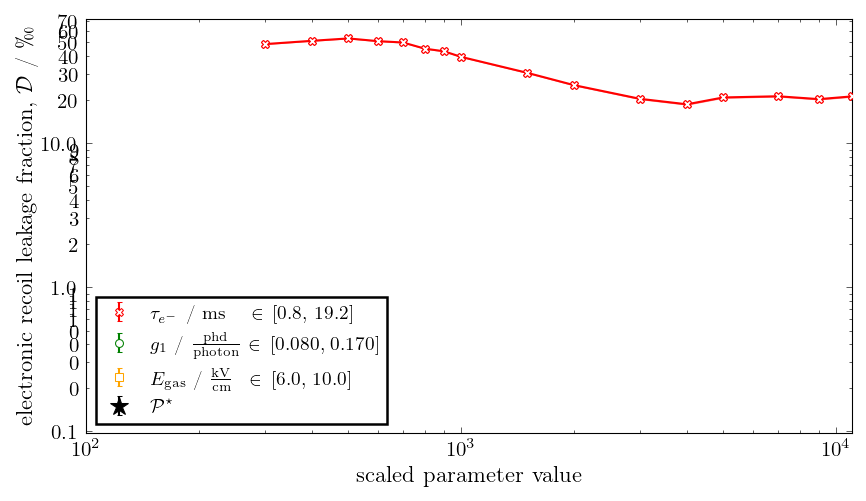

In [63]:


if [False,True][1]:


    # varable input
    data = {
        "eLife_us"  : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0625__lf_scan_for_default_parameters__eLife_us_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230526_0117__lf_scan_for_default_parameters__eLife_us_scan.npy"), np.load(abspath_er_leakage_study +"20230526_1750__lf_scan_for_default_parameters__eLife_us_scan.npy")], "eLife_us"),
            "color" : "red",
            "label" : r"$\tau_{e^-}$ / $\mathrm{ms}$ $\,\,\,\,\,\,\in\,[" +f"{default_param_range_eLife_us[0]/1000:.1f}" +r",\," +f"{default_param_range_eLife_us[1]/1000:.1f}" +r"]$",
            "range" : default_param_range_eLife_us,
            "marker": "X",
            "zorder": 4,
        },
        "e_drift"   : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0412__lf_scan_for_default_parameters__e_drift_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230525_2349__lf_scan_for_default_parameters__e_drift_scan.npy"), np.load(abspath_er_leakage_study +"20230526_1129__lf_scan_for_default_parameters__e_drift_scan.npy")], "e_drift"),
            "color" : "purple",
            "label" : r"$E_{\mathrm{drift}}$ / $\mathrm{\frac{V}{cm}}$ $\,\in\,[" +f"{default_param_range_e_drift[0]:.0f}" +r",\," +f"{default_param_range_e_drift[1]:.0f}" +r"]$",
            "range" : default_param_range_e_drift,
            "marker": "P",
            "zorder": 3,
        },
        "g1"        : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0457__lf_scan_for_default_parameters__g1_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230526_0018__lf_scan_for_default_parameters__g1_scan.npy"), np.load(abspath_er_leakage_study +"20230526_1328__lf_scan_for_default_parameters__g1_scan.npy")], "g1"),
            "color" : "green",
            "label" : r"$g_1$ / $\mathrm{\frac{phd}{photon}}$ $\in \,[" +f"{default_param_range_g1[0]:.3f}" +r",\," +f"{default_param_range_g1[1]:.3f}" +r"]$",
            "range" : default_param_range_g1,
            "marker": "o",
            "zorder": 1,
        },
        "E_gas"     : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0541__lf_scan_for_default_parameters__E_gas_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230526_0048__lf_scan_for_default_parameters__E_gas_scan.npy"), np.load(abspath_er_leakage_study +"20230526_1543__lf_scan_for_default_parameters__E_gas_scan.npy")], "E_gas"),
            "color" : "orange",
            "label" : r"$E_{\mathrm{gas}}$ / $\mathrm{\frac{kV}{cm}}$ $\,\,\,\in\,[" +f"{default_param_range_E_gas[0]:.1f}" +r",\," +f"{default_param_range_E_gas[1]:.1f}" +r"]$",
            "range" : default_param_range_E_gas,
            "marker": "s",
            "zorder": 2,
        },
    }
    data = {
        "e_drift"  : {
            "data"  : np.load(abspath_er_leakage_study +"20230529_1911__lf_scan_for_default_parameters__e_drift_scan.npy"),
            "color" : "red",
            "label" : r"$\tau_{e^-}$ / $\mathrm{ms}$ $\,\,\,\,\,\,\in\,[" +f"{default_param_range_eLife_us[0]/1000:.1f}" +r",\," +f"{default_param_range_eLife_us[1]/1000:.1f}" +r"]$",
            "range" : default_param_range_eLife_us,
            "marker": "X",
            "zorder": 4,
        },
        #"e_drift"   : {
        #    "data"  : np.load(abspath_er_leakage_study +"20230529_1701__lf_scan_for_default_parameters__e_drift_scan.npy"),
#       #     "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230525_2349__lf_scan_for_default_parameters__e_drift_scan.npy"), np.load(abspath_er_leakage_study +"20230526_1129__lf_scan_for_default_parameters__e_drift_scan.npy")], "e_drift"),
        #    "color" : "purple",
        #    "label" : r"$E_{\mathrm{drift}}$ / $\mathrm{\frac{V}{cm}}$ $\,\in\,[" +f"{default_param_range_e_drift[0]:.0f}" +r",\," +f"{default_param_range_e_drift[1]:.0f}" +r"]$",
        #    "range" : default_param_range_e_drift,
        #    "marker": "P",
        #    "zorder": 3,
        #},
        "g1"        : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0457__lf_scan_for_default_parameters__g1_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230526_0018__lf_scan_for_default_parameters__g1_scan.npy"), np.load(abspath_er_leakage_study +"20230526_1328__lf_scan_for_default_parameters__g1_scan.npy")], "g1"),
            "color" : "green",
            "label" : r"$g_1$ / $\mathrm{\frac{phd}{photon}}$ $\in \,[" +f"{default_param_range_g1[0]:.3f}" +r",\," +f"{default_param_range_g1[1]:.3f}" +r"]$",
            "range" : default_param_range_g1,
            "marker": "o",
            "zorder": 1,
        },
        "E_gas"     : {
#            "data"  : np.load(abspath_er_leakage_study +"20230521_0541__lf_scan_for_default_parameters__E_gas_scan.npy"),
            "data"  : sfs.combine_and_sort_ndarrays([np.load(abspath_er_leakage_study +"20230526_0048__lf_scan_for_default_parameters__E_gas_scan.npy"), np.load(abspath_er_leakage_study +"20230526_1543__lf_scan_for_default_parameters__E_gas_scan.npy")], "E_gas"),
            "color" : "orange",
            "label" : r"$E_{\mathrm{gas}}$ / $\mathrm{\frac{kV}{cm}}$ $\,\,\,\in\,[" +f"{default_param_range_E_gas[0]:.1f}" +r",\," +f"{default_param_range_E_gas[1]:.1f}" +r"]$",
            "range" : default_param_range_E_gas,
            "marker": "s",
            "zorder": 2,
        },
    }
    # figure
    fig = plt.figure(figsize=[5.670, 5.670*9/16], dpi=150, constrained_layout=False) 
    spec = gridspec.GridSpec(
        ncols = 3,
        nrows = 3,
        figure = fig,
        top = 1.0,
        bottom = 0.0,
        left = 0.0,
        right = 1.0,
        wspace = 0.0,
        hspace = 0.0,
        width_ratios = [0.085, 0.900, 0.015],
        height_ratios = [0.020, 0.865, 0.115],)

    # axes
    ax1 = fig.add_subplot(spec[1,1])
    ax1.set_xlabel(r"scaled parameter value", fontsize=11)
    ax1.set_ylabel(r"electronic recoil leakage fraction, $\mathcal{D}$ / $\permil$", fontsize=11, labelpad=1.5)
#    ax1.set_xlim([0.025, 0.975])
    ax1.set_xlim([100, 11000])
#    ax1.set_ylim([3.0, 10.0])
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
    ax1.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())


    # plotting
    for k, dataset in enumerate([*data]):
        # data modification
        x_data_rel              = [(x-data[dataset]["range"][0])/(data[dataset]["range"][1]-data[dataset]["range"][0]) for x in data[dataset]["data"][dataset]]
        x_data_rel              = data[dataset]["data"][dataset]
        y_data_permil           = [1000*y for y in data[dataset]["data"]["leakage_fraction"]]
        y_data_unc_permil       = [1000*y for y in data[dataset]["data"]["leakage_fraction_uncertainty"]]
        y_data_unc_permil_upper = [y +y_data_unc_permil[l] for l,y in enumerate(y_data_permil)]
        y_data_unc_permil_lower = [y -y_data_unc_permil[l] for l,y in enumerate(y_data_permil)]
        # plotting uncertainty bands
        ax1.fill_between(
            x = x_data_rel,
            y1 = y_data_unc_permil_upper,
            y2 = y_data_unc_permil_lower,
            color = data[dataset]["color"],
            alpha = 0.5,
            linewidth = 0,
            zorder = data[dataset]["zorder"],
        )
        ax1.plot(
            x_data_rel,
            y_data_permil,
            linewidth       = 1,
            linestyle       = "-",
            color          = data[dataset]["color"],
            zorder = data[dataset]["zorder"],
        )
        # plotting simulation points
        if [False,True][1]:
            ax1.errorbar(
                x               = x_data_rel,
                y               = y_data_permil,
                yerr            = y_data_unc_permil,
                marker          = data[dataset]["marker"],
                markersize      = 3.8,
                markerfacecolor = "white",
                markeredgewidth = 0.5,
                markeredgecolor = data[dataset]["color"],
                linestyle       = "",
                fmt             = "",
                ecolor          = data[dataset]["color"],
                elinewidth      = 1,
                capsize         = 1.2,
                barsabove       = True,
                label           = data[dataset]["label"],
                zorder          = data[dataset]["zorder"],
                capthick        = 0.5,)
            ax1.plot(
                x_data_rel,
                y_data_permil,
                marker          = data[dataset]["marker"],
                markersize      = 3.8,
                markerfacecolor = "white",
                markeredgewidth = 0.5,
                markeredgecolor = data[dataset]["color"],
                linestyle       = "",
                zorder          = data[dataset]["zorder"],
                alpha           = 1,)
    # plotting default parameters
    if [False,True][1]:
        ax1.errorbar(
            x               = 0.5,
            y               = sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json")["leakage_fraction"]*1000,
            yerr            = sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json")["leakage_fraction_uncertainty"]*1000,
            marker          = "*",
            markersize      = 9.0,
            markerfacecolor = "black",
            markeredgewidth = 0.5,
            markeredgecolor = "black",
            linestyle       = "",
            fmt             = "",
            ecolor          = "black",
            elinewidth      = 1,
            capsize         = 1.2,
            barsabove       = True,
            label           = r"$\mathcal{P}^{\star}$",
            zorder          = 5,
            capthick        = 0.5,)
        ax1.plot(
            sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json")["leakage_fraction"]*1000,
            sfs.get_dict_from_json(abspath_discrimination_lines +"example__discrimination_line__default_darwin_detector.json")["leakage_fraction_uncertainty"]*1000,
            marker          = "*",
            markersize      = 9.0,
            markerfacecolor = "black",
            markeredgewidth = 9.0,
            markeredgecolor = "black",
            linestyle       = "",
            zorder          = 5,
            alpha           = 1,)
        
    # legend
    ax1.legend()
    plt.show()

#    # saving
#    for abspath in abspath_list_plots:
#        figure_name = "lekage_fraction_function_reduced_to_all_scanned_parameters"
#        fig.savefig(abspath +figure_name +".png")
#        fig.savefig(abspath +figure_name +".pdf")



#### sanity check: How does the ratio of primary quanta change with increasing drift field?

In [53]:
if [False,True][0]:


    # definitions
    e_drift_list = [300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 3000, 4000, 5000, 7000, 9000, 11000]
    e_drift_list = [300, 900, 3000, 9000]
    e_drift_list = np.geomspace(start=50, stop=10000, num=10, endpoint=True)
    nest_ndarray_list_er = []
    nest_ndarray_list_nr = []
    recoil_energy_kev = 20
    ctr = 0


    # data generation
    for k, e_drift_v_cm in enumerate(e_drift_list):
        for l, interaction_type in enumerate(["ER", "NR"]):
            nest_ndarray = sfs.execNEST(
                spectrum_dict = {
                    "seed": "1",
                    "field_drift[V/cm]": str(e_drift_v_cm),
                    "x,y,z-position[mm]": "-1",
                    "numEvts": [10000],
                    "type_interaction": interaction_type,
                    "E_min[keV]": [recoil_energy_kev],
                    "E_max[keV]": [recoil_energy_kev],
                },
                baseline_detector_dict = darwin_baseline_detector_dict,
                baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
                detector_dict = darwin_baseline_detector_dict, # the specified 'detector_dict' (overwriting 'baseline_detector_dict') will be installed
                detector_name = "example__detector__darwin_baseline_detector",
                abspath_list_detector_dict_json_output = [abspath_detectors],
                flag_verbose = True,
                flag_print_stdout_and_stderr = False,
                flag_detector_installation = "none" if interaction_type=="ER" else "do_not_install",)
            ctr += 1
            if interaction_type=="ER":
                nest_ndarray_list_er.append(nest_ndarray)
            elif interaction_type=="NR":
                nest_ndarray_list_nr.append(nest_ndarray)


execNEST: initializing
execNEST: specified detector 'example__detector__darwin_baseline_detector'as dictionary: {'g1': 0.125, 'sPEres': 0.35, 'sPEthr': 0.35, 'sPEeff': 1.0, 'noiseBaseline[0]': 0.0, 'noiseBaseline[1]': 0.0, 'noiseBaseline[2]': 0.0, 'noiseBaseline[3]': 0.0, 'P_dphe': 0.2, 'coinWind': 150, 'coinLevel': 3, 'numPMTs': 494, 'OldW13eV': 'true', 'noiseLinear[0]': 0.0, 'noiseLinear[1]': 0.0, 'g1_gas': 0.125, 's2Fano': 2.0, 's2_thr': 10.0, 'E_gas': 8, 'eLife_us': 10000, 'T_Kelvin': 175.0, 'p_bar': 1.9, 'dtCntr': 852.5, 'dt_min': 170.5, 'dt_max': 1534.6, 'radius': 1250.0, 'radmax': 1300.0, 'TopDrift': 2650.0, 'anode': 2657.0, 'gate': 2643.0, 'cathode': 50.0, 'PosResExp': 0.015, 'PosResBase': 30.0}
execNEST: updating baseline detector

convert_detector_dict_into_detector_header: initializing
	detector_name: example__detector__darwin_baseline_detector
convert_detector_dict_into_detector_header: adding initial lines to 'line_list'.
convert_detector_dict_into_detector_header: adding

	positive validity check for stderr: 'cmd_dict[stderr]' == ''
	positive validity check for stdout: 'cmd_dict[stdout]' == ''
make_clean_reinstall: executing '$ (cd /home/daniel/Desktop/arbeitsstuff/sfs/nest_v_2_3_9/build/ && make)'
	positive validity check for stderr: one 'cmd_dict[stderr]' line contains 'warning'
	positive validity check for stdout: one 'cmd_dict[stdout]' line contains '[100%]'
	positive validity check for stdout: one 'cmd_dict[stdout]' line contains 'Built target'
	positive validity check for stdout: one 'cmd_dict[stdout]' line contains 'Building'
make_clean_reinstall: executing '$ (cd /home/daniel/Desktop/arbeitsstuff/sfs/nest_v_2_3_9/build/ && make install)'
	positive validity check for stderr: 'cmd_dict[stderr]' == ''
	positive validity check for stdout: one 'cmd_dict[stdout]' line contains '[100%]'
	positive validity check for stdout: one 'cmd_dict[stdout]' line contains 'Built target'
	positive validity check for stdout: one 'cmd_dict[stdout]' line contains 'Inst

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 30000 out of 30000 events
extracting the wanted number of events

execNEST: initializing
execNEST: specified detector 'example__detector__darwin_baseline_detector'as dictionary: {'g1': 0.125, 'sPEres': 0.35, 'sPEthr': 0.35, 'sPEeff': 1.0, 'noiseBaseline[0]': 0.0, 'noiseBaseline[1]': 0.0, 'noiseBaseline[2]': 0.0, 'noiseBaseline[3]': 0.0, 'P_dphe': 0.2, 'coinWind': 150, 'coinLevel': 3, 'numPMTs': 494, 'OldW13eV': 'true', 'noiseLinear[0]': 0.0, 'noiseLinear[1]': 0.0, 'g1_gas': 0.125, 's2Fano': 2.0, 's2_thr': 10.0, 'E_gas': 8, 'eLife_us': 10000, 'T_Kelvin': 175.0, 'p_bar': 1.9, 'dtCntr': 852.5, 'dt_min': 170.5, 'dt_max': 1534.6, 'radius': 1250.0, 'radmax': 1300.0, 'TopDrift': 2650.0, 'anode': 2657.0, 'gate': 2643.0, 'cathode': 50.0, 'PosResExp': 0.015, 'PosResBase': 30.0}
execNEST: updating baseline detector

convert_detector_dict_into_detector_header: initializing
	detector_

	positive validity check for stderr: 'cmd_dict[stderr]' == ''
	positive validity check for stdout: 'cmd_dict[stdout]' == ''
make_clean_reinstall: executing '$ (cd /home/daniel/Desktop/arbeitsstuff/sfs/nest_v_2_3_9/build/ && make)'
	positive validity check for stderr: one 'cmd_dict[stderr]' line contains 'warning'
	positive validity check for stdout: one 'cmd_dict[stdout]' line contains '[100%]'
	positive validity check for stdout: one 'cmd_dict[stdout]' line contains 'Built target'
	positive validity check for stdout: one 'cmd_dict[stdout]' line contains 'Building'
make_clean_reinstall: executing '$ (cd /home/daniel/Desktop/arbeitsstuff/sfs/nest_v_2_3_9/build/ && make install)'
	positive validity check for stderr: 'cmd_dict[stderr]' == ''
	positive validity check for stdout: one 'cmd_dict[stdout]' line contains '[100%]'
	positive validity check for stdout: one 'cmd_dict[stdout]' line contains 'Built target'
	positive validity check for stdout: one 'cmd_dict[stdout]' line contains 'Inst

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 30000 out of 30000 events
extracting the wanted number of events

execNEST: initializing
execNEST: specified detector 'example__detector__darwin_baseline_detector'as dictionary: {'g1': 0.125, 'sPEres': 0.35, 'sPEthr': 0.35, 'sPEeff': 1.0, 'noiseBaseline[0]': 0.0, 'noiseBaseline[1]': 0.0, 'noiseBaseline[2]': 0.0, 'noiseBaseline[3]': 0.0, 'P_dphe': 0.2, 'coinWind': 150, 'coinLevel': 3, 'numPMTs': 494, 'OldW13eV': 'true', 'noiseLinear[0]': 0.0, 'noiseLinear[1]': 0.0, 'g1_gas': 0.125, 's2Fano': 2.0, 's2_thr': 10.0, 'E_gas': 8, 'eLife_us': 10000, 'T_Kelvin': 175.0, 'p_bar': 1.9, 'dtCntr': 852.5, 'dt_min': 170.5, 'dt_max': 1534.6, 'radius': 1250.0, 'radmax': 1300.0, 'TopDrift': 2650.0, 'anode': 2657.0, 'gate': 2643.0, 'cathode': 50.0, 'PosResExp': 0.015, 'PosResBase': 30.0}
execNEST: updating baseline detector

convert_detector_dict_into_detector_header: initializing
	detector_

	positive validity check for stderr: 'cmd_dict[stderr]' == ''
	positive validity check for stdout: 'cmd_dict[stdout]' == ''
make_clean_reinstall: executing '$ (cd /home/daniel/Desktop/arbeitsstuff/sfs/nest_v_2_3_9/build/ && make)'
	positive validity check for stderr: one 'cmd_dict[stderr]' line contains 'warning'
	positive validity check for stdout: one 'cmd_dict[stdout]' line contains '[100%]'
	positive validity check for stdout: one 'cmd_dict[stdout]' line contains 'Built target'
	positive validity check for stdout: one 'cmd_dict[stdout]' line contains 'Building'
make_clean_reinstall: executing '$ (cd /home/daniel/Desktop/arbeitsstuff/sfs/nest_v_2_3_9/build/ && make install)'
	positive validity check for stderr: 'cmd_dict[stderr]' == ''
	positive validity check for stdout: one 'cmd_dict[stdout]' line contains '[100%]'
	positive validity check for stdout: one 'cmd_dict[stdout]' line contains 'Built target'
	positive validity check for stdout: one 'cmd_dict[stdout]' line contains 'Inst

execNEST: casting 'execNEST_output_tuple_list' into numpy ndarray
execNEST: removing -1e-6-flagged events
	selected 30000 out of 30000 events
extracting the wanted number of events

execNEST: initializing
execNEST: specified detector 'example__detector__darwin_baseline_detector'as dictionary: {'g1': 0.125, 'sPEres': 0.35, 'sPEthr': 0.35, 'sPEeff': 1.0, 'noiseBaseline[0]': 0.0, 'noiseBaseline[1]': 0.0, 'noiseBaseline[2]': 0.0, 'noiseBaseline[3]': 0.0, 'P_dphe': 0.2, 'coinWind': 150, 'coinLevel': 3, 'numPMTs': 494, 'OldW13eV': 'true', 'noiseLinear[0]': 0.0, 'noiseLinear[1]': 0.0, 'g1_gas': 0.125, 's2Fano': 2.0, 's2_thr': 10.0, 'E_gas': 8, 'eLife_us': 10000, 'T_Kelvin': 175.0, 'p_bar': 1.9, 'dtCntr': 852.5, 'dt_min': 170.5, 'dt_max': 1534.6, 'radius': 1250.0, 'radmax': 1300.0, 'TopDrift': 2650.0, 'anode': 2657.0, 'gate': 2643.0, 'cathode': 50.0, 'PosResExp': 0.015, 'PosResBase': 30.0}
execNEST: updating baseline detector

convert_detector_dict_into_detector_header: initializing
	detector_

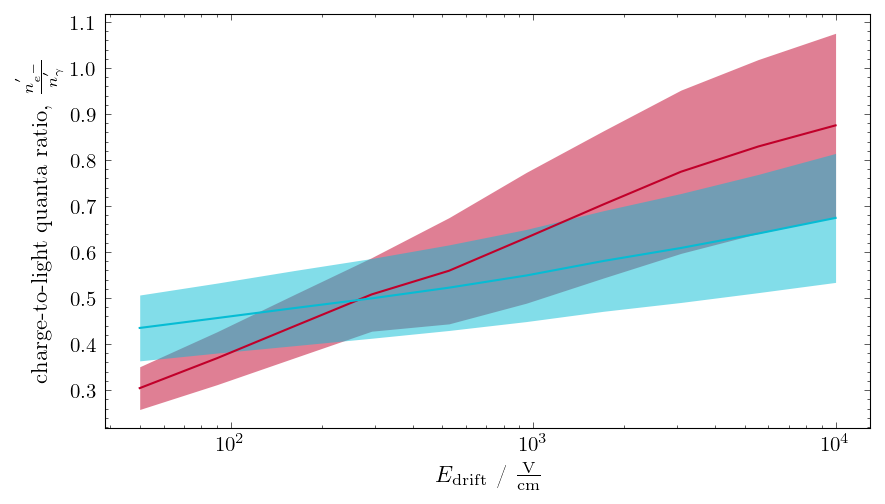

In [54]:
if [False,True][0]:


    ### plotting
    # figure
    fig = plt.figure(figsize=[5.670, 5.670*9/16], dpi=150, constrained_layout=False) 
    spec = gridspec.GridSpec(
        ncols = 3,
        nrows = 3,
        figure = fig,
        top = 1.0,
        bottom = 0.0,
        left = 0.0,
        right = 1.0,
        wspace = 0.0,
        hspace = 0.0,
        width_ratios = [0.085, 0.900, 0.015],
        height_ratios = [0.020, 0.865, 0.115],)
    # axes
    ax1 = fig.add_subplot(spec[1,1])
    ax1.set_xlabel(r"$E_{\mathrm{drift}}$ / $\mathrm{\frac{V}{cm}}$", fontsize=11)
    ax1.set_ylabel(r"charge-to-light quanta ratio, $\frac{n_{e^-}^{'}}{n_{\gamma}^{'}}$", fontsize=11)
#    ax1.set_xlim([0.025, 0.975])
#    ax1.set_xlim([0.0, 1.0])
#    ax1.set_ylim([3.0, 10.0])
#    ax1.set_yscale('log')
    ax1.set_xscale('log')
#    ax1.yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())
#    ax1.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())


    # plotting
    #for k, interaction_type in enumerate(["ER", "NR"]):
    for k, interaction_type in enumerate(["ER", "NR"]):
        # data modification
        data_list = nest_ndarray_list_er if interaction_type=="ER" else nest_ndarray_list_nr
        quanta_ratio = [np.mean(ndarray["Ne-"])/np.mean(ndarray["Nph"]) for ndarray in data_list]
        quanta_sum = [np.mean(ndarray["Ne-"])+np.mean(ndarray["Nph"]) for ndarray in data_list]
        quanta_ratio_uncertainty = [np.sqrt((np.std(ndarray["Ne-"])/np.mean(ndarray["Nph"]))**2 +((np.mean(ndarray["Ne-"])/(np.mean(ndarray["Nph"])**2))*np.std(ndarray["Nph"]))**2)   for ndarray in data_list]
        quanta_sum_uncertainty = [np.sqrt(np.std(ndarray["Ne-"])**2 +np.std(ndarray["Nph"])**2)   for ndarray in data_list]
        # plotting ratio
        ax1.fill_between(
            x              = e_drift_list,
            y1             = [quanta_ratio[i]+quanta_ratio_uncertainty[i] for i in range(len(e_drift_list))],
            y2             = [quanta_ratio[i]-quanta_ratio_uncertainty[i] for i in range(len(e_drift_list))],
            color          = sfs.color_ers_default if interaction_type=="ER" else sfs.color_nrs_default,
            alpha          = 0.5,
            linewidth      = 0,
            zorder         = 1,
        )
        ax1.plot(
            e_drift_list,
            quanta_ratio,
            linewidth      = 1,
            linestyle      = "-",
            color          = sfs.color_ers_default if interaction_type=="ER" else sfs.color_nrs_default,
            zorder         = 1,
        )
        ## plotting sum
        #ax1.fill_between(
        #    x              = e_drift_list,
        #    y1             = [quanta_sum[i]+quanta_sum_uncertainty[i] for i in range(len(e_drift_list))],
        #    y2             = [quanta_sum[i]-quanta_sum_uncertainty[i] for i in range(len(e_drift_list))],
        #    color          = sfs.color_ers_default if interaction_type=="ER" else sfs.color_nrs_default,
        #    alpha          = 0.5,
        #    linewidth      = 0,
        #    zorder         = 1,
        #)
        #ax1.plot(
        #    e_drift_list,
        #    quanta_sum,
        #    linewidth      = 1,
        #    linestyle      = ":",
        #    color          = sfs.color_ers_default if interaction_type=="ER" else sfs.color_nrs_default,
        #    zorder         = 1,
        #)

        
    # legend
    #ax1.legend()
    plt.show()
    

    
    
    

### Electron Lifetime + Drift Field

#### data generation

In [14]:
#default_param_range_eLife_us = [500, 19500] # in us, baseline value: 10000 us
#default_param_range_e_drift = [20, 380] # in V/cm, baseline value: 200 V/cm
#default_param_range_g1 = [0.050, 0.20] # in phd/photon, baseline value: 0.125
#default_param_range_E_gas = [4.0, 12.0] # in kV/cm, baseline value: 8 kV/cm


if [False,True][0]:


    # definitions
    dataset_name = "electron_lifetime_and_drift_field"
    # manually selecting eight detector configurations
    # note that every subdataset corresponds to one curve as only a single parameter value is given per other parameter
    n_samples_per_hist2d_axis = 11
    subdataset_dict = {
        "baseline_parameters" : {
            "eLife_us" : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
            "e_drift"  : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_e_drift[0], stop=default_param_range_e_drift[1], endpoint=True)),
            "g1"       : [default_param_g1],
            "E_gas"    : [default_param_E_gas],
        },
        "bad_g1_bad_E_gas" : {
            "eLife_us" : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
            "e_drift"  : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_e_drift[0], stop=default_param_range_e_drift[1], endpoint=True)),
            "g1"       : [default_param_range_g1[0]],
            "E_gas"    : [default_param_range_E_gas[0]],
        },
        "good_g1_good_E_gas" : {
            "eLife_us" : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
            "e_drift"  : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_e_drift[0], stop=default_param_range_e_drift[1], endpoint=True)),
            "g1"       : [default_param_range_g1[1]],
            "E_gas"    : [default_param_range_E_gas[1]],
        },
        "bad_g1_good_E_gas" : {
            "eLife_us" : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
            "e_drift"  : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_e_drift[0], stop=default_param_range_e_drift[1], endpoint=True)),
            "g1"       : [default_param_range_g1[0]],
            "E_gas"    : [default_param_range_E_gas[1]],
        },
        "good_g1_bad_E_gas" : {
            "eLife_us" : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_eLife_us[0], stop=default_param_range_eLife_us[1], endpoint=True)),
            "e_drift"  : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_e_drift[0], stop=default_param_range_e_drift[1], endpoint=True)),
            "g1"       : [default_param_range_g1[1]],
            "E_gas"    : [default_param_range_E_gas[0]],
        },
    }


    # data generation
    for subdataset_name in [*subdataset_dict]:
        print(f"\n\n\n\n\n" +80*"#" +f"\nstarting subdataset '{subdataset_name}' simulation at {datetime.datetime.now()}\n" +80*"#" +f"\n\n")
        cartesian_product_of_leakage_fraction_checks = sfs.conduct_cartesian_product_of_leakage_fraction_checks(
            check_parameter_dict                           = subdataset_dict[subdataset_name],
            default_detector_parameter_dict                = darwin_baseline_detector_dict,
            default_detector_e_drift                       = darwin_baseline_detector_drift_field_v_cm,
            abspathstring_er_background_spectrum_dict      = abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json",
            abspathstring_nr_background_spectrum_dict      = abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json",
            wimp_eroi_kev_ee                               = default_wimp_eroi_kev_ee,
            discrimination_line_bins                       = default_number_of_discrimination_line_energy_bins,
            nr_acceptance                                  = default_nr_acceptance,
            flag_g1_gas_depending_on_g1                    = [False, True, 0.96][2],
            abspath_save_output_detector_header_files_here = abspath_detectors,
        )
        np.save(abspath_er_leakage_study +sfs.current_datetimestring() +"__" +dataset_name +"__" +subdataset_name +".npy", cartesian_product_of_leakage_fraction_checks)



#### plotting

sum of 'width_ratios'=1.0
sum of 'height_ratios'=1.0
'lf_min_permil_list'=[9.3593759944558, 2.4382083262144416, 3.929419004806589, 7.213625816737568, 3.898573242804182]
'lf_max_permil_list'=[28.802259167250543, 9.066044480169566, 11.433699734650581, 25.907270256618208, 13.160185464816788]
'lf_min_permil_val'=2.4382083262144416
'lf_max_permil_val'=28.802259167250543
'cbar_axis_limits_y'=(3.8985732428041815, 13.160185464816788)
cbar_axis_limits_y=(3.8985732428041815, 13.160185464816788)


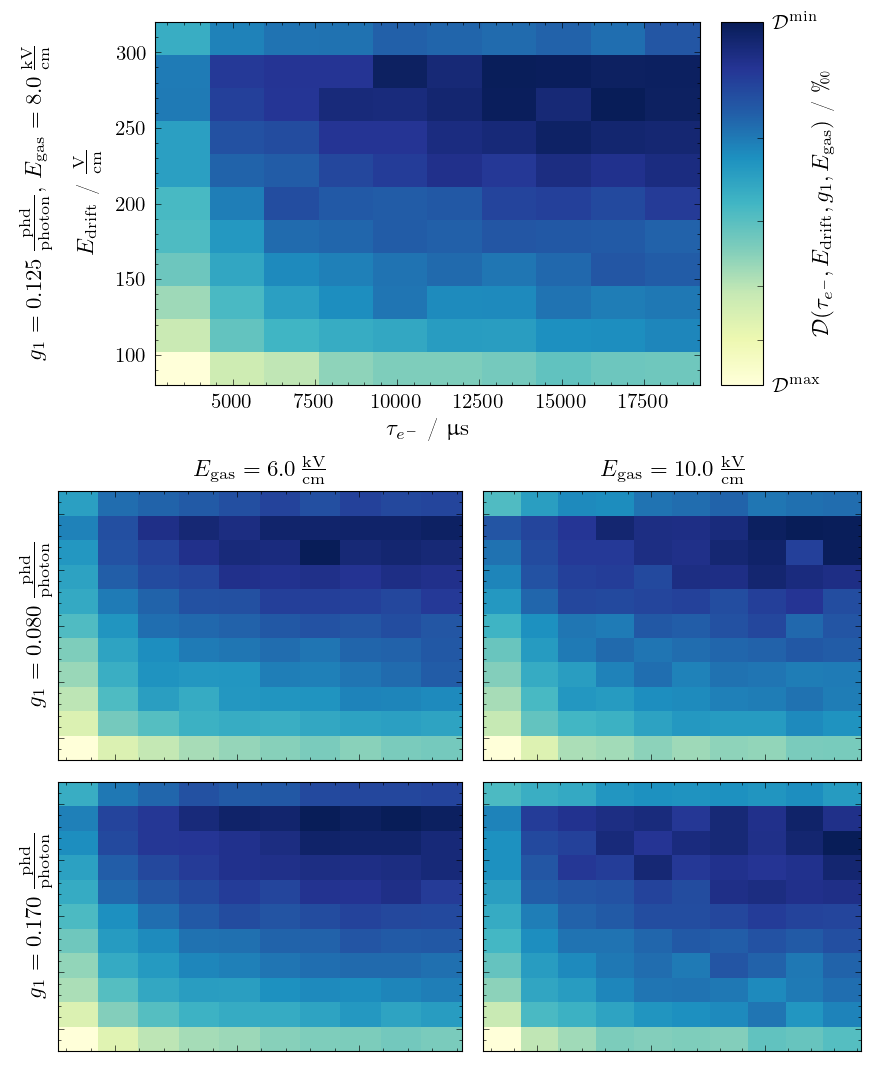

In [15]:


if [False,True][0]:


    # variable input
    figsize_x_inch = 5.670
    ### This plot accomodates one main plot and four subplots, all of which are supposed to have the same aspect ratio.
    ### Accordingly, the y-dimension of the plot depends on the aspect ratio of the main plot, i.e., 'aspect_ratio_main_plot_y_over_x'.
    # dimensions relative to 'figsize_x_inch'
    side_param_spacing_rel_to_figure_width = 0.05 # col 0: side param label
    main_plot_label_spacing_rel_to_figure_width = 0.115 # col 1: main plot label, col 7: cbar label
    main_plot_to_cbar_spacing_rel_to_figure_width = 0.025 # col 5: spacing between main plot and colorbar
    cbar_width_rel_to_figure_width = 0.05 # col 6: cbar
    x_spacing_on_right_side_rel_to_figure_width = 0.005 # col 8: spacing
    y_spacing_top_rel_to_figure_width = 0.015
    y_spacing_subplots_rel_to_figure_width = 0.025
    y_spacing_bottom_rel_to_figure_width = 0.015
    x_spacing_subplots_rel_to_figure_width = 0.025
    aspect_ratio_main_plot_y_over_x = 2/3


    # definitions
    # derived geometric quantities
    main_plot_width_rel_to_figure_width = 1- (side_param_spacing_rel_to_figure_width +2*main_plot_label_spacing_rel_to_figure_width +main_plot_to_cbar_spacing_rel_to_figure_width +cbar_width_rel_to_figure_width +x_spacing_on_right_side_rel_to_figure_width) # col 2,3,4: main plot width
    main_plot_window_1_width_rel_to_figure_width = 0.5 -(main_plot_label_spacing_rel_to_figure_width+x_spacing_subplots_rel_to_figure_width)
    main_plot_window_3_width_rel_to_figure_width = main_plot_width_rel_to_figure_width -(main_plot_window_1_width_rel_to_figure_width+x_spacing_subplots_rel_to_figure_width)
    figsize_y_inch_sections = [
        y_abs_y_spacing_top     := figsize_x_inch*y_spacing_top_rel_to_figure_width,
        y_abs_main_plot_height  := figsize_x_inch*main_plot_width_rel_to_figure_width*aspect_ratio_main_plot_y_over_x,
        y_abs_main_plot_label   := 0.65*figsize_x_inch*main_plot_label_spacing_rel_to_figure_width,
        y_abs_side_param_label  := figsize_x_inch*side_param_spacing_rel_to_figure_width,
        y_abs_subplot_height    := figsize_x_inch*(main_plot_label_spacing_rel_to_figure_width+main_plot_window_1_width_rel_to_figure_width)*aspect_ratio_main_plot_y_over_x,
        y_abs_subplot_spacing   := figsize_x_inch*y_spacing_subplots_rel_to_figure_width,
        y_abs_subplot_height,
        y_abs_y_spacing_bottom  := figsize_x_inch*y_spacing_bottom_rel_to_figure_width,
    ]
    figsize_y_inch = sum(figsize_y_inch_sections)
    aspect_ratio = figsize_y_inch/figsize_x_inch
    
    
    
    # figure
    fig_aspect_ratio = 2*9/16
    width_ratios = [
        side_param_spacing_rel_to_figure_width,
        main_plot_label_spacing_rel_to_figure_width,
        main_plot_window_1_width_rel_to_figure_width,
        x_spacing_subplots_rel_to_figure_width,
        main_plot_window_3_width_rel_to_figure_width,
        main_plot_to_cbar_spacing_rel_to_figure_width,
        cbar_width_rel_to_figure_width,
        main_plot_label_spacing_rel_to_figure_width,
        x_spacing_on_right_side_rel_to_figure_width,]
    height_ratios = [y_abs_val/figsize_y_inch for y_abs_val in figsize_y_inch_sections]
    fig = plt.figure(figsize=[figsize_x_inch, figsize_y_inch], dpi=150, constrained_layout=False) 
    spec = gridspec.GridSpec(
        ncols = 9,
        nrows = 8,
        figure = fig,
        top = 1.0,
        bottom = 0.0,
        left = 0.0,
        right = 1.0,
        wspace = 0.0,
        hspace = 0.0,
        width_ratios = width_ratios,
        height_ratios = height_ratios,)
    print(f"sum of 'width_ratios'={sum(width_ratios)}")
    print(f"sum of 'height_ratios'={sum(height_ratios)}")


    # axes
    plot_axes = [
        ax_plot_main              := fig.add_subplot(spec[1,2:5]),
        ax_plot_cbar              := fig.add_subplot(spec[1,6]),
        ax_plot_sub_upper_left    := fig.add_subplot(spec[4, 1:3]),
        ax_plot_sub_upper_right   := fig.add_subplot(spec[4, 4:8]),
        ax_plot_sub_lower_left    := fig.add_subplot(spec[6, 1:3]),
        ax_plot_sub_lower_right   := fig.add_subplot(spec[6, 4:8]),
    ]
    label_axes = [
        ax_label_main_x           := fig.add_subplot(spec[2, 2:5]),
        ax_label_main_y           := fig.add_subplot(spec[1, 1]),
        ax_label_main_y_side      := fig.add_subplot(spec[1, 0]),
        ax_label_colorbar         := fig.add_subplot(spec[1, 7]),
        ax_label_upper_left_top   := fig.add_subplot(spec[3, 1:3]),
        ax_label_upper_right_top  := fig.add_subplot(spec[3, 4:8]),
        ax_label_upper_left_left  := fig.add_subplot(spec[4, 0]),
        ax_label_lower_left_left  := fig.add_subplot(spec[6, 0]),
    ]
    fontsize_main_axis_label = 11
    fontsize_side_param_label = 11
    
    
    # printing axis labels
    axis_labels = [
        {
            "label"    : r"$E_{\mathrm{drift}}$ / $\frac{\mathrm{V}}{\mathrm{cm}}$",
            "fontsize" : fontsize_main_axis_label,
            "rotation" : 90,
            "axis"     : ax_label_main_y,
            "offset"   : [-0.2,0],
        },
        {
            "label"    : r"$\tau_{e^-}$ / $\mathrm{\upmu s}$",
            "fontsize" : fontsize_main_axis_label,
            "rotation" : 0,
            "axis"     : ax_label_main_x,
            "offset"   : [0,-0.2],
        },
        {
            "label"    : r"$\mathcal{D}(\tau_{e^-}, E_{\mathrm{drift}}, g_1, E_{\mathrm{gas}})$ / $\permil$",
            "fontsize" : fontsize_main_axis_label,
            "rotation" : 90,
            "axis"     : ax_label_colorbar,
            "offset"   : [+0.1,0],
        },
#default_param_range_eLife_us = [800, 19200] # in us, baseline value: 10000 us
#default_param_range_e_drift = [80, 320] # in V/cm, baseline value: 200 V/cm
#default_param_range_g1 = [0.080, 0.170] # in phd/photon, baseline value: 0.125
#default_param_range_E_gas = [6.0, 10.0] # in kV/cm, baseline value: 8 kV/cm
#default_param_eLife_us = 10000
#default_param_e_drift = 200
#default_param_g1 = 0.125
#default_param_E_gas = 8
        {
#            "label"    : r"$g_1 = g^{\star}_1$, $E_{\mathrm{gas}}=E_{\mathrm{gas}}^{\star}$",
            "label"    : r"$g_1 = " +f"{default_param_g1:.3f}" +r"\,\mathrm{\frac{phd}{photon}}$, $E_{\mathrm{gas}}=" +f"{default_param_E_gas:.1f}" +r"\,\mathrm{\frac{kV}{cm}}$",
            "fontsize" : fontsize_side_param_label,
            "rotation" : 90,
            "axis"     : ax_label_main_y_side,
            "offset"   : [0,0],
        },
        {
#            "label"    : r"$g_1=g_1^{\mathrm{min}}$",
            "label"    : r"$g_1 = " +f"{default_param_range_g1[0]:.3f}" +r"\,\mathrm{\frac{phd}{photon}}$",
            "fontsize" : fontsize_side_param_label,
            "rotation" : 90,
            "axis"     : ax_label_upper_left_left,
            "offset"   : [0,0],
        },
        {
#            "label"    : r"$g_1=g_1^{\mathrm{max}}$",
            "label"    : r"$g_1 = " +f"{default_param_range_g1[1]:.3f}" +r"\,\mathrm{\frac{phd}{photon}}$",
            "fontsize" : fontsize_side_param_label,
            "rotation" : 90,
            "axis"     : ax_label_lower_left_left,
            "offset"   : [0,0],
        },
        {
#            "label"    : r"$E_{\mathrm{gas}}=E_{\mathrm{gas}}^{\mathrm{min}}$",
            "label"    : r"$E_{\mathrm{gas}}=" +f"{default_param_range_E_gas[0]:.1f}" +r"\,\mathrm{\frac{kV}{cm}}$",
            "fontsize" : fontsize_side_param_label,
            "rotation" : 0,
            "axis"     : ax_label_upper_left_top,
            "offset"   : [0,0],
        },
        {
#            "label"    : r"$E_{\mathrm{gas}}=E_{\mathrm{gas}}^{\mathrm{max}}$",
            "label"    : r"$E_{\mathrm{gas}}=" +f"{default_param_range_E_gas[1]:.1f}" +r"\,\mathrm{\frac{kV}{cm}}$",
            "fontsize" : fontsize_side_param_label,
            "rotation" : 0,
            "axis"     : ax_label_upper_right_top,
            "offset"   : [0,0],
        },
    ]
    for k, label in enumerate(axis_labels):
        label["axis"].text(
            s = label["label"],
            x = 0.5 +label["offset"][0],
            y = 0.5 +label["offset"][1],
            transform = label["axis"].transAxes,
            horizontalalignment = "center",
            verticalalignment = "center",
            fontsize = label["fontsize"],
            color = "black",
            rotation = label["rotation"],
        )
        # hiding axis spines
        label["axis"].set_axis_off()
    # hiding axis ticks
    for k, ax in enumerate([ax_plot_sub_upper_left, ax_plot_sub_upper_right, ax_plot_sub_lower_left, ax_plot_sub_lower_right]):
        ax.set_yticklabels([])
        ax.set_xticklabels([])


    # plotting
    data = {
        "bad_g1_bad_E_gas"     : {
            "data"             : np.load(abspath_er_leakage_study +"20230525_0911__electron_lifetime_and_drift_field__bad_g1_bad_E_gas.npy"),
            "axis"             : ax_plot_sub_upper_left,
        },
        "good_g1_good_E_gas"   : {
            "data"             : np.load(abspath_er_leakage_study +"20230525_1455__electron_lifetime_and_drift_field__good_g1_good_E_gas.npy"),
            "axis"             : ax_plot_sub_lower_right,
        },
        "bad_g1_good_E_gas"    : {
            "data"             : np.load(abspath_er_leakage_study +"20230525_2005__electron_lifetime_and_drift_field__bad_g1_good_E_gas.npy"),
            "axis"             : ax_plot_sub_upper_right,
        },
        "good_g1_bad_E_gas"    : {
            "data"             : np.load(abspath_er_leakage_study +"20230527_0412__electron_lifetime_and_drift_field__good_g1_bad_E_gas.npy"),
            "axis"             : ax_plot_sub_lower_left,
        },
        "baseline_parameters"  : {
            "data"             : np.load(abspath_er_leakage_study +"20230525_0416__electron_lifetime_and_drift_field__baseline_parameters.npy"),
            "axis"             : ax_plot_main,
        },
    }
    # data selection
    for subdata in [*data]:
        data[subdata]["data"] = data[subdata]["data"][data[subdata]["data"]["eLife_us"]>1000]
    lf_min_permil_list = [1000*np.min(data[subdata]["data"]["leakage_fraction"]) for subdata in [*data]]
    lf_max_permil_list = [1000*np.max(data[subdata]["data"]["leakage_fraction"]) for subdata in [*data]]
    print(f"'lf_min_permil_list'={lf_min_permil_list}")
    print(f"'lf_max_permil_list'={lf_max_permil_list}")
    lf_min_permil_val = min(lf_min_permil_list)
    lf_max_permil_val = max(lf_max_permil_list)
    print(f"'lf_min_permil_val'={lf_min_permil_val}")
    print(f"'lf_max_permil_val'={lf_max_permil_val}")
    for k, subdata in enumerate([*data]):
        weights = data[subdata]["data"]["leakage_fraction"]*1000
        if [False, "flag_show_rejection_instead_of_leakage"][0]: weights = (1-data[subdata]["data"]["leakage_fraction"])*1000
        h2d = data[subdata]["axis"].hist2d(
            x = data[subdata]["data"]["eLife_us"],
            y = data[subdata]["data"]["e_drift"],
            bins = [len(set(data[subdata]["data"]["eLife_us"])), len(set(data[subdata]["data"]["e_drift"]))],
#            vmin = lf_min_permil_val,
#            vmax = lf_max_permil_val,
            cmap = ["YlGnBu", "YlGnBu_r", "GnBu", "viridis"][1],
            norm = mpl.colors.LogNorm(),
            weights = weights,)
    baseline_min_discrimination_permil = 1000*np.min(data["baseline_parameters"]["data"]["leakage_fraction"])
    baseline_max_discrimination_permil = 1000*np.max(data["baseline_parameters"]["data"]["leakage_fraction"])
    cbar = fig.colorbar(h2d[3], cax=ax_plot_cbar, ticks=[baseline_min_discrimination_permil, baseline_max_discrimination_permil])
    cbar_axis_limits_y = ax_plot_cbar.get_ylim()
    print(f"'cbar_axis_limits_y'={cbar_axis_limits_y}")
    print(f"{cbar_axis_limits_y=}")
    cbar_tick_labels = [r"$\mathcal{D}^{\mathrm{min}}$", r"", r"", r"", r"", r"$\mathcal{D}^{\mathrm{max}}$"]
    cbar.set_ticks(np.linspace(start=cbar_axis_limits_y[0], stop=cbar_axis_limits_y[1], num=6, endpoint=True))
    cbar.set_ticklabels(cbar_tick_labels)
    #cbar.ax.set_yticklabels(cbar_tick_labels)
    cbar.ax.minorticks_off()
    if [False, "flag_swap_cbar_orientation"][1]: cbar.ax.invert_yaxis()
    
    
    #ax1.set_xlabel(r"relative parameter value, ${^{\bullet}p}$", fontsize=11)
    #ax1.set_ylabel(r"reduced leakage fraction, $\mathcal{D}\vert_{p}({^{\bullet}p})$ / $\permil$", fontsize=11, labelpad=5)
    #ax1.set_xlim([0.025, 0.975])
    #ax1.set_ylim([3.0, 10.0])
    #ax1.set_yscale('log')


    # plotting
        

    # saving
    plt.show()
    for abspath in abspath_list_plots:
        figure_name = "lekage_fraction_for_electron_lifetime_and_drift_field"
        fig.savefig(abspath +figure_name +".png")
        fig.savefig(abspath +figure_name +".pdf")



### Effective Scintillation Gain and Extraction Field

#### data generation

In [ ]:
#default_param_range_eLife_us = [500, 19500] # in us, baseline value: 10000 us
#default_param_range_e_drift = [20, 380] # in V/cm, baseline value: 200 V/cm
#default_param_range_g1 = [0.050, 0.20] # in phd/photon, baseline value: 0.125
#default_param_range_E_gas = [4.0, 12.0] # in kV/cm, baseline value: 8 kV/cm


if [False,True][1]:


    # definitions
    dataset_name = "scintillation_gain_and_extraction_field"
    # manually selecting eight detector configurations
    # note that every subdataset corresponds to one curve as only a single parameter value is given per other parameter
    n_samples_per_hist2d_axis = 11
    subdataset_dict = {
        #"baseline_parameters" : {
        #    "eLife_us" : [default_param_eLife_us],
        #    "e_drift"  : [default_param_e_drift],
        #    "g1"       : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_g1[0], stop=default_param_range_g1[1], endpoint=True)),
        #    "E_gas"    : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_E_gas[0], stop=default_param_range_E_gas[1], endpoint=True)),
        #},
        #"bad_eLife_us_bad_e_drift" : {
        #    "eLife_us" : [default_param_range_eLife_us[0]],
        #    "e_drift"  : [default_param_range_e_drift[0]],
        #    "g1"       : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_g1[0], stop=default_param_range_g1[1], endpoint=True)),
        #    "E_gas"    : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_E_gas[0], stop=default_param_range_E_gas[1], endpoint=True)),
        #},
        "good_eLife_us_good_e_drift" : {
            "eLife_us" : [default_param_range_eLife_us[1]],
            "e_drift"  : [default_param_range_e_drift[1]],
            "g1"       : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_g1[0], stop=default_param_range_g1[1], endpoint=True)),
            "E_gas"    : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_E_gas[0], stop=default_param_range_E_gas[1], endpoint=True)),
        },
        "bad_eLife_us_good_e_drift" : {
            "eLife_us" : [default_param_range_eLife_us[0]],
            "e_drift"  : [default_param_range_e_drift[1]],
            "g1"       : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_g1[0], stop=default_param_range_g1[1], endpoint=True)),
            "E_gas"    : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_E_gas[0], stop=default_param_range_E_gas[1], endpoint=True)),
        },
        "good_eLife_us_bad_e_drift" : {
            "eLife_us" : [default_param_range_eLife_us[1]],
            "e_drift"  : [default_param_range_e_drift[0]],
            "g1"       : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_g1[0], stop=default_param_range_g1[1], endpoint=True)),
            "E_gas"    : list(np.linspace(num=n_samples_per_hist2d_axis, start=default_param_range_E_gas[0], stop=default_param_range_E_gas[1], endpoint=True)),
        },
    }


    # data generation
    for subdataset_name in [*subdataset_dict]:
        print(f"\n\n\n\n\n" +80*"#" +f"\nstarting subdataset '{subdataset_name}' simulation at {datetime.datetime.now()}\n" +80*"#" +f"\n\n")
        cartesian_product_of_leakage_fraction_checks = sfs.conduct_cartesian_product_of_leakage_fraction_checks(
            check_parameter_dict                           = subdataset_dict[subdataset_name],
            default_detector_parameter_dict                = darwin_baseline_detector_dict,
            default_detector_e_drift                       = darwin_baseline_detector_drift_field_v_cm,
            abspathstring_er_background_spectrum_dict      = abspath_spectra +"example__spectrum__combined_er_background_medium_stat.json",
            abspathstring_nr_background_spectrum_dict      = abspath_spectra +"example__spectrum__combined_nr_background_medium_stat.json",
            wimp_eroi_kev_ee                               = default_wimp_eroi_kev_ee,
            discrimination_line_bins                       = default_number_of_discrimination_line_energy_bins,
            nr_acceptance                                  = default_nr_acceptance,
            flag_g1_gas_depending_on_g1                    = [False, True, 0.96][2],
            abspath_save_output_detector_header_files_here = abspath_detectors,
        )
        np.save(abspath_er_leakage_study +sfs.current_datetimestring() +"__" +dataset_name +"__" +subdataset_name +".npy", cartesian_product_of_leakage_fraction_checks)








################################################################################
starting subdataset 'good_eLife_us_good_e_drift' simulation at 2023-05-28 17:02:55.653954
################################################################################


starting leakage fraction check for 121 detectors at 't_i' = 2023-05-28 17:02:55.654242
starting check #1/121
	parameters:
		'eLife_us' =  19200
		'e_drift' =  320
		'g1' =  0.08
		'E_gas' =  6.0
	generating the detector:
		setting 'g1_gas'=0.96*'g1', with 'g1' taken from input parameters
	generating the ER signature:
	generating the NR signature:
	determining the leakage fraction:
		'leakage_fraction'=0.011165678444017835
		'leakage_fraction_uncertainty'=0.00019979757549508722
	finished check #1/121 at 17:08:01 h after 0:05:05 h
starting check #2/121
	parameters:
		'eLife_us' =  19200
		'e_drift' =  320
		'g1' =  0.08
		'E_gas' =  6.4
	generating the detector:
		setting 'g1_gas'=0.96*'g1', with 'g1' taken from input parameters
	ge

#### plotting


<br>
<br>


# Study: Maximum Likelihood Sensitivity Estimation


<br>
<br>



#### computing exclusion line

In [16]:


from scipy.optimize import minimize


# defining test function
def testfunc(ix,iy,iz):
    val = np.array(0)
    x = np.float128(ix)
    y = np.float128(iy)
    z = np.float128(iz)
    val = 4.2*x**2 +3.1*y**2 +2.4*z**2
    return val


# minimizing test function
minimum = minimize(
    fun    = lambda x : testfunc(x[0],x[1],x[2]),
    x0     = [0,1,1],
    #bounds = [[0,5000000], [0,5000000], [0,50000000]],
    options = {
        "xtol" : 0.000000000000000000000000001,
        "ftol" : 0.000000000000000000000000001},
#    method = None,
    method = "Powell",
#    method = "Nelder-Mead",
)


# printing output
print(f"test function output: {testfunc(1,1,1)}\n")
print(f"minimum output:\n{minimum}\n")
print(f"minimum location: {minimum.x}\n")
print(f"minimum value: {testfunc(minimum.x[0], minimum.x[1], minimum.x[2])}\n")





test function output: 9.7

minimum output:
   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
     fun: 2.4636187383296988752e-33
 message: 'Optimization terminated successfully.'
    nfev: 136
     nit: 3
  status: 0
 success: True
       x: array([-2.42193270e-17,  1.10120164e-20,  0.00000000e+00])

minimum location: [-2.42193270e-17  1.10120164e-20  0.00000000e+00]

minimum value: 2.4636187383296988e-33




cwpec: initializing 'calculate_wimp_parameter_exclusion_curve' (cwpec)
cwpec: implementing the detector
	updating drift velocity-dependent parameters
	saving detector header file
	installing detector header file
		finished within 0:00:25.408391 h'
cwpec: a priori calculations:
	initial definitions
	calculating bin edges of the binned cS1-cS2 observable space
		calculating 'integral_spectrum_dict' for 'er_background'
######################### starting integration #########################
######################### finishing integration #########################
		calculating 'integral_spectrum_dict' for 'nr_background'
######################### starting integration #########################
######################### finishing integration #########################
		generating ER and NR background signatures signatures by executing NEST
		reducing ER and NR background signatures to WIMP EROI
		determining the cS1 and cS2 observable space bin edges
		updating the 'spectrum_components_dic

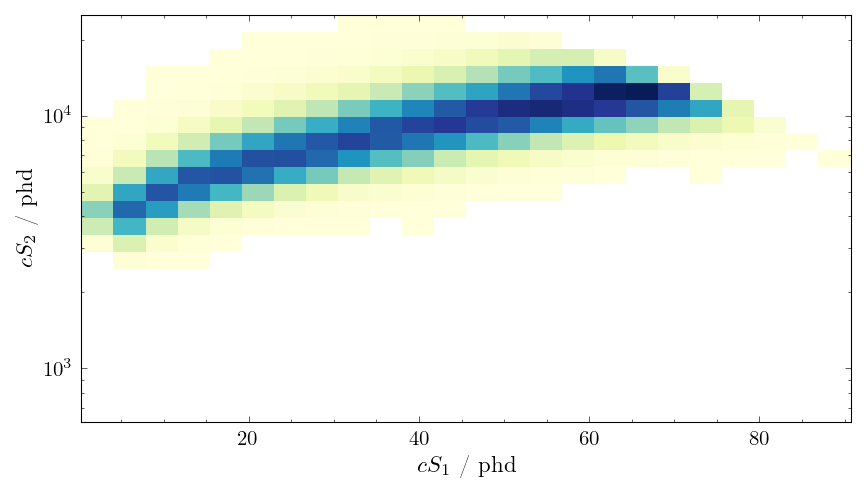

		plotting spectral PDF for 'nr_background'


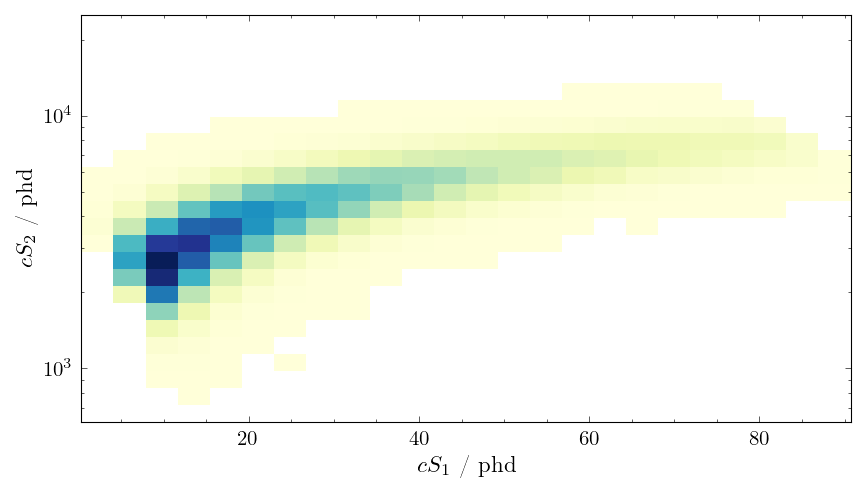

		finished within 0:00:18.319710 h'
	calculating the expected number of ER and NR background events within the binned observable space
		calculating the number of ER background events expected within the WIMP EROI
######################### starting integration #########################
######################### finishing integration #########################
		calculating the number of NR background events expected within the WIMP EROI
######################### starting integration #########################
######################### finishing integration #########################
		updating the 'spectrum_components_dict'
		finished within 0:19:14.258626 h'
cwpec: starting WIMP mass loop with k=0/20 for 10.00 GeV
	calculating the PDF of the WIMP spectrum within the binned observable space
		calculating 'integral_spectrum_dict' for the high-statistics WIMP spectrum
######################### starting integration #########################


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:1614: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  expected_number_of_events_float_per_energy_bin = [exposure_t_y *integrate.quad(


######################### finishing integration #########################
		generating the high-statistics WIMP signature by executing NEST
		calculating the PDF
		updating the 'spectrum_components_dict'
		deleting the high-statistics WIMP signature
		plotting spectral PDF for 'wimps'


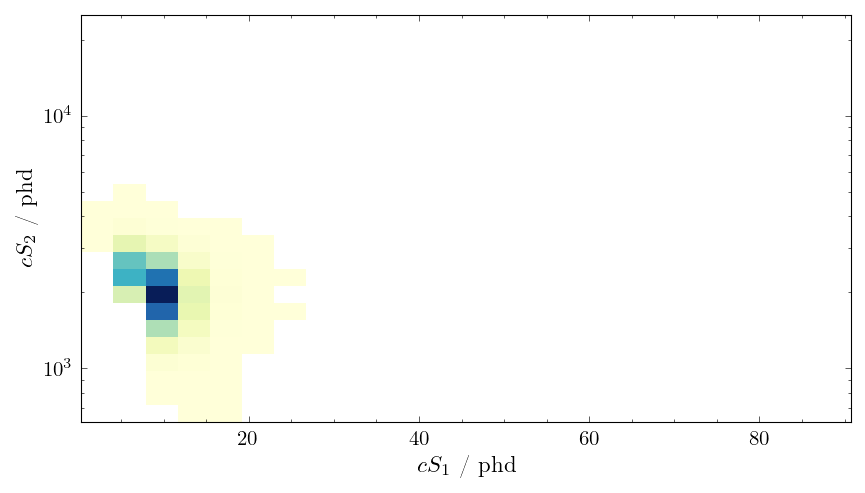

		finished within 0:01:35.674772 h'
	calculating the expected number of WIMP events within the binned observable space
		calculating the number of WIMP events expected within the WIMP EROI
######################### starting integration #########################
######################### finishing integration #########################
		updating the 'spectrum_components_dict'
		finished within 0:00:29.068005 h'
	simulating 200 background-only datasets
		generating the 'spectrum_dict's
######################### starting integration #########################
######################### finishing integration #########################
######################### starting integration #########################
######################### finishing integration #########################
		generating the ER and NR background 'signature's
	calculating the maximum likelihood parameter estimators

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
	

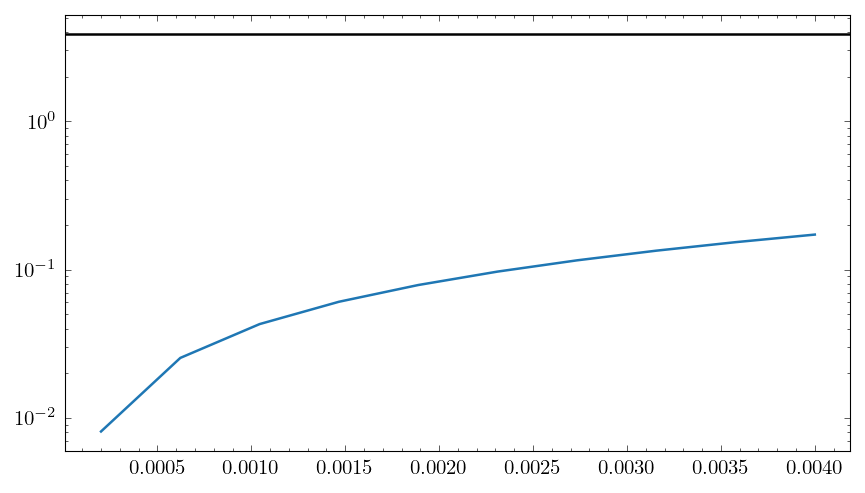

		determining the upper limit
		--->0.05778238842905035

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.517450276098009e-17
		--->'mle_theta_er': 0.9842860466581285
		--->'mle_theta_nr': 1.1378449845574643
		defining the test statistic
		determining the upper limit
		--->0.2116531488329774

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.24210217163523e-17
		--->'mle_theta_er': 0.9876679858723139
		--->'mle_theta_nr': 1.19628577762382
		defining the test statistic
		determining the upper limit
		--->0.16101305882085884

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.164166435579507e-17
		--->'mle_theta_er': 0.9858126690613411
		--->'mle_theta_nr': 1.0728586936216118
		defining the test statistic
		determining the upper limit
		--->0.060901989656603

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


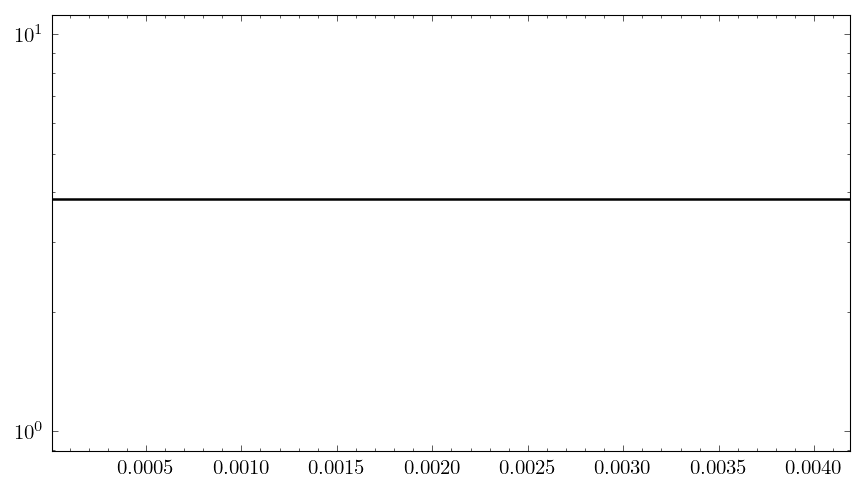

		determining the upper limit
		--->0.17244265722756072

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.381138810890432e-17
		--->'mle_theta_er': 0.9854787476551048
		--->'mle_theta_nr': 0.9996772836696379
		defining the test statistic
		test statistic plot


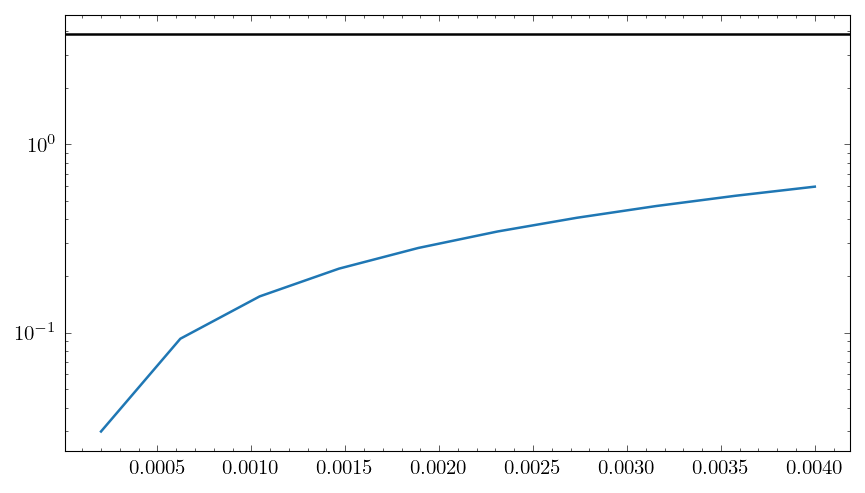

		determining the upper limit
		--->0.025738055232491817

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0683483583135617e-16
		--->'mle_theta_er': 0.9918802825463523
		--->'mle_theta_nr': 1.201955998787208
		defining the test statistic
		test statistic plot


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


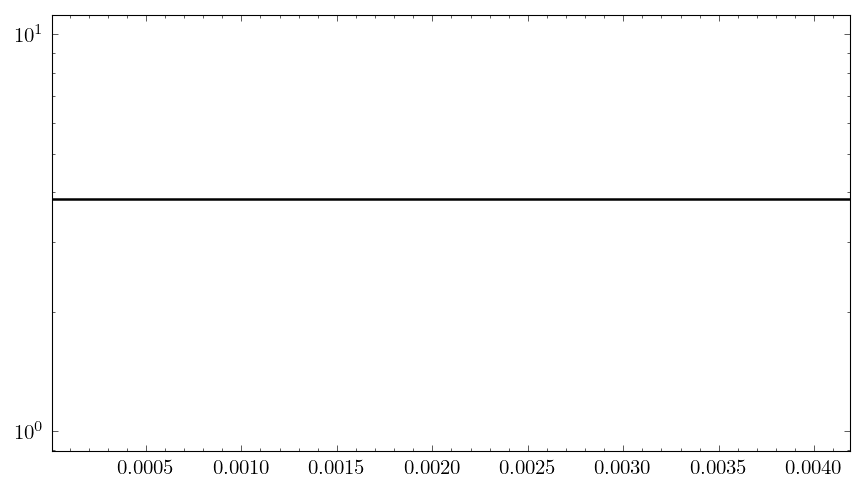

		determining the upper limit
		--->0.2753704077494199

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.572460619524322e-17
		--->'mle_theta_er': 0.9830986774282082
		--->'mle_theta_nr': 1.1389248003326755
		defining the test statistic
		determining the upper limit
		--->0.036556807470925594

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.341218406012412e-17
		--->'mle_theta_er': 0.9885079222524626
		--->'mle_theta_nr': 1.0774854697259517
		defining the test statistic
		determining the upper limit
		--->0.042487386175516575

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.116318154180444e-17
		--->'mle_theta_er': 0.9837830015044112
		--->'mle_theta_nr': 1.0726362212326306
		defining the test statistic
		determining the upper limit
		--->0.0269817512

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


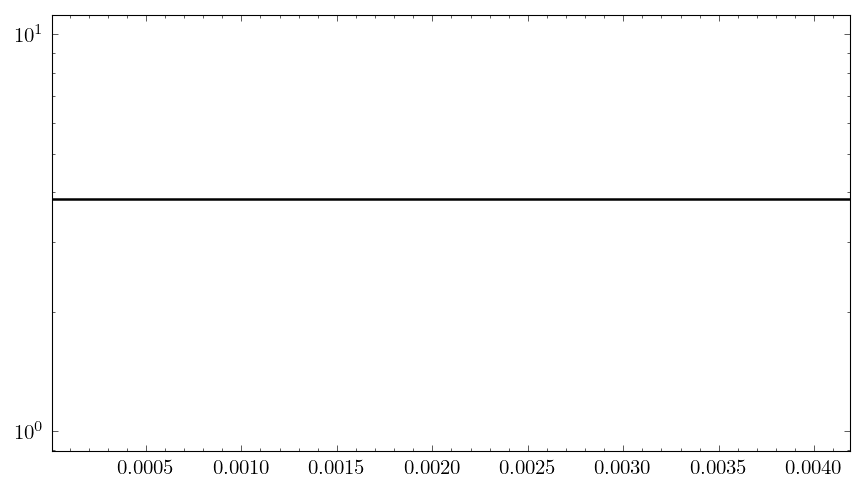

		determining the upper limit
		--->0.17679967775899286

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0130141574905236e-16
		--->'mle_theta_er': 0.9907082444935051
		--->'mle_theta_nr': 1.0771427344712001
		defining the test statistic
		determining the upper limit
		--->0.08927848047825203

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0232886288929678e-16
		--->'mle_theta_er': 0.9898860137511061
		--->'mle_theta_nr': 1.1318235851634775
		defining the test statistic
		test statistic plot


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


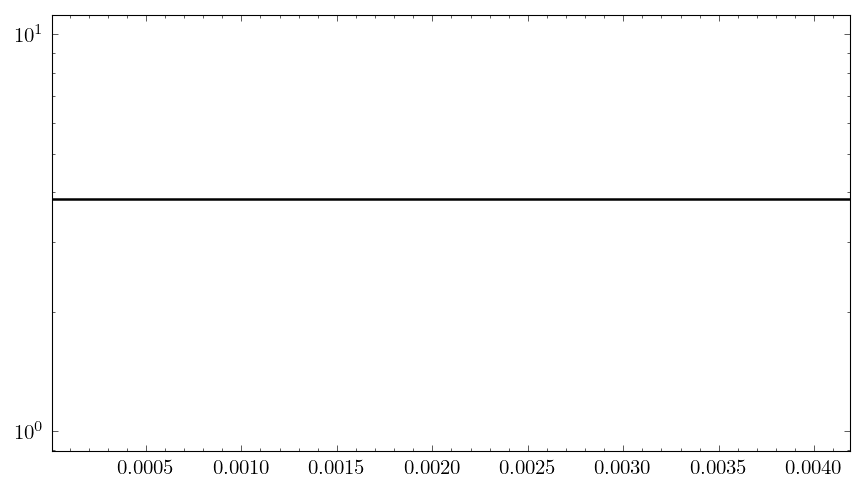

		determining the upper limit
		--->0.17016508146228437

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.571652372821796e-17
		--->'mle_theta_er': 0.9883496255391229
		--->'mle_theta_nr': 1.002042863161607
		defining the test statistic
		determining the upper limit
		--->0.03245723685548295

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.099424713933914e-17
		--->'mle_theta_er': 0.9887089777231021
		--->'mle_theta_nr': 1.1291984514716296
		defining the test statistic
		determining the upper limit
		--->0.05052985120827163

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0678930384022841e-16
		--->'mle_theta_er': 0.994092811820714
		--->'mle_theta_nr': 1.1399828529689353
		defining the test statistic
		determining the upper limit
		--->0.249253351969

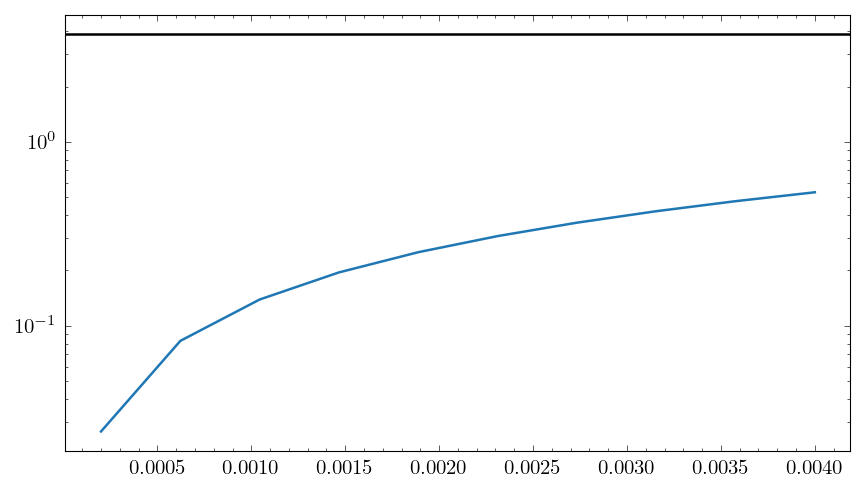

		determining the upper limit
		--->0.02878203331848446

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.512551202737779e-17
		--->'mle_theta_er': 0.9864632536144842
		--->'mle_theta_nr': 1.2029540132998822
		defining the test statistic
		determining the upper limit
		--->0.2238461762005505

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.877543104585731e-17
		--->'mle_theta_er': 0.9861446504677605
		--->'mle_theta_nr': 1.0753844088666966
		defining the test statistic
		determining the upper limit
		--->0.03631485899702018

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.368316541783497e-17
		--->'mle_theta_er': 0.985291800973813
		--->'mle_theta_nr': 1.0781027811457373
		defining the test statistic
		determining the upper limit
		--->0.0339227268464

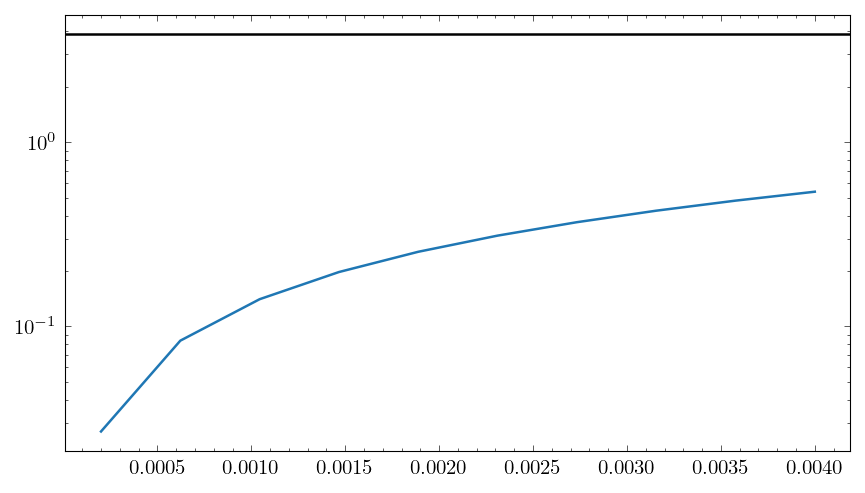

		determining the upper limit
		--->0.028447074427375714

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.230586004277075e-17
		--->'mle_theta_er': 0.9871374139691629
		--->'mle_theta_nr': 1.0841403194836268
		defining the test statistic
		determining the upper limit
		--->0.05696526575659585

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.835355402461022e-17
		--->'mle_theta_er': 0.9868157534708939
		--->'mle_theta_nr': 1.07760513228326
		defining the test statistic
		determining the upper limit
		--->0.03671792409483445

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.565837002246838e-17
		--->'mle_theta_er': 0.9847690123576911
		--->'mle_theta_nr': 1.1465682252724694
		defining the test statistic
		determining the upper limit
		--->0.065142477178

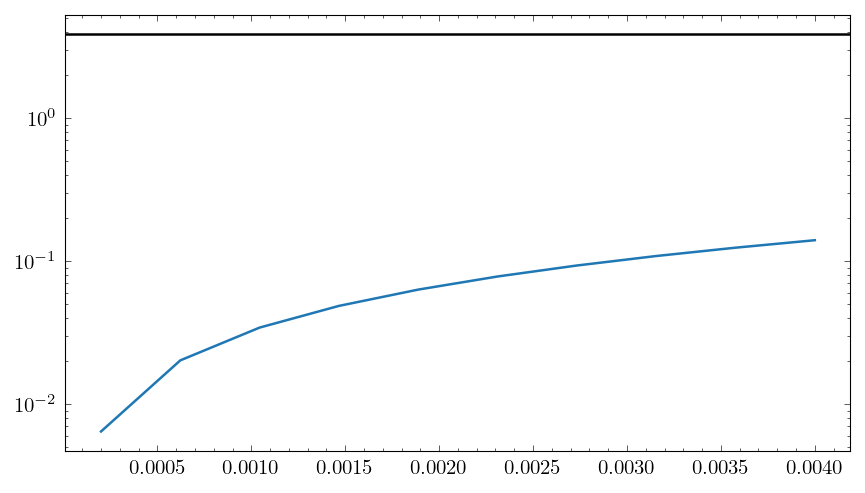

		determining the upper limit
		--->0.06204900730239323
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 0.06204900730239323

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.563020131752825e-17
		--->'mle_theta_er': 0.9836098991043509
		--->'mle_theta_nr': 1.1376285505306494
		defining the test statistic
		determining the upper limit
		--->0.058698809555176916

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.1354269156811026e-16
		--->'mle_theta_er': 0.9920746893851102
		--->'mle_theta_nr': 1.193699278521808
		defining the test statistic
		test statistic plot


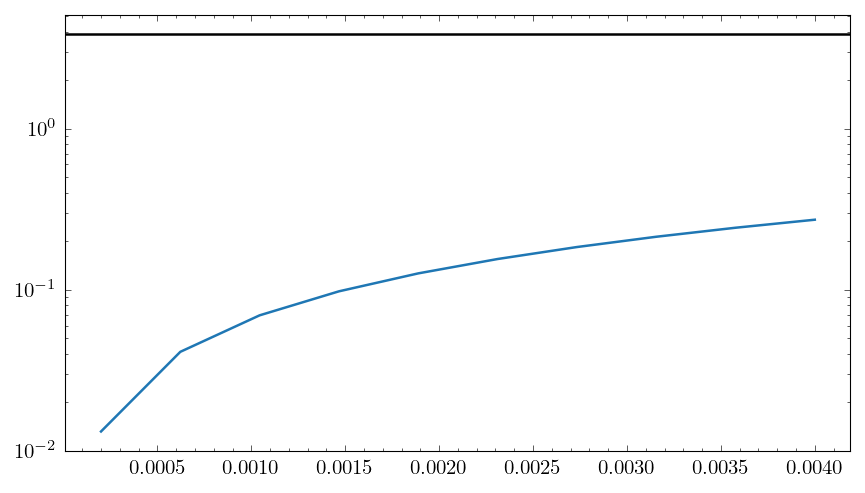

		determining the upper limit
		--->0.0458401810054033

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.164867578487512e-17
		--->'mle_theta_er': 0.9913733020974999
		--->'mle_theta_nr': 1.0817123807004867
		defining the test statistic
		determining the upper limit
		--->0.03267693066779844

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.44798172042177e-17
		--->'mle_theta_er': 0.9875023204653834
		--->'mle_theta_nr': 1.0026780112795646
		defining the test statistic
		test statistic plot


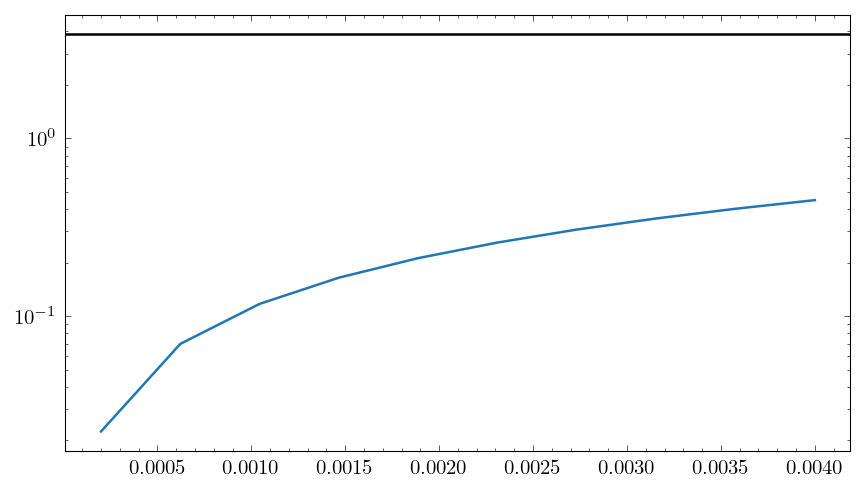

		determining the upper limit
		--->0.03386400117822873

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.375565259318278e-17
		--->'mle_theta_er': 0.9854814304993268
		--->'mle_theta_nr': 1.1920532502298027
		defining the test statistic
		test statistic plot


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


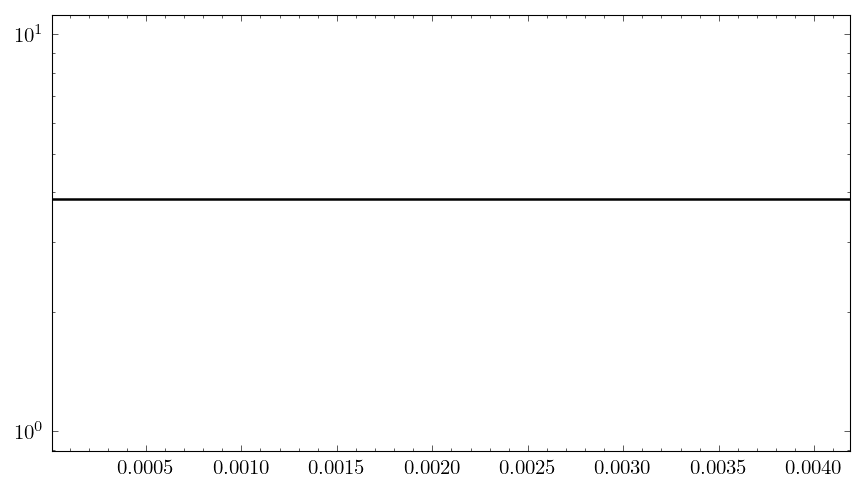

		determining the upper limit
		--->0.20959608115903114

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.052913354774952e-16
		--->'mle_theta_er': 0.99070626096516
		--->'mle_theta_nr': 1.1986017859800278
		defining the test statistic
		determining the upper limit
		--->0.24092234987961256

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.049962908319358e-17
		--->'mle_theta_er': 0.9838845955564248
		--->'mle_theta_nr': 1.0988241280459046
		defining the test statistic
		determining the upper limit
		--->0.0804684489591639

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.544172254614729e-17
		--->'mle_theta_er': 0.9807654733862441
		--->'mle_theta_nr': 1.061504105858046
		defining the test statistic
		determining the upper limit
		--->0.028338120624023

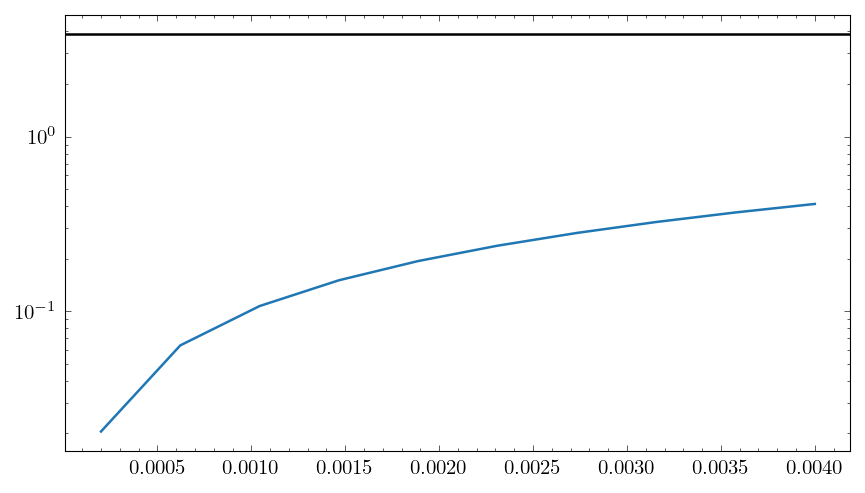

		determining the upper limit
		--->0.03630415915682496

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.639745163955706e-17
		--->'mle_theta_er': 0.9895218004909094
		--->'mle_theta_nr': 1.0779673563777443
		defining the test statistic
		determining the upper limit
		--->0.051656302108785815

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.525668528909985e-17
		--->'mle_theta_er': 0.9851104311779488
		--->'mle_theta_nr': 1.0828774730708726
		defining the test statistic
		determining the upper limit
		--->0.08091378977110052

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.771902471336007e-17
		--->'mle_theta_er': 0.989839544566693
		--->'mle_theta_nr': 1.2053669656461232
		defining the test statistic
		determining the upper limit
		--->0.19508181607

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


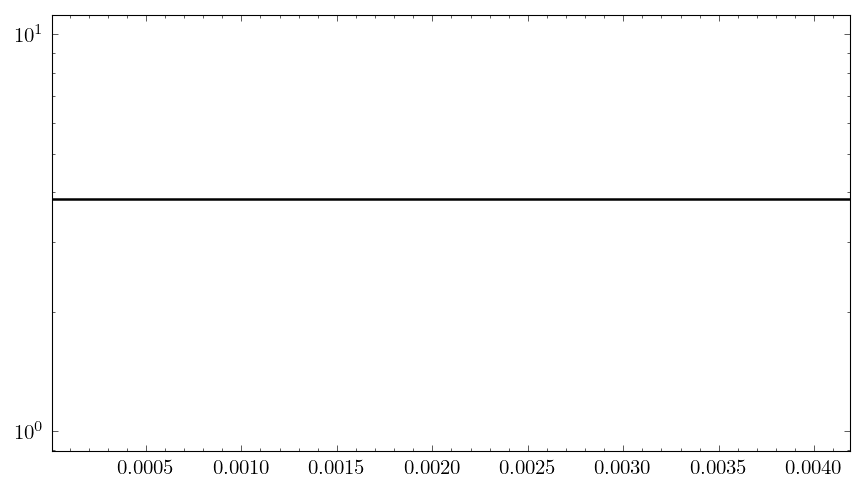

		determining the upper limit
		--->0.17050790709649905
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 11
     iterations: 10
           root: 0.17050790709649905

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.23177591682541e-17
		--->'mle_theta_er': 0.9874950110099261
		--->'mle_theta_nr': 1.0766318202859617
		defining the test statistic
		determining the upper limit
		--->0.02713483822431535

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.80664086376766e-17
		--->'mle_theta_er': 0.9890109814361681
		--->'mle_theta_nr': 1.0792579993600873
		defining the test statistic
		determining the upper limit
		--->0.05523754202993226

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.

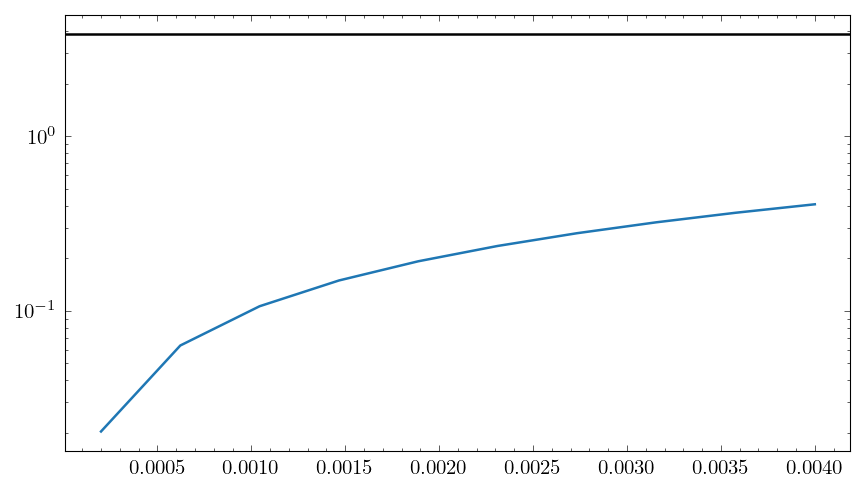

		determining the upper limit
		--->0.03659242246020448

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.227334301518216e-17
		--->'mle_theta_er': 0.9874895806714206
		--->'mle_theta_nr': 1.199306182254042
		defining the test statistic
		determining the upper limit
		--->0.0455443453620642

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.162113606728373e-17
		--->'mle_theta_er': 0.9878118244344458
		--->'mle_theta_nr': 1.20454902001095
		defining the test statistic
		test statistic plot


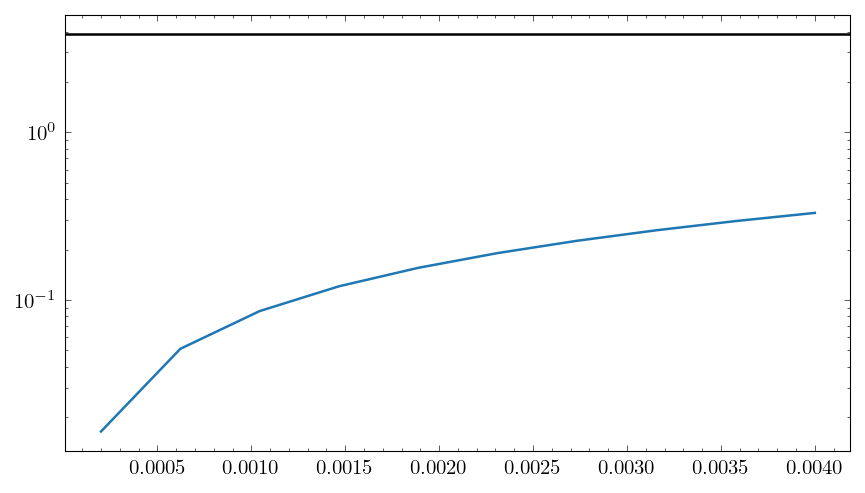

		determining the upper limit
		--->0.0434034078741055

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.645152594805361e-17
		--->'mle_theta_er': 0.9868299400908547
		--->'mle_theta_nr': 1.0720068509449077
		defining the test statistic
		test statistic plot


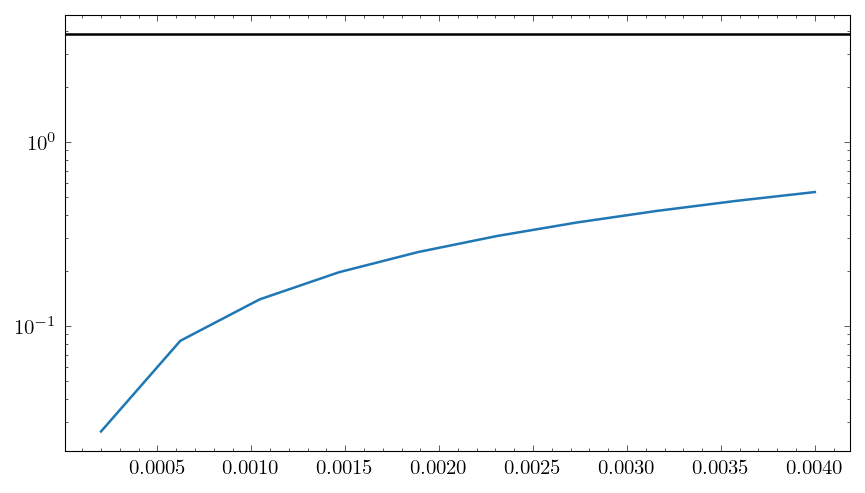

		determining the upper limit
		--->0.02864554487981381

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.708855937427854e-17
		--->'mle_theta_er': 0.9900385882242333
		--->'mle_theta_nr': 1.003364242930306
		defining the test statistic
		determining the upper limit
		--->0.03403547898570956

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.912450627369408e-17
		--->'mle_theta_er': 0.9871569262239996
		--->'mle_theta_nr': 1.1397277067296554
		defining the test statistic
		determining the upper limit
		--->0.03727265529215028

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.725818563241238e-17
		--->'mle_theta_er': 0.9880222321946519
		--->'mle_theta_nr': 1.1327995544219274
		defining the test statistic
		determining the upper limit
		--->0.195179247222

		--->0.03646767510896753
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 8
     iterations: 7
           root: 0.03646767510896753

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.029748705574992e-17
		--->'mle_theta_er': 0.9820866515661143
		--->'mle_theta_nr': 1.1378183839766636
		defining the test statistic
		test statistic plot


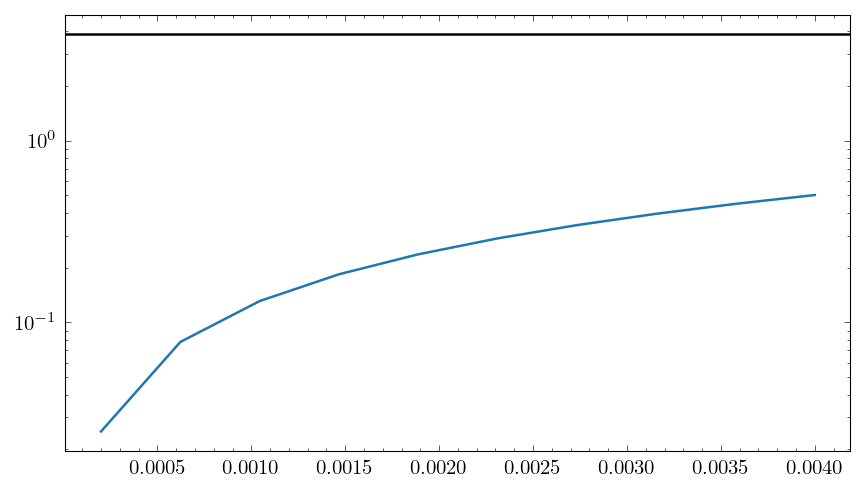

		determining the upper limit
		--->0.030178752608375624

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.304106785440059e-17
		--->'mle_theta_er': 0.9841214602496782
		--->'mle_theta_nr': 1.1361935622549684
		defining the test statistic
		determining the upper limit
		--->0.028665036914138523

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.529193454094186e-17
		--->'mle_theta_er': 0.9851052182456007
		--->'mle_theta_nr': 1.084893841942828
		defining the test statistic
		determining the upper limit
		--->0.036556779787488655

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.913993307638461e-17
		--->'mle_theta_er': 0.9807009249561343
		--->'mle_theta_nr': 1.0869771454122412
		defining the test statistic
		determining the upper limit
		--->0.034453560

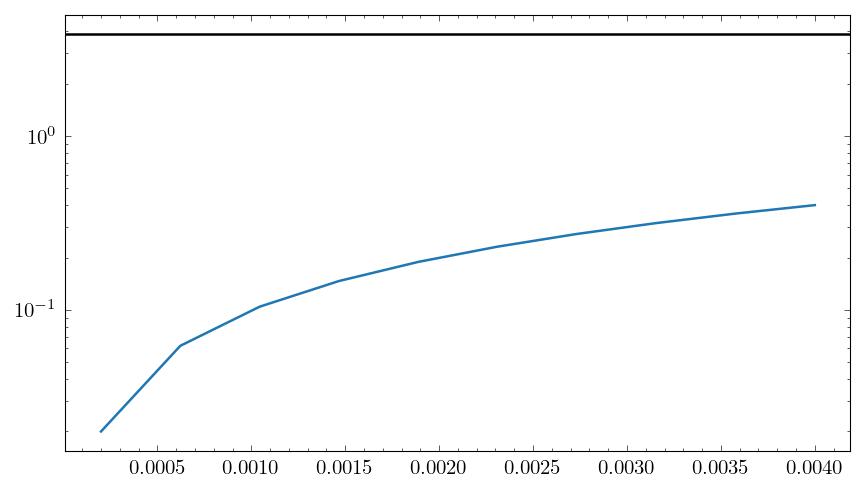

		determining the upper limit
		--->0.03725374914960374

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.194796011189236e-17
		--->'mle_theta_er': 0.9913783059018948
		--->'mle_theta_nr': 1.0797590251857239
		defining the test statistic
		test statistic plot


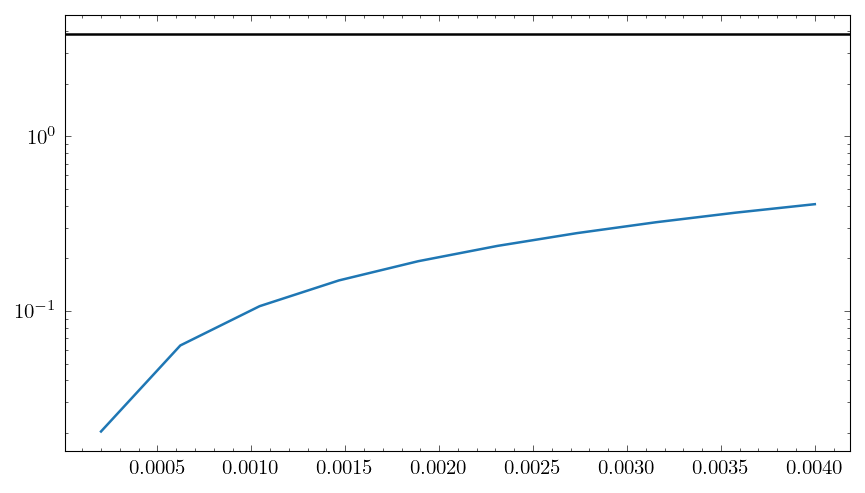

		determining the upper limit
		--->0.03650343344171872

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.342076529754229e-17
		--->'mle_theta_er': 0.9868140830845269
		--->'mle_theta_nr': 1.141314996475023
		defining the test statistic
		determining the upper limit
		--->0.05967167788315085

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.577257214893248e-17
		--->'mle_theta_er': 0.9847673224328622
		--->'mle_theta_nr': 1.2042777553920168
		defining the test statistic
		determining the upper limit
		--->0.19567781238113008

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0098978750428473e-16
		--->'mle_theta_er': 0.9900604179524249
		--->'mle_theta_nr': 1.129924614087713
		defining the test statistic
		determining the upper limit
		--->0.039796761992

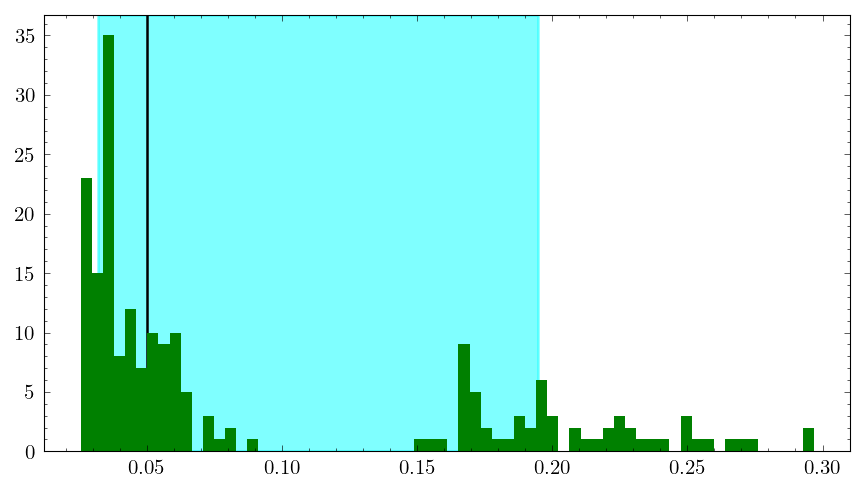

cwpec: starting WIMP mass loop with k=1/20 for 12.74 GeV
	calculating the PDF of the WIMP spectrum within the binned observable space
		calculating 'integral_spectrum_dict' for the high-statistics WIMP spectrum
######################### starting integration #########################
######################### finishing integration #########################

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:1614: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  expected_number_of_events_float_per_energy_bin = [exposure_t_y *integrate.quad(



		generating the high-statistics WIMP signature by executing NEST
		calculating the PDF
		updating the 'spectrum_components_dict'
		deleting the high-statistics WIMP signature
		plotting spectral PDF for 'wimps'


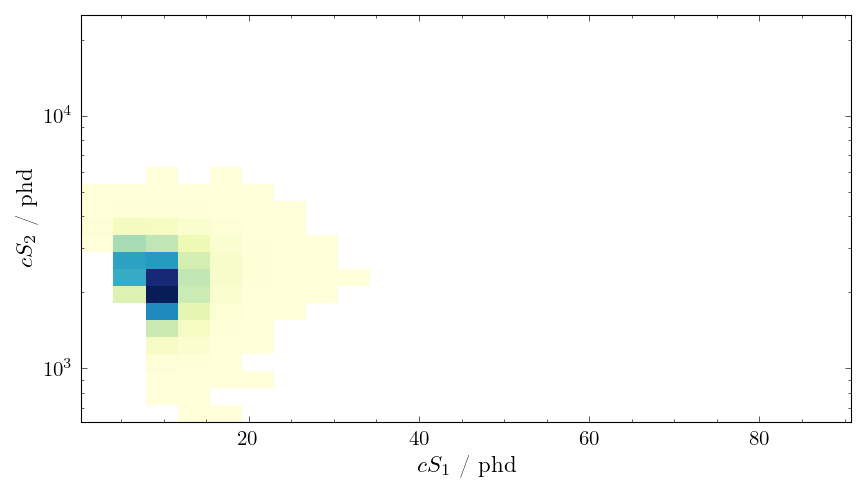

		finished within 2:02:44.102486 h'
	calculating the expected number of WIMP events within the binned observable space
		calculating the number of WIMP events expected within the WIMP EROI
######################### starting integration #########################
######################### finishing integration #########################
		updating the 'spectrum_components_dict'
		finished within 0:02:12.139122 h'
	simulating 200 background-only datasets
		generating the 'spectrum_dict's
######################### starting integration #########################
######################### finishing integration #########################
######################### starting integration #########################
######################### finishing integration #########################
		generating the ER and NR background 'signature's
	calculating the maximum likelihood parameter estimators

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
	

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


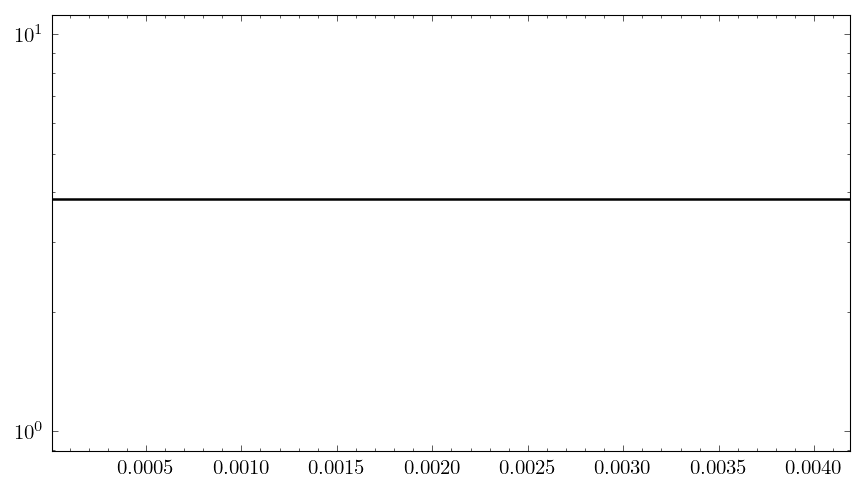

		determining the upper limit
		--->0.036541098579715506

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.385396797536652e-17
		--->'mle_theta_er': 0.9871724175681491
		--->'mle_theta_nr': 1.1923419989540145
		defining the test statistic
		test statistic plot


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


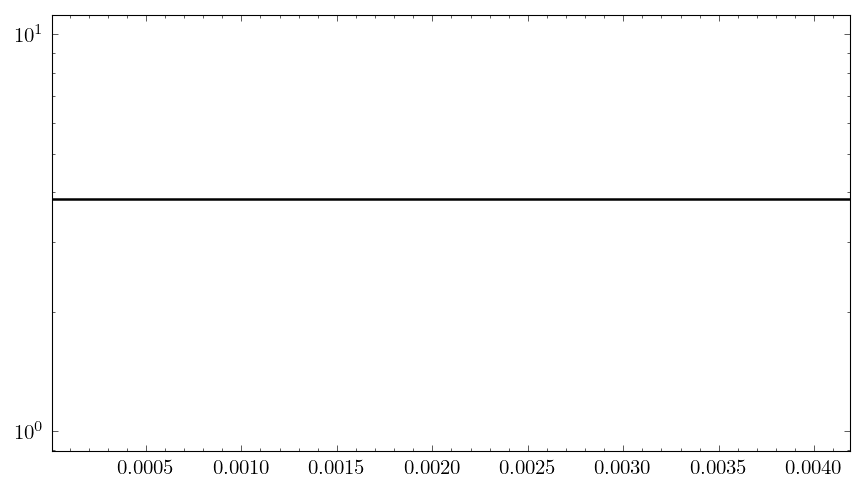

		determining the upper limit
		--->0.021433608893357003

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.960476021313205e-17
		--->'mle_theta_er': 0.9914231965217924
		--->'mle_theta_nr': 1.0619365344834324
		defining the test statistic
		determining the upper limit
		--->0.011721981257498243

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0720281516559789e-16
		--->'mle_theta_er': 0.9913814006721486
		--->'mle_theta_nr': 1.1991234037684162
		defining the test statistic
		determining the upper limit
		--->0.010556705769194359

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.085819943691394e-17
		--->'mle_theta_er': 0.9905782324708221
		--->'mle_theta_nr': 1.1262121237503995
		defining the test statistic
		determining the upper limit
		--->0.0122256

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


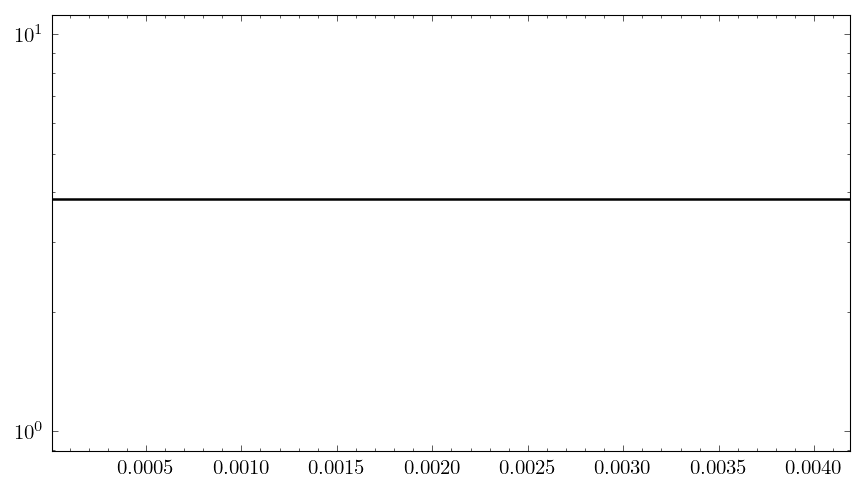

		determining the upper limit
		--->0.011238902377056513

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.229539651636673e-17
		--->'mle_theta_er': 0.9881834843337314
		--->'mle_theta_nr': 1.1936850868810815
		defining the test statistic
		determining the upper limit
		--->0.02334274762244086

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.577718727967657e-17
		--->'mle_theta_er': 0.9871686115019127
		--->'mle_theta_nr': 1.0005769788180752
		defining the test statistic
		determining the upper limit
		--->0.004176299461525105

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.057567722059676e-17
		--->'mle_theta_er': 0.9934328498526166
		--->'mle_theta_nr': 1.1339882575820606
		defining the test statistic
		determining the upper limit
		--->0.011206743

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


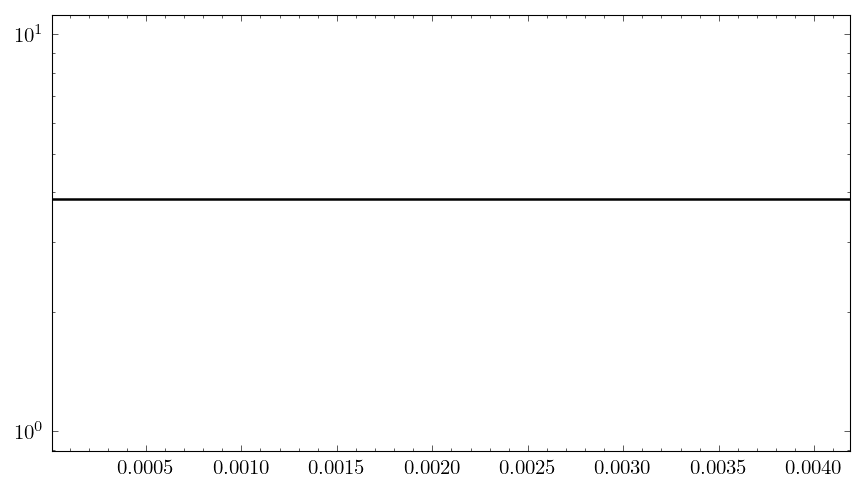

		determining the upper limit
		--->0.013460621484040185

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.1053218453210776e-16
		--->'mle_theta_er': 0.9922261489587325
		--->'mle_theta_nr': 1.2527880783171974
		defining the test statistic
		determining the upper limit
		--->0.01809172100281873

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.090754315238014e-17
		--->'mle_theta_er': 0.9895518873754751
		--->'mle_theta_nr': 1.1887594645470787
		defining the test statistic
		determining the upper limit
		--->0.02333010131613048

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.676365910959715e-17
		--->'mle_theta_er': 0.984969688638406
		--->'mle_theta_nr': 1.1934384216617333
		defining the test statistic
		determining the upper limit
		--->0.0126479970

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


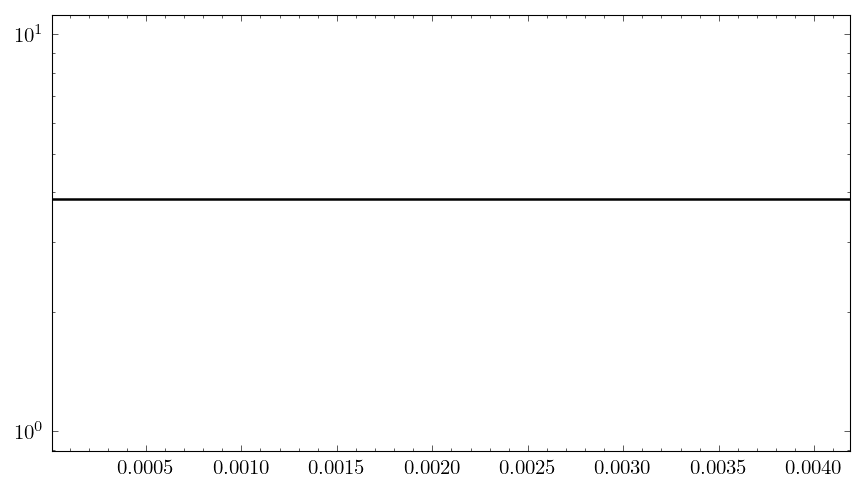

		determining the upper limit
		--->0.011947009419857633

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.1608677179129177e-16
		--->'mle_theta_er': 0.9949388753595638
		--->'mle_theta_nr': 1.1976165281875744
		defining the test statistic
		test statistic plot


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


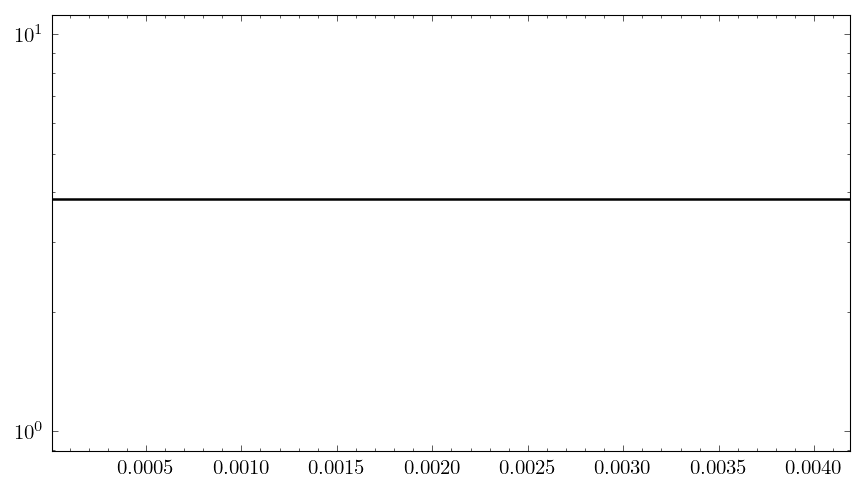

		determining the upper limit
		--->0.025349433152737334
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 13
     iterations: 12
           root: 0.025349433152737334

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.1822333146902187e-16
		--->'mle_theta_er': 0.9941167819605802
		--->'mle_theta_nr': 1.2437445797159175
		defining the test statistic
		determining the upper limit
		--->0.028763558326002865

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.329113922504527e-17
		--->'mle_theta_er': 0.9903773438176864
		--->'mle_theta_nr': 1.1376326877045182
		defining the test statistic
		determining the upper limit
		--->0.014288024235600787

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sig

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


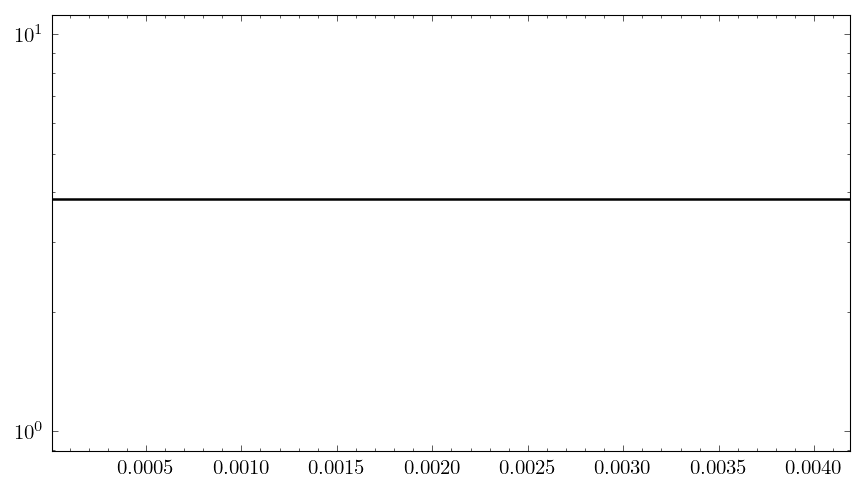

		determining the upper limit
		--->0.04285067771009398

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.373151964268377e-17
		--->'mle_theta_er': 0.9902235950858469
		--->'mle_theta_nr': 1.1904237036851049
		defining the test statistic
		test statistic plot


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


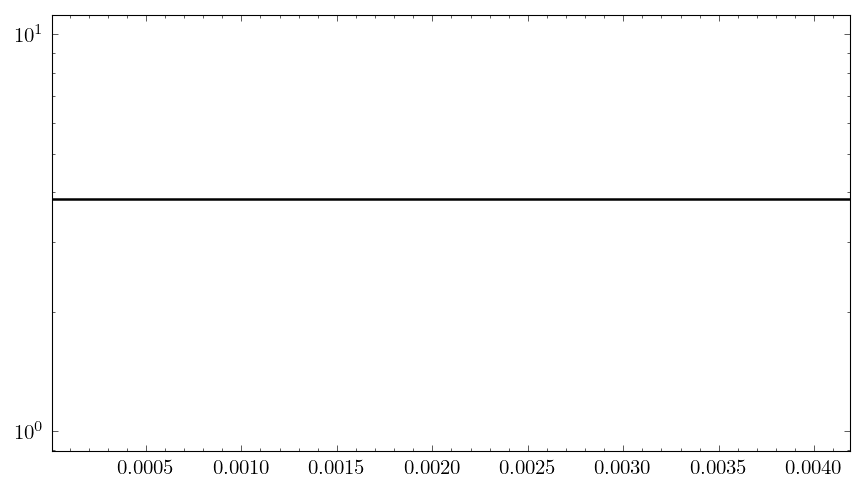

		determining the upper limit
		--->0.01223165655109392

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0243932067561135e-16
		--->'mle_theta_er': 0.9937367056273911
		--->'mle_theta_nr': 1.1462739993914906
		defining the test statistic
		determining the upper limit
		--->0.012287836484780578

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.910420215537263e-17
		--->'mle_theta_er': 0.9858353968849628
		--->'mle_theta_nr': 1.1282602000392594
		defining the test statistic
		determining the upper limit
		--->0.01273195097650536

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.8250709776803e-17
		--->'mle_theta_er': 0.9893861685013403
		--->'mle_theta_nr': 1.1290228850469368
		defining the test statistic
		determining the upper limit
		--->0.02839879691

		--->'mle_sigma': 1.0466382157351384e-16
		--->'mle_theta_er': 0.9944489388465353
		--->'mle_theta_nr': 1.0697622341919266
		defining the test statistic
		determining the upper limit
		--->0.010618811261467293

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.506699067786428e-17
		--->'mle_theta_er': 0.9910698506582363
		--->'mle_theta_nr': 1.1319758896399392
		defining the test statistic
		determining the upper limit
		--->0.012434361117502792

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0717919579165273e-16
		--->'mle_theta_er': 0.9927369613585709
		--->'mle_theta_nr': 1.1984516347372396
		defining the test statistic
		determining the upper limit
		--->0.023129355401416453
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 12
     iterations: 11
      

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


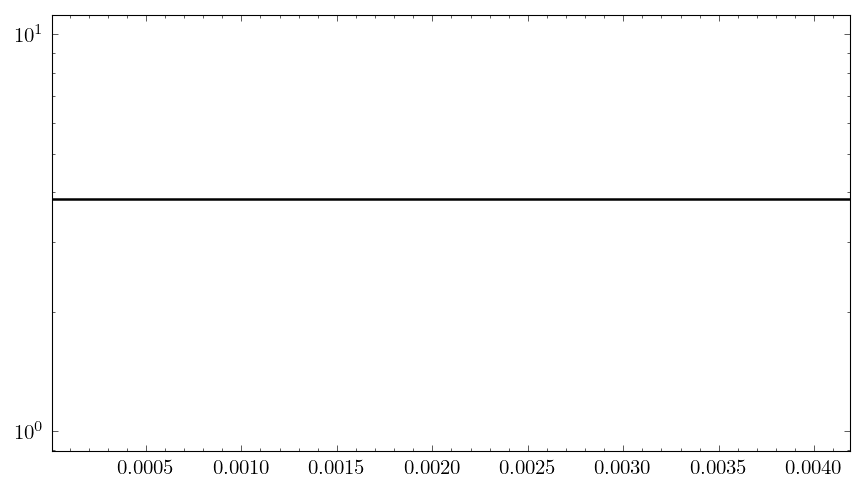

		determining the upper limit
		--->0.009787793277987178

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0571991353687772e-16
		--->'mle_theta_er': 0.9908796762181904
		--->'mle_theta_nr': 1.1972131883647972
		defining the test statistic
		test statistic plot


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


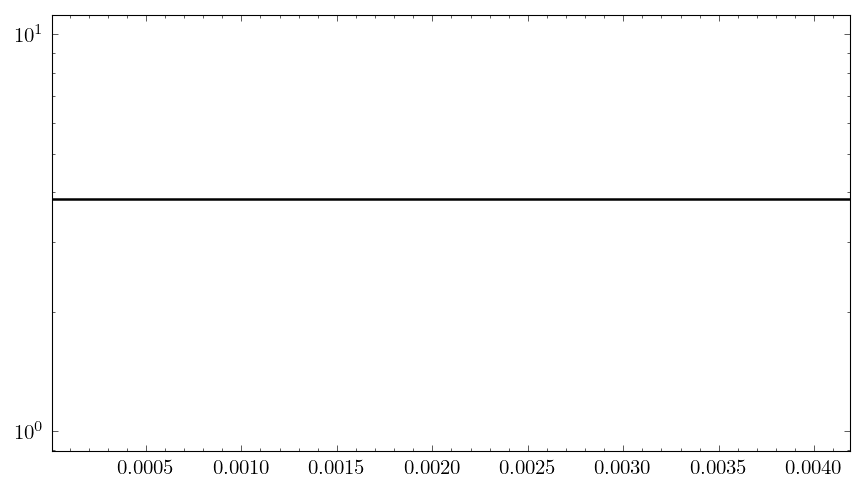

		determining the upper limit
		--->0.022716225840399073
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 13
     iterations: 12
           root: 0.022716225840399073

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0204192136756621e-16
		--->'mle_theta_er': 0.9927868942377794
		--->'mle_theta_nr': 1.1228395580803787
		defining the test statistic
		determining the upper limit
		--->0.01983042151708476

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0935481541863622e-16
		--->'mle_theta_er': 0.9915663864514419
		--->'mle_theta_nr': 1.2476047754909168
		defining the test statistic
		determining the upper limit
		--->0.03301860000280299

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigm

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


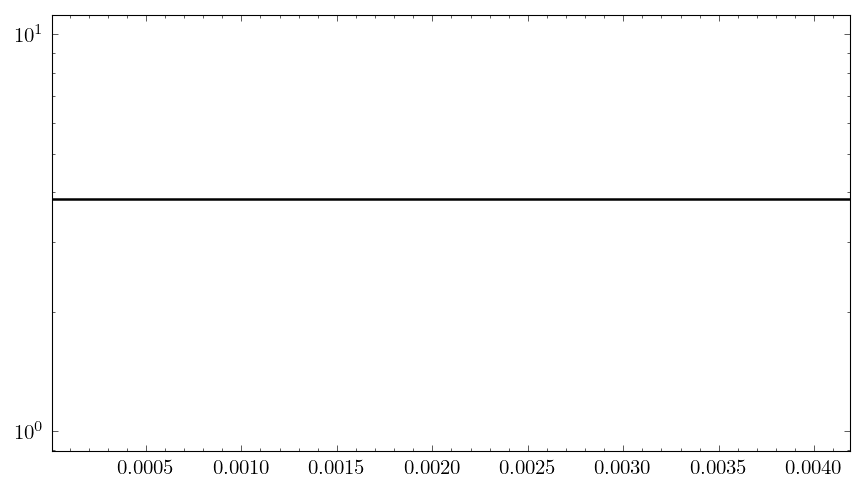

		determining the upper limit
		--->0.025566530341896956

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.2029629562551506e-16
		--->'mle_theta_er': 0.9942777881211018
		--->'mle_theta_nr': 1.2462511324361416
		defining the test statistic
		determining the upper limit
		--->0.022868691638726662

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0849003352815628e-16
		--->'mle_theta_er': 0.9907030775789081
		--->'mle_theta_nr': 1.2529143657473938
		defining the test statistic
		determining the upper limit
		--->0.01095436740939015

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0692926710328184e-16
		--->'mle_theta_er': 0.9917390079244139
		--->'mle_theta_nr': 1.1928173370495707
		defining the test statistic
		determining the upper limit
		--->0.021464

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


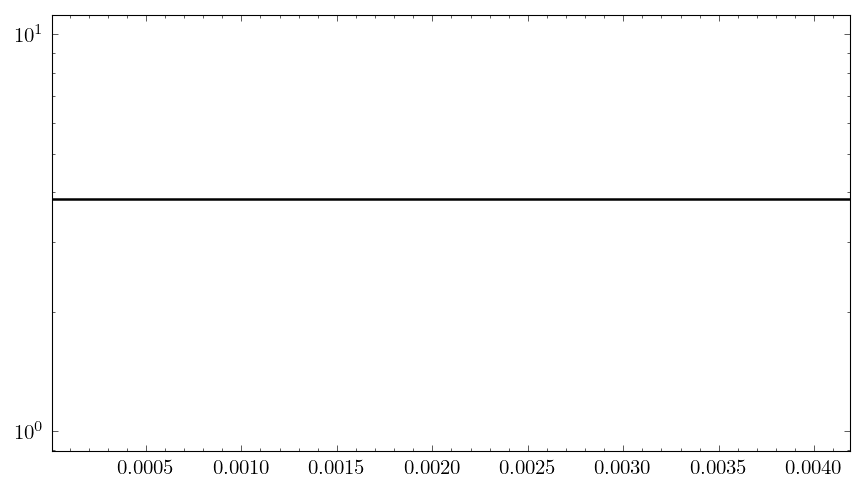

		determining the upper limit
		--->0.017382664245114764

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0454098075138266e-16
		--->'mle_theta_er': 0.9912347740561922
		--->'mle_theta_nr': 1.191719584518034
		defining the test statistic
		test statistic plot


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


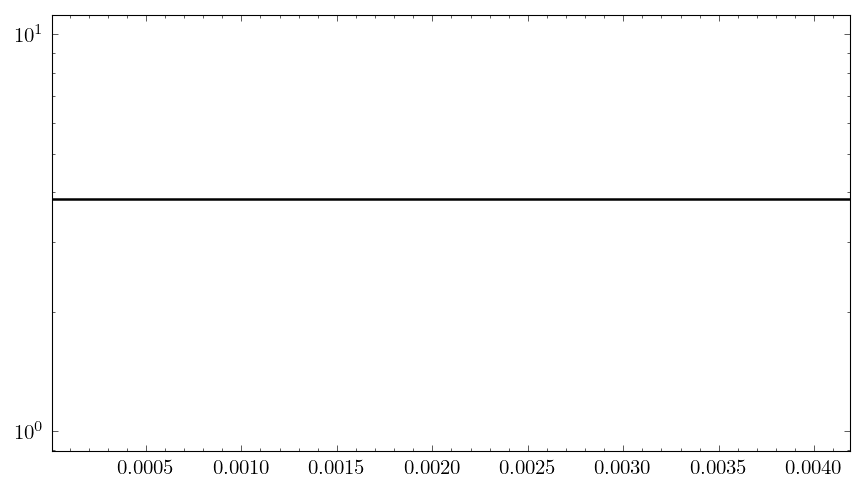

		determining the upper limit
		--->0.02160227835648195

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0767845718756887e-16
		--->'mle_theta_er': 0.9925653557056731
		--->'mle_theta_nr': 1.302404799794405
		defining the test statistic
		determining the upper limit
		--->0.033641737937369826

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.1821761134868622e-16
		--->'mle_theta_er': 0.9952684565498984
		--->'mle_theta_nr': 1.253703875543299
		defining the test statistic
		determining the upper limit
		--->0.014397526619975998

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.477926484260425e-17
		--->'mle_theta_er': 0.9986773093352399
		--->'mle_theta_nr': 1.1340673335085771
		defining the test statistic
		determining the upper limit
		--->0.011896174

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


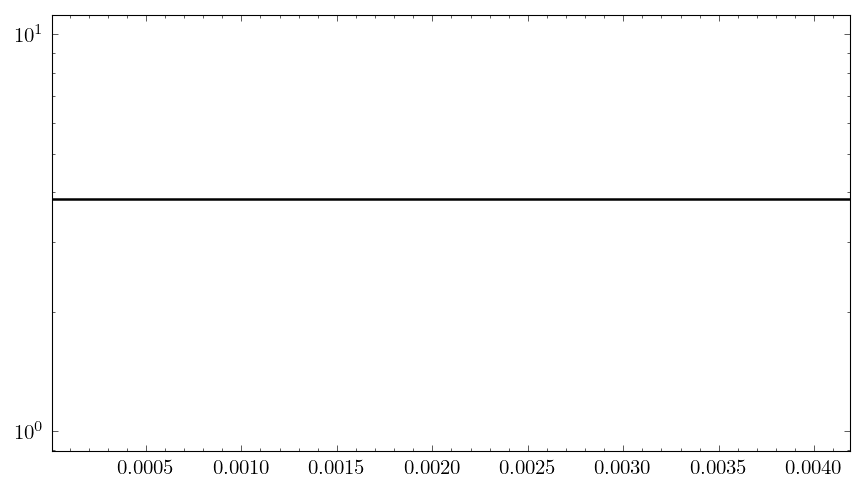

		determining the upper limit
		--->0.010890215408658753

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.151881533493031e-16
		--->'mle_theta_er': 0.9947726717323955
		--->'mle_theta_nr': 1.1388785725149733
		defining the test statistic
		determining the upper limit
		--->0.026195812993717156

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0458927096021552e-16
		--->'mle_theta_er': 0.9925720277418074
		--->'mle_theta_nr': 1.139311751592956
		defining the test statistic
		determining the upper limit
		--->0.004835097624562069

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0277067167307731e-16
		--->'mle_theta_er': 0.9930916748609337
		--->'mle_theta_nr': 1.1349960292843386
		defining the test statistic
		determining the upper limit
		--->0.0128196

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


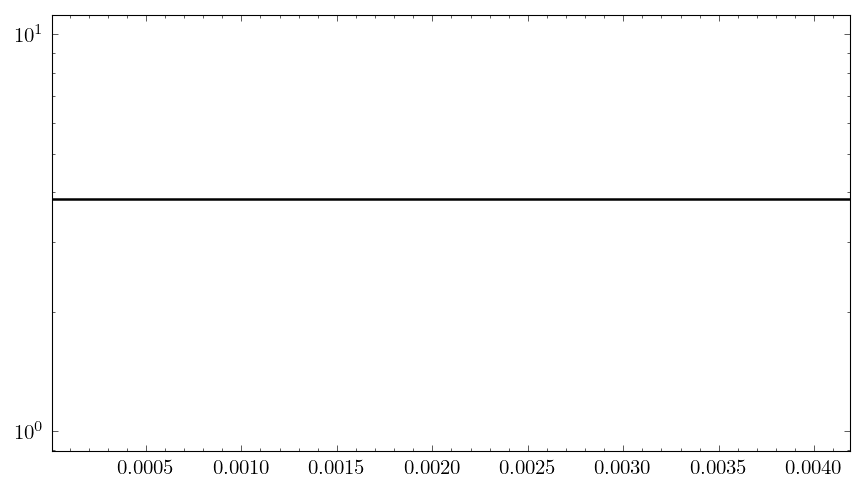

		determining the upper limit
		--->0.009530570336301803

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.892697040739124e-17
		--->'mle_theta_er': 0.9897153244993386
		--->'mle_theta_nr': 1.1323497180342168
		defining the test statistic
		determining the upper limit
		--->0.02813372109959203

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.818142420926427e-17
		--->'mle_theta_er': 0.9883406548767549
		--->'mle_theta_nr': 1.2510380671270198
		defining the test statistic
		determining the upper limit
		--->0.02653770871339114

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.162855354422329e-16
		--->'mle_theta_er': 0.9951260913346445
		--->'mle_theta_nr': 1.0696031672605448
		defining the test statistic
		determining the upper limit
		--->0.0142841152

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


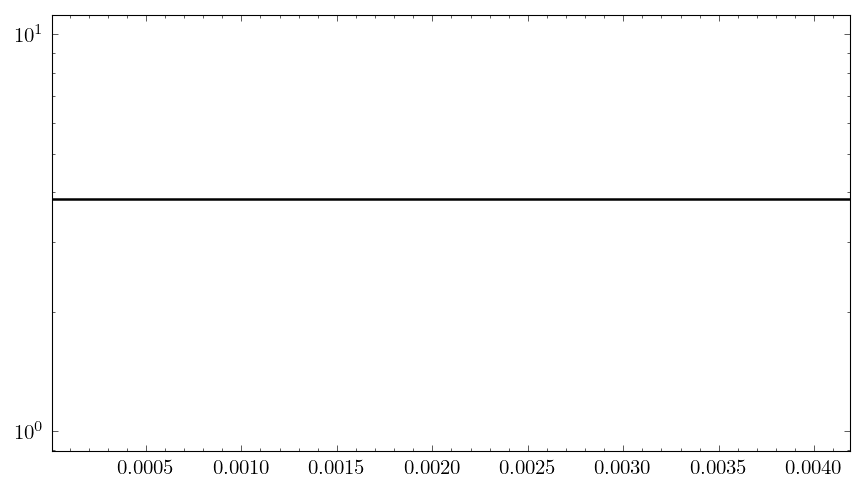

		determining the upper limit
		--->0.02486461898830164

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.888368910381974e-17
		--->'mle_theta_er': 0.9976415130736708
		--->'mle_theta_nr': 1.141467884897025
		defining the test statistic
		determining the upper limit
		--->0.013896963395106038

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.056174892357789e-17
		--->'mle_theta_er': 0.9912537480101884
		--->'mle_theta_nr': 1.0620372149294224
		defining the test statistic
		determining the upper limit
		--->0.009192451050193586

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.195310925544008e-17
		--->'mle_theta_er': 0.9891604325447261
		--->'mle_theta_nr': 1.206129043797227
		defining the test statistic
		determining the upper limit
		--->0.02291070207

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


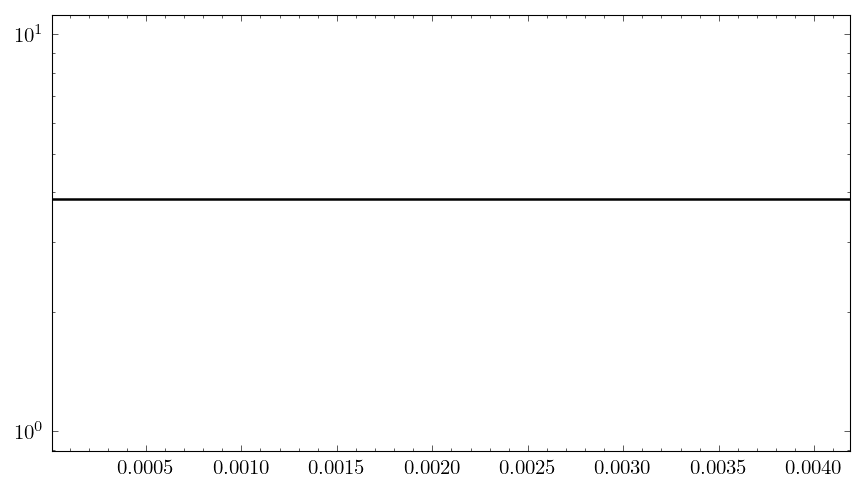

		determining the upper limit
		--->0.012396985420784132

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.040281206877791e-16
		--->'mle_theta_er': 0.9880274297829499
		--->'mle_theta_nr': 1.0667586910787046
		defining the test statistic
		determining the upper limit
		--->0.01109719269365067

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0546522633296804e-16
		--->'mle_theta_er': 0.9925861497755618
		--->'mle_theta_nr': 1.134262641136317
		defining the test statistic
		determining the upper limit
		--->0.017585491912781356

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.1015681038406852e-16
		--->'mle_theta_er': 0.9932740900106825
		--->'mle_theta_nr': 1.242740312305001
		defining the test statistic
		determining the upper limit
		--->0.041168849

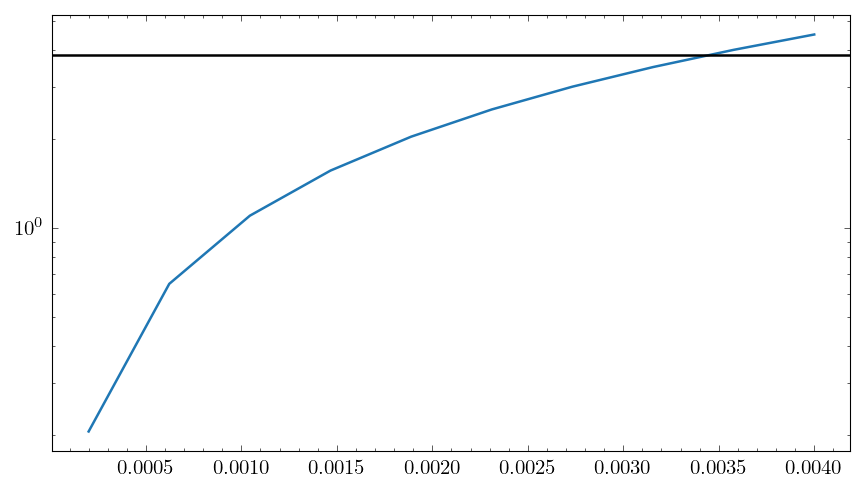

		determining the upper limit
		--->0.0034497330025480256

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.938646242120221e-17
		--->'mle_theta_er': 0.9897159534098807
		--->'mle_theta_nr': 1.0680976728888645
		defining the test statistic
		test statistic plot


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


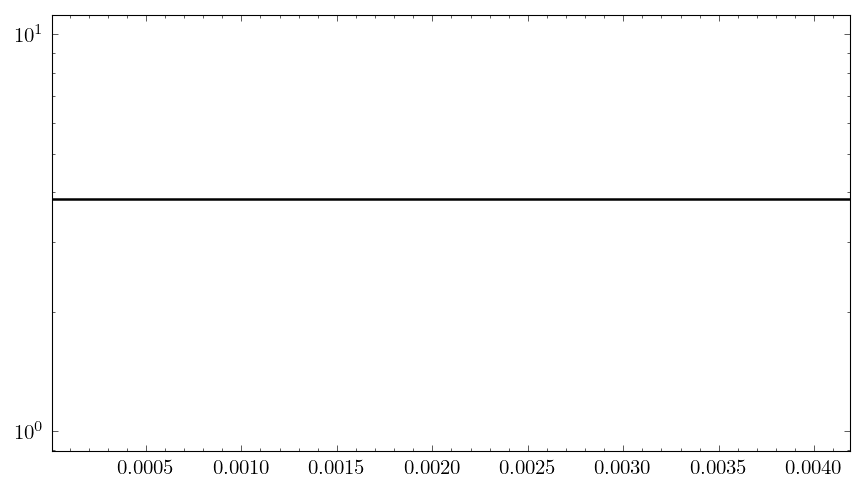

		determining the upper limit
		--->0.010171653763418758

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0639930962605662e-16
		--->'mle_theta_er': 0.9944250132380152
		--->'mle_theta_nr': 1.1421710832496714
		defining the test statistic
		determining the upper limit
		--->0.015334487664598802

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.229684118467748e-17
		--->'mle_theta_er': 0.9888452555456531
		--->'mle_theta_nr': 1.2519407675034526
		defining the test statistic
		determining the upper limit
		--->0.02588027515552857

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.090017718887037e-16
		--->'mle_theta_er': 0.9919081398176746
		--->'mle_theta_nr': 1.1347234037400633
		defining the test statistic
		determining the upper limit
		--->0.00552875

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


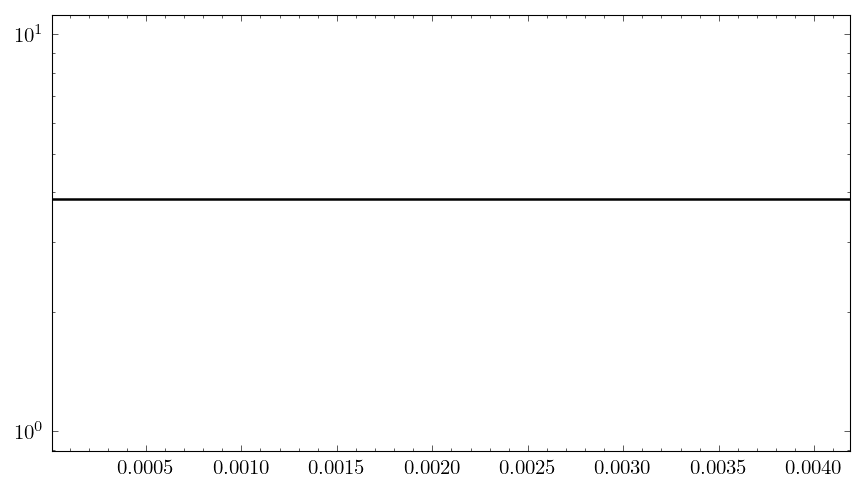

		determining the upper limit
		--->0.014983502917964726

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.879234283139344e-17
		--->'mle_theta_er': 0.9902108848210107
		--->'mle_theta_nr': 1.0731041149328568
		defining the test statistic
		determining the upper limit
		--->0.014356558013908668

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.100912014698849e-16
		--->'mle_theta_er': 0.9915453244496398
		--->'mle_theta_nr': 1.254030175663348
		defining the test statistic
		determining the upper limit
		--->0.014256060152975552

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0507988802044274e-16
		--->'mle_theta_er': 0.9908954627295335
		--->'mle_theta_nr': 1.069997545823492
		defining the test statistic
		determining the upper limit
		--->0.013214772

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


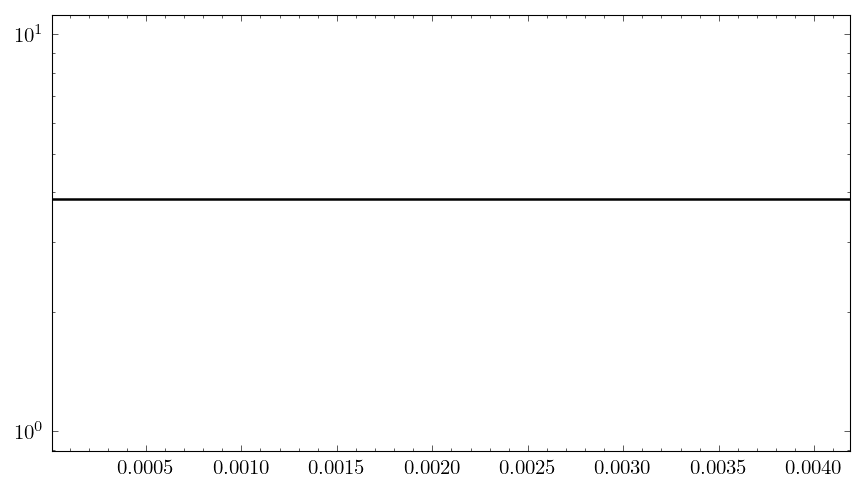

		determining the upper limit
		--->0.025362715300454322

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.384521252427269e-17
		--->'mle_theta_er': 0.9905581538301302
		--->'mle_theta_nr': 1.0695860039667235
		defining the test statistic
		determining the upper limit
		--->0.01270463990492532

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.84809444194789e-17
		--->'mle_theta_er': 0.9883737337443004
		--->'mle_theta_nr': 1.1280547312152067
		defining the test statistic
		determining the upper limit
		--->0.003366215102619247

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.1641168554029798e-16
		--->'mle_theta_er': 0.9947847021549509
		--->'mle_theta_nr': 1.1345680375800864
		defining the test statistic
		determining the upper limit
		--->0.033649015

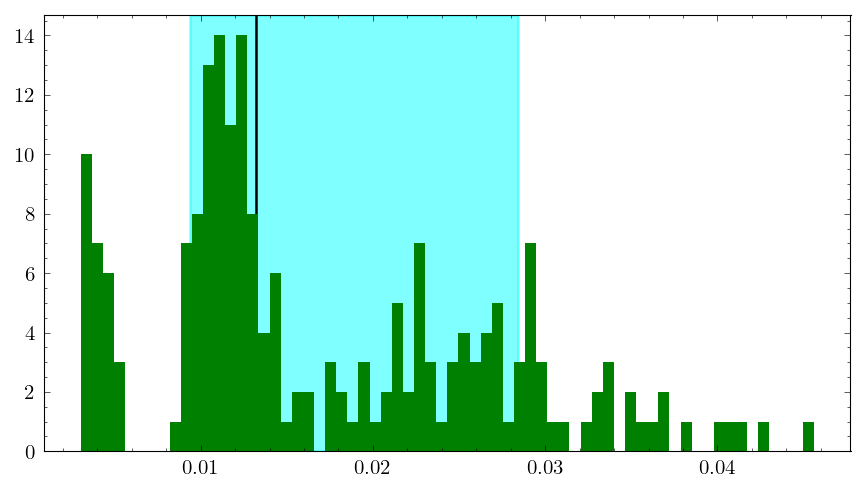

cwpec: starting WIMP mass loop with k=2/20 for 16.24 GeV
	calculating the PDF of the WIMP spectrum within the binned observable space
		calculating 'integral_spectrum_dict' for the high-statistics WIMP spectrum
######################### starting integration #########################


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:1614: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  expected_number_of_events_float_per_energy_bin = [exposure_t_y *integrate.quad(


######################### finishing integration #########################
		generating the high-statistics WIMP signature by executing NEST
		calculating the PDF
		updating the 'spectrum_components_dict'
		deleting the high-statistics WIMP signature
		plotting spectral PDF for 'wimps'


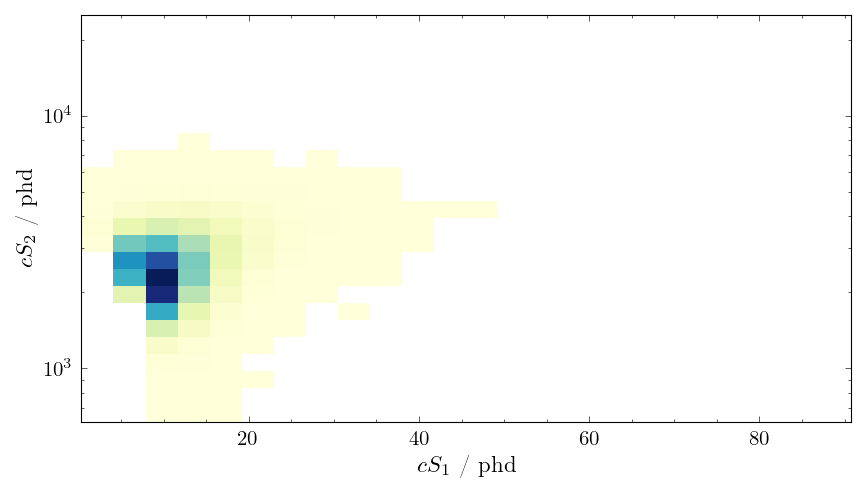

		finished within 2:31:17.194970 h'
	calculating the expected number of WIMP events within the binned observable space
		calculating the number of WIMP events expected within the WIMP EROI
######################### starting integration #########################
######################### finishing integration #########################
		updating the 'spectrum_components_dict'
		finished within 0:06:24.918800 h'
	simulating 200 background-only datasets
		generating the 'spectrum_dict's
######################### starting integration #########################
######################### finishing integration #########################
######################### starting integration #########################
######################### finishing integration #########################
		generating the ER and NR background 'signature's
	calculating the maximum likelihood parameter estimators

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
	

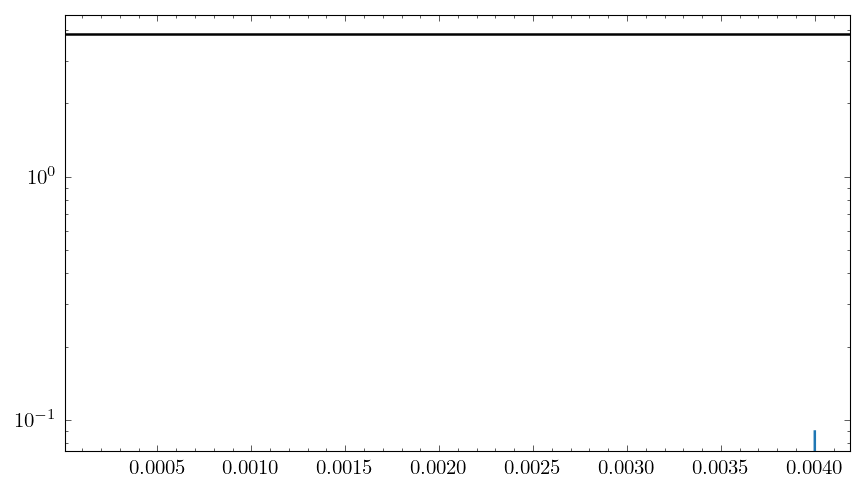

		determining the upper limit
		--->0.004706551036717195

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.932264491392352e-17
		--->'mle_theta_er': 1.007771098522034
		--->'mle_theta_nr': 1.086717003888198
		defining the test statistic
		determining the upper limit
		--->0.004082112813643104

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.378414962719017e-17
		--->'mle_theta_er': 1.0024993347575637
		--->'mle_theta_nr': 1.1584616469131728
		defining the test statistic
		determining the upper limit
		--->0.008882654789295414
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 14
     iterations: 13
           root: 0.008882654789295414

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma'

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


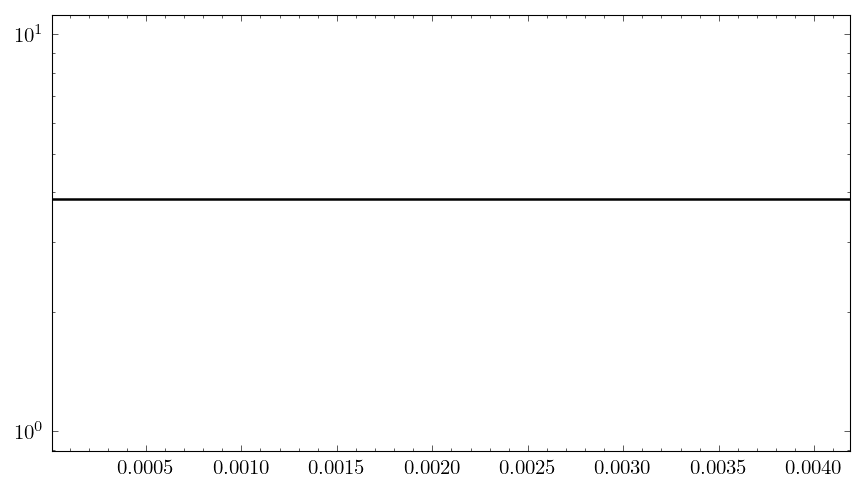

		determining the upper limit
		--->0.006200280454458174

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0259315434245557e-16
		--->'mle_theta_er': 1.0040234958219272
		--->'mle_theta_nr': 1.157919223373694
		defining the test statistic
		determining the upper limit
		--->0.00897550023574505

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0586287142206384e-16
		--->'mle_theta_er': 1.0061013232337697
		--->'mle_theta_nr': 1.198791608275245
		defining the test statistic
		determining the upper limit
		--->0.010493973814449536

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0155891636217939e-16
		--->'mle_theta_er': 1.003874384917352
		--->'mle_theta_nr': 1.0888791542467742
		defining the test statistic
		determining the upper limit
		--->0.001641196

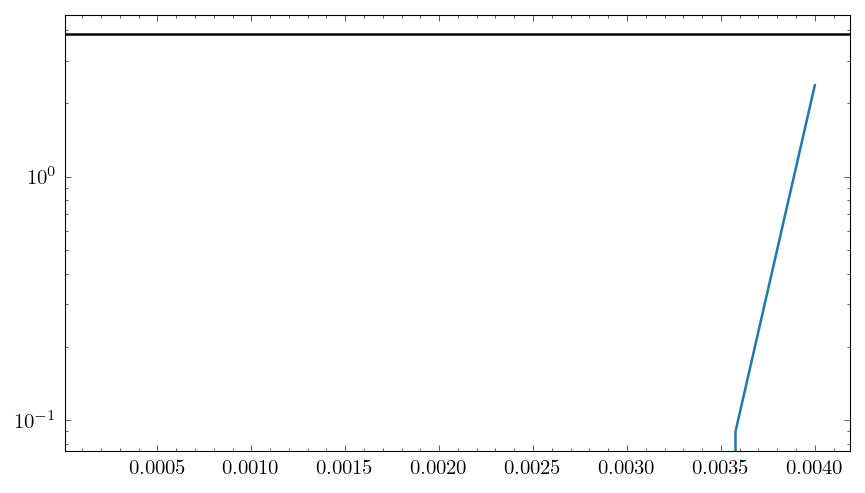

		determining the upper limit
		--->0.004260605471641297

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.619983209217812e-17
		--->'mle_theta_er': 1.0028027164458275
		--->'mle_theta_nr': 1.1103024151394276
		defining the test statistic
		determining the upper limit
		--->0.007508504762817954

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0000771165409404e-16
		--->'mle_theta_er': 1.0052207741817445
		--->'mle_theta_nr': 1.091579171975264
		defining the test statistic
		determining the upper limit
		--->0.0037068538663445156

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.565532213141999e-17
		--->'mle_theta_er': 1.0050671747220172
		--->'mle_theta_nr': 1.0160771511593345
		defining the test statistic
		determining the upper limit
		--->0.0025312

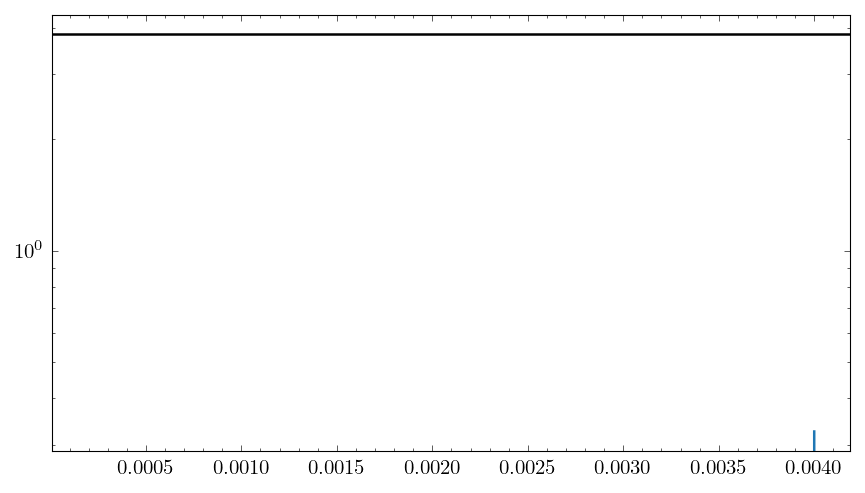

		determining the upper limit
		--->0.004782879423660685

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0184566567852622e-16
		--->'mle_theta_er': 0.9998134559949234
		--->'mle_theta_nr': 1.08908031765967
		defining the test statistic
		determining the upper limit
		--->0.004425947050682565

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.746276816948836e-17
		--->'mle_theta_er': 1.0048249506547235
		--->'mle_theta_nr': 1.1731529950164403
		defining the test statistic
		determining the upper limit
		--->0.009499683880437423

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0063484125656526e-16
		--->'mle_theta_er': 1.0058828707581702
		--->'mle_theta_nr': 1.097174053806881
		defining the test statistic
		determining the upper limit
		--->0.006026411

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


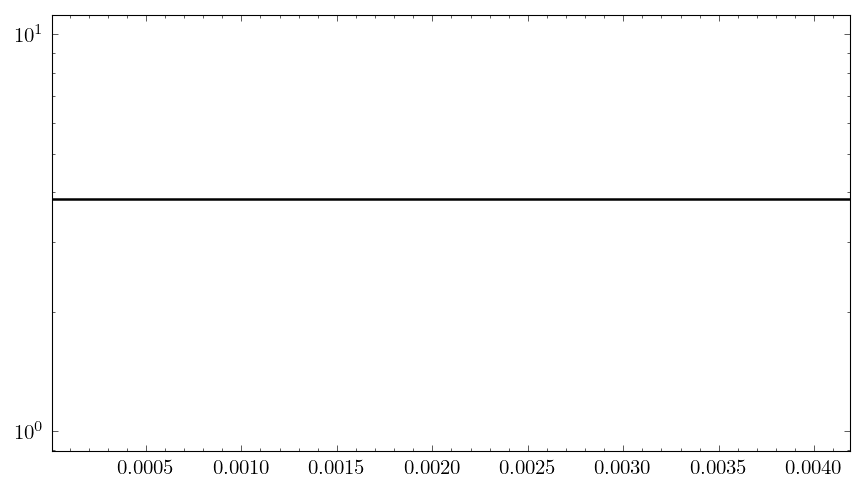

		determining the upper limit
		--->0.00586710693294571

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.400679135511708e-17
		--->'mle_theta_er': 1.0013719403406898
		--->'mle_theta_nr': 1.1384740025950815
		defining the test statistic
		determining the upper limit
		--->0.004668044605144423

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.855396370958068e-17
		--->'mle_theta_er': 1.0097279747946173
		--->'mle_theta_nr': 1.114441136042761
		defining the test statistic
		determining the upper limit
		--->0.009752896092564481

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0054452659800889e-16
		--->'mle_theta_er': 1.0038747690838385
		--->'mle_theta_nr': 1.2076394171531115
		defining the test statistic
		determining the upper limit
		--->0.008311168

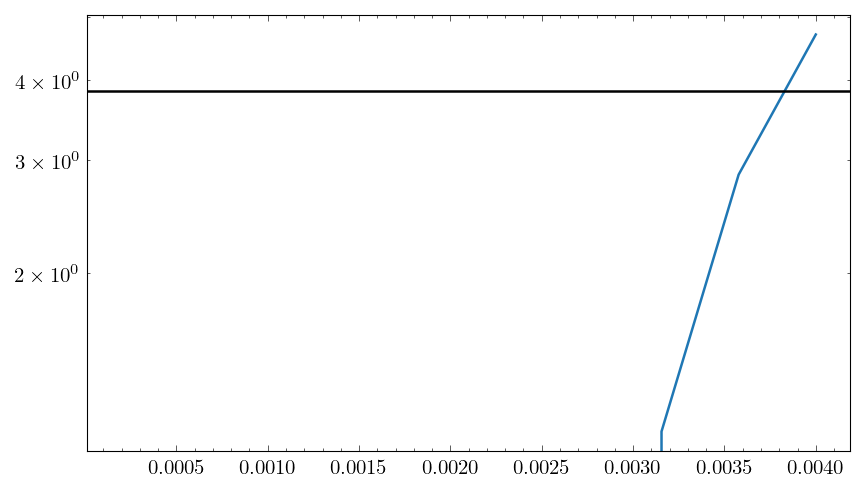

		determining the upper limit
		--->0.003808158545015302

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.920456142053998e-17
		--->'mle_theta_er': 1.0053284835355867
		--->'mle_theta_nr': 1.1745109188715404
		defining the test statistic
		determining the upper limit
		--->0.012279974350642183

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.928660629021396e-17
		--->'mle_theta_er': 1.0010179336519378
		--->'mle_theta_nr': 1.0812473559408389
		defining the test statistic
		determining the upper limit
		--->0.004790907679224761

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.718474218662622e-17
		--->'mle_theta_er': 1.0024737789986276
		--->'mle_theta_nr': 1.1067882521922967
		defining the test statistic
		determining the upper limit
		--->0.00674101

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


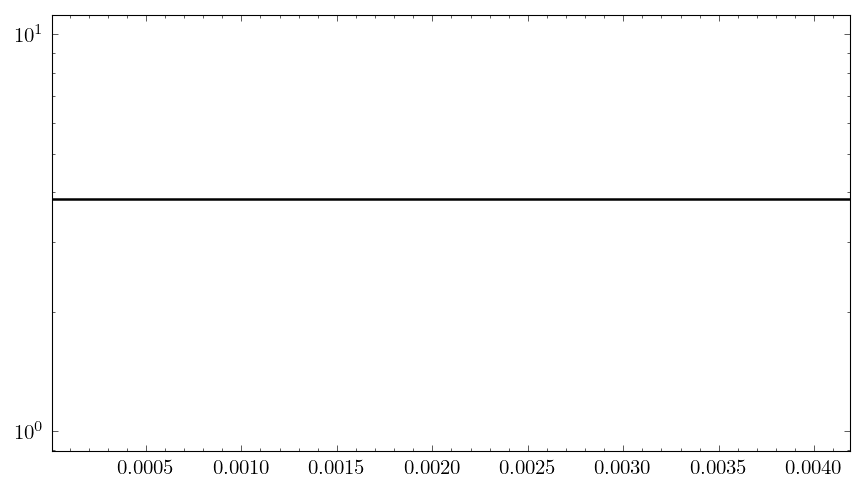

		determining the upper limit
		--->0.010588007529386925

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.435702878171518e-17
		--->'mle_theta_er': 1.0006510418194132
		--->'mle_theta_nr': 1.0922981899369995
		defining the test statistic
		determining the upper limit
		--->0.00578744502013259

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.992645427429523e-17
		--->'mle_theta_er': 1.0052346268009562
		--->'mle_theta_nr': 1.0862529318099499
		defining the test statistic
		determining the upper limit
		--->0.0064231732187407485

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.168881602690076e-17
		--->'mle_theta_er': 1.0083768542909688
		--->'mle_theta_nr': 1.0474702773587032
		defining the test statistic
		determining the upper limit
		--->0.00574774

		--->'mle_sigma': 9.218365476453841e-17
		--->'mle_theta_er': 1.0045463700407096
		--->'mle_theta_nr': 1.0907041054005806
		defining the test statistic
		determining the upper limit
		--->0.004373397294611

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.782800473645335e-17
		--->'mle_theta_er': 1.0038443801617984
		--->'mle_theta_nr': 1.100338853510025
		defining the test statistic
		test statistic plot


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


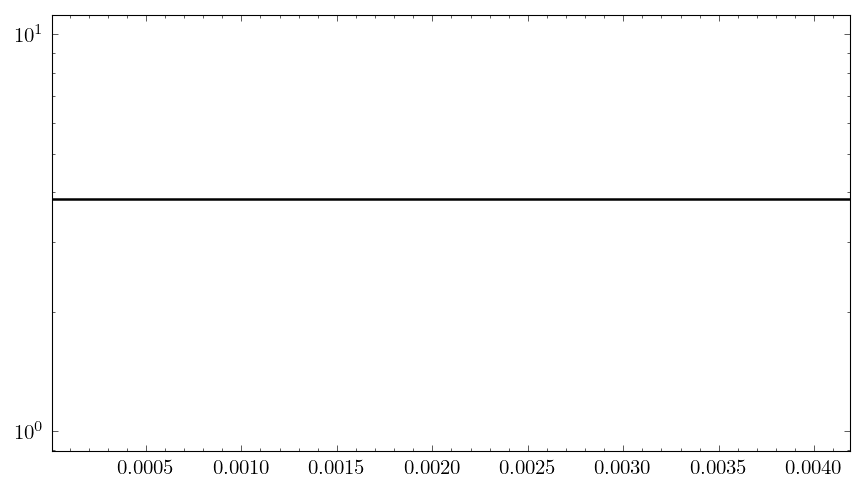

		determining the upper limit
		--->0.0071127252708182475
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 14
     iterations: 13
           root: 0.0071127252708182475

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0013941293370964e-16
		--->'mle_theta_er': 1.0052175736800333
		--->'mle_theta_nr': 1.09281742643608
		defining the test statistic
		determining the upper limit
		--->0.007061907713351044

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0098251684862654e-16
		--->'mle_theta_er': 1.003846530661395
		--->'mle_theta_nr': 1.2166892537985612
		defining the test statistic
		test statistic plot


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


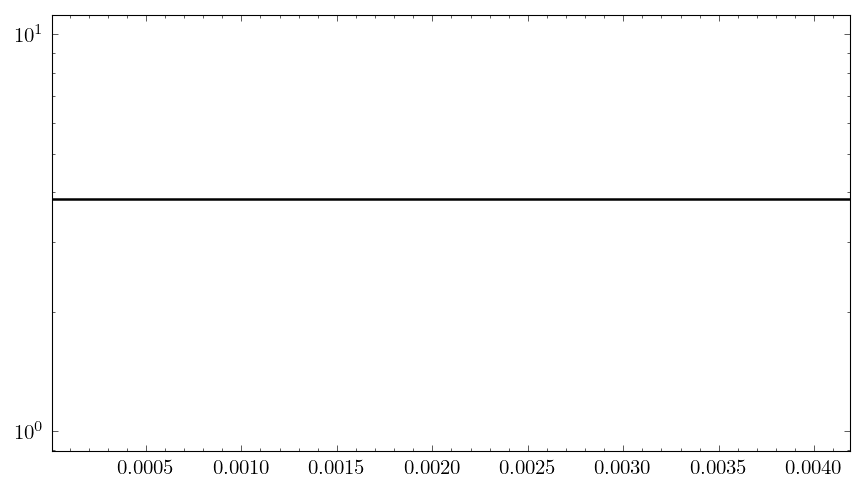

		determining the upper limit
		--->0.008131631862630962

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.042952852659593e-16
		--->'mle_theta_er': 1.0044668751779997
		--->'mle_theta_nr': 1.179809737001683
		defining the test statistic
		determining the upper limit
		--->0.007891907121958891

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.672642064740804e-17
		--->'mle_theta_er': 1.003395451451636
		--->'mle_theta_nr': 1.0071994858053426
		defining the test statistic
		determining the upper limit
		--->0.0009016770705907107

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0273529176472292e-16
		--->'mle_theta_er': 0.9998052183676269
		--->'mle_theta_nr': 1.1540079331668371
		defining the test statistic
		determining the upper limit
		--->0.00761536

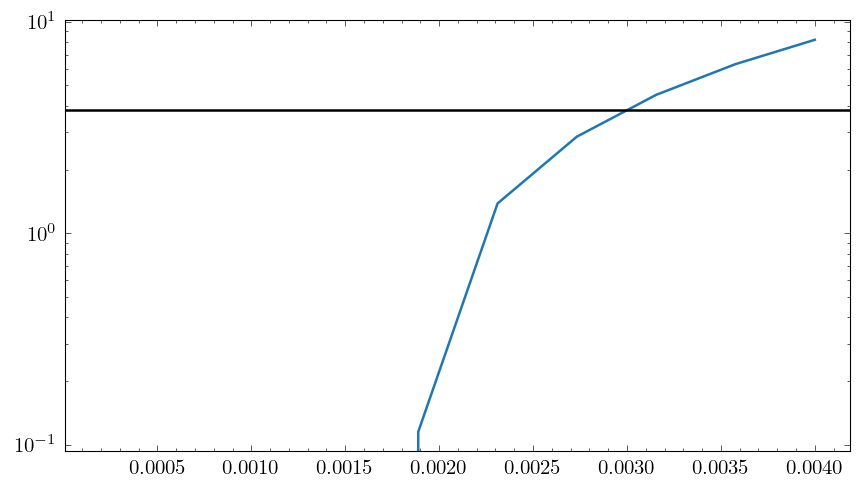

		determining the upper limit
		--->0.002987942743749178

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0302514720346969e-16
		--->'mle_theta_er': 1.0040144035843515
		--->'mle_theta_nr': 1.161057587504618
		defining the test statistic
		determining the upper limit
		--->0.008032536271483304

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0171200701211624e-16
		--->'mle_theta_er': 1.0038672066918202
		--->'mle_theta_nr': 1.0916245447593895
		defining the test statistic
		determining the upper limit
		--->0.0024985303114773475

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.316410285341753e-17
		--->'mle_theta_er': 1.0085446401894673
		--->'mle_theta_nr': 1.1739156008914944
		defining the test statistic
		determining the upper limit
		--->0.010527

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


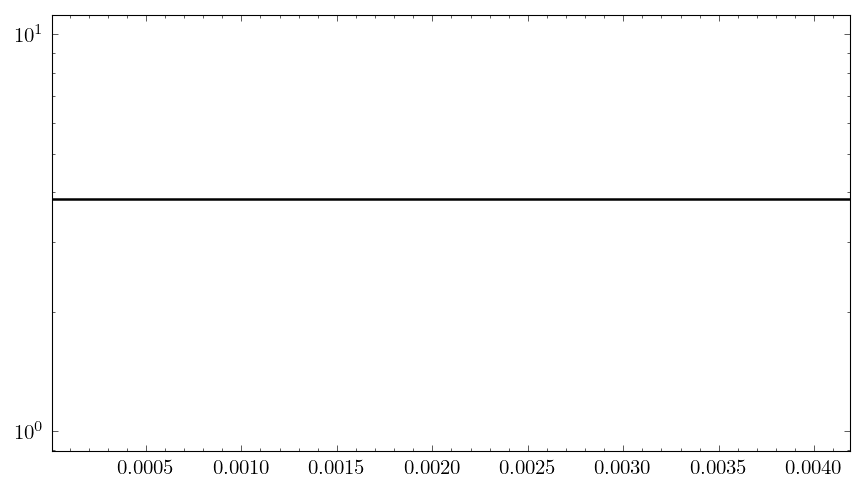

		determining the upper limit
		--->0.011470410742440023

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.200971645570675e-17
		--->'mle_theta_er': 1.0074358612972272
		--->'mle_theta_nr': 1.0855116414072774
		defining the test statistic
		determining the upper limit
		--->0.006075658720187724

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.787845247152345e-17
		--->'mle_theta_er': 1.0031526583802215
		--->'mle_theta_nr': 1.0389752737244864
		defining the test statistic
		test statistic plot


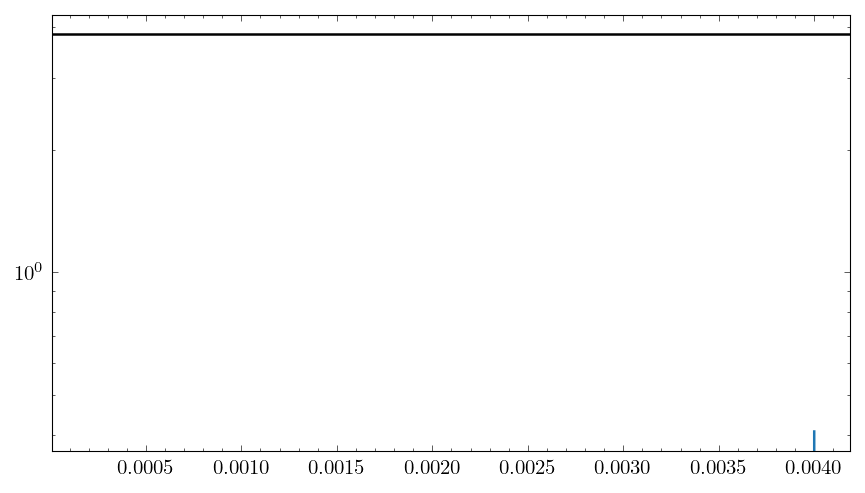

		determining the upper limit
		--->0.004839102912628578

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.117346772926562e-17
		--->'mle_theta_er': 1.0089524058257382
		--->'mle_theta_nr': 1.0878661681148705
		defining the test statistic
		determining the upper limit
		--->0.005454715802789419
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 13
     iterations: 12
           root: 0.005454715802789419

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.021016288000756e-17
		--->'mle_theta_er': 1.0072274715565643
		--->'mle_theta_nr': 1.1005224688569437
		defining the test statistic
		determining the upper limit
		--->0.006903288740978765

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigm

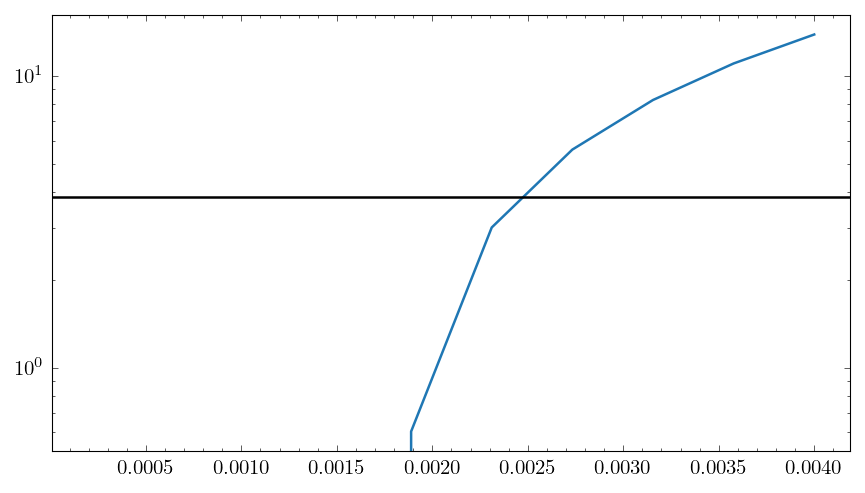

		determining the upper limit
		--->0.0024484327733943884

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.667148764668291e-17
		--->'mle_theta_er': 1.0099160776996485
		--->'mle_theta_nr': 1.107395614529669
		defining the test statistic
		determining the upper limit
		--->0.003865866715860749

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.893193172740206e-17
		--->'mle_theta_er': 1.0055645529937762
		--->'mle_theta_nr': 1.151508838993442
		defining the test statistic
		determining the upper limit
		--->0.005961233654848174

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.722651512100184e-17
		--->'mle_theta_er': 1.003816303548212
		--->'mle_theta_nr': 1.1709573842036896
		defining the test statistic
		determining the upper limit
		--->0.0086810787

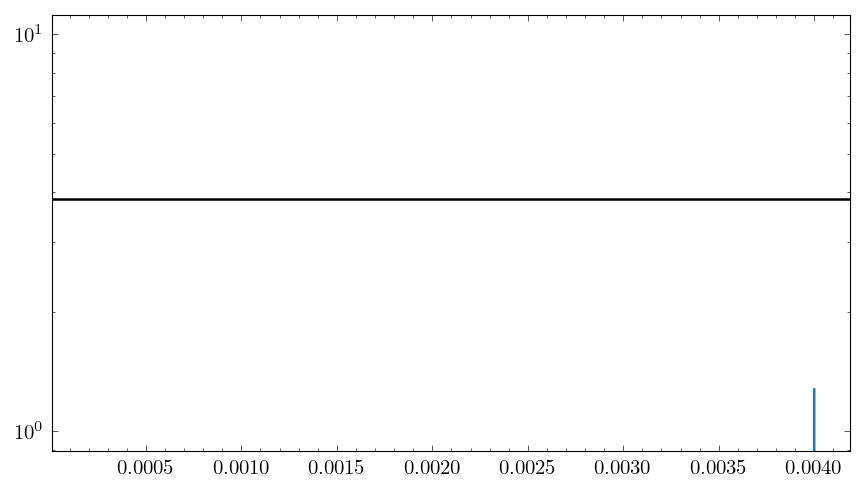

		determining the upper limit
		--->0.004475839562546872

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0407494075409337e-16
		--->'mle_theta_er': 1.000090369340925
		--->'mle_theta_nr': 1.1722984785251933
		defining the test statistic
		determining the upper limit
		--->0.008548043042220713

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.617950494908589e-17
		--->'mle_theta_er': 1.0066453228359242
		--->'mle_theta_nr': 1.063675823232836
		defining the test statistic
		determining the upper limit
		--->0.0022765399859925473

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.393839221186061e-17
		--->'mle_theta_er': 1.0017065005452204
		--->'mle_theta_nr': 1.1975195534330267
		defining the test statistic
		determining the upper limit
		--->0.00695933

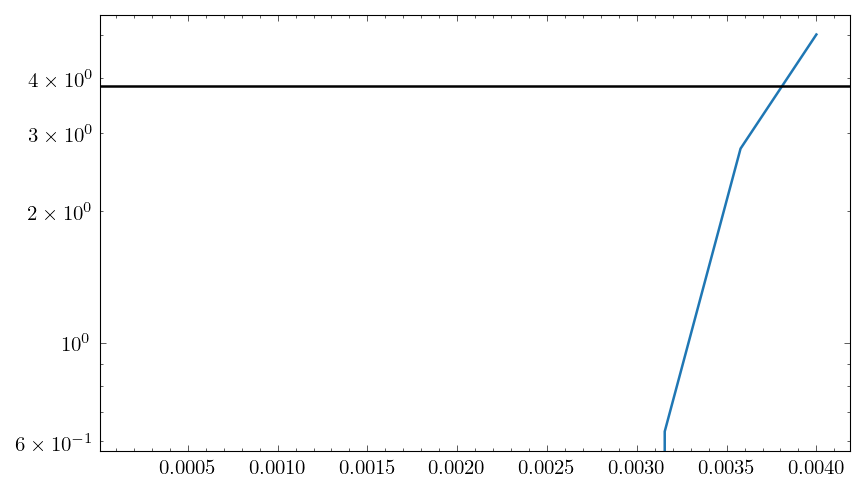

		determining the upper limit
		--->0.0037817941619526126

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.055742495073314e-17
		--->'mle_theta_er': 1.0109446225923944
		--->'mle_theta_nr': 1.1023506569647523
		defining the test statistic
		determining the upper limit
		--->0.006154091637761996

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.197431812109169e-17
		--->'mle_theta_er': 1.0019566461378757
		--->'mle_theta_nr': 1.0438832767113693
		defining the test statistic
		determining the upper limit
		--->0.0056909258988306274

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0569933178150558e-16
		--->'mle_theta_er': 1.0048895156098738
		--->'mle_theta_nr': 1.1509250515692102
		defining the test statistic
		determining the upper limit
		--->0.00662

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


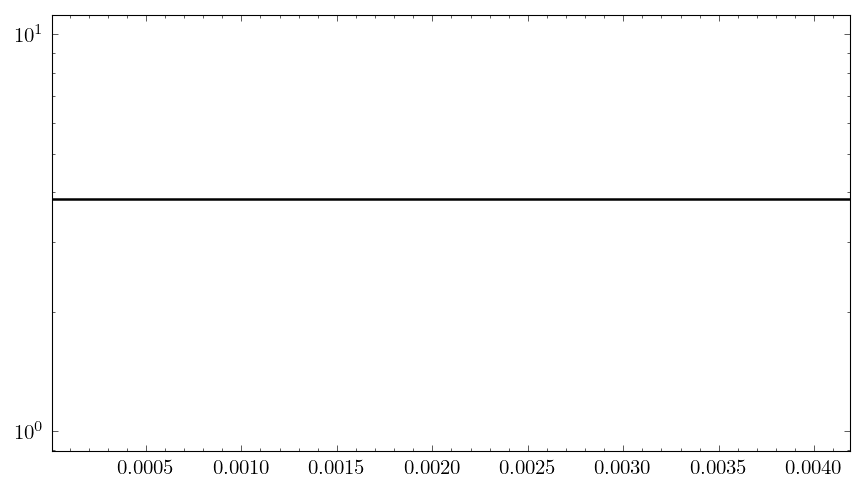

		determining the upper limit
		--->0.007558156153003771

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.992100117490968e-17
		--->'mle_theta_er': 1.003984119522432
		--->'mle_theta_nr': 1.0450244992805473
		defining the test statistic
		determining the upper limit
		--->0.004818846568376804

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.424079359459543e-17
		--->'mle_theta_er': 1.0016614363355403
		--->'mle_theta_nr': 1.1556786514072541
		defining the test statistic
		determining the upper limit
		--->0.005739774651017572

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.132899185546369e-17
		--->'mle_theta_er': 1.0086252666852171
		--->'mle_theta_nr': 1.083516471665328
		defining the test statistic
		determining the upper limit
		--->0.0075409547

/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


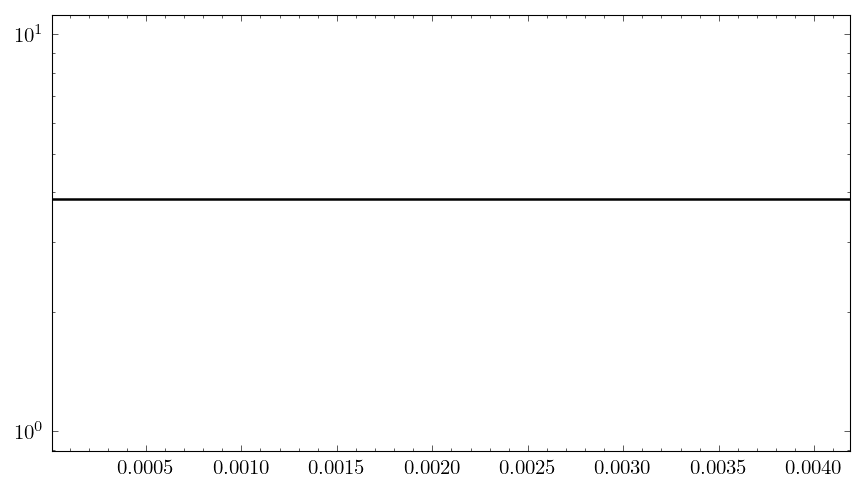

		determining the upper limit
		--->0.006102181992644322

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.756420776209977e-17
		--->'mle_theta_er': 1.0053707843067055
		--->'mle_theta_nr': 1.0988910186808796
		defining the test statistic
		test statistic plot


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


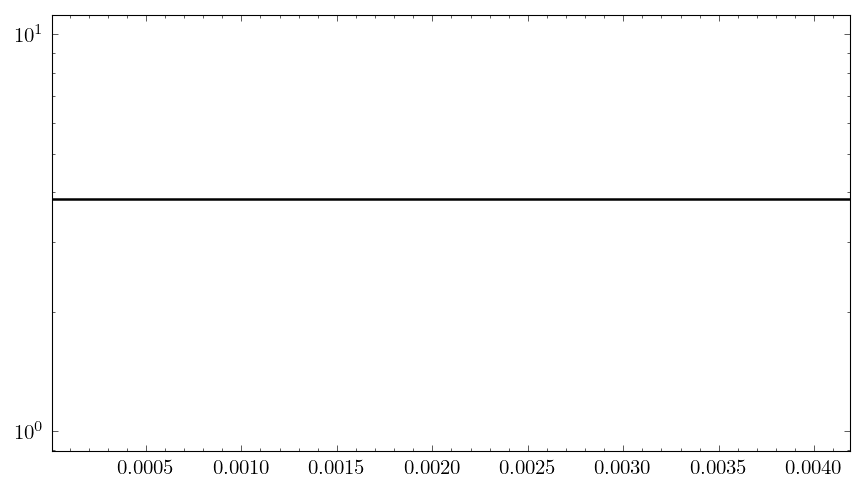

		determining the upper limit
		--->0.005912894341228452

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.944694644920884e-17
		--->'mle_theta_er': 1.0035929691709944
		--->'mle_theta_nr': 1.1891426813449966
		defining the test statistic
		determining the upper limit
		--->0.005302620708683294

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.216445205418209e-17
		--->'mle_theta_er': 1.005013920210404
		--->'mle_theta_nr': 1.1058810340364436
		defining the test statistic
		test statistic plot


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


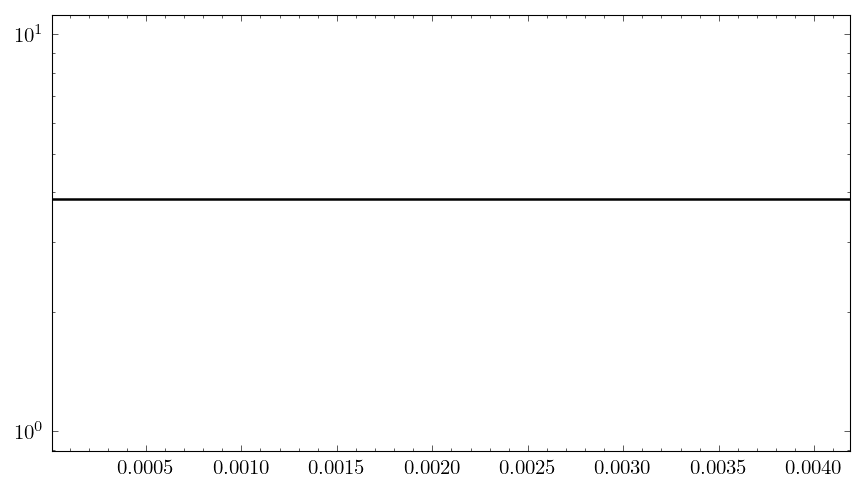

		determining the upper limit
		--->0.0051165216011641495

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.525817970728803e-17
		--->'mle_theta_er': 1.0046821155158194
		--->'mle_theta_nr': 1.1034174943141521
		defining the test statistic
		determining the upper limit
		--->0.0052008171587704065

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0242913965692804e-16
		--->'mle_theta_er': 1.004369557322121
		--->'mle_theta_nr': 1.1552553987396874
		defining the test statistic
		determining the upper limit
		--->0.004811923433900553

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.016356195164567e-17
		--->'mle_theta_er': 1.0072585518828794
		--->'mle_theta_nr': 1.1507489761773262
		defining the test statistic
		test statistic plot


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:4375: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


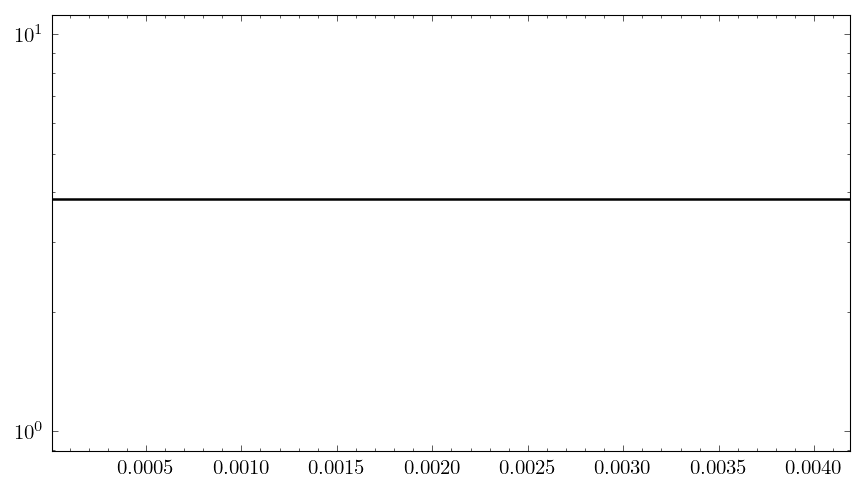

		determining the upper limit
		--->0.006620479057920879

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.651056630714026e-17
		--->'mle_theta_er': 1.0028121099571599
		--->'mle_theta_nr': 1.1068014334485548
		defining the test statistic
		determining the upper limit
		--->0.006368767693589257

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.300603338984732e-17
		--->'mle_theta_er': 1.002332384348398
		--->'mle_theta_nr': 1.1576778421028768
		defining the test statistic
		determining the upper limit
		--->0.0066312997238015

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.797870043938303e-17
		--->'mle_theta_er': 1.0044337903545448
		--->'mle_theta_nr': 1.068550416769716
		defining the test statistic
		determining the upper limit
		--->0.003003544147

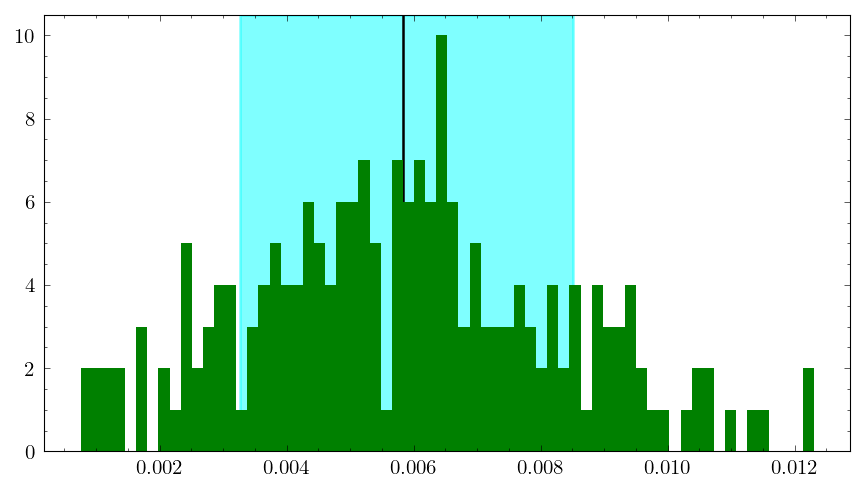

cwpec: starting WIMP mass loop with k=3/20 for 20.69 GeV
	calculating the PDF of the WIMP spectrum within the binned observable space
		calculating 'integral_spectrum_dict' for the high-statistics WIMP spectrum
######################### starting integration #########################


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:1614: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  expected_number_of_events_float_per_energy_bin = [exposure_t_y *integrate.quad(


######################### finishing integration #########################
		generating the high-statistics WIMP signature by executing NEST
		calculating the PDF
		updating the 'spectrum_components_dict'
		deleting the high-statistics WIMP signature
		plotting spectral PDF for 'wimps'


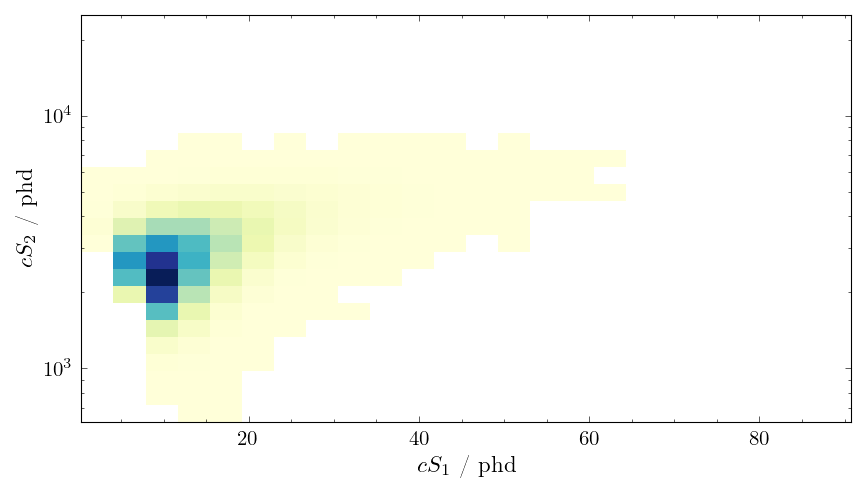

		finished within 2:51:25.541124 h'
	calculating the expected number of WIMP events within the binned observable space
		calculating the number of WIMP events expected within the WIMP EROI
######################### starting integration #########################
######################### finishing integration #########################
		updating the 'spectrum_components_dict'
		finished within 0:13:54.117238 h'
	simulating 200 background-only datasets
		generating the 'spectrum_dict's
######################### starting integration #########################
######################### finishing integration #########################
######################### starting integration #########################
######################### finishing integration #########################
		generating the ER and NR background 'signature's
	calculating the maximum likelihood parameter estimators

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
	

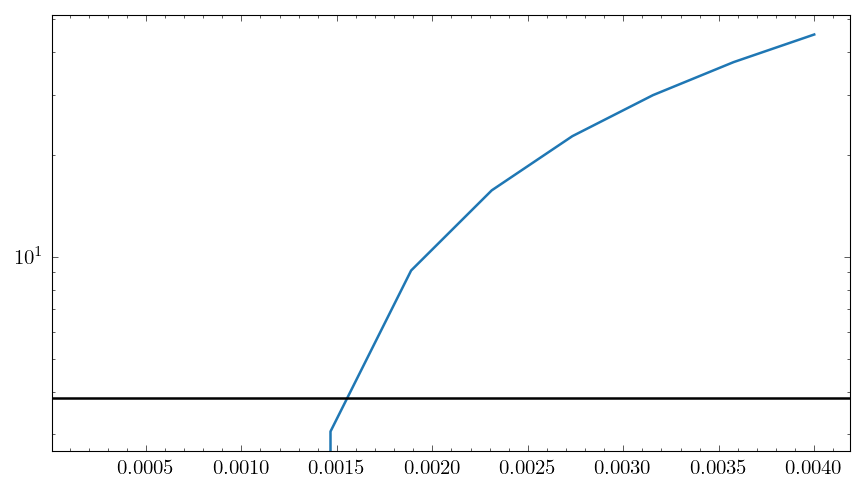

		determining the upper limit
		--->0.0015239083223167053

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.757572034152478e-17
		--->'mle_theta_er': 0.9976332973304871
		--->'mle_theta_nr': 1.1443705365122643
		defining the test statistic
		determining the upper limit
		--->0.0027199506201931937

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.921157476958951e-17
		--->'mle_theta_er': 1.0028835135839178
		--->'mle_theta_nr': 1.1424148281396458
		defining the test statistic
		determining the upper limit
		--->0.0020711488384470944

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.882349197646109e-17
		--->'mle_theta_er': 1.0009974078309396
		--->'mle_theta_nr': 1.0892214575187396
		defining the test statistic
		determining the upper limit
		--->0.00186

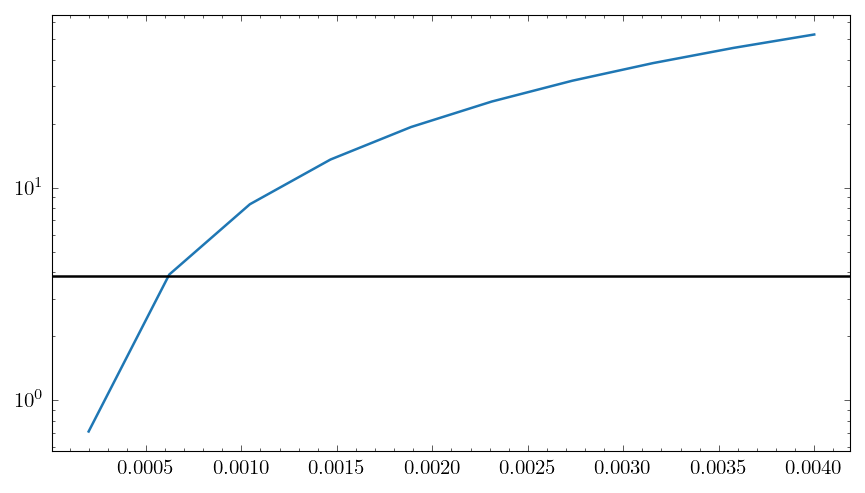

		determining the upper limit
		--->0.0006164753856963714
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 0.0006164753856963714

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.378073764244609e-17
		--->'mle_theta_er': 1.0022411848841535
		--->'mle_theta_nr': 1.065853959958428
		defining the test statistic
		determining the upper limit
		--->0.0012144155523801502

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.46348404858185e-17
		--->'mle_theta_er': 1.000855888028755
		--->'mle_theta_nr': 1.1414959248473897
		defining the test statistic
		determining the upper limit
		--->0.0019515637847240805

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigm

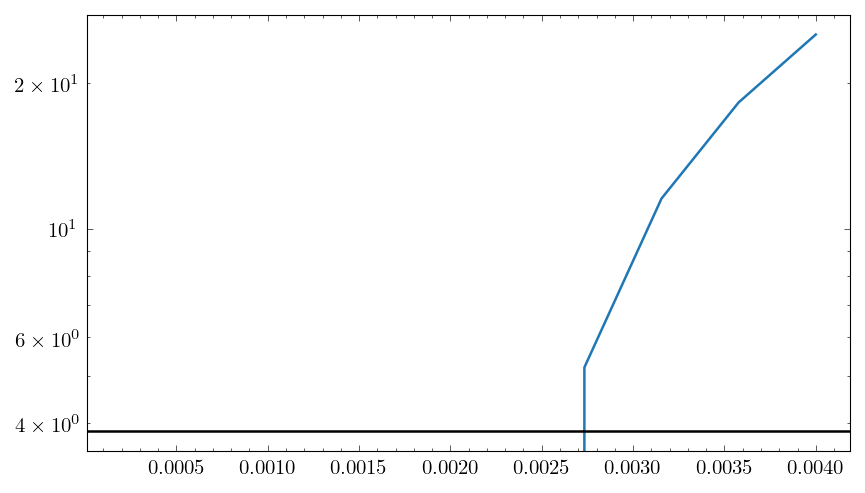

		determining the upper limit
		--->0.002640006656072576

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.336811422066003e-17
		--->'mle_theta_er': 1.0012048191055802
		--->'mle_theta_nr': 1.003312094943998
		defining the test statistic
		determining the upper limit
		--->0.0010840246717591909

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0222845150488459e-16
		--->'mle_theta_er': 1.0003150297471248
		--->'mle_theta_nr': 1.1532160510517269
		defining the test statistic
		determining the upper limit
		--->0.0034375047761531522

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.4874465987572e-17
		--->'mle_theta_er': 1.0021986293136285
		--->'mle_theta_nr': 1.1452866787897076
		defining the test statistic
		determining the upper limit
		--->0.00269199

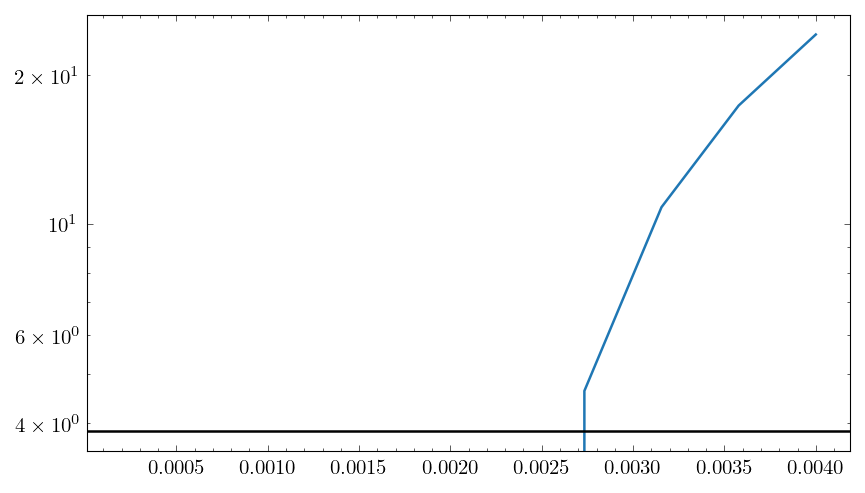

		determining the upper limit
		--->0.0026776240369336037

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.613867776208093e-17
		--->'mle_theta_er': 1.0023955296901157
		--->'mle_theta_nr': 1.0717668832980407
		defining the test statistic
		determining the upper limit
		--->0.0019879604126688674

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.369669316219836e-17
		--->'mle_theta_er': 1.003418281156231
		--->'mle_theta_nr': 1.0687118661147
		defining the test statistic
		determining the upper limit
		--->0.0018487097355992337

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.34027524003642e-17
		--->'mle_theta_er': 1.00122292659945
		--->'mle_theta_nr': 1.13124339234517
		defining the test statistic
		determining the upper limit
		--->0.00250101514757

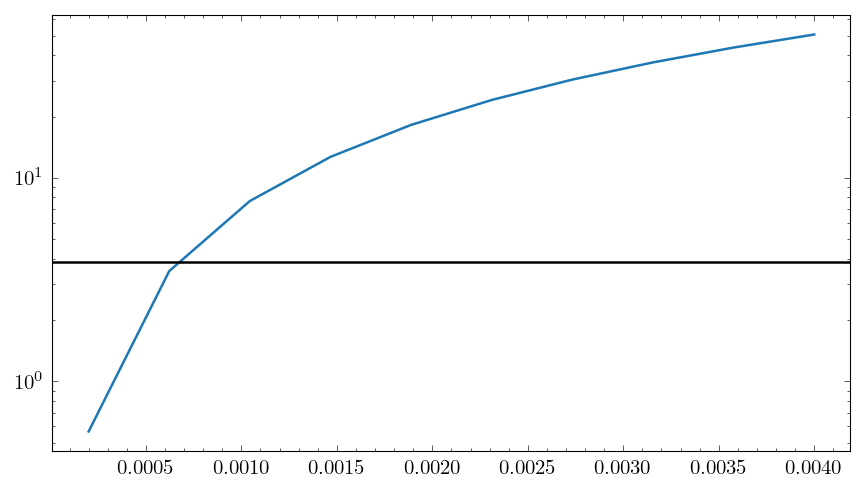

		determining the upper limit
		--->0.0006628336419831342

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.769108697461205e-17
		--->'mle_theta_er': 1.004072336690629
		--->'mle_theta_nr': 1.0071409983868014
		defining the test statistic
		determining the upper limit
		--->0.0009792858646691153

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0693617937874232e-16
		--->'mle_theta_er': 0.9927190616447941
		--->'mle_theta_nr': 1.1471551745168438
		defining the test statistic
		determining the upper limit
		--->0.0028530341304491376

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.190935198024022e-17
		--->'mle_theta_er': 1.001543960112432
		--->'mle_theta_nr': 1.0740055221845406
		defining the test statistic
		test statistic plot


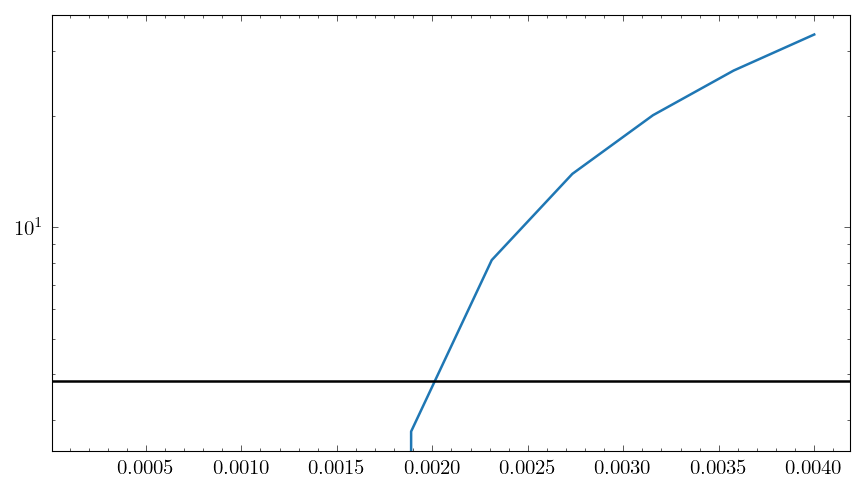

		determining the upper limit
		--->0.0019742291300667365

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.618726299770126e-17
		--->'mle_theta_er': 0.997464552914233
		--->'mle_theta_nr': 1.0814565520297426
		defining the test statistic
		determining the upper limit
		--->0.003190144662716015
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 16
     iterations: 15
           root: 0.003190144662716015

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.917313779152729e-17
		--->'mle_theta_er': 0.9990053884978439
		--->'mle_theta_nr': 1.0743332512482069
		defining the test statistic
		test statistic plot


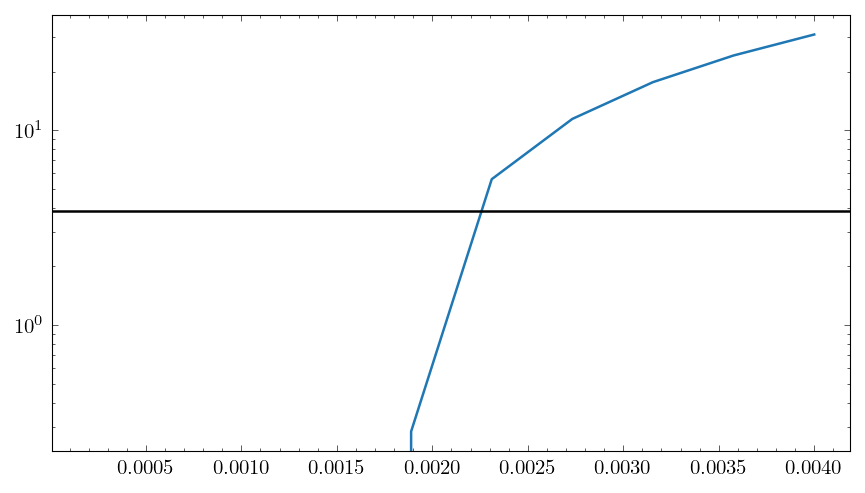

		determining the upper limit
		--->0.0021759944382654796

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.44792670242681e-17
		--->'mle_theta_er': 0.9986582660494826
		--->'mle_theta_nr': 1.007249088591673
		defining the test statistic
		determining the upper limit
		--->0.0011613746048782278

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.836565398745036e-17
		--->'mle_theta_er': 1.000008773447677
		--->'mle_theta_nr': 1.1419190398357182
		defining the test statistic
		determining the upper limit
		--->0.0022558566121157427

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0817453930942107e-16
		--->'mle_theta_er': 0.9918913559447623
		--->'mle_theta_nr': 1.1407150992171946
		defining the test statistic
		determining the upper limit
		--->0.0021409

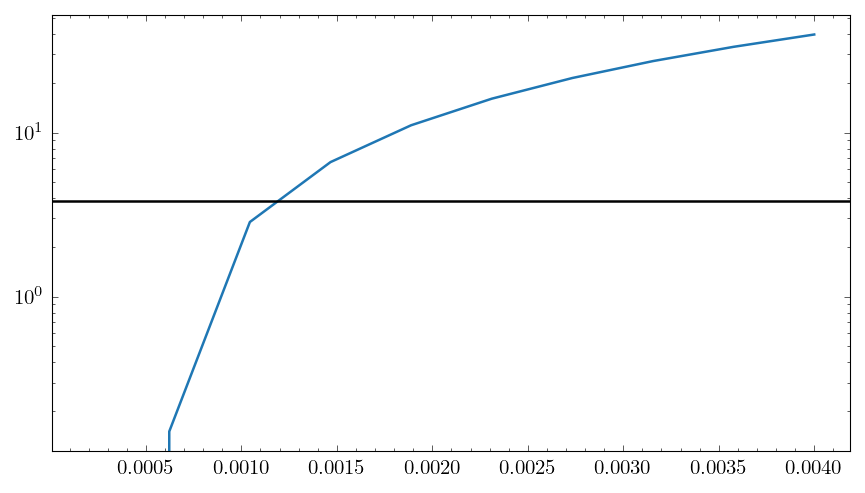

		determining the upper limit
		--->0.0011653939624635067

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 7.038960885116282e-17
		--->'mle_theta_er': 0.9998497139684476
		--->'mle_theta_nr': 1.138323611876742
		defining the test statistic
		determining the upper limit
		--->0.001771746430134732

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.387715787805425e-17
		--->'mle_theta_er': 1.0006961351268564
		--->'mle_theta_nr': 1.1381362484349533
		defining the test statistic
		determining the upper limit
		--->0.0035233406198515

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.444460626943736e-17
		--->'mle_theta_er': 0.9986637438348145
		--->'mle_theta_nr': 1.075629337666725
		defining the test statistic
		test statistic plot


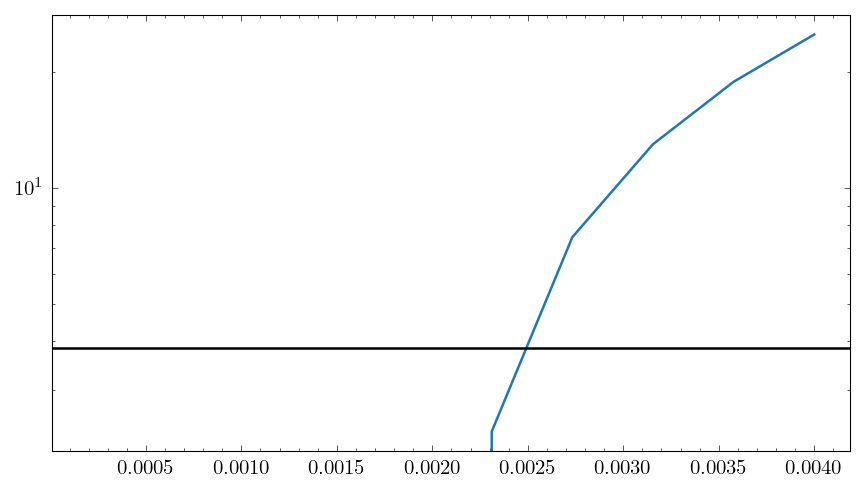

		determining the upper limit
		--->0.0024391638963535776

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.004239516033823e-17
		--->'mle_theta_er': 1.002074530922703
		--->'mle_theta_nr': 1.1291806900638455
		defining the test statistic
		determining the upper limit
		--->0.0013000789148833432

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.967043690294677e-17
		--->'mle_theta_er': 1.0012123086514069
		--->'mle_theta_nr': 1.1931357811321406
		defining the test statistic
		determining the upper limit
		--->0.0028830906738152003

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.034023115278213e-17
		--->'mle_theta_er': 1.0007071885747987
		--->'mle_theta_nr': 1.070383964854103
		defining the test statistic
		test statistic plot


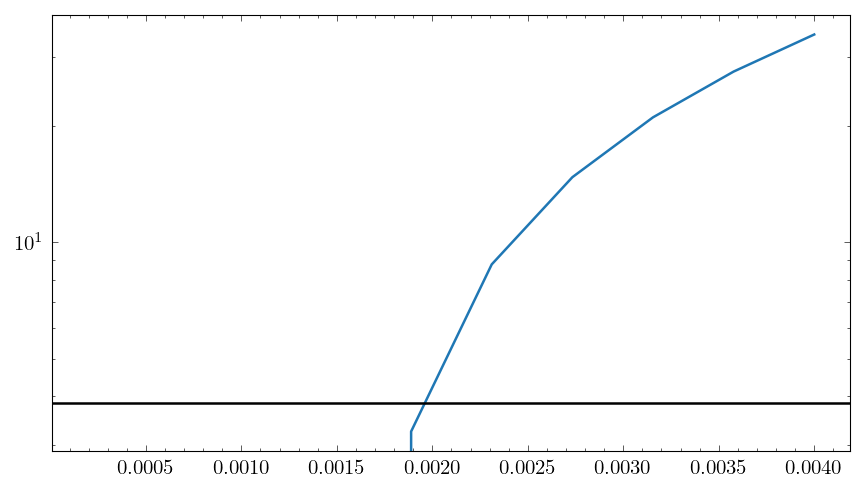

		determining the upper limit
		--->0.0019362583209597873

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 7.560409657293492e-17
		--->'mle_theta_er': 1.00374202593368
		--->'mle_theta_nr': 1.0745165489932589
		defining the test statistic
		determining the upper limit
		--->0.002045787759549234

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 7.545500109142753e-17
		--->'mle_theta_er': 1.001530417434798
		--->'mle_theta_nr': 1.1422761604392058
		defining the test statistic
		determining the upper limit
		--->0.002711531774035021

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.550812932236657e-17
		--->'mle_theta_er': 0.9996858981175805
		--->'mle_theta_nr': 1.0016391806657414
		defining the test statistic
		determining the upper limit
		--->0.0006632930

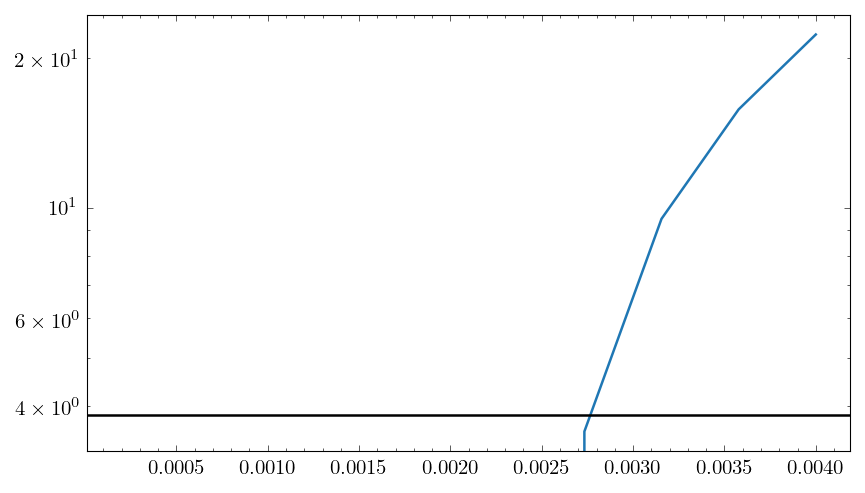

		determining the upper limit
		--->0.002754293810606581

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.465542442730318e-17
		--->'mle_theta_er': 0.9937739915846154
		--->'mle_theta_nr': 1.0690621092050525
		defining the test statistic
		test statistic plot


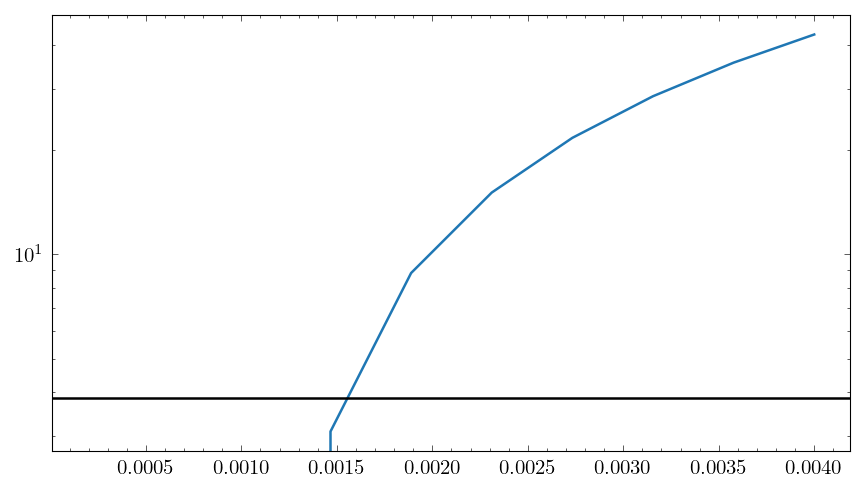

		determining the upper limit
		--->0.0015248945002916483

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.184418737194236e-17
		--->'mle_theta_er': 1.0017263824434437
		--->'mle_theta_nr': 0.9970091636157195
		defining the test statistic
		determining the upper limit
		--->0.0006811901064923583

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.793142765979499e-17
		--->'mle_theta_er': 1.0000254052015836
		--->'mle_theta_nr': 1.0723938875242727
		defining the test statistic
		determining the upper limit
		--->0.0016637086955839776

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.944564734460985e-17
		--->'mle_theta_er': 1.002717453426349
		--->'mle_theta_nr': 1.2522007263198112
		defining the test statistic
		determining the upper limit
		--->0.004395

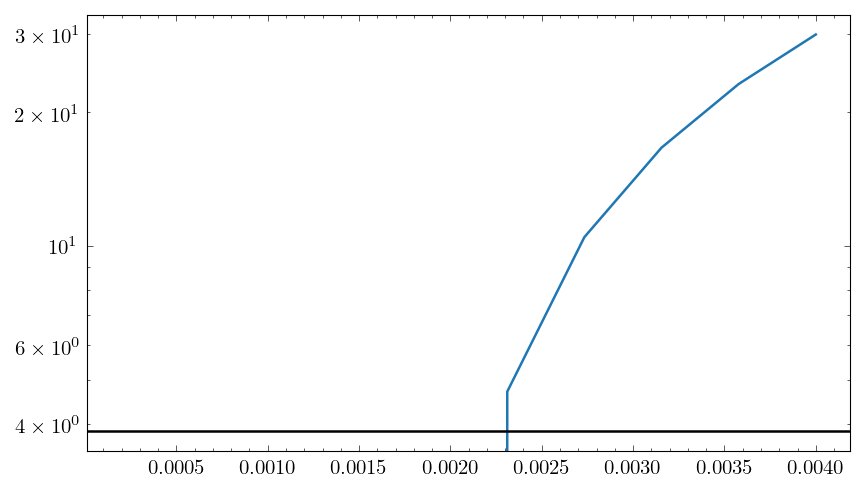

		determining the upper limit
		--->0.002243630754079281

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.384303704704424e-17
		--->'mle_theta_er': 1.0020673320998523
		--->'mle_theta_nr': 0.9958284248337893
		defining the test statistic
		determining the upper limit
		--->0.0003954899235691956

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.020729075914144e-17
		--->'mle_theta_er': 0.9983268784858816
		--->'mle_theta_nr': 1.0750314083220984
		defining the test statistic
		determining the upper limit
		--->0.0023884394420465548

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.650059327519779e-17
		--->'mle_theta_er': 1.0038938609073944
		--->'mle_theta_nr': 1.011258490670198
		defining the test statistic
		determining the upper limit
		--->0.0021166

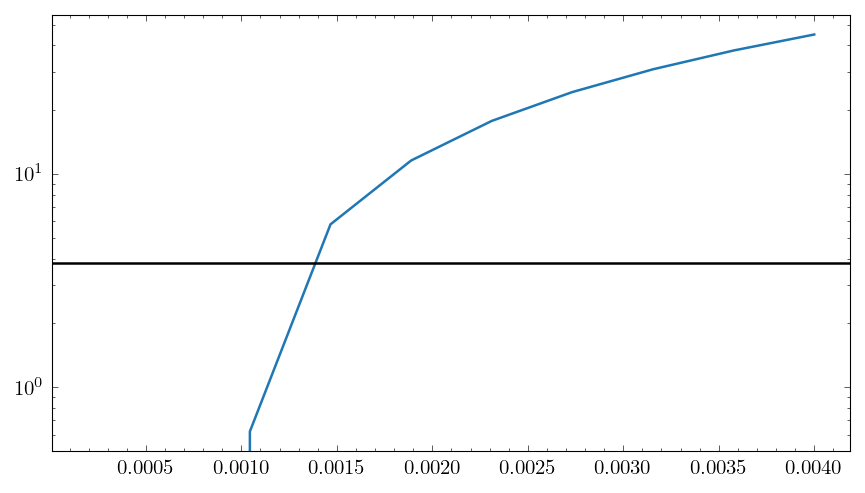

		determining the upper limit
		--->0.0013133858101331219

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.321735318162816e-17
		--->'mle_theta_er': 0.9978397154837162
		--->'mle_theta_nr': 1.1310787158304043
		defining the test statistic
		determining the upper limit
		--->0.002026628995153282

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.1548599881539623e-16
		--->'mle_theta_er': 0.9973357299889982
		--->'mle_theta_nr': 1.1883078441017512
		defining the test statistic
		determining the upper limit
		--->0.0019972808530472445

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 7.345802348092625e-17
		--->'mle_theta_er': 0.9988171456782526
		--->'mle_theta_nr': 1.1445233558967358
		defining the test statistic
		determining the upper limit
		--->0.00373

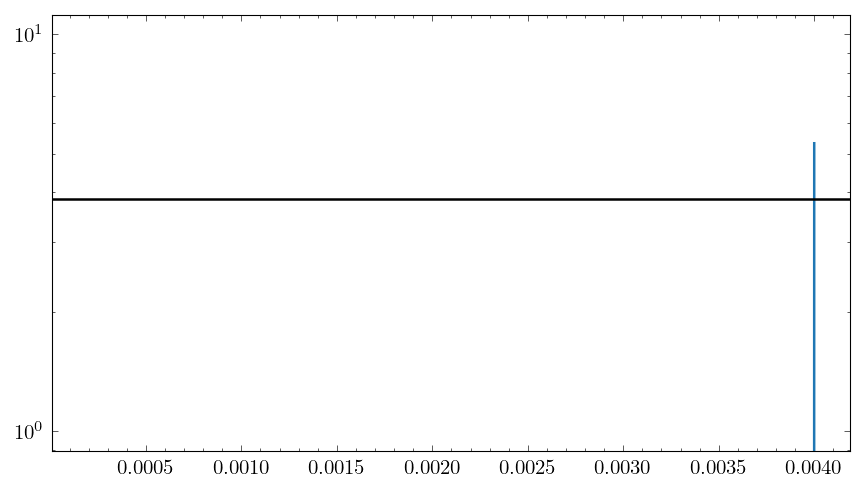

		determining the upper limit
		--->0.003895916091460105

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0481438440314751e-16
		--->'mle_theta_er': 0.9968068421810206
		--->'mle_theta_nr': 1.1374510723221194
		defining the test statistic
		determining the upper limit
		--->0.0030894677130271666

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.323262291797488e-17
		--->'mle_theta_er': 1.0013580594116158
		--->'mle_theta_nr': 1.010391881116902
		defining the test statistic
		determining the upper limit
		--->0.0013602432429575574

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.84299080537711e-17
		--->'mle_theta_er': 0.9951191706888066
		--->'mle_theta_nr': 1.001103010931307
		defining the test statistic
		test statistic plot


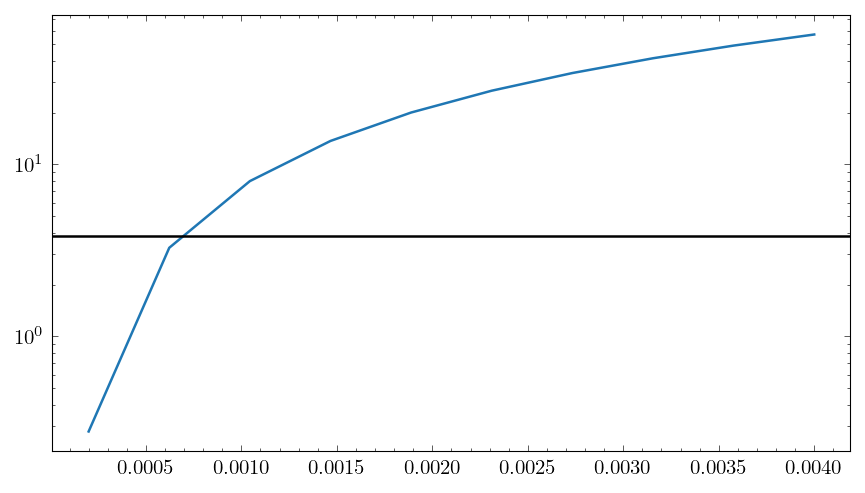

		determining the upper limit
		--->0.0006800275888137603

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.525782641015006e-17
		--->'mle_theta_er': 1.0023796204375643
		--->'mle_theta_nr': 1.141119039914839
		defining the test statistic
		determining the upper limit
		--->0.0035365530127655126

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.317291932101444e-17
		--->'mle_theta_er': 1.0024088785039842
		--->'mle_theta_nr': 0.9943782696881905
		defining the test statistic
		determining the upper limit
		--->0.0004236050823124258

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0166025908221798e-16
		--->'mle_theta_er': 0.9995308660991737
		--->'mle_theta_nr': 1.1313184162905339
		defining the test statistic
		determining the upper limit
		--->0.00158

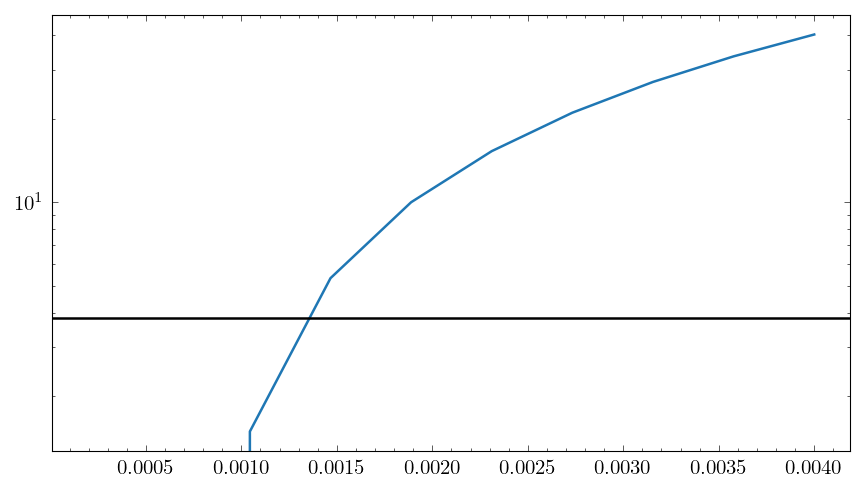

		determining the upper limit
		--->0.001315668662860914

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.093491983047191e-17
		--->'mle_theta_er': 1.0068126813906066
		--->'mle_theta_nr': 1.128800091164667
		defining the test statistic
		determining the upper limit
		--->0.0025994784536203914

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.1229240159380038e-16
		--->'mle_theta_er': 0.9954336349956787
		--->'mle_theta_nr': 1.201794932424204
		defining the test statistic
		determining the upper limit
		--->0.0035804077596557006

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0607866220216829e-16
		--->'mle_theta_er': 1.0031989139803317
		--->'mle_theta_nr': 1.1505073764221683
		defining the test statistic
		determining the upper limit
		--->0.004500

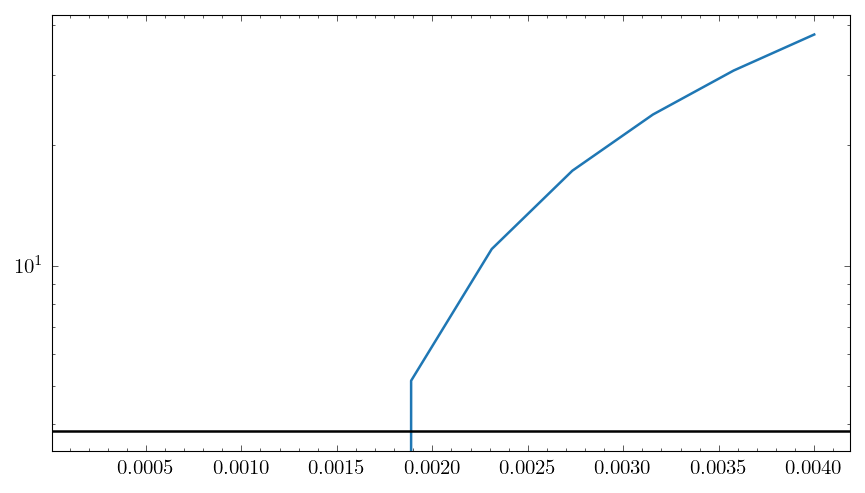

		determining the upper limit
		--->0.0017891067475786738
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 14
     iterations: 13
           root: 0.0017891067475786738

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0793905908101322e-16
		--->'mle_theta_er': 0.9918967806626082
		--->'mle_theta_nr': 1.1387955314921072
		defining the test statistic
		determining the upper limit
		--->0.001702877821521996
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 14
     iterations: 13
           root: 0.001702877821521996

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.681600817392635e-17
		--->'mle_theta_er': 0.9971523674840468
		--->'mle_theta_nr': 1.0711592051504302
		defining the test sta

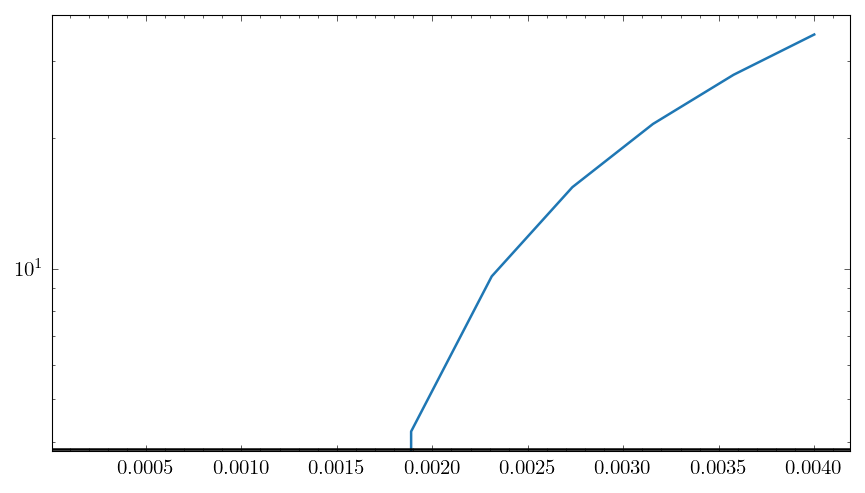

		determining the upper limit
		--->0.0018575517928880172

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.24397540697959e-17
		--->'mle_theta_er': 1.000543783603738
		--->'mle_theta_nr': 1.0680721017223465
		defining the test statistic
		determining the upper limit
		--->0.0016071603826461442

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.986471951505182e-17
		--->'mle_theta_er': 0.9939607009677907
		--->'mle_theta_nr': 1.1266590326821138
		defining the test statistic
		test statistic plot


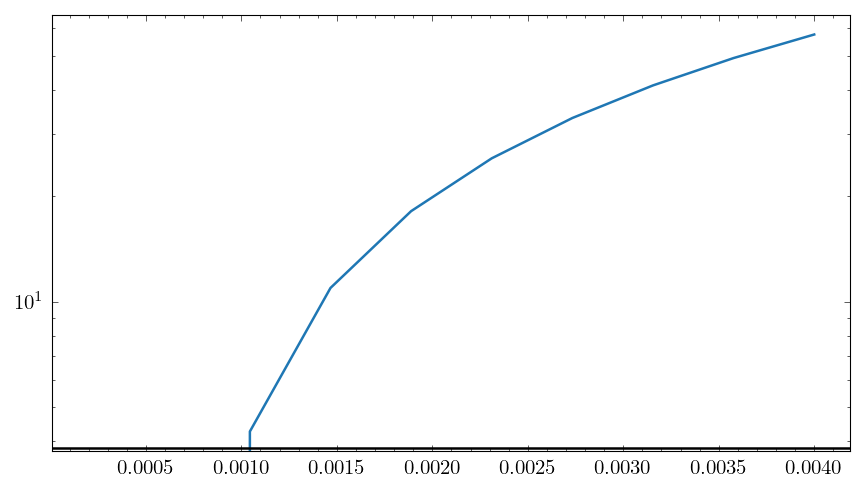

		determining the upper limit
		--->0.0010157549788696095

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.1212921619620674e-16
		--->'mle_theta_er': 0.9956383555633975
		--->'mle_theta_nr': 1.0677346352927146
		defining the test statistic
		determining the upper limit
		--->0.0012461488100513278

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 7.905706410195143e-17
		--->'mle_theta_er': 1.0094842490688638
		--->'mle_theta_nr': 1.199025776649505
		defining the test statistic
		determining the upper limit
		--->0.0038755219855213423

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.764662279185781e-17
		--->'mle_theta_er': 0.9974732916590856
		--->'mle_theta_nr': 1.078048367605223
		defining the test statistic
		test statistic plot


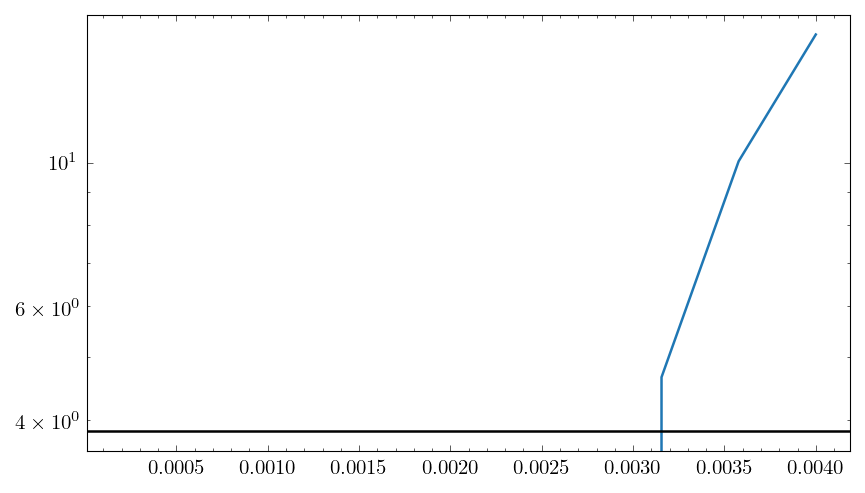

		determining the upper limit
		--->0.0030887255246475377

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.484562202466024e-17
		--->'mle_theta_er': 1.0044136501514165
		--->'mle_theta_nr': 1.005835320621003
		defining the test statistic
		determining the upper limit
		--->0.0009971859133280712

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.683779018942568e-17
		--->'mle_theta_er': 0.9993506519921997
		--->'mle_theta_nr': 1.1352968542488537
		defining the test statistic
		determining the upper limit
		--->0.001407743114949912

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.91360108543881e-17
		--->'mle_theta_er': 1.0050859971965889
		--->'mle_theta_nr': 1.1413041121341756
		defining the test statistic
		determining the upper limit
		--->0.00198190

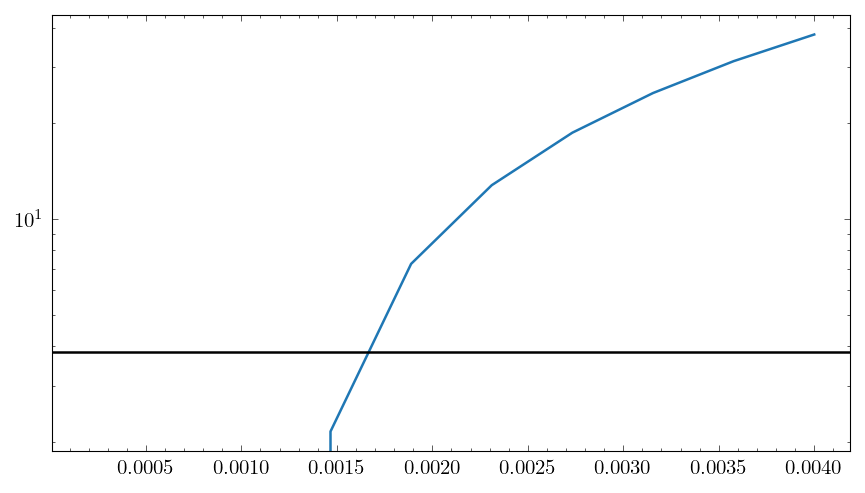

		determining the upper limit
		--->0.0016115948526589775

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0149036439203998e-16
		--->'mle_theta_er': 0.9942617936505382
		--->'mle_theta_nr': 1.1400601467624591
		defining the test statistic
		determining the upper limit
		--->0.0020854361577548543

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.49633064866028e-17
		--->'mle_theta_er': 1.0001707362309835
		--->'mle_theta_nr': 1.0117411341522242
		defining the test statistic
		determining the upper limit
		--->0.0015647294398888078

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.339351323694115e-17
		--->'mle_theta_er': 1.0020534385736863
		--->'mle_theta_nr': 1.073242128137744
		defining the test statistic
		determining the upper limit
		--->0.002043

		--->0.002599288103286863

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.801941653262677e-17
		--->'mle_theta_er': 1.0044311769604235
		--->'mle_theta_nr': 1.0695994158677993
		defining the test statistic
		determining the upper limit
		--->0.0004348124815975111

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.340517019040246e-17
		--->'mle_theta_er': 1.0049410712057227
		--->'mle_theta_nr': 0.9968988162235859
		defining the test statistic
		determining the upper limit
		--->0.0005924647510212984

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.889218925344985e-17
		--->'mle_theta_er': 1.0030479994646226
		--->'mle_theta_nr': 1.081294459756771
		defining the test statistic
		determining the upper limit
		--->0.0026435975963779827

		a priori calcu

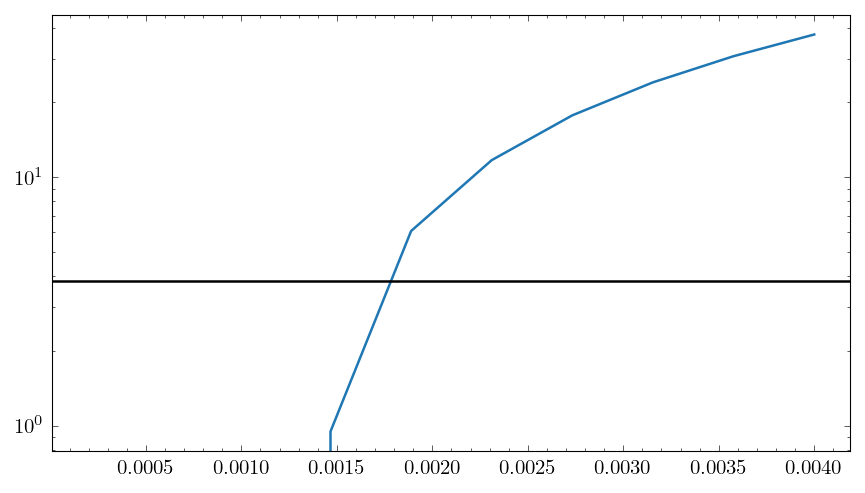

		determining the upper limit
		--->0.0017107422674552213

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 7.404660461089575e-17
		--->'mle_theta_er': 1.0030568863239746
		--->'mle_theta_nr': 1.077832373296015
		defining the test statistic
		determining the upper limit
		--->0.0024027413316381136

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.953534088458952e-17
		--->'mle_theta_er': 0.9992006395760817
		--->'mle_theta_nr': 0.9915290617563959
		defining the test statistic
		determining the upper limit
		--->0.00026043646385318385
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 8
     iterations: 7
           root: 0.00026043646385318385

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_s

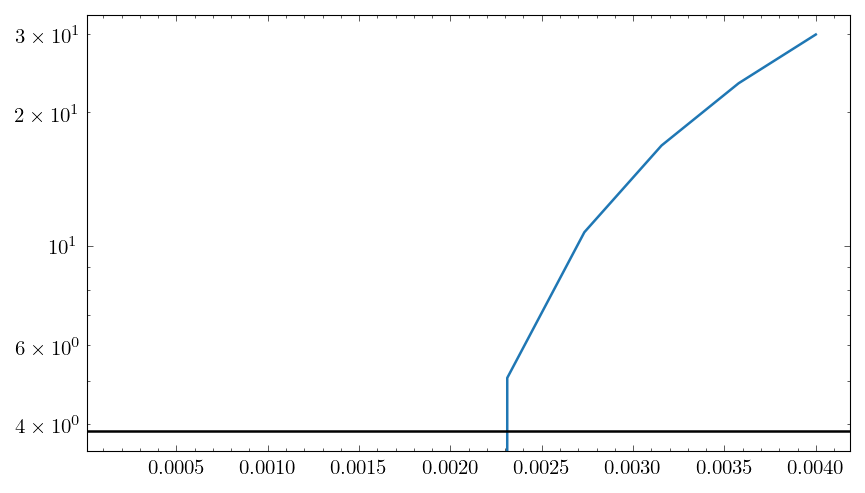

		determining the upper limit
		--->0.0022154756583230373
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 14
     iterations: 13
           root: 0.0022154756583230373

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.333208961637043e-17
		--->'mle_theta_er': 1.0005228052910136
		--->'mle_theta_nr': 1.0763798313175559
		defining the test statistic
		determining the upper limit
		--->0.002787351255894243

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.154614098501189e-16
		--->'mle_theta_er': 0.9973360894366481
		--->'mle_theta_nr': 1.18818966789369
		defining the test statistic
		determining the upper limit
		--->0.002101616840311168

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigm

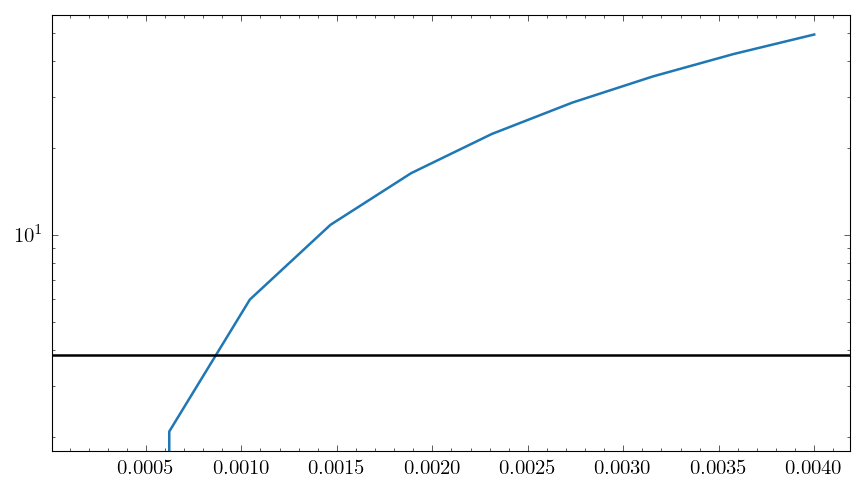

		determining the upper limit
		--->0.0008295061209511758

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.880409830415729e-17
		--->'mle_theta_er': 0.9971448294386445
		--->'mle_theta_nr': 1.1375941348974465
		defining the test statistic
		determining the upper limit
		--->0.0026934699417408

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.448209285438467e-17
		--->'mle_theta_er': 1.0007208162958836
		--->'mle_theta_nr': 1.129288275565134
		defining the test statistic
		determining the upper limit
		--->0.001130841777686541

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 7.425356009546637e-17
		--->'mle_theta_er': 1.00203962413117
		--->'mle_theta_nr': 1.14168289560729
		defining the test statistic
		determining the upper limit
		--->0.00359264451205

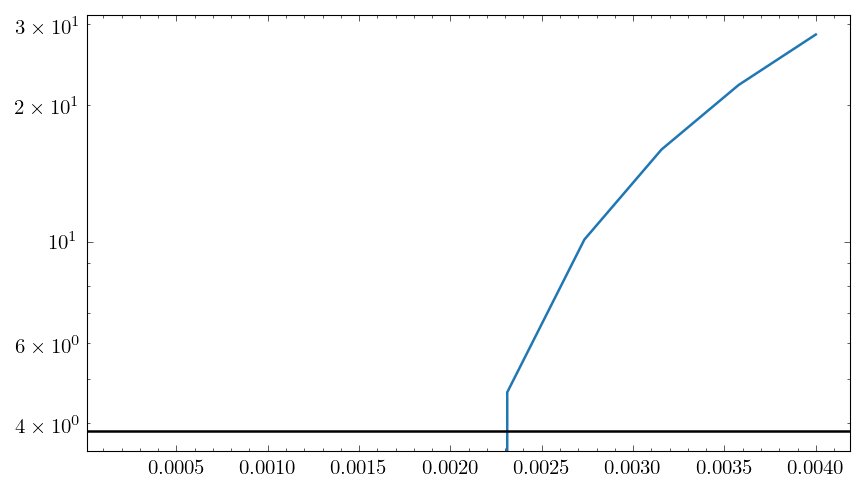

		determining the upper limit
		--->0.0022425550786069177

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 7.597195965730479e-17
		--->'mle_theta_er': 1.0022255072058195
		--->'mle_theta_nr': 1.135741493281747
		defining the test statistic
		determining the upper limit
		--->0.0032017753402111965

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 6.889884058406947e-17
		--->'mle_theta_er': 0.996477942249554
		--->'mle_theta_nr': 1.1922294156001623
		defining the test statistic
		determining the upper limit
		--->0.0024366691894566576

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.75199870459486e-17
		--->'mle_theta_er': 0.9976871756334733
		--->'mle_theta_nr': 1.0602558236567479
		defining the test statistic
		test statistic plot


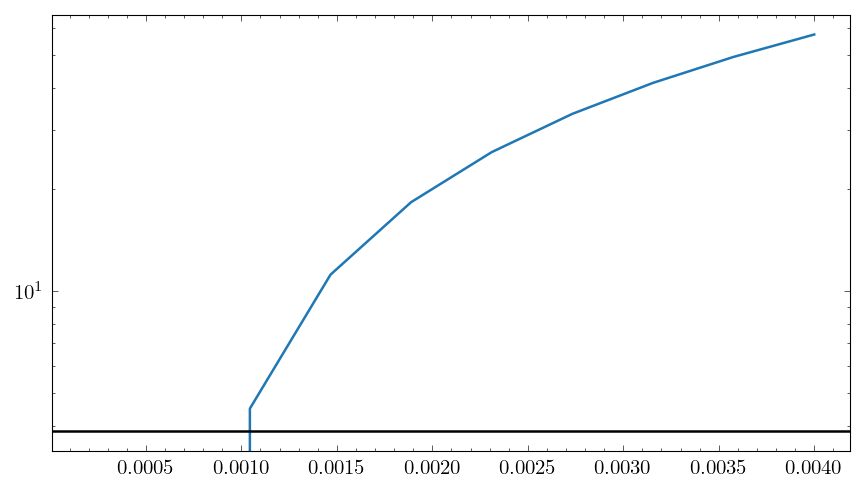

		determining the upper limit
		--->0.0010012390167238093

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.894036689204077e-17
		--->'mle_theta_er': 1.0010059441735875
		--->'mle_theta_nr': 1.1482589747039929
		defining the test statistic
		determining the upper limit
		--->0.0028686587236869403

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.918472449292206e-17
		--->'mle_theta_er': 0.9970058237116921
		--->'mle_theta_nr': 1.1267387323862774
		defining the test statistic
		determining the upper limit
		--->0.0010174912313017938

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.632775338456008e-17
		--->'mle_theta_er': 0.9993024702948874
		--->'mle_theta_nr': 1.1523437988823777
		defining the test statistic
		determining the upper limit
		--->0.00434

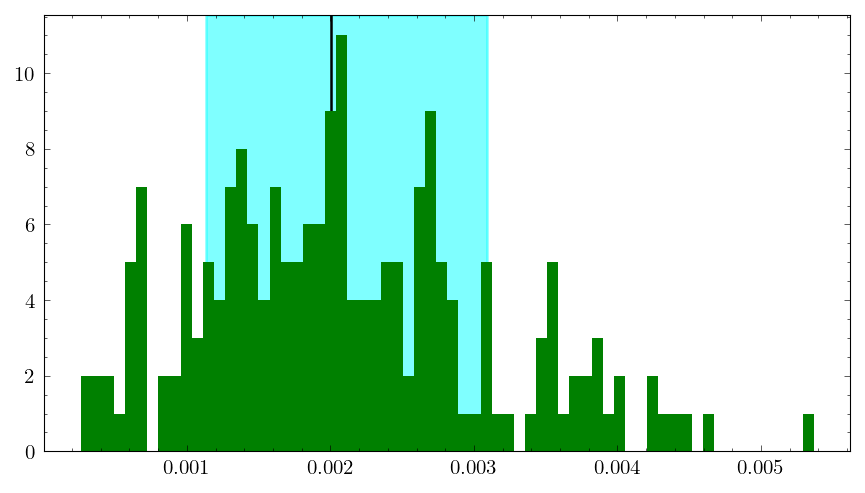

cwpec: starting WIMP mass loop with k=4/20 for 26.37 GeV
	calculating the PDF of the WIMP spectrum within the binned observable space
		calculating 'integral_spectrum_dict' for the high-statistics WIMP spectrum
######################### starting integration #########################
######################### finishing integration #########################
		generating the high-statistics WIMP signature by executing NEST
		calculating the PDF
		updating the 'spectrum_components_dict'
		deleting the high-statistics WIMP signature
		plotting spectral PDF for 'wimps'


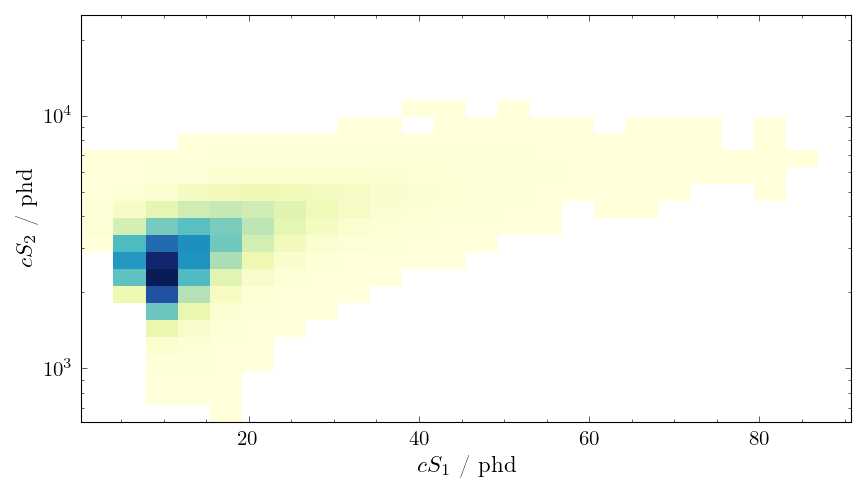

		finished within 3:05:22.779404 h'
	calculating the expected number of WIMP events within the binned observable space
		calculating the number of WIMP events expected within the WIMP EROI
######################### starting integration #########################
######################### finishing integration #########################
		updating the 'spectrum_components_dict'
		finished within 0:32:31.139774 h'
	simulating 200 background-only datasets
		generating the 'spectrum_dict's
######################### starting integration #########################
######################### finishing integration #########################
######################### starting integration #########################
######################### finishing integration #########################
		generating the ER and NR background 'signature's
	calculating the maximum likelihood parameter estimators

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
	

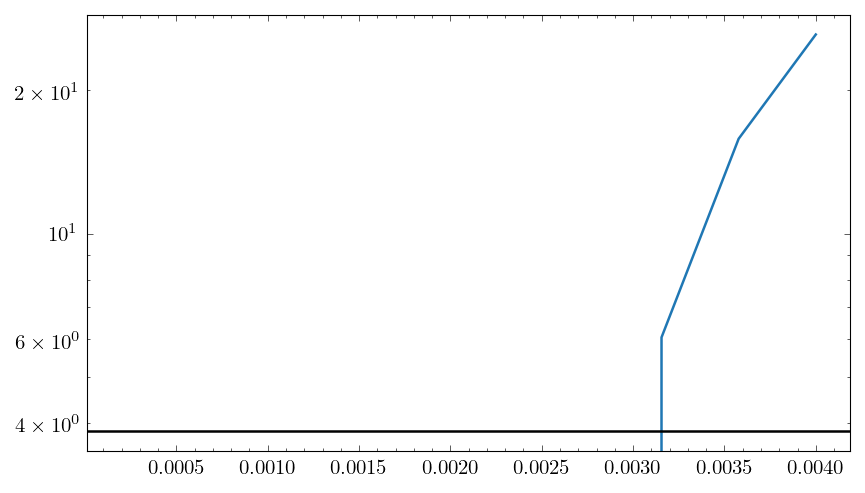

		determining the upper limit
		--->0.0030555116419753365
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 16
     iterations: 15
           root: 0.0030555116419753365

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.772553023860268e-17
		--->'mle_theta_er': 0.9788331643393289
		--->'mle_theta_nr': 1.1515718210118673
		defining the test statistic
		determining the upper limit
		--->0.0018967601140739505

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.247640152284141e-17
		--->'mle_theta_er': 0.975211153819042
		--->'mle_theta_nr': 1.1155844942444726
		defining the test statistic
		determining the upper limit
		--->0.002740646166772441

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_si

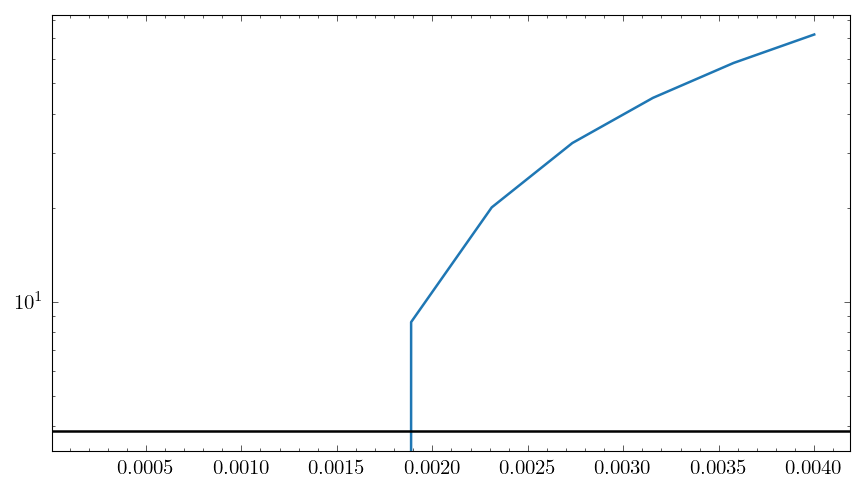

		determining the upper limit
		--->0.0017022350228741226

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.548986059152294e-17
		--->'mle_theta_er': 0.9760118838297343
		--->'mle_theta_nr': 0.9961739232160833
		defining the test statistic
		test statistic plot


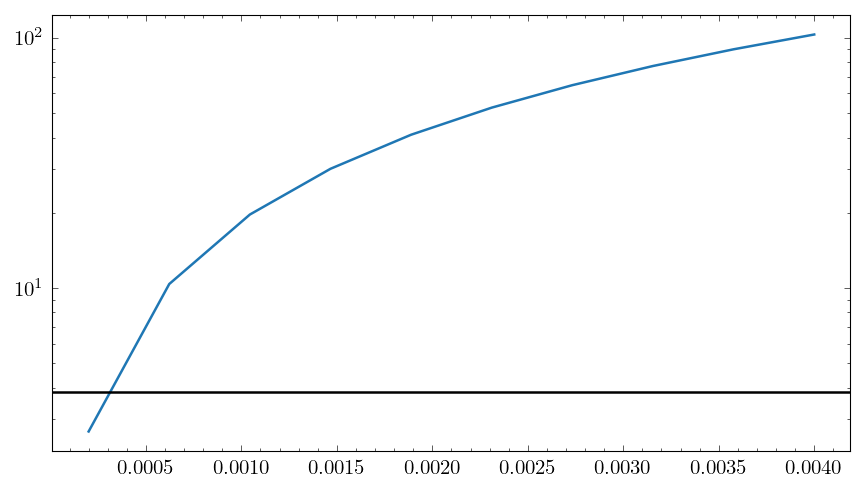

		determining the upper limit
		--->0.00027287706905795264

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.871976755873031e-17
		--->'mle_theta_er': 0.9800161780168688
		--->'mle_theta_nr': 1.1520117968311088
		defining the test statistic
		determining the upper limit
		--->0.001518332217623722

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.289816704011513e-17
		--->'mle_theta_er': 0.9754168330170185
		--->'mle_theta_nr': 1.1019577797895501
		defining the test statistic
		determining the upper limit
		--->0.0015118036475960577

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.98408892267062e-17
		--->'mle_theta_er': 0.9779883433648604
		--->'mle_theta_nr': 1.1511744750664383
		defining the test statistic
		determining the upper limit
		--->0.002299

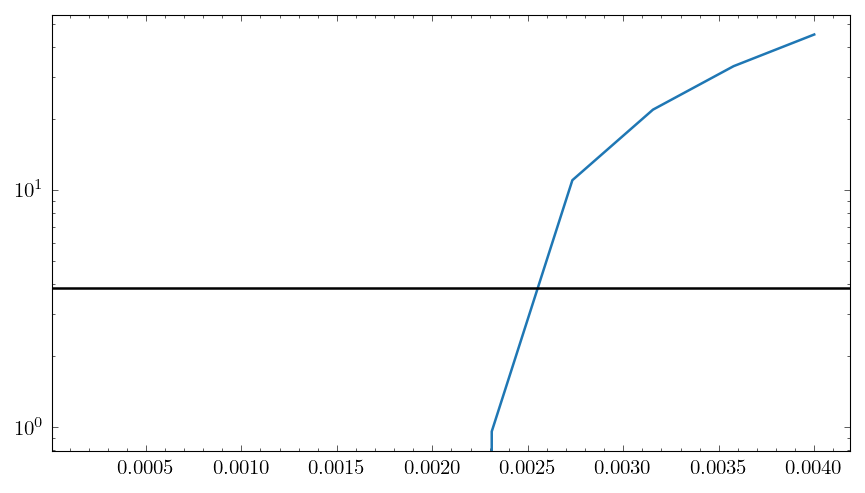

		determining the upper limit
		--->0.0024364265385486785
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 16
     iterations: 15
           root: 0.0024364265385486785

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.134439315238165e-17
		--->'mle_theta_er': 0.9730537849213456
		--->'mle_theta_nr': 1.1609071448139296
		defining the test statistic
		determining the upper limit
		--->0.002150250090499255

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 7.442336889668446e-17
		--->'mle_theta_er': 0.9772384854143592
		--->'mle_theta_nr': 1.231195959225222
		defining the test statistic
		determining the upper limit
		--->0.003160305878382493

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sig

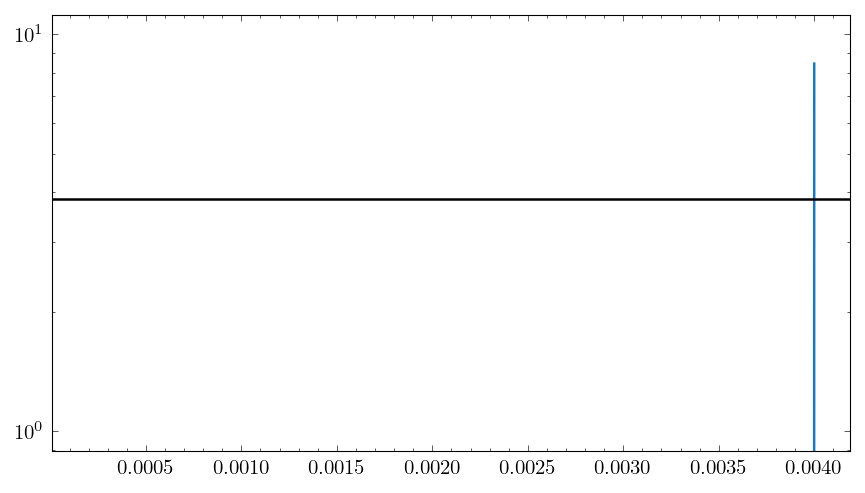

		determining the upper limit
		--->0.0038060603391321464

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.027585993506826e-17
		--->'mle_theta_er': 0.9767893442337272
		--->'mle_theta_nr': 1.2126927079675114
		defining the test statistic
		determining the upper limit
		--->0.001772677070688928

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.201178188536693e-17
		--->'mle_theta_er': 0.9791982843178113
		--->'mle_theta_nr': 1.0791723126420076
		defining the test statistic
		determining the upper limit
		--->0.0007067903098622275

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.921560913393421e-17
		--->'mle_theta_er': 0.9792097060992728
		--->'mle_theta_nr': 1.1380937972091667
		defining the test statistic
		determining the upper limit
		--->0.000491

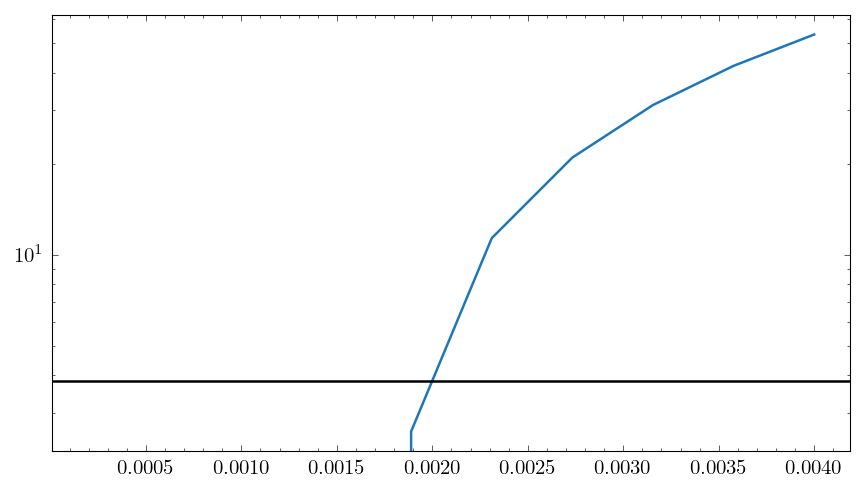

		determining the upper limit
		--->0.0019514061245648944
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 16
     iterations: 15
           root: 0.0019514061245648944

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.818724574581768e-17
		--->'mle_theta_er': 0.978474883482756
		--->'mle_theta_nr': 1.1584986164546265
		defining the test statistic
		determining the upper limit
		--->0.0023438065637228587

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.116481902370119e-17
		--->'mle_theta_er': 0.9700011756605824
		--->'mle_theta_nr': 1.2712033830735718
		defining the test statistic
		determining the upper limit
		--->0.0031607479478950075

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_s

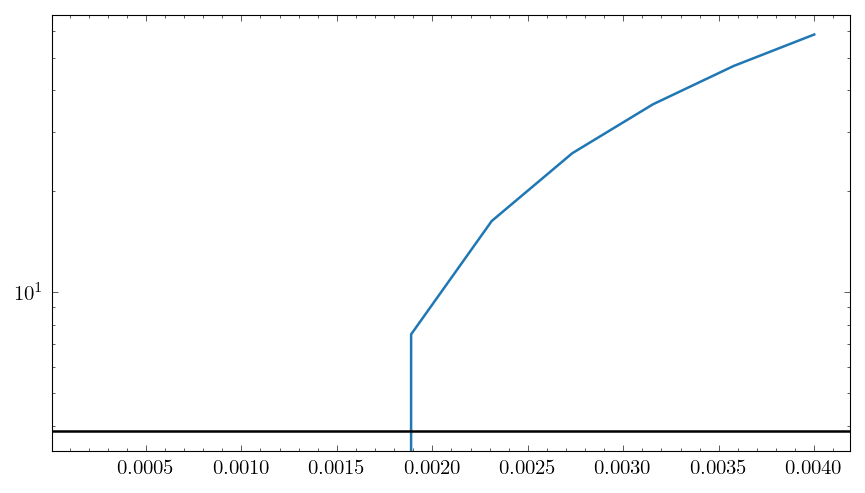

		determining the upper limit
		--->0.0016977381050144404

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.247050644961133e-17
		--->'mle_theta_er': 0.9756239977774293
		--->'mle_theta_nr': 1.0874626399376937
		defining the test statistic
		determining the upper limit
		--->0.0015733608440984558

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.007256878829527e-17
		--->'mle_theta_er': 0.9750735974360851
		--->'mle_theta_nr': 1.2203082554241458
		defining the test statistic
		determining the upper limit
		--->0.002811009896160985

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.128638834667918e-17
		--->'mle_theta_er': 0.9730171090780225
		--->'mle_theta_nr': 1.328198175423775
		defining the test statistic
		determining the upper limit
		--->0.0039604

		--->0.00044882476046659975

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.041564893818937e-17
		--->'mle_theta_er': 0.9772791715047654
		--->'mle_theta_nr': 1.101491493950275
		defining the test statistic
		determining the upper limit
		--->0.0019913276420188857

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.30199876384991e-17
		--->'mle_theta_er': 0.9791900184368729
		--->'mle_theta_nr': 1.2554360641646247
		defining the test statistic
		determining the upper limit
		--->0.0020734647324798195

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.875121726359302e-17
		--->'mle_theta_er': 0.9761077354930365
		--->'mle_theta_nr': 1.2665341703721733
		defining the test statistic
		determining the upper limit
		--->0.00253538466406093

		a priori calcul

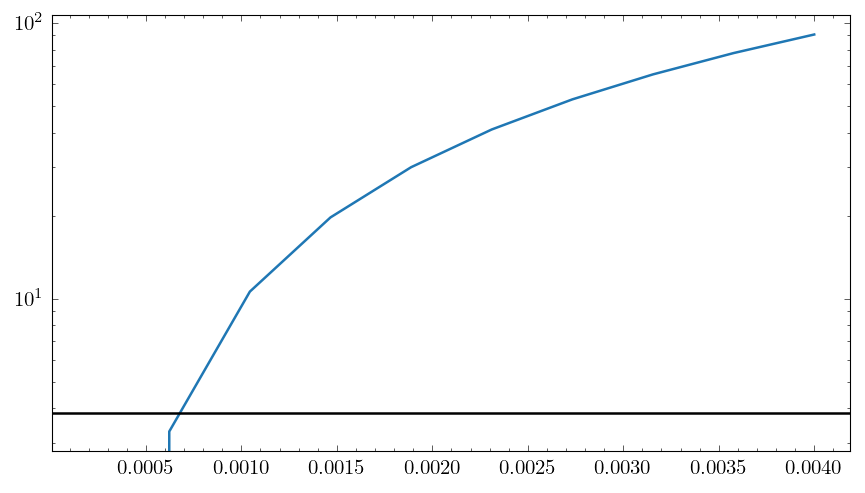

		determining the upper limit
		--->0.0006594370498089747

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.856466575544644e-17
		--->'mle_theta_er': 0.9793530997623423
		--->'mle_theta_nr': 1.1472287266306789
		defining the test statistic
		determining the upper limit
		--->0.0020056769654998785

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.091050984593838e-17
		--->'mle_theta_er': 0.9757336303843136
		--->'mle_theta_nr': 1.1702316240403556
		defining the test statistic
		determining the upper limit
		--->0.002977434358380915

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.646068608659462e-17
		--->'mle_theta_er': 0.9768047376250086
		--->'mle_theta_nr': 1.1509158895940321
		defining the test statistic
		determining the upper limit
		--->0.002290

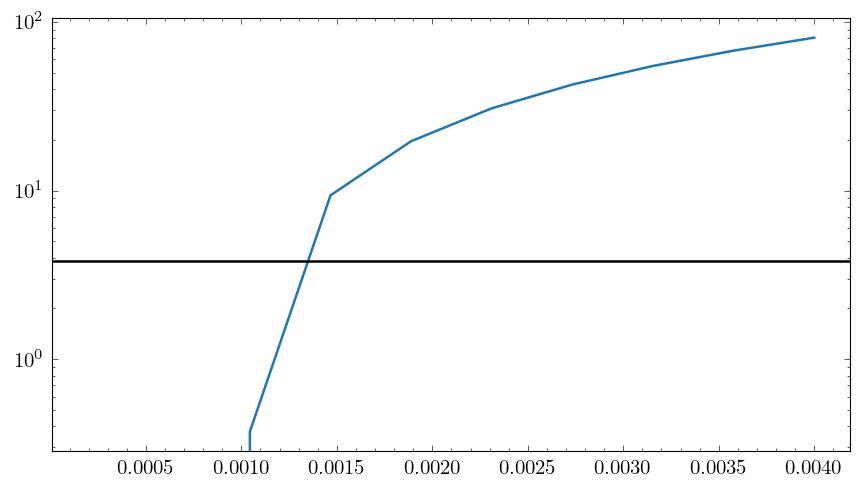

		determining the upper limit
		--->0.001216229342055696

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.277764635359684e-17
		--->'mle_theta_er': 0.9764836239012393
		--->'mle_theta_nr': 1.082165625696331
		defining the test statistic
		determining the upper limit
		--->0.001374237018704312

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.317007003945767e-17
		--->'mle_theta_er': 0.9737742373237577
		--->'mle_theta_nr': 1.145676332600623
		defining the test statistic
		determining the upper limit
		--->0.0012199279126704479

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.080201261626035e-17
		--->'mle_theta_er': 0.9729362833659374
		--->'mle_theta_nr': 1.1428417035910816
		defining the test statistic
		determining the upper limit
		--->0.001923096

		--->0.0015794126730665574

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.428812551302763e-17
		--->'mle_theta_er': 0.9792848362162193
		--->'mle_theta_nr': 1.2261615617072985
		defining the test statistic
		determining the upper limit
		--->0.003715039181502932

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.507293600027734e-17
		--->'mle_theta_er': 0.9788505257157478
		--->'mle_theta_nr': 1.2027090523554462
		defining the test statistic
		determining the upper limit
		--->0.0019193808579246376
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 16
     iterations: 15
           root: 0.0019193808579246376

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.821995739033293e-17
	

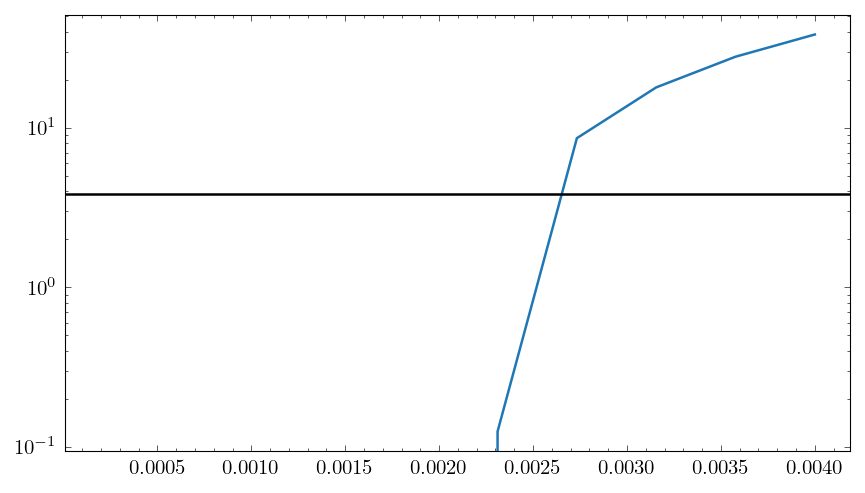

		determining the upper limit
		--->0.0025017638149721568

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 7.767452206069042e-17
		--->'mle_theta_er': 0.9754074796068588
		--->'mle_theta_nr': 1.1660655914811298
		defining the test statistic
		determining the upper limit
		--->0.0021452961245974913

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.367637426798044e-17
		--->'mle_theta_er': 0.9745812944067704
		--->'mle_theta_nr': 1.030068953950956
		defining the test statistic
		determining the upper limit
		--->0.0011252218568680314

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.089520668466996e-17
		--->'mle_theta_er': 0.9793570245614942
		--->'mle_theta_nr': 1.0832546259824363
		defining the test statistic
		determining the upper limit
		--->0.001275

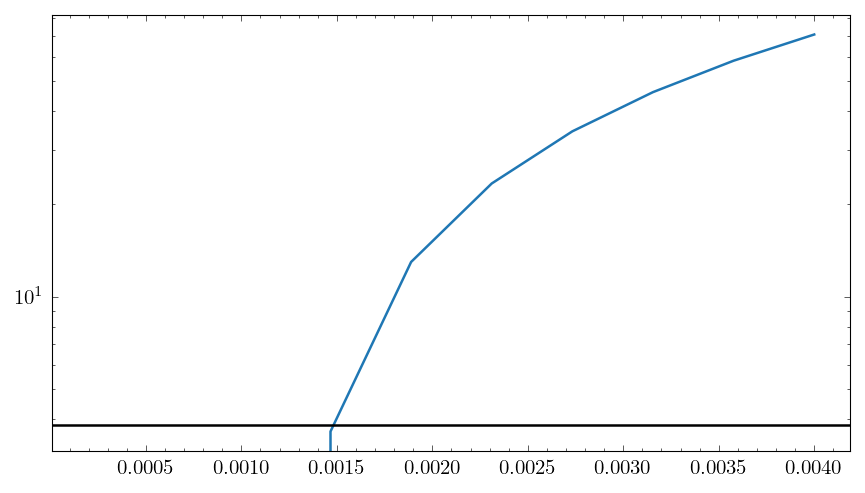

		determining the upper limit
		--->0.0014758400664131265

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.919698327094941e-17
		--->'mle_theta_er': 0.9708398222750132
		--->'mle_theta_nr': 1.2215697918883426
		defining the test statistic
		test statistic plot


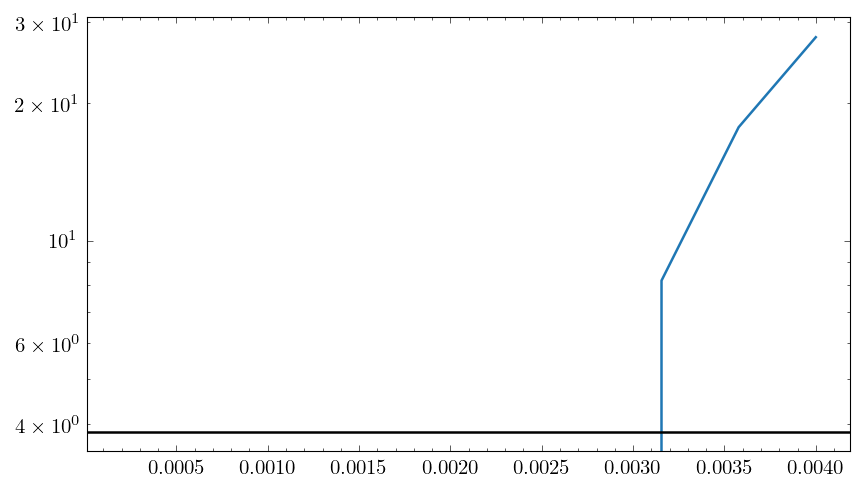

		determining the upper limit
		--->0.0029508505873840525

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.436347668389094e-17
		--->'mle_theta_er': 0.9763234960837741
		--->'mle_theta_nr': 1.0082062309575313
		defining the test statistic
		determining the upper limit
		--->0.00039348896646880293

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.571077163729563e-17
		--->'mle_theta_er': 0.979486652028563
		--->'mle_theta_nr': 1.2679993337451518
		defining the test statistic
		determining the upper limit
		--->0.002925467243320875

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.162795919992632e-17
		--->'mle_theta_er': 0.9754643845853838
		--->'mle_theta_nr': 1.1462920330156803
		defining the test statistic
		determining the upper limit
		--->0.001697

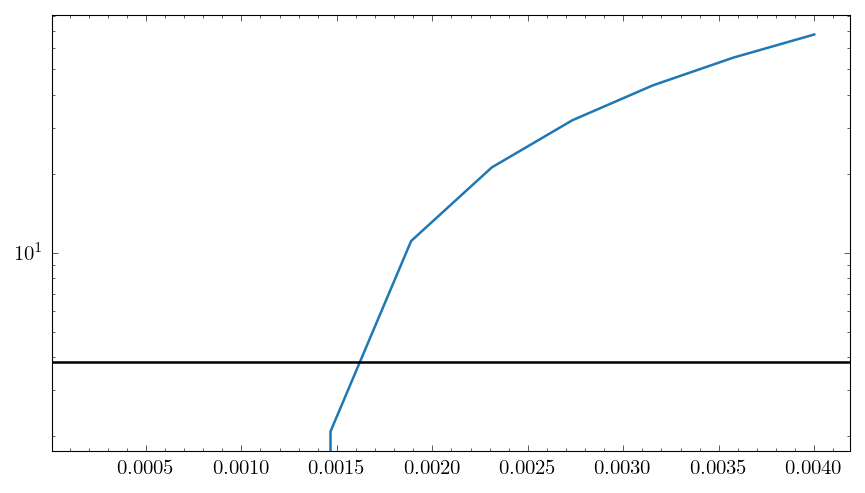

		determining the upper limit
		--->0.0015536641316066773
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 16
     iterations: 15
           root: 0.0015536641316066773

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.113753035468285e-17
		--->'mle_theta_er': 0.9688386573680505
		--->'mle_theta_nr': 1.155842175688857
		defining the test statistic
		determining the upper limit
		--->0.001613816601646304

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.99745851240179e-17
		--->'mle_theta_er': 0.9755815514337602
		--->'mle_theta_nr': 1.272080156765424
		defining the test statistic
		determining the upper limit
		--->0.0029663000315034724

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigm

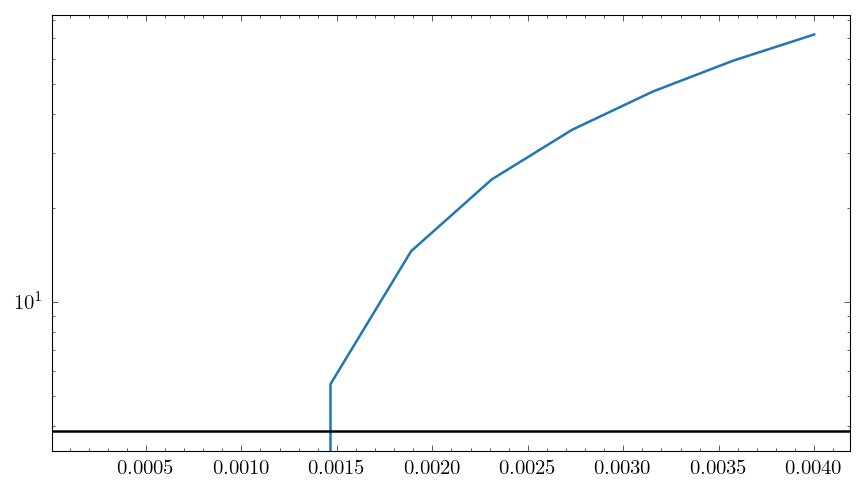

		determining the upper limit
		--->0.0013847428833727268

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.228724524518662e-17
		--->'mle_theta_er': 0.9704030884897173
		--->'mle_theta_nr': 1.0781224360309238
		defining the test statistic
		determining the upper limit
		--->0.0007805821067209988

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.771897169889024e-17
		--->'mle_theta_er': 0.9788330242096087
		--->'mle_theta_nr': 1.1516196370989942
		defining the test statistic
		determining the upper limit
		--->0.0021109132671136934

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.476331730215212e-17
		--->'mle_theta_er': 0.9793193360034187
		--->'mle_theta_nr': 1.2152088931615461
		defining the test statistic
		determining the upper limit
		--->0.00334

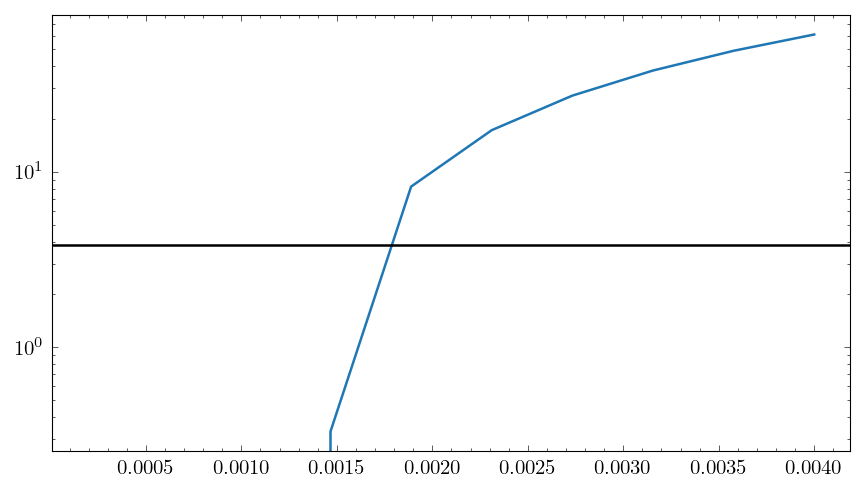

		determining the upper limit
		--->0.001662882571957584

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.827873565265939e-17
		--->'mle_theta_er': 0.9808223481360779
		--->'mle_theta_nr': 1.1657715781510485
		defining the test statistic
		determining the upper limit
		--->0.003263282348137669

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.115038816095006e-17
		--->'mle_theta_er': 0.9771977841873665
		--->'mle_theta_nr': 1.0674046208105021
		defining the test statistic
		determining the upper limit
		--->0.0007194654153036028
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 13
     iterations: 12
           root: 0.0007194654153036028

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_si

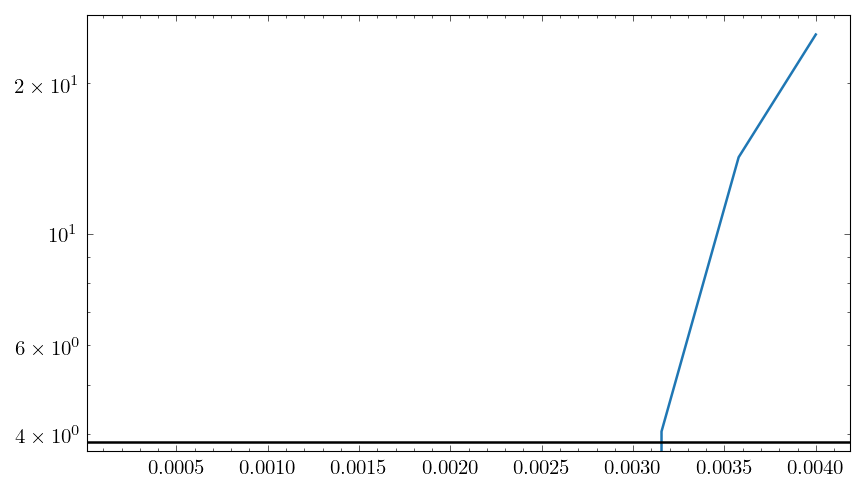

		determining the upper limit
		--->0.003147177397825274

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.670582630107092e-17
		--->'mle_theta_er': 0.9776540121978238
		--->'mle_theta_nr': 1.2066586916585487
		defining the test statistic
		determining the upper limit
		--->0.002325447893596691

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.414518803514524e-17
		--->'mle_theta_er': 0.9681451801485415
		--->'mle_theta_nr': 1.1006054994544368
		defining the test statistic
		determining the upper limit
		--->0.0013371553826812316

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.075141670004657e-17
		--->'mle_theta_er': 0.9781925484947418
		--->'mle_theta_nr': 1.138805898936647
		defining the test statistic
		test statistic plot


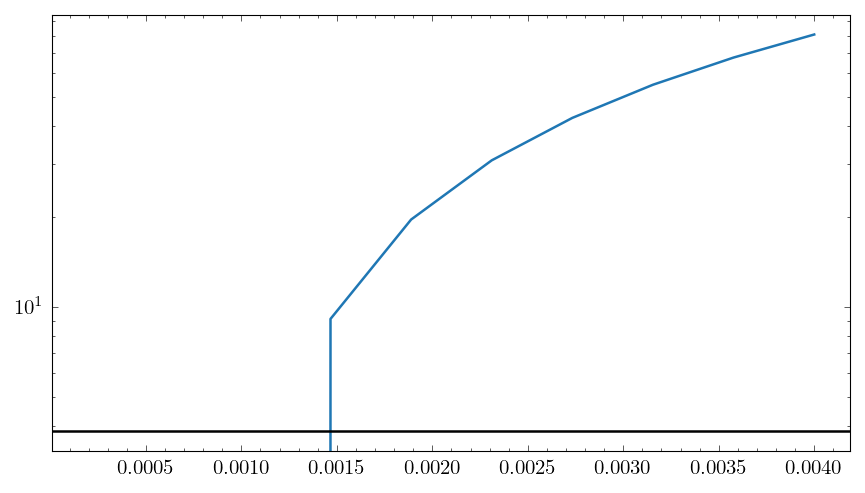

		determining the upper limit
		--->0.0012343278883153164

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.830384035046562e-17
		--->'mle_theta_er': 0.9766452849980567
		--->'mle_theta_nr': 1.307092079222102
		defining the test statistic
		determining the upper limit
		--->0.0030883963597237523

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.600742008005976e-17
		--->'mle_theta_er': 0.9813822244490976
		--->'mle_theta_nr': 1.2047164087030762
		defining the test statistic
		determining the upper limit
		--->0.0022842921770371742

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.162710119857428e-17
		--->'mle_theta_er': 0.9762674519038639
		--->'mle_theta_nr': 1.1612373183313998
		defining the test statistic
		determining the upper limit
		--->0.001604

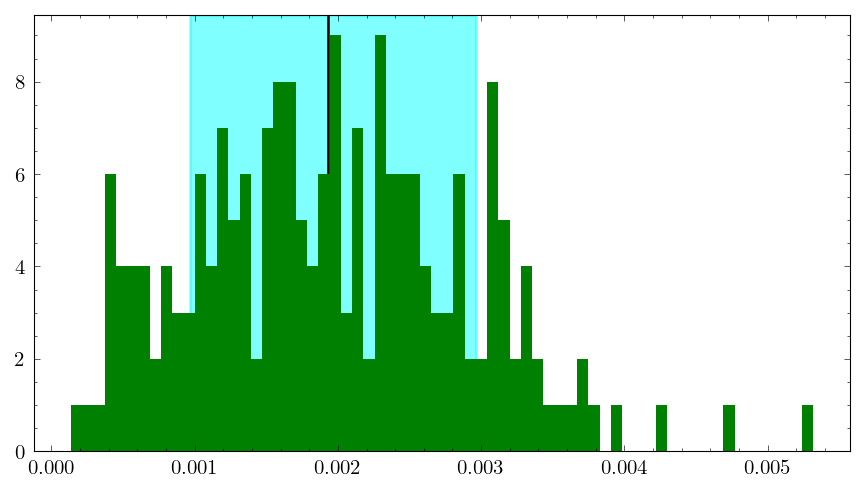

cwpec: starting WIMP mass loop with k=5/20 for 33.60 GeV
	calculating the PDF of the WIMP spectrum within the binned observable space
		calculating 'integral_spectrum_dict' for the high-statistics WIMP spectrum
######################### starting integration #########################
######################### finishing integration #########################


/home/daniel/Desktop/arbeitsstuff/sfs/github_repo_v2/sfs.py:1614: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  expected_number_of_events_float_per_energy_bin = [exposure_t_y *integrate.quad(


		generating the high-statistics WIMP signature by executing NEST
		calculating the PDF
		updating the 'spectrum_components_dict'
		deleting the high-statistics WIMP signature
		plotting spectral PDF for 'wimps'


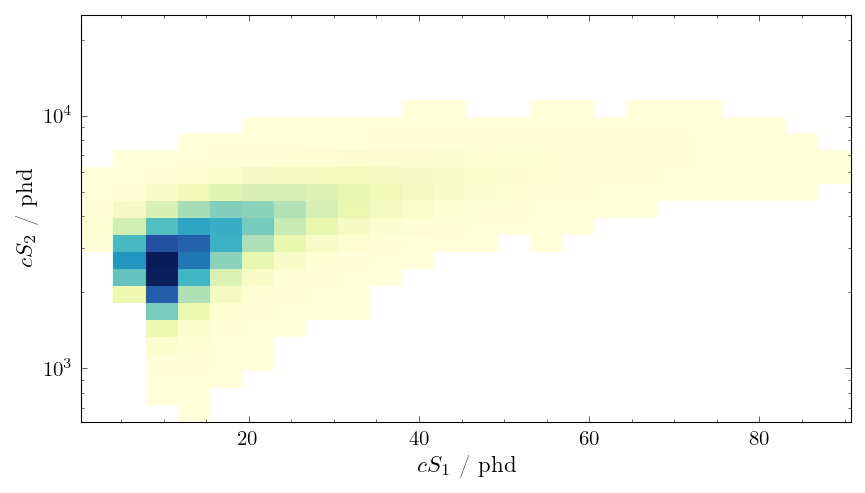

		finished within 3:59:38.307797 h'
	calculating the expected number of WIMP events within the binned observable space
		calculating the number of WIMP events expected within the WIMP EROI
######################### starting integration #########################
######################### finishing integration #########################
		updating the 'spectrum_components_dict'
		finished within 0:35:50.542681 h'
	simulating 200 background-only datasets
		generating the 'spectrum_dict's
######################### starting integration #########################
######################### finishing integration #########################
######################### starting integration #########################
######################### finishing integration #########################
		generating the ER and NR background 'signature's
	calculating the maximum likelihood parameter estimators

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
	

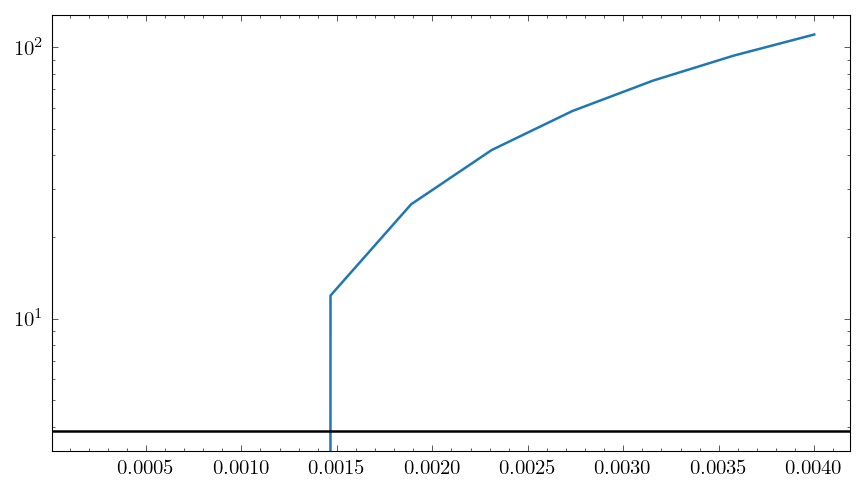

		determining the upper limit
		--->0.0011943244293242793

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.426818375397643e-17
		--->'mle_theta_er': 0.982791714976881
		--->'mle_theta_nr': 0.9905973998698108
		defining the test statistic
		determining the upper limit
		--->0.00012653921239055006

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.877079743692996e-17
		--->'mle_theta_er': 0.9807205622875207
		--->'mle_theta_nr': 1.0793490742489507
		defining the test statistic
		determining the upper limit
		--->0.001025853581145891
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 16
     iterations: 15
           root: 0.001025853581145891

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_si

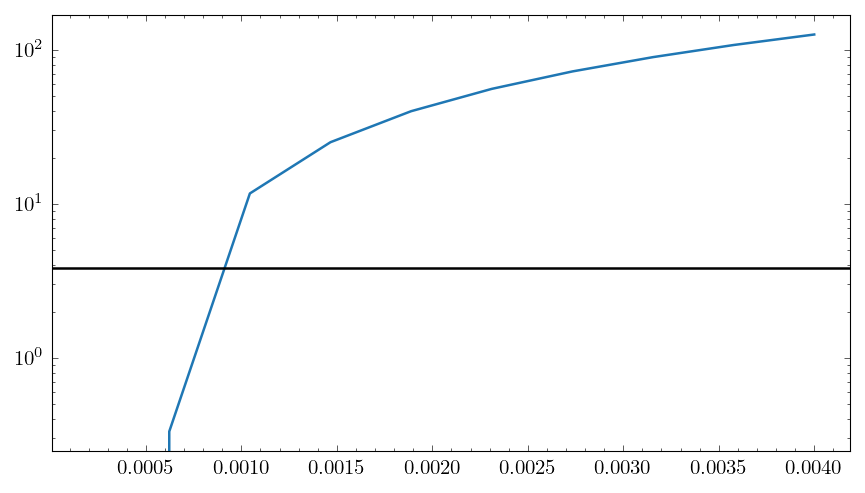

		determining the upper limit
		--->0.0007644380824111123

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.399542239749073e-17
		--->'mle_theta_er': 0.9819301070968325
		--->'mle_theta_nr': 0.9977297473261983
		defining the test statistic
		determining the upper limit
		--->0.00022427536945938056

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.45101459842371e-17
		--->'mle_theta_er': 0.9849714344186884
		--->'mle_theta_nr': 0.9995540045812454
		defining the test statistic
		determining the upper limit
		--->0.0002950618335878911

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.515491548128969e-17
		--->'mle_theta_er': 0.9866673453096957
		--->'mle_theta_nr': 0.9977371742194785
		defining the test statistic
		determining the upper limit
		--->0.00025

		--->0.0002839840411759302

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.452985541279958e-17
		--->'mle_theta_er': 0.977190325346946
		--->'mle_theta_nr': 0.9988476840938542
		defining the test statistic
		determining the upper limit
		--->0.00023349029824132738

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.21485111190892e-17
		--->'mle_theta_er': 0.9829384386468799
		--->'mle_theta_nr': 1.072089495113591
		defining the test statistic
		determining the upper limit
		--->0.0008120728490462615

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.242048628417187e-17
		--->'mle_theta_er': 0.9817516351853346
		--->'mle_theta_nr': 1.0730786116786788
		defining the test statistic
		determining the upper limit
		--->0.0008822576086643551

		a priori calcu

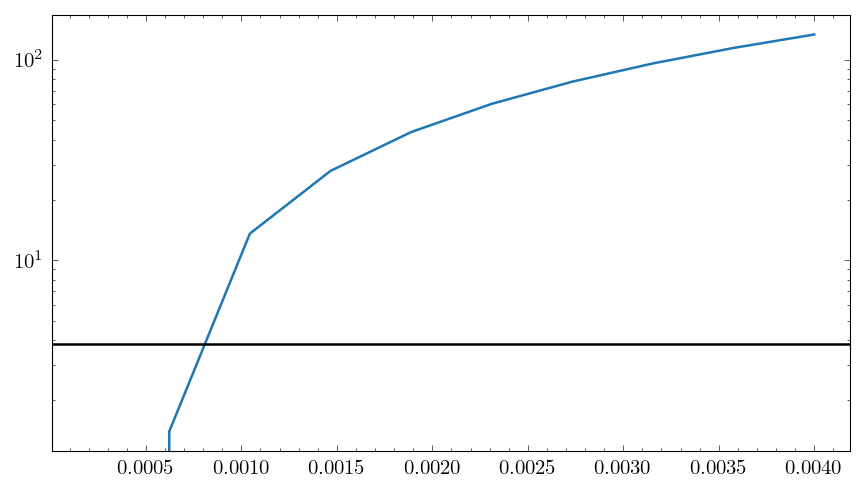

		determining the upper limit
		--->0.0007156739032353459

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.548069166418705e-17
		--->'mle_theta_er': 0.9876808429049074
		--->'mle_theta_nr': 1.0700370005822055
		defining the test statistic
		determining the upper limit
		--->0.0008019866456708608

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.643180304870768e-17
		--->'mle_theta_er': 0.9895172157753924
		--->'mle_theta_nr': 1.0797645766670967
		defining the test statistic
		determining the upper limit
		--->0.0014677614343675054

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.150946602083263e-17
		--->'mle_theta_er': 0.9827570909529346
		--->'mle_theta_nr': 1.0768920912201434
		defining the test statistic
		determining the upper limit
		--->0.00098

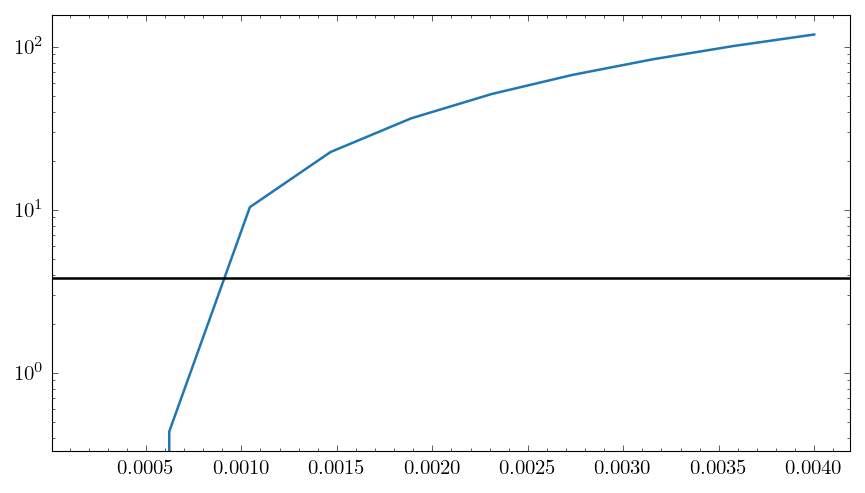

		determining the upper limit
		--->0.0007813328353104357

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.276008025994609e-17
		--->'mle_theta_er': 0.98412518858536
		--->'mle_theta_nr': 0.9996917779614098
		defining the test statistic
		determining the upper limit
		--->0.0002805734474554724

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.678700762883804e-17
		--->'mle_theta_er': 0.9825997975328862
		--->'mle_theta_nr': 1.13582639843859
		defining the test statistic
		determining the upper limit
		--->0.0014209355691086507

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.259884124841013e-17
		--->'mle_theta_er': 0.9842945922285173
		--->'mle_theta_nr': 1.0710358012896282
		defining the test statistic
		determining the upper limit
		--->0.000818212

		--->0.0008226552095460755

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.412290623965173e-17
		--->'mle_theta_er': 0.9807501561992807
		--->'mle_theta_nr': 0.9957489491071201
		defining the test statistic
		determining the upper limit
		--->0.00016294721574613315

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.296566977671391e-17
		--->'mle_theta_er': 0.976680006407479
		--->'mle_theta_nr': 1.0714622757718772
		defining the test statistic
		determining the upper limit
		--->0.0009544287496979178
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 16
     iterations: 15
           root: 0.0009544287496979178

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.500241996236214e-17


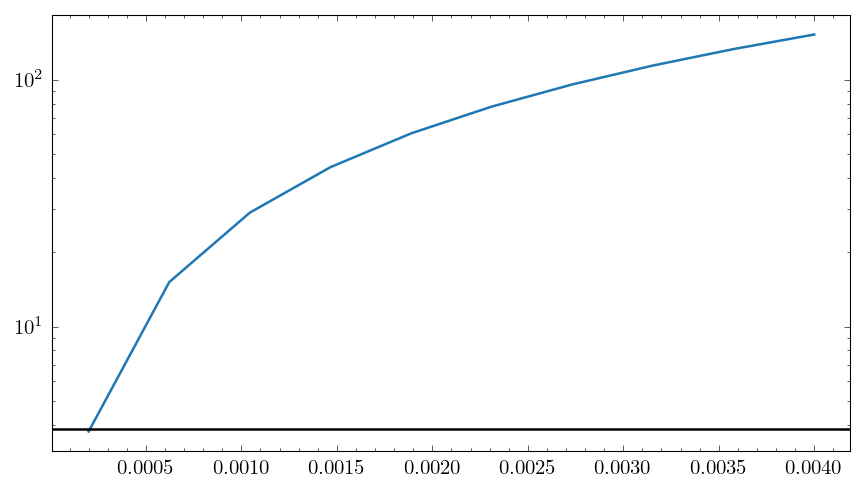

		determining the upper limit
		--->0.00020366970631901547

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.512279212141605e-17
		--->'mle_theta_er': 0.9829221518800484
		--->'mle_theta_nr': 1.0080819664386196
		defining the test statistic
		determining the upper limit
		--->0.0005916663821895879

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.544775736869774e-17
		--->'mle_theta_er': 0.9788790628508799
		--->'mle_theta_nr': 1.0002758341505738
		defining the test statistic
		determining the upper limit
		--->0.0002963073618603675

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.616183984312089e-17
		--->'mle_theta_er': 0.9866802659940899
		--->'mle_theta_nr': 0.9918415824579008
		defining the test statistic
		determining the upper limit
		--->0.0001

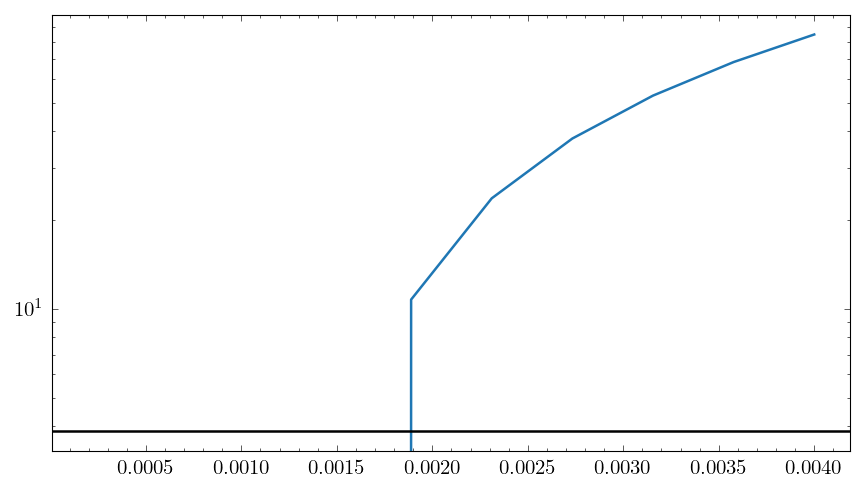

		determining the upper limit
		--->0.0016421039688745203

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.067732561003818e-17
		--->'mle_theta_er': 0.9819267388521673
		--->'mle_theta_nr': 1.1345013725448077
		defining the test statistic
		determining the upper limit
		--->0.0011410284579661987

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.230517436010847e-17
		--->'mle_theta_er': 0.9827722394898932
		--->'mle_theta_nr': 1.070911592941735
		defining the test statistic
		determining the upper limit
		--->0.0007247339355678162

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.53898534292588e-17
		--->'mle_theta_er': 0.9910595592793365
		--->'mle_theta_nr': 1.1356727876391242
		defining the test statistic
		determining the upper limit
		--->0.0013370

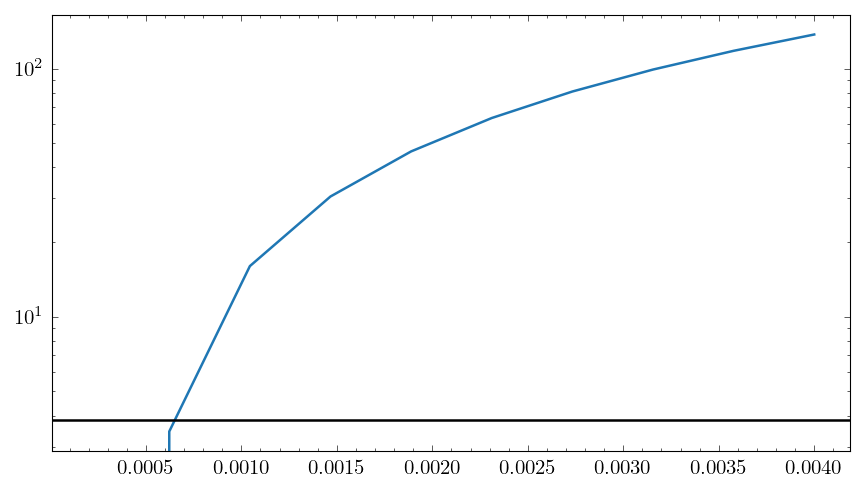

		determining the upper limit
		--->0.0006369929195784834

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.516383069805737e-17
		--->'mle_theta_er': 0.9886979533531333
		--->'mle_theta_nr': 0.9975646584945252
		defining the test statistic
		determining the upper limit
		--->0.00025832598414310756

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.696402449989869e-17
		--->'mle_theta_er': 0.9810793793223329
		--->'mle_theta_nr': 0.999879091151134
		defining the test statistic
		determining the upper limit
		--->0.00028716182397513923

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.203870638698168e-17
		--->'mle_theta_er': 0.9817151349245876
		--->'mle_theta_nr': 1.0873457696328321
		defining the test statistic
		determining the upper limit
		--->0.0017

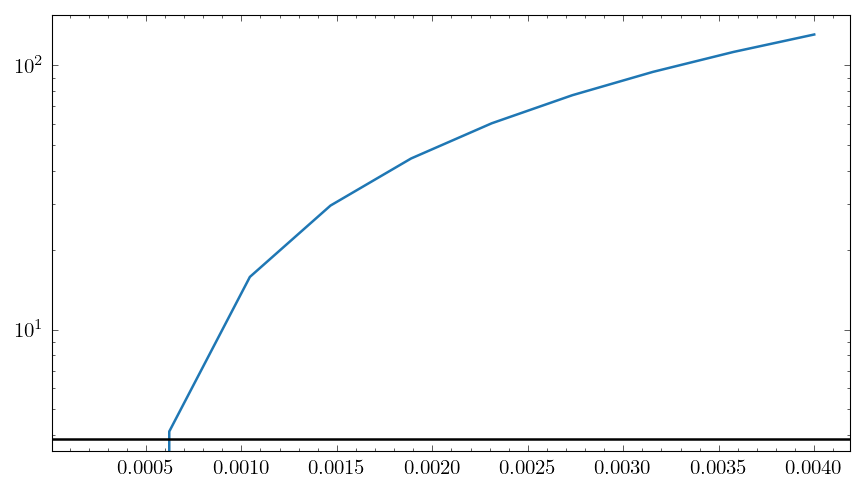

		determining the upper limit
		--->0.0006109951532259194

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.410362741569853e-17
		--->'mle_theta_er': 0.980759727638205
		--->'mle_theta_nr': 0.9913887595052845
		defining the test statistic
		determining the upper limit
		--->0.0001270017140499643

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.181568834341705e-17
		--->'mle_theta_er': 0.9800421752533123
		--->'mle_theta_nr': 1.079988845115662
		defining the test statistic
		determining the upper limit
		--->0.0013137797340789968
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 18
     iterations: 17
           root: 0.0013137797340789968

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_si

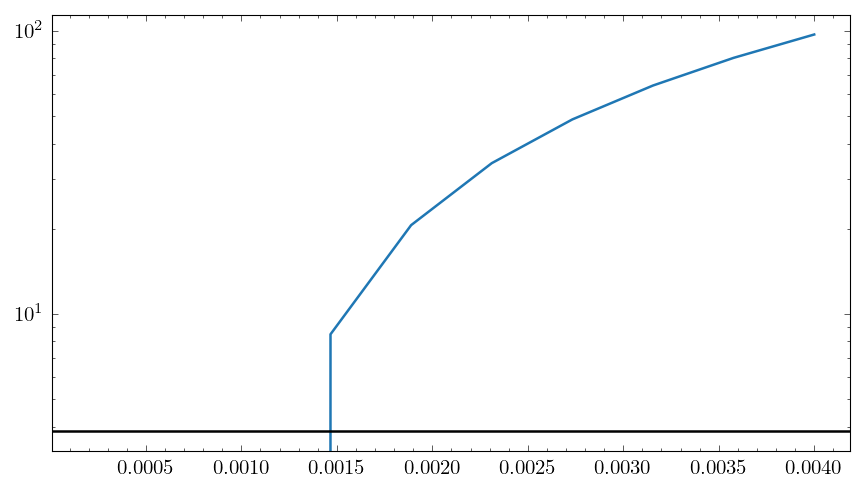

		determining the upper limit
		--->0.0012866347607027526

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.343670058682692e-17
		--->'mle_theta_er': 0.9864723790050787
		--->'mle_theta_nr': 1.0795761810322502
		defining the test statistic
		test statistic plot


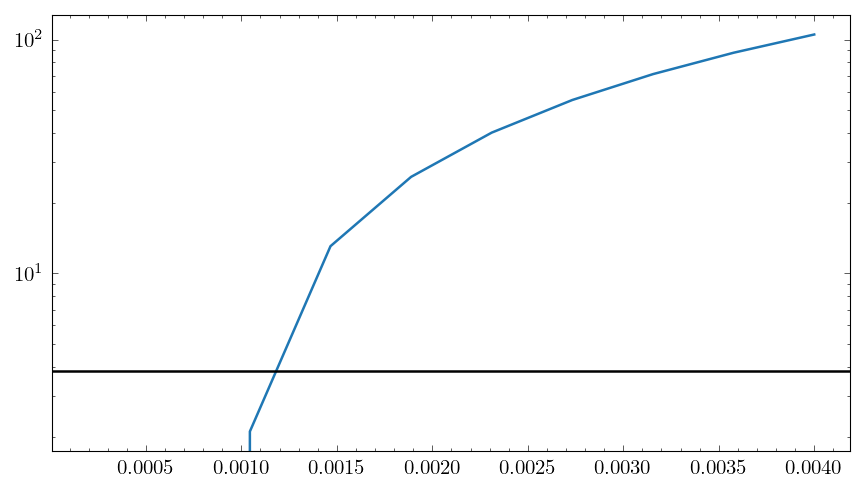

		determining the upper limit
		--->0.001117419783832869

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.057268323591805e-17
		--->'mle_theta_er': 0.9820920646890687
		--->'mle_theta_nr': 1.0722739156154253
		defining the test statistic
		determining the upper limit
		--->0.0007949689530335718

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.547519046683261e-17
		--->'mle_theta_er': 0.9836067413796379
		--->'mle_theta_nr': 1.1387425484041866
		defining the test statistic
		determining the upper limit
		--->0.0013538314575814922

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.273287283561301e-17
		--->'mle_theta_er': 0.9853171363931117
		--->'mle_theta_nr': 0.9962439826050793
		defining the test statistic
		test statistic plot


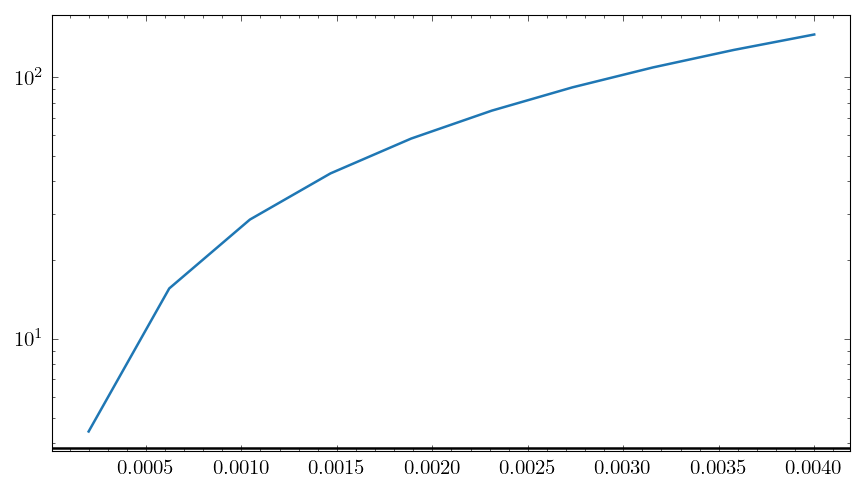

		determining the upper limit
		--->0.00017527700880258588

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.173423282694391e-17
		--->'mle_theta_er': 0.9839626607627945
		--->'mle_theta_nr': 1.132460895738721
		defining the test statistic
		test statistic plot


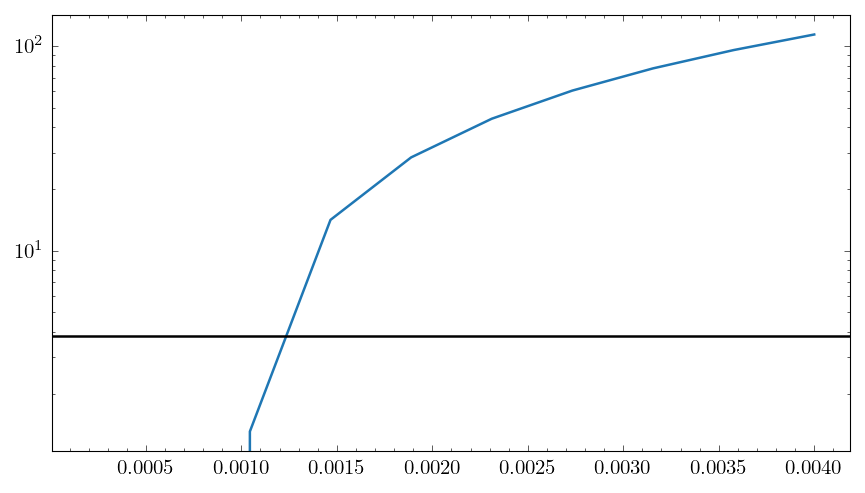

		determining the upper limit
		--->0.001133471885977969

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.408215759933741e-17
		--->'mle_theta_er': 0.984967146362637
		--->'mle_theta_nr': 1.0014846759680256
		defining the test statistic
		test statistic plot


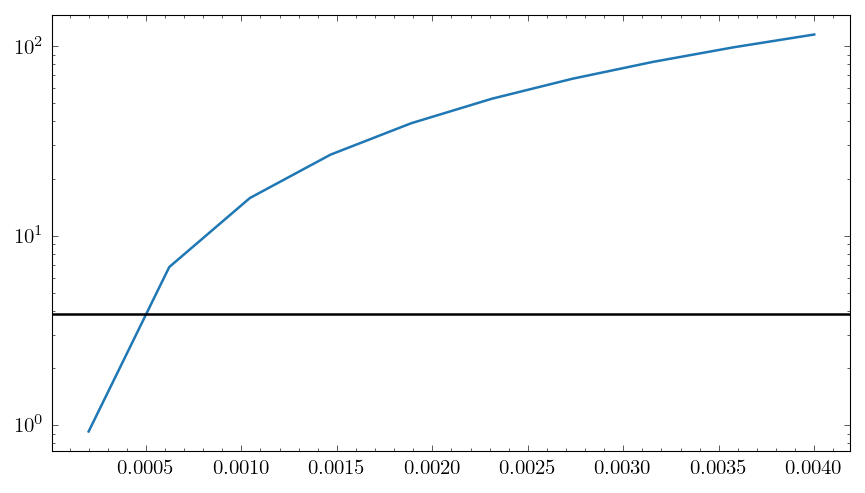

		determining the upper limit
		--->0.0004431352165784882

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.931181500744783e-17
		--->'mle_theta_er': 0.9912249534353978
		--->'mle_theta_nr': 1.0735208771458908
		defining the test statistic
		determining the upper limit
		--->0.0008613495272534942

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.54096988729683e-17
		--->'mle_theta_er': 0.9785517484874855
		--->'mle_theta_nr': 0.9952560902609997
		defining the test statistic
		determining the upper limit
		--->0.0002077767032091826

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.55713218196633e-17
		--->'mle_theta_er': 0.9858146801822891
		--->'mle_theta_nr': 1.0007675901765671
		defining the test statistic
		determining the upper limit
		--->0.0003107

		--->'mle_sigma': 9.086932833093094e-17
		--->'mle_theta_er': 0.9822615743532177
		--->'mle_theta_nr': 1.0721356562624664
		defining the test statistic
		determining the upper limit
		--->0.0008219269164491

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.715165903952333e-17
		--->'mle_theta_er': 0.9849329198041055
		--->'mle_theta_nr': 1.1484178798052267
		defining the test statistic
		determining the upper limit
		--->0.002370105707964688

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.117089489402945e-17
		--->'mle_theta_er': 0.980228171177328
		--->'mle_theta_nr': 1.073379015369685
		defining the test statistic
		determining the upper limit
		--->0.0009732808189654263

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.747529061544738e-17
		--->'m

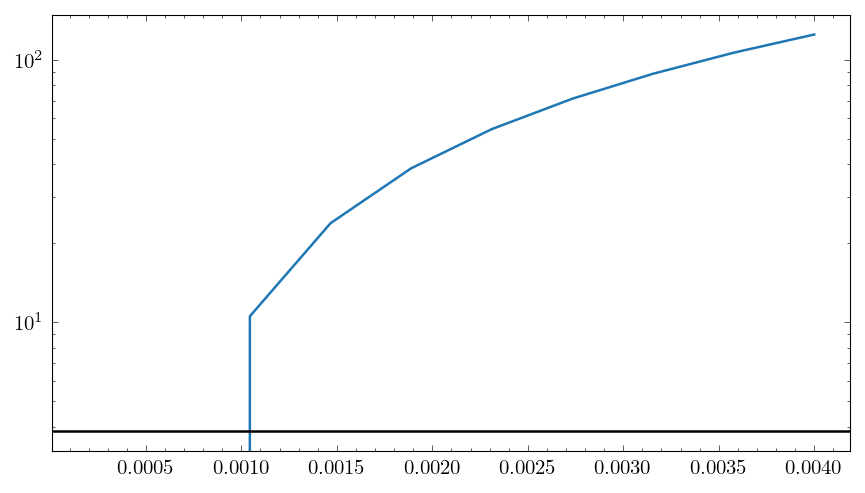

		determining the upper limit
		--->0.0008024068885148579

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.08790411818429e-17
		--->'mle_theta_er': 0.983767292381178
		--->'mle_theta_nr': 1.0788324084743284
		defining the test statistic
		determining the upper limit
		--->0.0009703439360111928
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 16
     iterations: 15
           root: 0.0009703439360111928

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.80869942090186e-17
		--->'mle_theta_er': 0.981073245460782
		--->'mle_theta_nr': 1.0737214840377363
		defining the test statistic
		determining the upper limit
		--->0.0008271464881131548

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigm

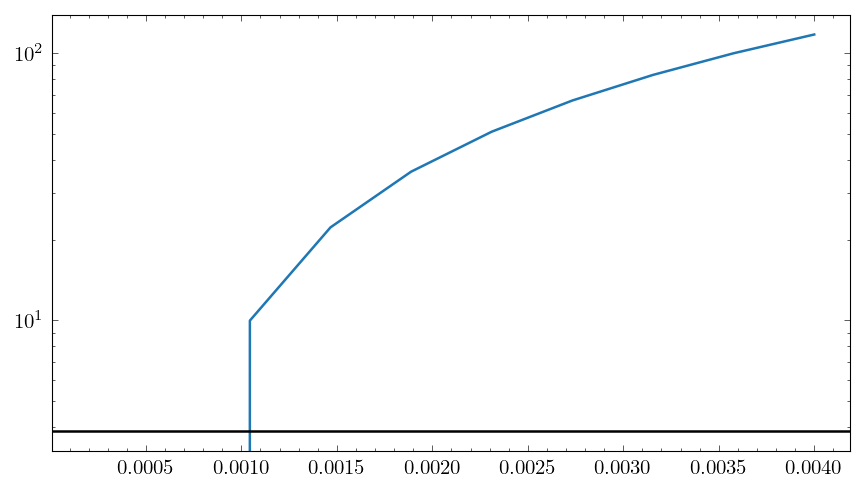

		determining the upper limit
		--->0.0008040707591132563

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.888651722698689e-17
		--->'mle_theta_er': 0.9808995534762244
		--->'mle_theta_nr': 1.0754982101154664
		defining the test statistic
		test statistic plot


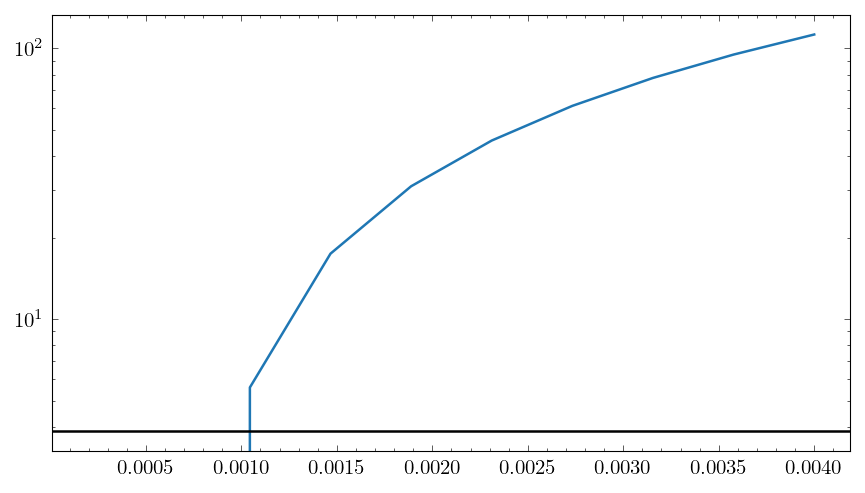

		determining the upper limit
		--->0.0009749144743174909

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.905067101863774e-17
		--->'mle_theta_er': 0.9801987082617988
		--->'mle_theta_nr': 1.1473470798222791
		defining the test statistic
		test statistic plot


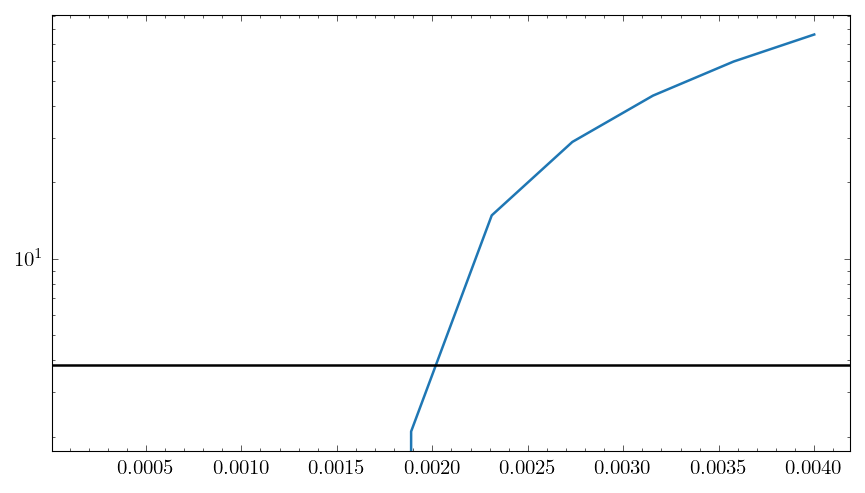

		determining the upper limit
		--->0.0019497674964293146
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 16
     iterations: 15
           root: 0.0019497674964293146

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.39993965064389e-17
		--->'mle_theta_er': 0.982416457816457
		--->'mle_theta_nr': 1.007232154682157
		defining the test statistic
		determining the upper limit
		--->0.0006309586051997373

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.872308747476386e-17
		--->'mle_theta_er': 0.9814230925031009
		--->'mle_theta_nr': 1.0691653164512345
		defining the test statistic
		determining the upper limit
		--->0.0007521637532254826

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sig

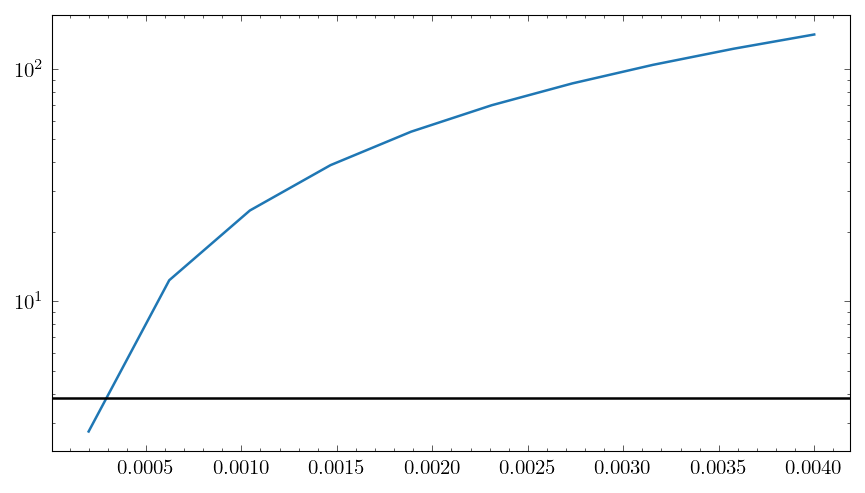

		determining the upper limit
		--->0.00025863932903099805

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.305345572199434e-17
		--->'mle_theta_er': 0.9841045442809866
		--->'mle_theta_nr': 1.0089271407297526
		defining the test statistic
		determining the upper limit
		--->0.0006944580307909051

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.379366493195643e-17
		--->'mle_theta_er': 0.9822508140463044
		--->'mle_theta_nr': 1.005657359366582
		defining the test statistic
		determining the upper limit
		--->0.00040734951605771137

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.023437889104083e-17
		--->'mle_theta_er': 0.9898888230362969
		--->'mle_theta_nr': 1.0666355288393516
		defining the test statistic
		determining the upper limit
		--->0.0006

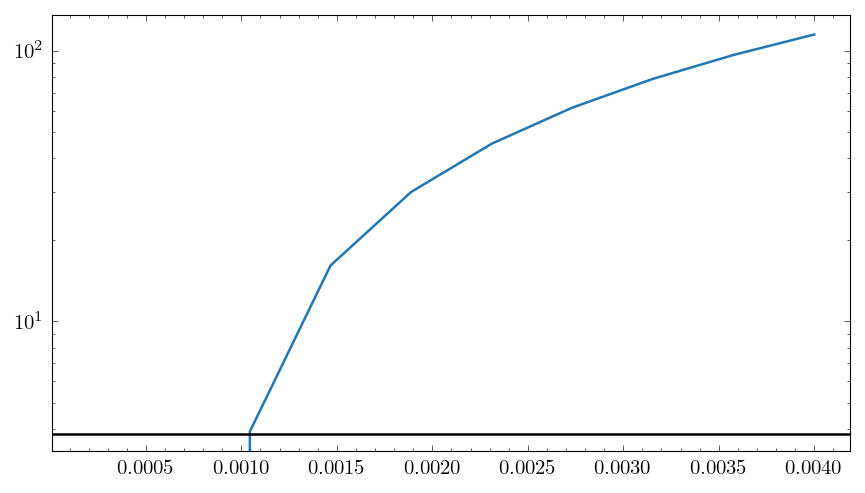

		determining the upper limit
		--->0.001041331342512967

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.571075988073359e-17
		--->'mle_theta_er': 0.9814283111341094
		--->'mle_theta_nr': 0.9951198223814055
		defining the test statistic
		determining the upper limit
		--->0.0002000547079287587

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.177773014111028e-17
		--->'mle_theta_er': 0.9839457528139783
		--->'mle_theta_nr': 1.1385320621935677
		defining the test statistic
		determining the upper limit
		--->0.0013729496956174348

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.038659287086745e-17
		--->'mle_theta_er': 0.9859941158668043
		--->'mle_theta_nr': 1.0679861997352686
		defining the test statistic
		determining the upper limit
		--->0.000638

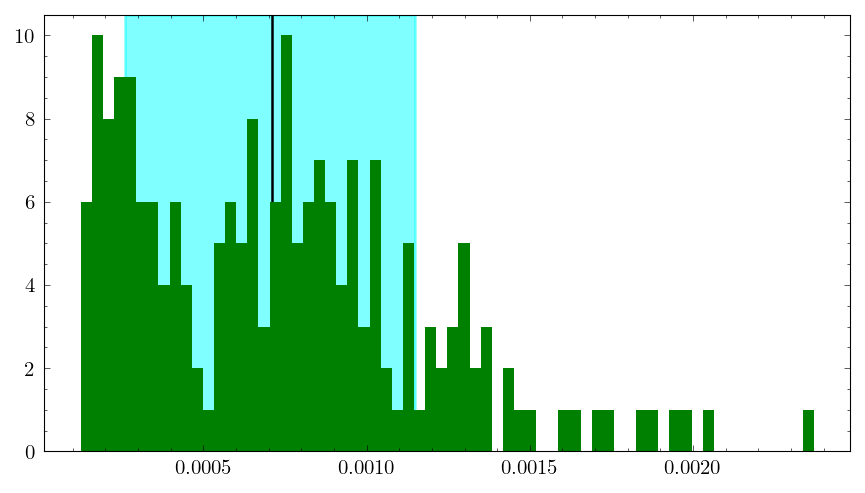

cwpec: starting WIMP mass loop with k=6/20 for 42.81 GeV
	calculating the PDF of the WIMP spectrum within the binned observable space
		calculating 'integral_spectrum_dict' for the high-statistics WIMP spectrum
######################### starting integration #########################
######################### finishing integration #########################
		generating the high-statistics WIMP signature by executing NEST
		calculating the PDF
		updating the 'spectrum_components_dict'
		deleting the high-statistics WIMP signature
		plotting spectral PDF for 'wimps'


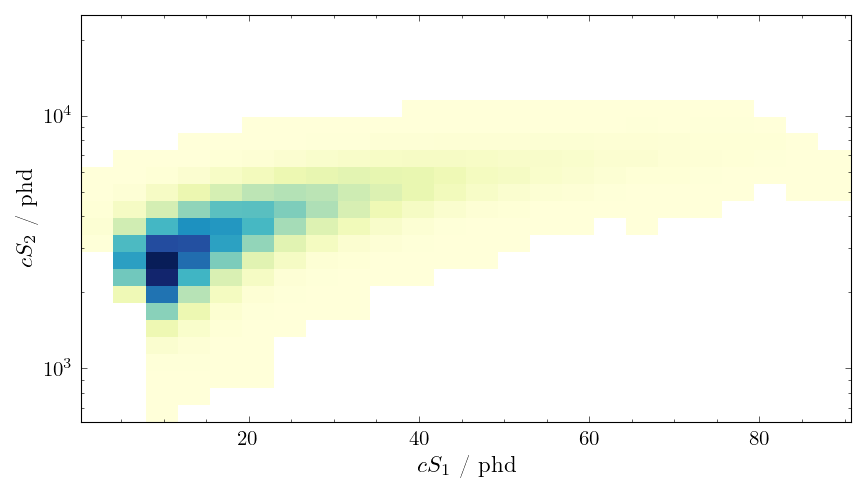

		finished within 3:35:36.877357 h'
	calculating the expected number of WIMP events within the binned observable space
		calculating the number of WIMP events expected within the WIMP EROI
######################### starting integration #########################
######################### finishing integration #########################
		updating the 'spectrum_components_dict'
		finished within 0:34:25.519256 h'
	simulating 200 background-only datasets
		generating the 'spectrum_dict's
######################### starting integration #########################
######################### finishing integration #########################
######################### starting integration #########################
######################### finishing integration #########################
		generating the ER and NR background 'signature's
	calculating the maximum likelihood parameter estimators

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
	

		--->0.001816236949913157

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0284104454109269e-16
		--->'mle_theta_er': 0.9943005107915377
		--->'mle_theta_nr': 1.0614485215963776
		defining the test statistic
		determining the upper limit
		--->0.00041579348196991935

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 7.285137148631242e-17
		--->'mle_theta_er': 0.9895448649656693
		--->'mle_theta_nr': 1.1910727613036531
		defining the test statistic
		determining the upper limit
		--->0.001376682052170222

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 4.035677402156027e-17
		--->'mle_theta_er': 0.9962836120736305
		--->'mle_theta_nr': 1.3504686608902237
		defining the test statistic
		determining the upper limit
		--->0.002685652172939279

		a priori calc

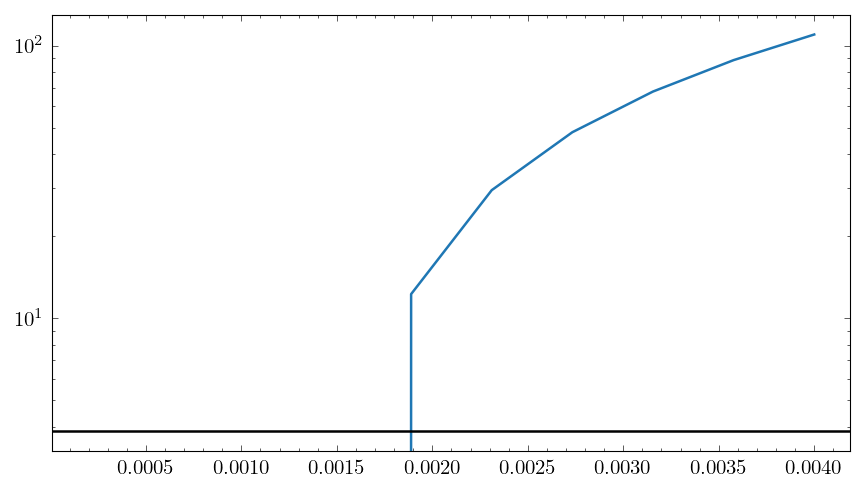

		determining the upper limit
		--->0.0016654273853126372

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.134617933848468e-17
		--->'mle_theta_er': 0.9937325438883957
		--->'mle_theta_nr': 1.0853416228872166
		defining the test statistic
		determining the upper limit
		--->0.0008058947431558474

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.1995523340667585e-16
		--->'mle_theta_er': 0.9945857635176176
		--->'mle_theta_nr': 1.2555128540921299
		defining the test statistic
		determining the upper limit
		--->0.0021872915465432335

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0840836818221285e-16
		--->'mle_theta_er': 0.9932039379645672
		--->'mle_theta_nr': 1.2115924045535191
		defining the test statistic
		determining the upper limit
		--->0.001

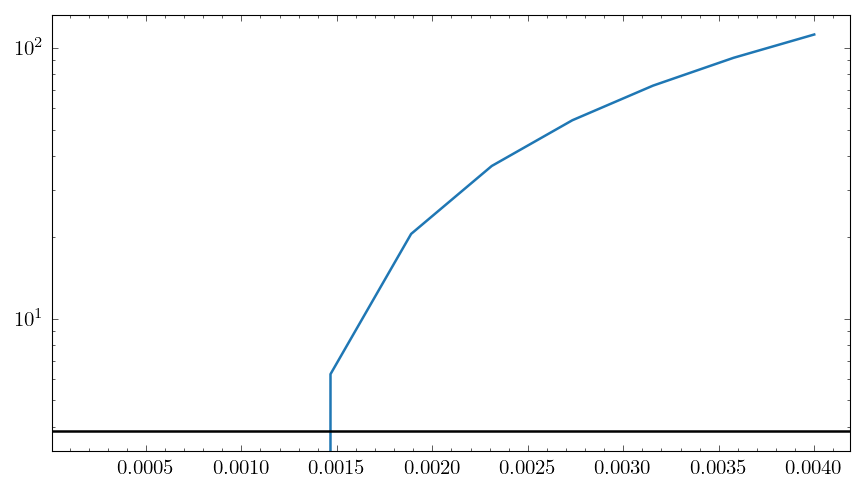

		determining the upper limit
		--->0.0013885094764450171

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.1948484954807163e-16
		--->'mle_theta_er': 0.9924094999833624
		--->'mle_theta_nr': 1.2484686953798831
		defining the test statistic
		determining the upper limit
		--->0.0019304131619162213

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 4.5541541179323896e-17
		--->'mle_theta_er': 0.9939051050195505
		--->'mle_theta_nr': 1.2037035524863786
		defining the test statistic
		determining the upper limit
		--->0.0017150819478584168

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 7.898420120547572e-17
		--->'mle_theta_er': 0.9923804071003959
		--->'mle_theta_nr': 1.0848247415066727
		defining the test statistic
		determining the upper limit
		--->0.000

		--->'mle_sigma': 9.427965029190258e-17
		--->'mle_theta_er': 0.9980034738398544
		--->'mle_theta_nr': 1.1330310383471247
		defining the test statistic
		determining the upper limit
		--->0.0011282248578733166

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.1169687142286515e-16
		--->'mle_theta_er': 0.9983347734656056
		--->'mle_theta_nr': 1.2472953341531867
		defining the test statistic
		determining the upper limit
		--->0.0014717417373544225
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 16
     iterations: 15
           root: 0.0014717417373544225

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0151017284116456e-16
		--->'mle_theta_er': 0.9962922199006252
		--->'mle_theta_nr': 1.2510755606954787
		defining the test statistic
		test statistic plot


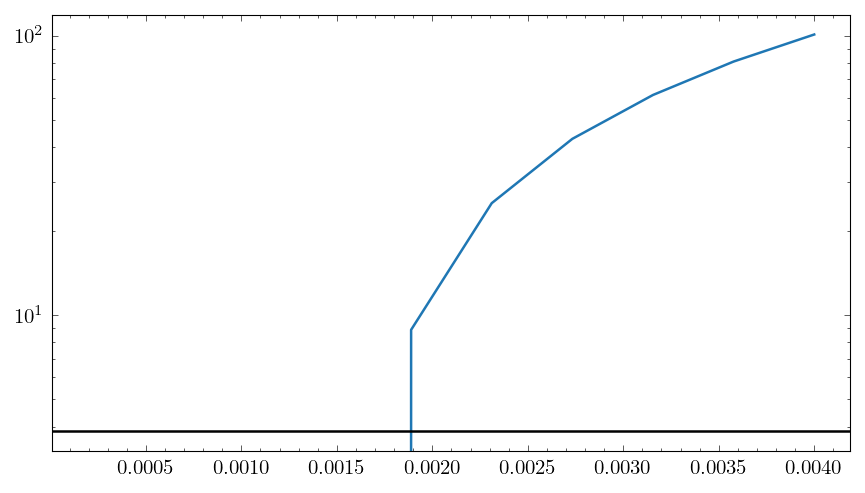

		determining the upper limit
		--->0.0017496904221653115

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0764761931046318e-16
		--->'mle_theta_er': 0.9930963969790507
		--->'mle_theta_nr': 1.1915267773257068
		defining the test statistic
		determining the upper limit
		--->0.0013261217965506436

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.7781081227342314e-17
		--->'mle_theta_er': 0.9949161720091995
		--->'mle_theta_nr': 1.354229882752159
		defining the test statistic
		determining the upper limit
		--->0.002465287695438362

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.1133602799867366e-16
		--->'mle_theta_er': 0.9961627202732379
		--->'mle_theta_nr': 1.1257029357234454
		defining the test statistic
		determining the upper limit
		--->0.0006

		--->'mle_sigma': 9.866994587601839e-17
		--->'mle_theta_er': 0.9868257374484967
		--->'mle_theta_nr': 1.2486645080863346
		defining the test statistic
		test statistic plot


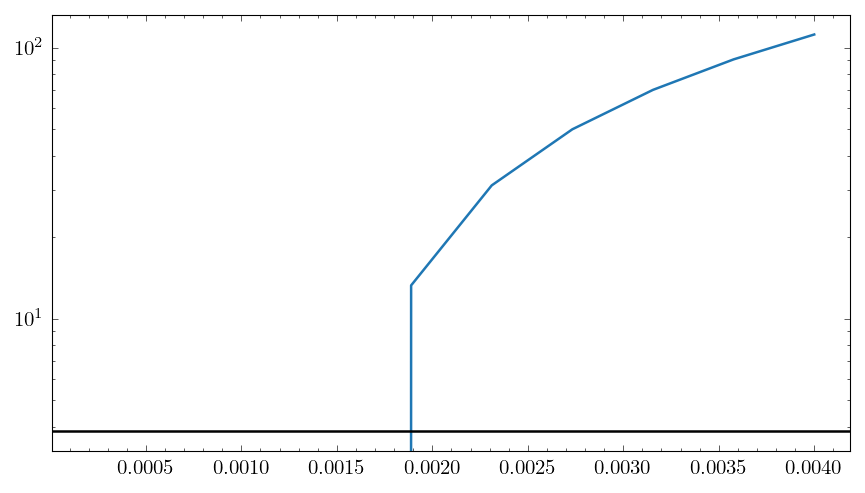

		determining the upper limit
		--->0.001648887368118158

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0418325731987403e-16
		--->'mle_theta_er': 0.9931008180057149
		--->'mle_theta_nr': 1.1317149546471765
		defining the test statistic
		determining the upper limit
		--->0.0008064054395445953
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 16
     iterations: 15
           root: 0.0008064054395445953

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 4.554137985504932e-17
		--->'mle_theta_er': 0.9920429538773703
		--->'mle_theta_nr': 1.25704026530118
		defining the test statistic
		determining the upper limit
		--->0.0018114413465726642

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_si

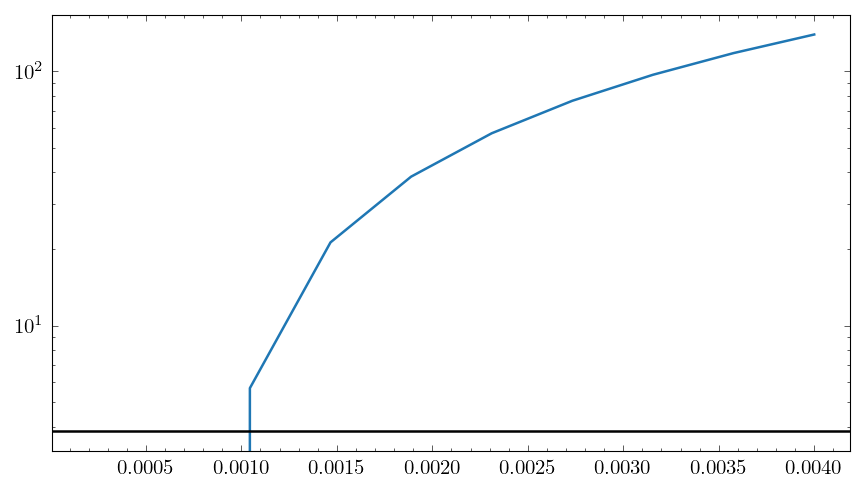

		determining the upper limit
		--->0.0009899796882756537

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.054335839122688e-16
		--->'mle_theta_er': 0.9962342723216364
		--->'mle_theta_nr': 1.317464142085828
		defining the test statistic
		determining the upper limit
		--->0.0027457843470966186

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.821569395809667e-17
		--->'mle_theta_er': 0.9934177169859328
		--->'mle_theta_nr': 1.1971219870525063
		defining the test statistic
		determining the upper limit
		--->0.001320103065186416

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.2128072865406003e-16
		--->'mle_theta_er': 0.9944030586799031
		--->'mle_theta_nr': 1.259597172524002
		defining the test statistic
		determining the upper limit
		--->0.0020069

		--->0.002744704250830286

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 4.002029888232829e-17
		--->'mle_theta_er': 0.9937620581512424
		--->'mle_theta_nr': 1.1951796759418352
		defining the test statistic
		determining the upper limit
		--->0.0013534181694351674

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.1101112105857432e-16
		--->'mle_theta_er': 0.9921786917678224
		--->'mle_theta_nr': 1.2670945519117618
		defining the test statistic
		determining the upper limit
		--->0.002360090910877

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0853104560547823e-16
		--->'mle_theta_er': 0.9932398802032819
		--->'mle_theta_nr': 1.19996236860088
		defining the test statistic
		determining the upper limit
		--->0.0018551902321818966

		a priori calculat

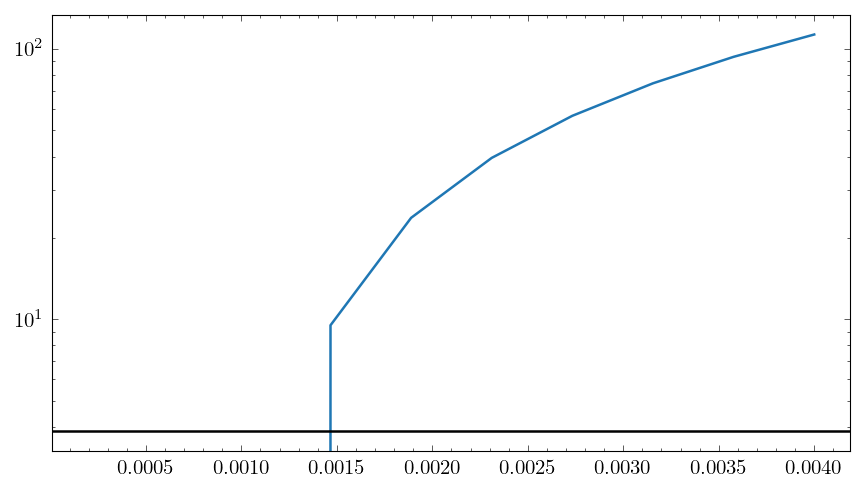

		determining the upper limit
		--->0.0012793134672570393

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.327587375976525e-17
		--->'mle_theta_er': 0.9978287311271563
		--->'mle_theta_nr': 1.1350326553959187
		defining the test statistic
		determining the upper limit
		--->0.0009183148549950063

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.739912750499558e-17
		--->'mle_theta_er': 0.9874923275992855
		--->'mle_theta_nr': 1.1407943152733253
		defining the test statistic
		test statistic plot


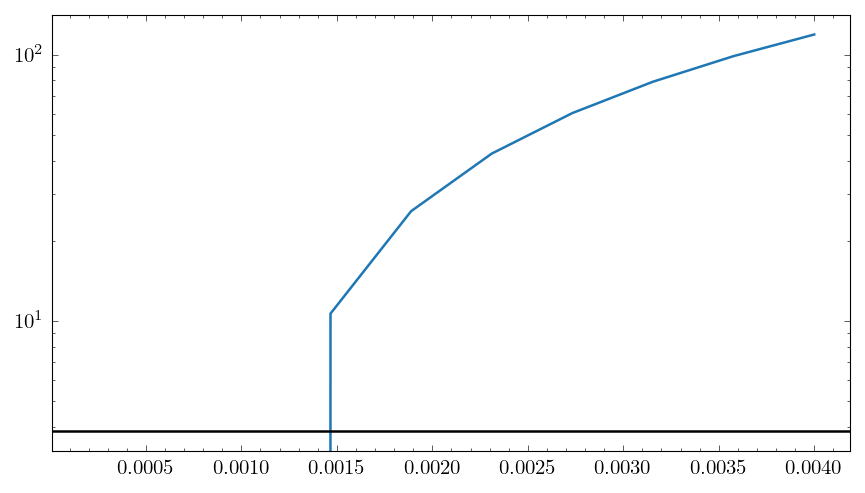

		determining the upper limit
		--->0.0012575229267087025

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.108344765192824e-17
		--->'mle_theta_er': 0.9891316371831208
		--->'mle_theta_nr': 1.2153970199859974
		defining the test statistic
		determining the upper limit
		--->0.0017535026537391775

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 7.939766783188657e-17
		--->'mle_theta_er': 0.9933643784638599
		--->'mle_theta_nr': 1.2144066063083412
		defining the test statistic
		determining the upper limit
		--->0.0019825105808024992
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 16
     iterations: 15
           root: 0.0019825105808024992

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_

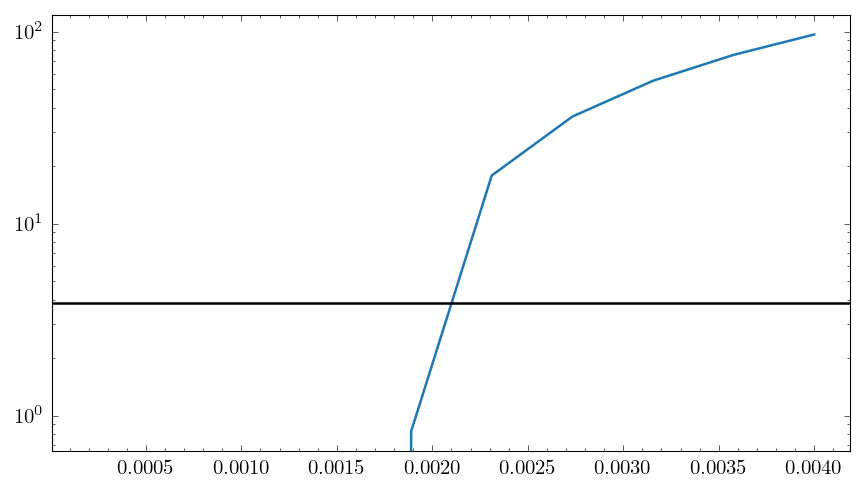

		determining the upper limit
		--->0.0019668214377305524

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.059530547543901e-16
		--->'mle_theta_er': 0.9949241342628738
		--->'mle_theta_nr': 1.0825024848985256
		defining the test statistic
		determining the upper limit
		--->0.0008303755262765187

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.40152481001261e-17
		--->'mle_theta_er': 0.9939474800600201
		--->'mle_theta_nr': 1.067336597015143
		defining the test statistic
		determining the upper limit
		--->0.0006272258516729985

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 2.4847965889520687e-17
		--->'mle_theta_er': 0.9981511774383676
		--->'mle_theta_nr': 1.3486967512402463
		defining the test statistic
		test statistic plot


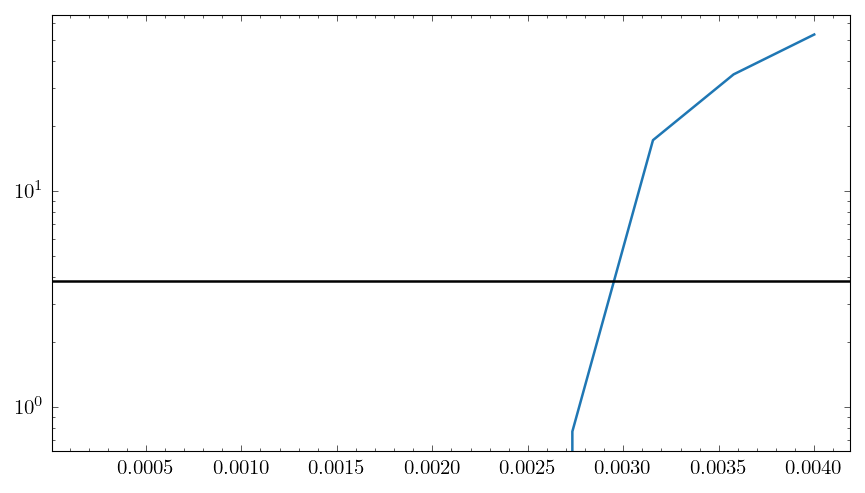

		determining the upper limit
		--->0.0028147175367542136

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 2.365513463191153e-17
		--->'mle_theta_er': 0.9940372708060418
		--->'mle_theta_nr': 1.3167838771678408
		defining the test statistic
		determining the upper limit
		--->0.0027538443005827246
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 16
     iterations: 15
           root: 0.0027538443005827246

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.210993611115153e-17
		--->'mle_theta_er': 0.989357675781108
		--->'mle_theta_nr': 1.1392650522132794
		defining the test statistic
		determining the upper limit
		--->0.0012335250314721104

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_s

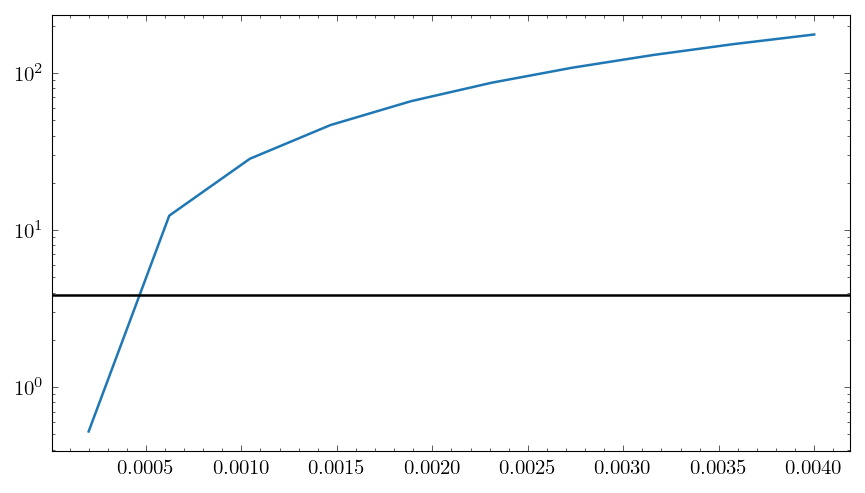

		determining the upper limit
		--->0.0003473322104349483

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.1742424832785308e-16
		--->'mle_theta_er': 0.9961005007755854
		--->'mle_theta_nr': 1.257920111955862
		defining the test statistic
		determining the upper limit
		--->0.0021581645959415207

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.2268911987903e-17
		--->'mle_theta_er': 0.9918736047709713
		--->'mle_theta_nr': 1.0845314113118811
		defining the test statistic
		determining the upper limit
		--->0.0009539327073182374

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.1172684955389025e-16
		--->'mle_theta_er': 0.9911843184231486
		--->'mle_theta_nr': 1.310247706370237
		defining the test statistic
		test statistic plot


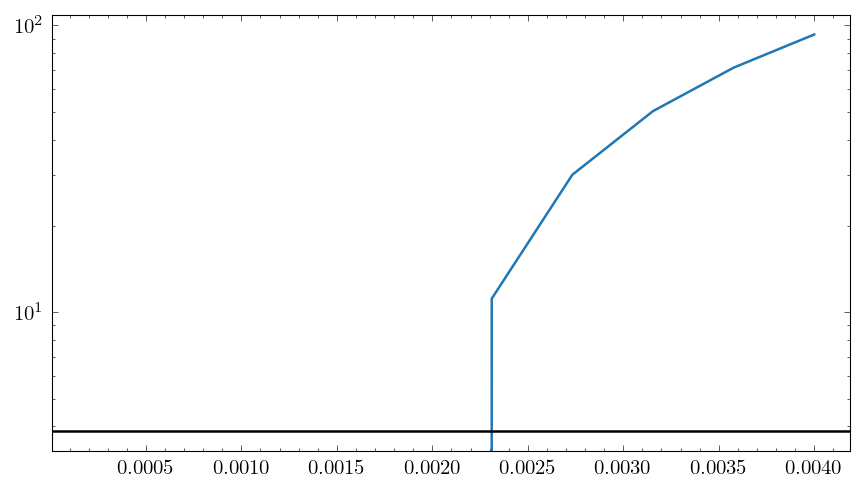

		determining the upper limit
		--->0.0021401045103910028

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0182672365303675e-16
		--->'mle_theta_er': 0.994271969136467
		--->'mle_theta_nr': 1.0728604495334964
		defining the test statistic
		determining the upper limit
		--->0.0006703385394516507

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0559999910708901e-16
		--->'mle_theta_er': 0.9910558078774587
		--->'mle_theta_nr': 1.1949441776128524
		defining the test statistic
		determining the upper limit
		--->0.0015777622996104212

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.08293290431461e-17
		--->'mle_theta_er': 0.9905729920744955
		--->'mle_theta_nr': 1.1281098542303702
		defining the test statistic
		determining the upper limit
		--->0.00070

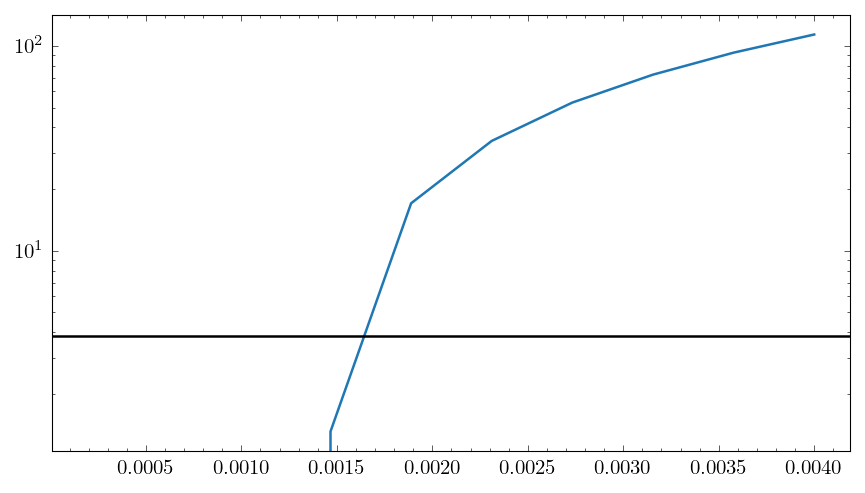

		determining the upper limit
		--->0.0015380526081441334
	determining the median upper limit (200 elements, different ones 200)
	'upper_limit_list' = [0.0019016111541455556, 0.0009351561948397971, 0.0010363674791895492, 0.0013542280056868595, 0.0013036442715496028, 0.0015027816919689608, 0.0013916152020048487, 0.0016470743822831427, 0.0021318776714619, 0.0018815884236130609, 0.0015149504030457328, 0.0001557396065559889, 0.001242378460295009, 0.0009788793201986473, 0.0008056419462821918, 0.00042044734133320184, 0.0015772465786522572, 0.0015224874604809358, 0.001930811491102201, 0.0013064892425459372, 0.0017773584332715223, 0.001816236949913157, 0.00041579348196991935, 0.001376682052170222, 0.002685652172939279, 0.0022267630502436704, 0.0017181633522550808, 0.0027535831524704954, 0.001464919570681609, 0.0015473460949990893, 0.0019502921929304647, 0.0014662016364673535, 0.0011971292465036635, 0.0025398092219191724, 0.0012568614674654537, 0.0016654273853126372, 0.0008058947431558474, 0.00

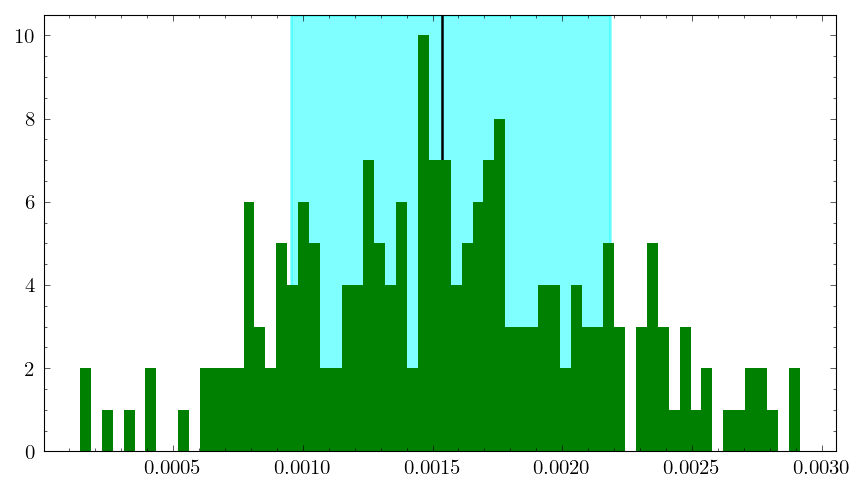

cwpec: starting WIMP mass loop with k=7/20 for 54.56 GeV
	calculating the PDF of the WIMP spectrum within the binned observable space
		calculating 'integral_spectrum_dict' for the high-statistics WIMP spectrum
######################### starting integration #########################
######################### finishing integration #########################
		generating the high-statistics WIMP signature by executing NEST
		calculating the PDF
		updating the 'spectrum_components_dict'
		deleting the high-statistics WIMP signature
		plotting spectral PDF for 'wimps'


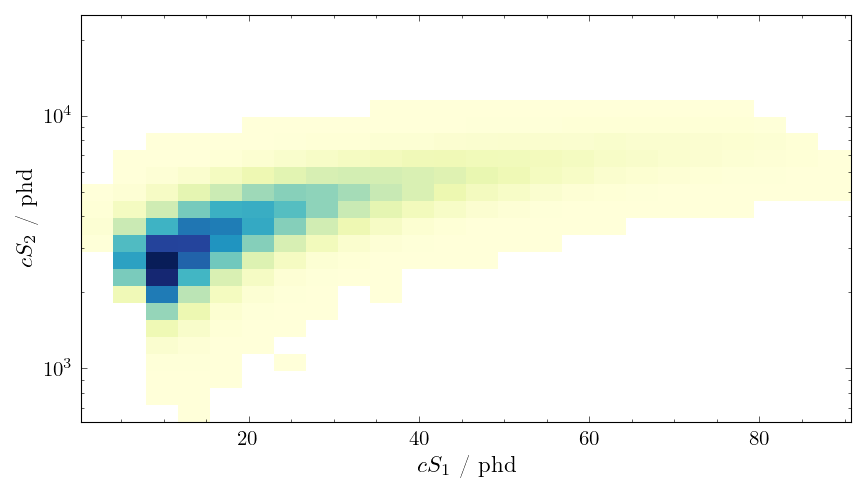

		finished within 3:44:43.268372 h'
	calculating the expected number of WIMP events within the binned observable space
		calculating the number of WIMP events expected within the WIMP EROI
######################### starting integration #########################
######################### finishing integration #########################
		updating the 'spectrum_components_dict'
		finished within 0:44:20.670104 h'
	simulating 200 background-only datasets
		generating the 'spectrum_dict's
######################### starting integration #########################
######################### finishing integration #########################
######################### starting integration #########################
######################### finishing integration #########################
		generating the ER and NR background 'signature's
	calculating the maximum likelihood parameter estimators

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
	

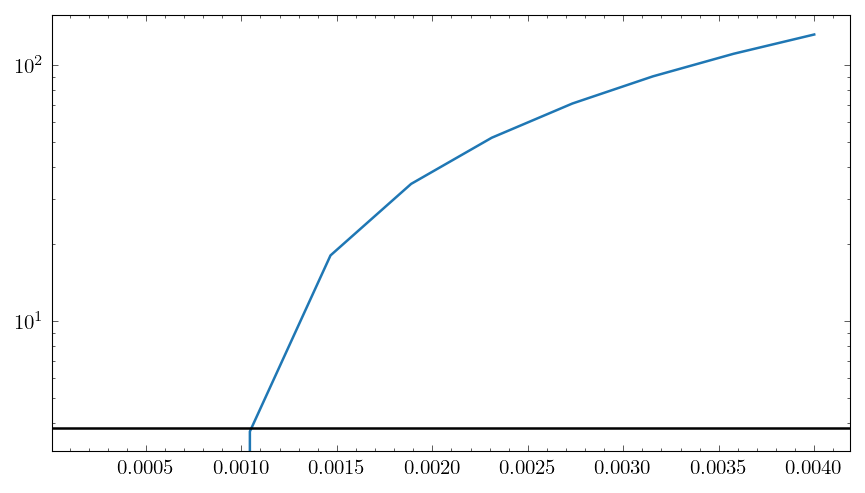

		determining the upper limit
		--->0.001048710773409854

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0426047151052581e-16
		--->'mle_theta_er': 0.9993670100838405
		--->'mle_theta_nr': 1.1879490488267148
		defining the test statistic
		determining the upper limit
		--->0.0011309786231975918

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.674232466890889e-17
		--->'mle_theta_er': 1.0019189375695867
		--->'mle_theta_nr': 0.9862957518636442
		defining the test statistic
		determining the upper limit
		--->0.00010593782383188239
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 0.00010593782383188239

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_

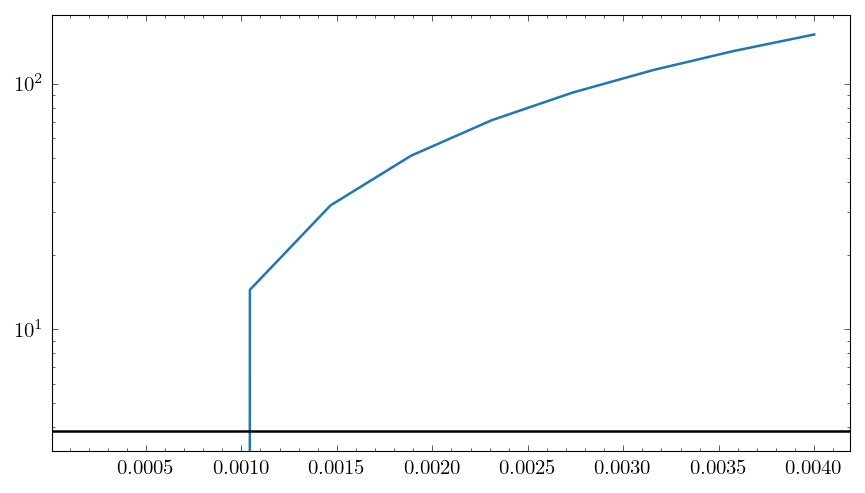

		determining the upper limit
		--->0.0007561548274453644

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.00368488254402e-17
		--->'mle_theta_er': 1.0066552180679056
		--->'mle_theta_nr': 1.124547596955323
		defining the test statistic
		determining the upper limit
		--->0.0005672043276331839

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.1991946007510146e-16
		--->'mle_theta_er': 1.0001915791347922
		--->'mle_theta_nr': 1.1950005514638025
		defining the test statistic
		determining the upper limit
		--->0.0013247578018313832

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.817344495914814e-17
		--->'mle_theta_er': 1.0041269994047215
		--->'mle_theta_nr': 1.0558266434046084
		defining the test statistic
		determining the upper limit
		--->0.000302

		--->'mle_sigma': 1.0078961518583756e-16
		--->'mle_theta_er': 1.0039196651179458
		--->'mle_theta_nr': 1.0711738027205508
		defining the test statistic
		test statistic plot


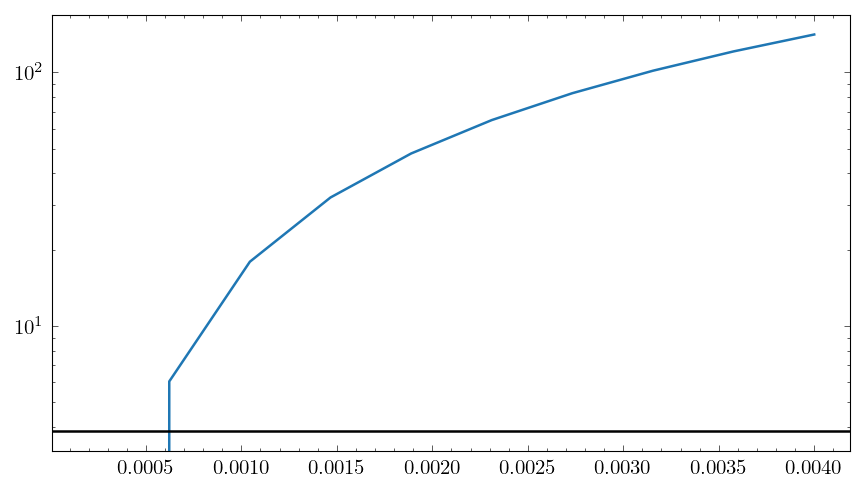

		determining the upper limit
		--->0.0005269775384646335

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0052524643947269e-16
		--->'mle_theta_er': 1.0030874397849427
		--->'mle_theta_nr': 1.1299841855869284
		defining the test statistic
		determining the upper limit
		--->0.0007513623535436191

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.835650453822743e-17
		--->'mle_theta_er': 1.0025783303805849
		--->'mle_theta_nr': 1.188979053307298
		defining the test statistic
		determining the upper limit
		--->0.0010102652239705441

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.132600096408455e-17
		--->'mle_theta_er': 1.0080087156962496
		--->'mle_theta_nr': 1.12452633383352
		defining the test statistic
		determining the upper limit
		--->0.0005394

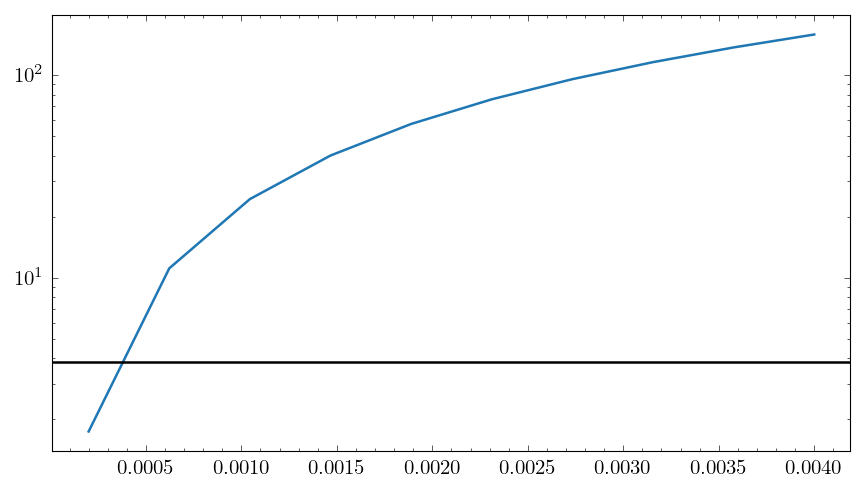

		determining the upper limit
		--->0.0003209931576706105

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.92865005671184e-17
		--->'mle_theta_er': 1.0076306698680035
		--->'mle_theta_nr': 1.1965984907371492
		defining the test statistic
		determining the upper limit
		--->0.001451102461069665

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.219418342834115e-17
		--->'mle_theta_er': 1.0016982160635075
		--->'mle_theta_nr': 1.0798660034664413
		defining the test statistic
		determining the upper limit
		--->0.0008327096068163511

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.347493092175698e-17
		--->'mle_theta_er': 1.0064597273379858
		--->'mle_theta_nr': 1.1340553274834468
		defining the test statistic
		determining the upper limit
		--->0.0007821

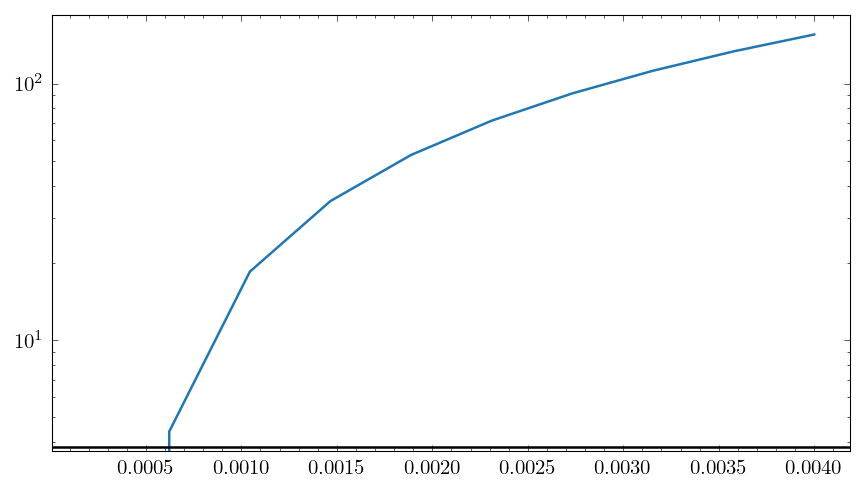

		determining the upper limit
		--->0.0006028163296817812

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.45146489857183e-17
		--->'mle_theta_er': 1.005967540653506
		--->'mle_theta_nr': 1.1285239869593457
		defining the test statistic
		determining the upper limit
		--->0.0006914411094951088

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.462119839730669e-17
		--->'mle_theta_er': 1.0013975740348768
		--->'mle_theta_nr': 1.1292716812394583
		defining the test statistic
		determining the upper limit
		--->0.0006380266768299665

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.443129011710749e-17
		--->'mle_theta_er': 1.007324727144948
		--->'mle_theta_nr': 1.1858823570209192
		defining the test statistic
		determining the upper limit
		--->0.00095526

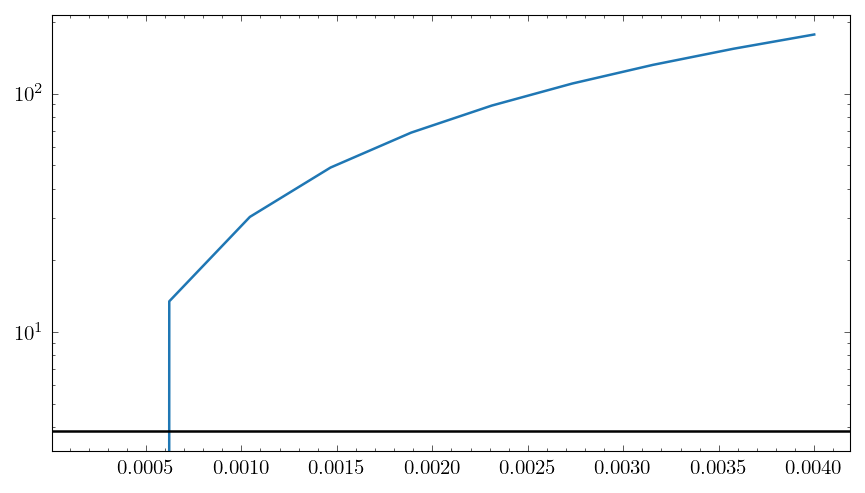

		determining the upper limit
		--->0.0003440050430381625

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.003066167201912e-17
		--->'mle_theta_er': 1.0093695092610853
		--->'mle_theta_nr': 1.121848006790926
		defining the test statistic
		determining the upper limit
		--->0.00047222103677291066

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.862252081663467e-17
		--->'mle_theta_er': 1.0061488598080395
		--->'mle_theta_nr': 1.0591927290927394
		defining the test statistic
		determining the upper limit
		--->0.0003711970827498847

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.502489383874638e-17
		--->'mle_theta_er': 1.0014035278292388
		--->'mle_theta_nr': 1.1271087601199299
		defining the test statistic
		determining the upper limit
		--->0.00066

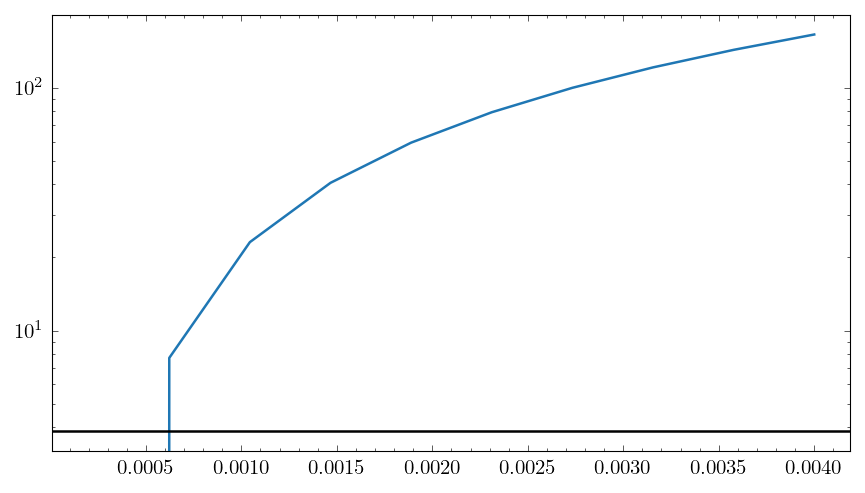

		determining the upper limit
		--->0.000499689999512468

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.825195319045509e-17
		--->'mle_theta_er': 1.0027445851500696
		--->'mle_theta_nr': 1.0674959964942714
		defining the test statistic
		determining the upper limit
		--->0.0005398789950856686

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.545850366185959e-17
		--->'mle_theta_er': 1.0014086480701492
		--->'mle_theta_nr': 1.1252445132476565
		defining the test statistic
		determining the upper limit
		--->0.0005611296335686732

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.0983141076168209e-16
		--->'mle_theta_er': 0.9974953496923873
		--->'mle_theta_nr': 1.2453041470769564
		defining the test statistic
		determining the upper limit
		--->0.00151

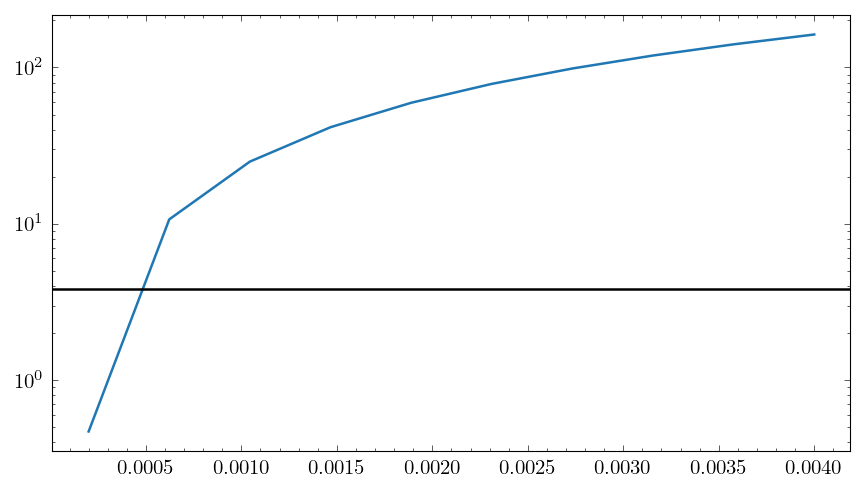

		determining the upper limit
		--->0.0003715619085031133

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.169399459629948e-17
		--->'mle_theta_er': 1.0008718497879074
		--->'mle_theta_nr': 1.0721686908691588
		defining the test statistic
		test statistic plot


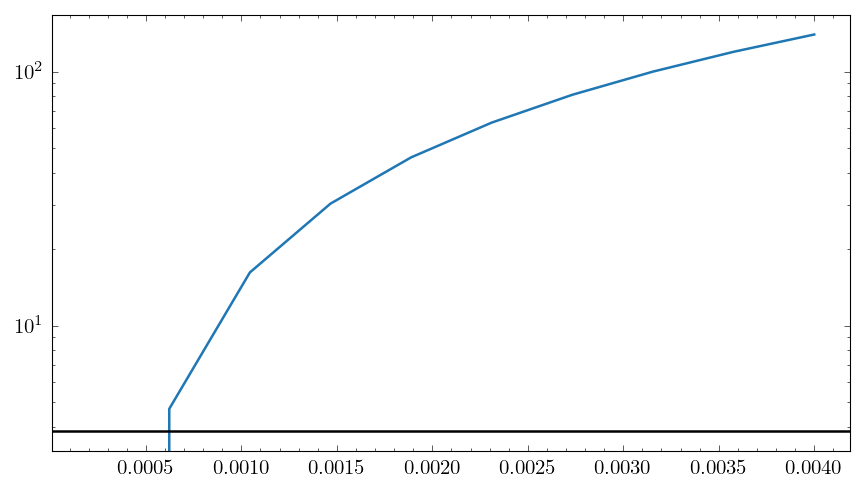

		determining the upper limit
		--->0.0005835050279638421

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.444818439336758e-17
		--->'mle_theta_er': 1.0022264169122952
		--->'mle_theta_nr': 1.0717400208885195
		defining the test statistic
		determining the upper limit
		--->0.0007144530067024527

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.709033236138854e-17
		--->'mle_theta_er': 1.0047894419961603
		--->'mle_theta_nr': 1.0616178337699909
		defining the test statistic
		determining the upper limit
		--->0.00041544366448337044

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 7.761318483072635e-17
		--->'mle_theta_er': 1.0105303109968455
		--->'mle_theta_nr': 1.1303578180333718
		defining the test statistic
		determining the upper limit
		--->0.0007

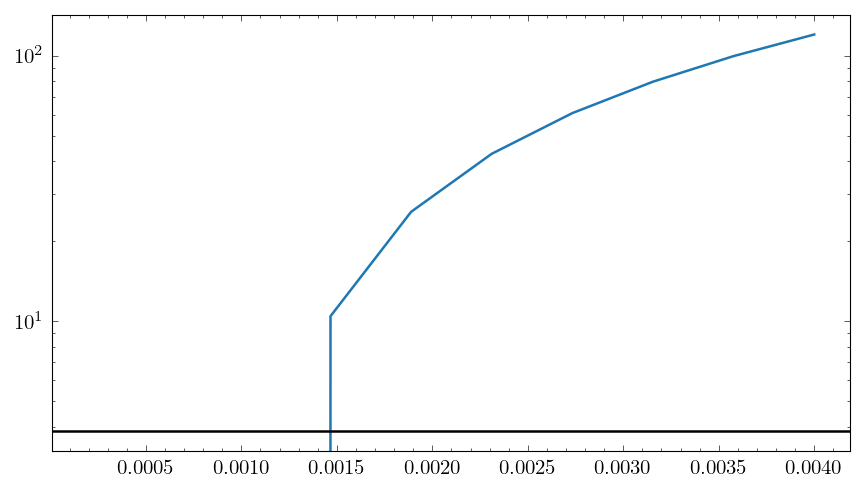

		determining the upper limit
		--->0.0012664654687770114

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.598041247760876e-17
		--->'mle_theta_er': 1.0068186883188726
		--->'mle_theta_nr': 1.061985600025627
		defining the test statistic
		determining the upper limit
		--->0.0004447757969509873

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.021636363741096e-17
		--->'mle_theta_er': 1.008511411004193
		--->'mle_theta_nr': 1.1262947094042781
		defining the test statistic
		determining the upper limit
		--->0.0006381940258857901

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.324895986697814e-17
		--->'mle_theta_er': 1.0076448093093413
		--->'mle_theta_nr': 1.0699026774961544
		defining the test statistic
		determining the upper limit
		--->0.0004568

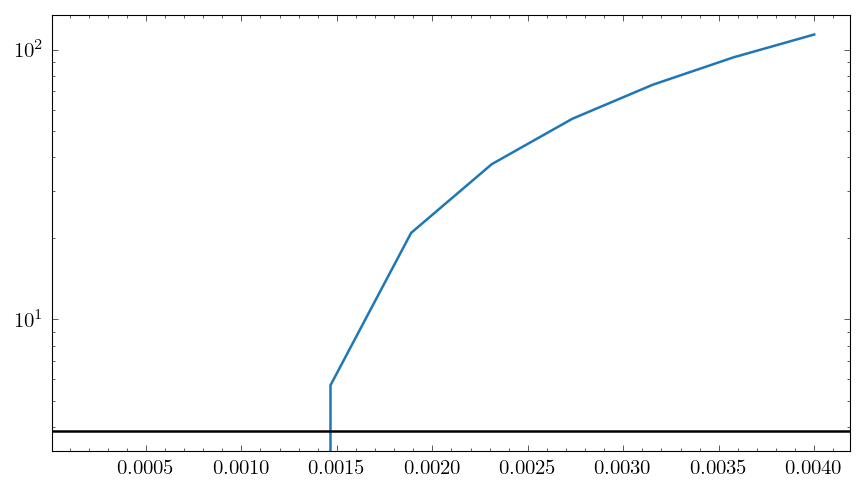

		determining the upper limit
		--->0.0014113312469092147

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 6.360920496363962e-17
		--->'mle_theta_er': 1.0027360423617655
		--->'mle_theta_nr': 1.1927750694863706
		defining the test statistic
		test statistic plot


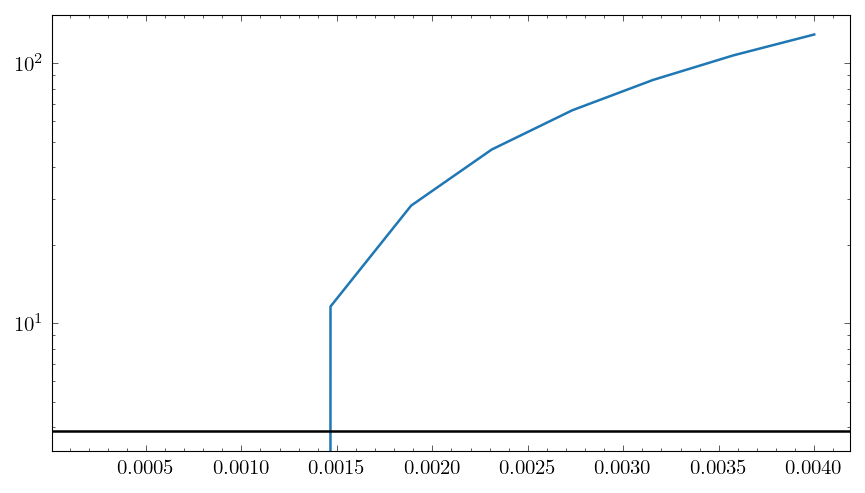

		determining the upper limit
		--->0.001251889712883701

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 7.832967632325761e-17
		--->'mle_theta_er': 1.004770280767989
		--->'mle_theta_nr': 1.069287889280083
		defining the test statistic
		test statistic plot


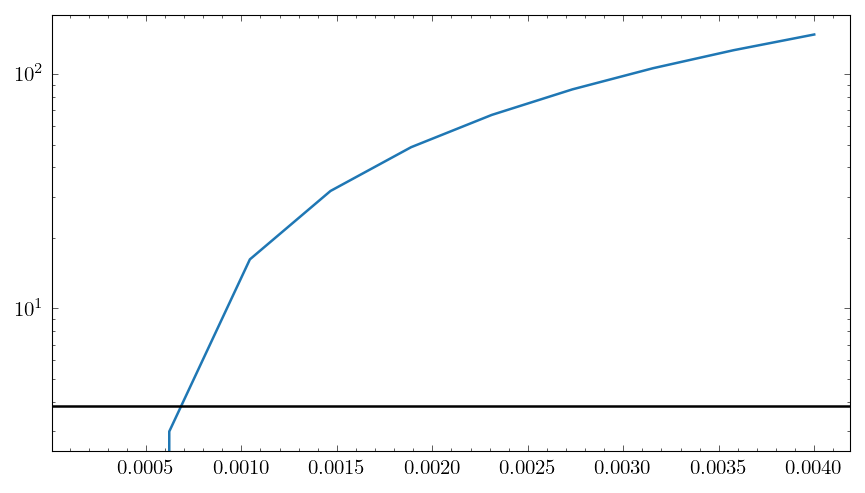

		determining the upper limit
		--->0.0006530646406370384

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.031486398939592e-17
		--->'mle_theta_er': 1.0042546540025405
		--->'mle_theta_nr': 1.072500431709025
		defining the test statistic
		determining the upper limit
		--->0.0007746542123048104

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 6.344841555832485e-17
		--->'mle_theta_er': 1.002562591990571
		--->'mle_theta_nr': 1.1941846203637327
		defining the test statistic
		determining the upper limit
		--->0.0012050057399029788

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.933825600373141e-17
		--->'mle_theta_er': 1.004110011211652
		--->'mle_theta_nr': 1.1272721605987441
		defining the test statistic
		determining the upper limit
		--->0.00075193

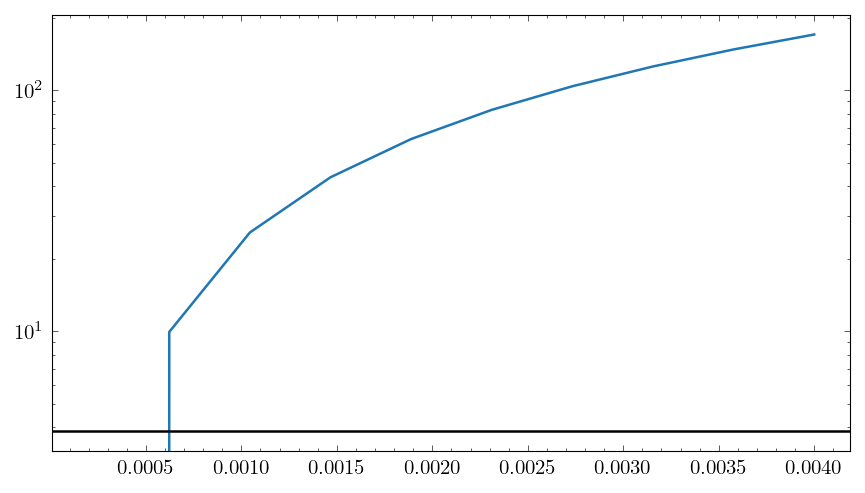

		determining the upper limit
		--->0.0004257728108195845

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.577875215594212e-17
		--->'mle_theta_er': 1.0008936106366058
		--->'mle_theta_nr': 0.9910078288829641
		defining the test statistic
		test statistic plot


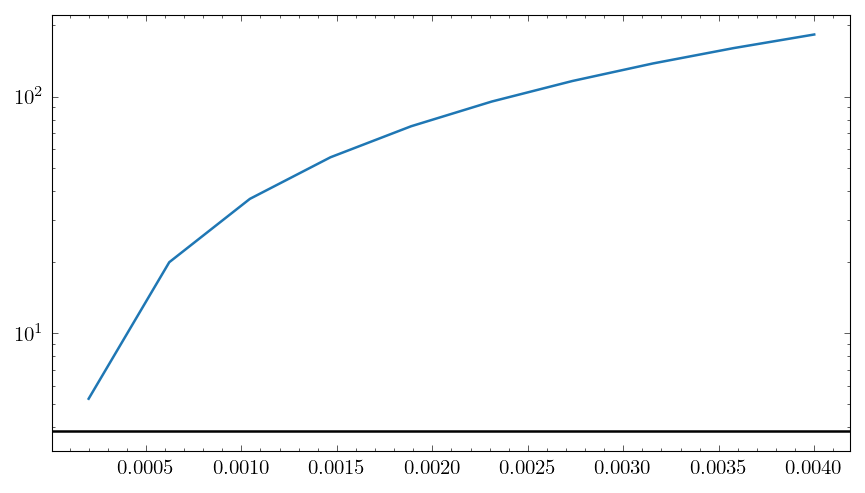

		determining the upper limit
		--->0.00015121686651427935

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.697457027735121e-17
		--->'mle_theta_er': 1.0056244496957696
		--->'mle_theta_nr': 1.0660055430902025
		defining the test statistic
		determining the upper limit
		--->0.0006505745328683971

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.802999487081943e-17
		--->'mle_theta_er': 1.0025863121362009
		--->'mle_theta_nr': 1.0631426443845728
		defining the test statistic
		determining the upper limit
		--->0.00027676286829593245

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.31871172638258e-17
		--->'mle_theta_er': 1.0034414070999786
		--->'mle_theta_nr': 1.059424843795283
		defining the test statistic
		test statistic plot


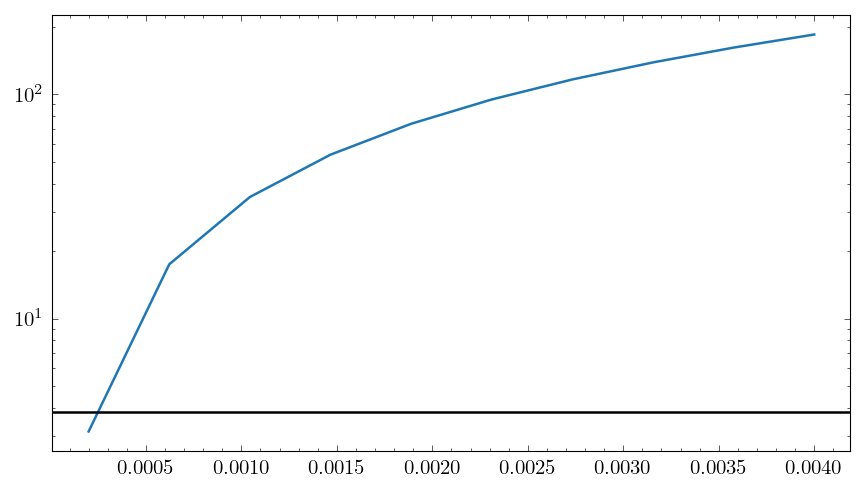

		determining the upper limit
		--->0.00022555353256941066

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 1.1067284049362397e-16
		--->'mle_theta_er': 1.005298141185499
		--->'mle_theta_nr': 1.239010184137109
		defining the test statistic
		determining the upper limit
		--->0.001114455301454563

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.638341281707532e-17
		--->'mle_theta_er': 0.997345596654974
		--->'mle_theta_nr': 1.061541294673673
		defining the test statistic
		determining the upper limit
		--->0.0004525971470049166

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.605114826258622e-17
		--->'mle_theta_er': 1.0059693839978676
		--->'mle_theta_nr': 0.9908606122662691
		defining the test statistic
		determining the upper limit
		--->0.00015049

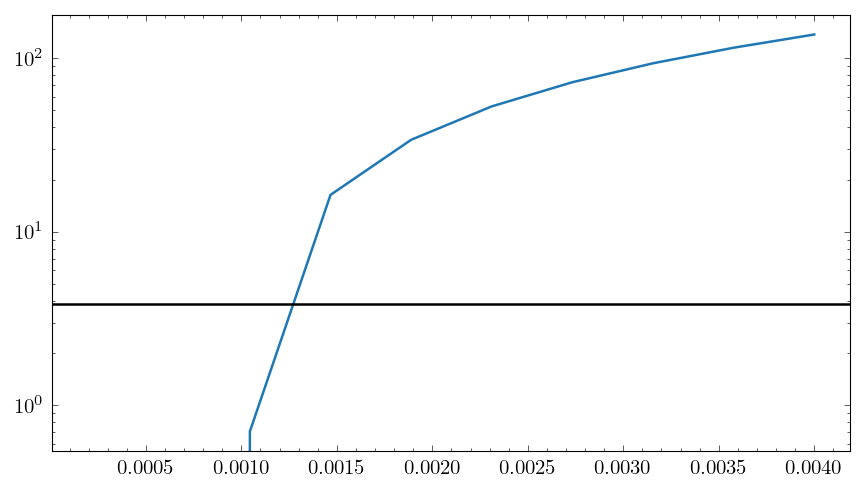

		determining the upper limit
		--->0.0011349202271905166

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.575340892171254e-17
		--->'mle_theta_er': 1.003914759241325
		--->'mle_theta_nr': 1.001962998760873
		defining the test statistic
		determining the upper limit
		--->0.00032412109486175877

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.218460971100498e-17
		--->'mle_theta_er': 1.002759056488959
		--->'mle_theta_nr': 0.9889638008683003
		defining the test statistic
		determining the upper limit
		--->0.00013287793685378573

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.429475887266004e-17
		--->'mle_theta_er': 1.0041149371879567
		--->'mle_theta_nr': 1.060725755406283
		defining the test statistic
		determining the upper limit
		--->0.0004141

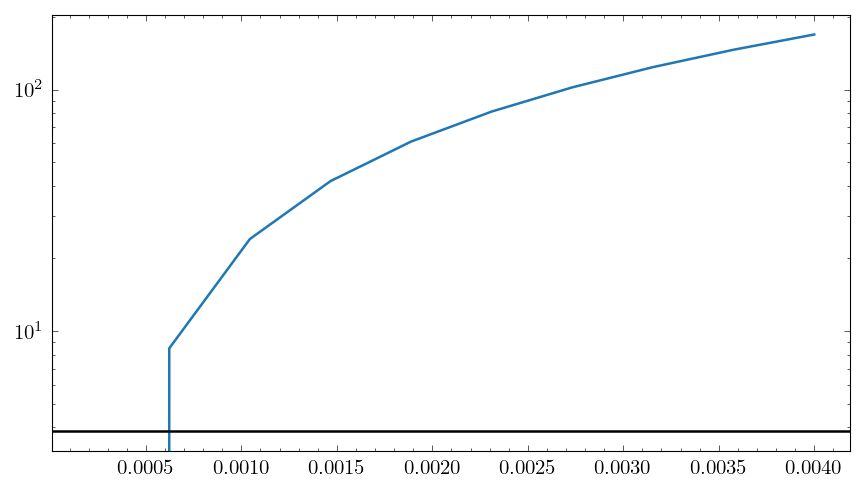

		determining the upper limit
		--->0.000474047810783699

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.47283734260478e-17
		--->'mle_theta_er': 1.0014048279644912
		--->'mle_theta_nr': 1.1266411510535592
		defining the test statistic
		determining the upper limit
		--->0.000603313247282417

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.026335415111765e-17
		--->'mle_theta_er': 1.0019007531171455
		--->'mle_theta_nr': 1.1308430383002182
		defining the test statistic
		test statistic plot


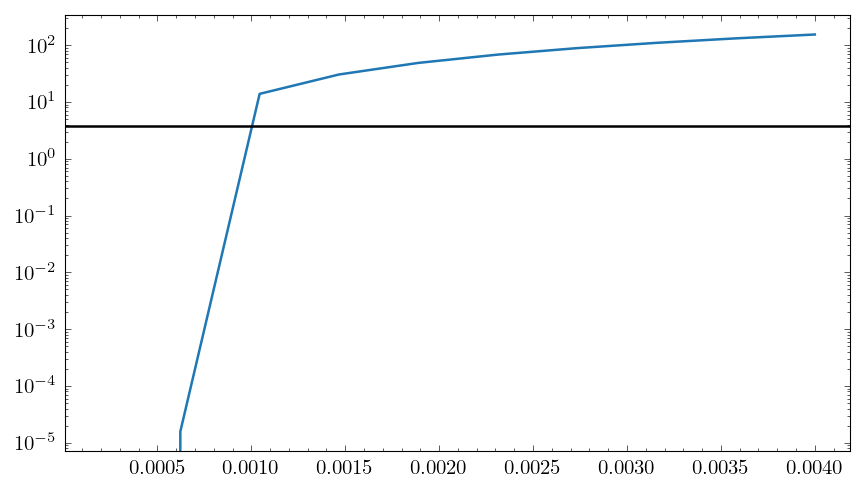

		determining the upper limit
		--->0.000750963800201414

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.347562737797976e-17
		--->'mle_theta_er': 1.0020681344082731
		--->'mle_theta_nr': 1.1314890157862365
		defining the test statistic
		determining the upper limit
		--->0.0008097776787609796
This should actually be displayed. Why isn't it?
		--->      converged: True
           flag: 'converged'
 function_calls: 16
     iterations: 15
           root: 0.0008097776787609796

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.423458726890935e-17
		--->'mle_theta_er': 1.0022566070824257
		--->'mle_theta_nr': 1.059637148027048
		defining the test statistic
		determining the upper limit
		--->0.0003242594745663152

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_si

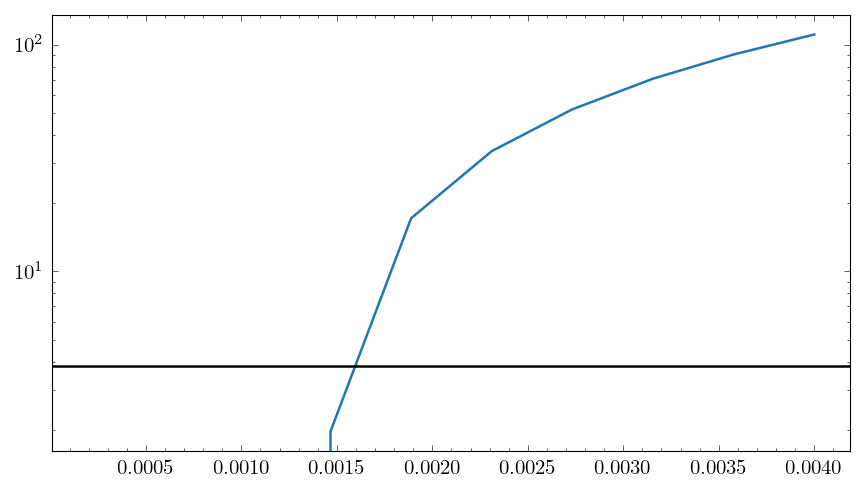

		determining the upper limit
		--->0.0015218997525732172

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.171392313743629e-17
		--->'mle_theta_er': 1.0068145662258505
		--->'mle_theta_nr': 0.9911747812411762
		defining the test statistic
		determining the upper limit
		--->0.00015193665450296867

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.961367375309531e-17
		--->'mle_theta_er': 1.0076498650029535
		--->'mle_theta_nr': 1.1902793914146013
		defining the test statistic
		determining the upper limit
		--->0.0011050458707238876

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.333014358303488e-17
		--->'mle_theta_er': 1.000884955430768
		--->'mle_theta_nr': 1.189502863503793
		defining the test statistic
		determining the upper limit
		--->0.000906

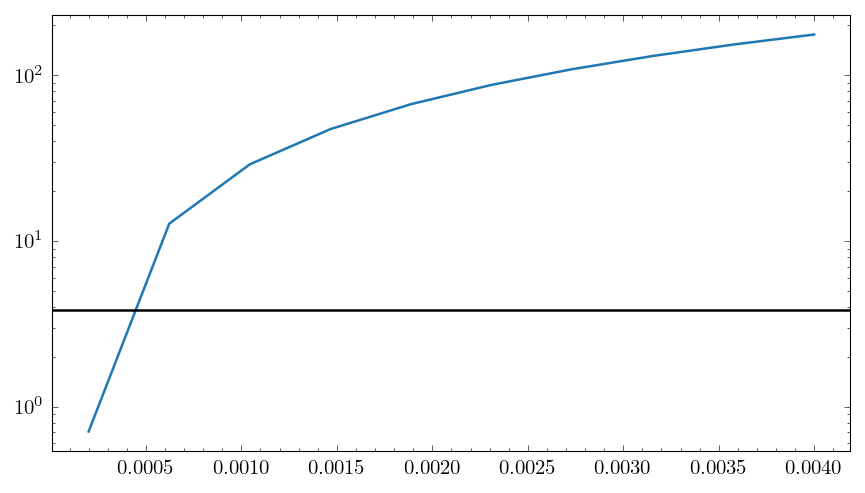

		determining the upper limit
		--->0.0003386973622746427

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.834821126763454e-17
		--->'mle_theta_er': 1.0028990659131662
		--->'mle_theta_nr': 1.0733488226780146
		defining the test statistic
		determining the upper limit
		--->0.0005743865618918052

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.921694114881715e-17
		--->'mle_theta_er': 1.0056230156823251
		--->'mle_theta_nr': 1.1307410495606751
		defining the test statistic
		determining the upper limit
		--->0.0007645241574033147

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 8.719776398957942e-17
		--->'mle_theta_er': 1.0029178316636873
		--->'mle_theta_nr': 1.0658852364351996
		defining the test statistic
		test statistic plot


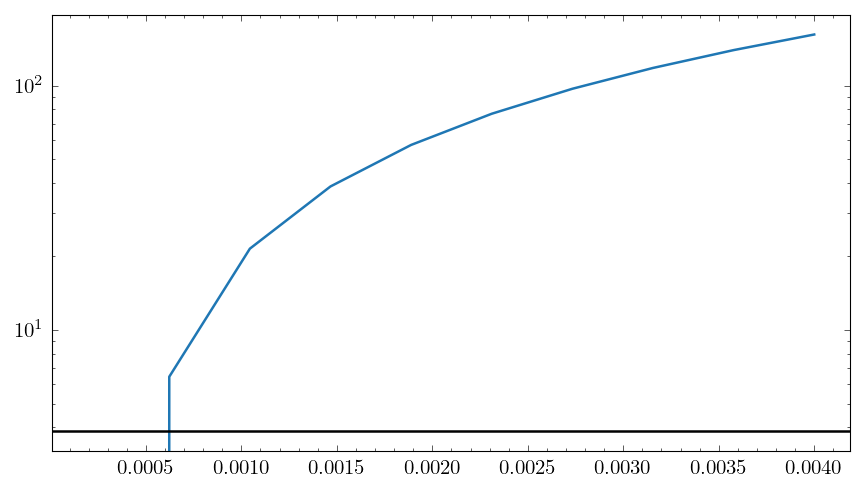

		determining the upper limit
		--->0.0005390658585268542

		a priori calculations
		defining the 'log_likelihood_function'
		minimizing -1*'log_likelihood_function'
		--->'mle_sigma': 9.948596448400226e-17
		--->'mle_theta_er': 1.0064713051544132
		--->'mle_theta_nr': 1.0656067279070642
		defining the test statistic
		determining the upper limit


In [ ]:


if [False,True][1]:


    wimp_parameter_exclusion_curve_dict = sfs.calculate_wimp_parameter_exclusion_curve(
        # physical detector parameters
        detector__drift_field_v_cm                                       = darwin_baseline_detector_drift_field_v_cm,
        detector__nest_parameter_dict                                    = darwin_baseline_detector_dict,
        detector__runtime_y                                              = darwin_baseline_detector_runtime_y,
        detector__fiducial_mass_t                                        = darwin_baseline_detector_fiducial_mass_t,
        detector__detector_name                                          = "darwin_baseline_detector_sensitest",
        # physical spectrum parameters
        spectrum__default_spectrum_profiles                              = sfs.spectrum_dict_default_dict,
        spectrum__resources                                              = abspath_resources,
        spectrum__er_background_model                                    = "combined_er_background",
        spectrum__nr_background_model                                    = "combined_nr_background",
        spectrum__wimp_model                                             = "nr_wimps_wimprates",
        # simulation setting
        simulation__er_spectrum_energy_simulation_window_kev             = default_recoil_energy_simulation_window_er,
        simulation__nr_spectrum_energy_simulation_window_kev             = default_recoil_energy_simulation_window_nr,
        simulation__number_of_spectrum_energy_bins                       = default_simulation_energy_bins,
        simulation__number_of_upper_limit_simulations_per_wimp_mass      = 200, # 500
        simulation__number_of_pdf_calculation_events                     = 400000, # 4000000
        simulation__number_of_samples_for_expectation_value_computation  = 200,
        # limit calculation parameters
        limit__er_eroi_kev                                               = default_wimp_eroi_kev_ee,
        limit__nr_eroi_kev                                               = default_wimp_eroi_kev_nr,
        limit__wimp_mass_gev_list                                        = list(np.geomspace(start=10, stop=1000, num=20, endpoint=True)),
#        limit__wimp_mass_gev_list                                        = [10, 300],
        limit__number_of_cs1_bins                                        = 25, #40,
        limit__number_of_cs2_bins                                        = 25, #40,
        limit__cl                                                        = 0.9,
        # flags
        flag_verbose                                                     = [False, True, "high-level-only"][2],
        flag_plot_pdfs                                                   = [False, True, "er_nr_only"][1],
        flag_plot_test_statistics                                        = [False, True, 0.1][2],
        flag_plot_upper_limit_root_finding                               = [False, True, 0.1][2],
        flag_plot_upper_limit_distribution                               = [False, True, 0.1][1],
        flag_load_er_and_nr_signatures_for_pdf_calculation               = [False,True][0],
    )

    datestring = datetime.datetime.now().strftime("%Y%m%d_%H%M")
    sfs.write_dict_to_json("/home/daniel/Desktop/arbeitsstuff/sfs/test_sensi_curve_dict" +"__" +datestring +".json", wimp_parameter_exclusion_curve_dict)

    # printing test output
    #print(f"\n\ntest output:")
    #print(f"\n'cs1_bin_edges': {wimp_parameter_exclusion_curve_dict['spectrum_components']['cs1_bin_edges']}")
    #print(f"\n'cs2_bin_edges': {wimp_parameter_exclusion_curve_dict['spectrum_components']['cs2_bin_edges']}")
    #for spectrum_string in ["er_background", "nr_background", "wimps"]:
    #    print(f"\n{spectrum_string}")
    #    print(f"'spectral_pdf': {wimp_parameter_exclusion_curve_dict['spectrum_components'][spectrum_string]['spectral_pdf']}")
    #    print(f"'number_of_expected_events_within_eroi': {wimp_parameter_exclusion_curve_dict['spectrum_components'][spectrum_string]['number_of_expected_events_within_eroi']}")



With 20 WIMP masses and 'sims_per_wimp_mass'=200 the code above took ~11.5h to run.


In [18]:


if [False,True][0]:

    #wimp_parameter_exclusion_curve_dict_loaded = sfs.get_dict_from_json("/home/daniel/Desktop/arbeitsstuff/sfs/test_sensi_curve_dict" +"__" +datestring +".json")
    wimp_parameter_exclusion_curve_dict_loaded = sfs.get_dict_from_json("/home/daniel/Desktop/arbeitsstuff/sfs/test_sensi_curve_dict__20230424_0507.json") # 6:38h


    sfs.plot_sensitivity_curve_comparison(
        sensitivity_curve_dict_list   = [wimp_parameter_exclusion_curve_dict_loaded],
        flag_comp_values              = [],#np.geomspace(start=2.3, stop=4.7, num=4, endpoint=True),
        cbar_label                    = r"drift field strength, $E_{\mathrm{drift}}$ / $\mathrm{\frac{V}{cm}}$",
        legend_colors                 = ["red"],
        plot_logxscale                = True,
        plot_logyscale                = True,
        output_abspath_list           = [path+ "test__plot_sensitivity_curve_comparison.png" for path in abspath_list_plots],
    )




<br>
<br>


# Study: Test NEST Output for Repetitions


<br>
<br>



In [19]:

if [False,True][0]:
    
    
    # definitions
    test_seed_default = 1
    energy_list = [1.0, 2.0, 3.0, 5.0, 10.0, 15.0, 20.0, 30.0, 40.0]
    n_test_datasets = len(energy_list)
    number_of_events_per_energy = 1000
    test_seed_random_list = [randrange(10000001) for k in range(n_test_datasets)]
    
    # running NEST
    print(f"running NEST")
    if [False,True][1]:
        nest_test_data_list = []
        for k in range(n_test_datasets):
            seed = randrange(10000001)
#            nest_test_spectrum_dict = {
#                    "seed": test_seed_random_list[k],
#                    "field_drift[V/cm]": "200",
#                    "x,y,z-position[mm]": "-1",
#                    "numEvts": [number_of_events_per_energy for j in range(len(energy_list))],
#                    "type_interaction": "ER",
#                    "E_min[keV]": energy_list,
#                    "E_max[keV]": energy_list,
#                }
            nest_test_spectrum_dict = {
                    "seed": seed,
                    "field_drift[V/cm]": "200",
                    "x,y,z-position[mm]": "-1",
                    "numEvts": [number_of_events_per_energy],
                    "type_interaction": "ER",
                    "E_min[keV]": [energy_list[k]],
                    "E_max[keV]": [energy_list[k]],
                }
            print(f"\tNEST run {k} of {n_test_datasets-1}")
            print(f"\t\trandom seed: {seed}")
            nest_test_ndarray = sfs.execNEST(
                spectrum_dict = nest_test_spectrum_dict,
                baseline_detector_dict = darwin_baseline_detector_dict,
                baseline_drift_field_v_cm = darwin_baseline_detector_drift_field_v_cm,
                detector_dict = darwin_baseline_detector_dict,
                detector_name = "example__detector__darwin_baseline_detector",
                abspath_list_detector_dict_json_output = [abspath_detectors],
                flag_verbose = False,
                flag_print_stdout_and_stderr = False,)
            nest_test_data_list.append(nest_test_ndarray)

    
    # test 1: does the output contain duplicates
    print(f"test 1: does the output contain duplicates")
    for k, nest_test_ndarray in enumerate(nest_test_data_list):
        print(f"\texamining dataset {k} of {n_test_datasets-1} individually")
        for column in ["S1 [PE or phe]", "S2_3Dcorr [phd]"]:
            length_list = len(list(nest_test_ndarray[column]))
            length_set = len(set(list(nest_test_ndarray[column])))
            print(f"\t\t'column': {column}")
            print(f"\t\t'length_list': {length_list}")
            print(f"\t\t'length_set': {length_set}")
    print(f"\tcomparing all datasets against each other")
    for column in ["S1 [PE or phe]", "S2_3Dcorr [phd]"]:
        combined_data_list = [list(nest_test_ndarray[column]) for k, nest_test_ndarray in enumerate(nest_test_data_list)]
        combined_data_list = sum(combined_data_list, [])
        combined_data_set = set(combined_data_list)
        print(f"\t\t'column': {column}")
        print(f"\t\t'length_list': {len(combined_data_list)}")
        print(f"\t\t'length_set': {len(combined_data_set)}")
            
        
    
    
    
    


<br>
<br>


# Study: How Does S2/S1 Change with Energy?


<br>
<br>



In [20]:


#test_ndarray = np.load(abspath_signatures +"example__signature__darwin_baseline_detector__er_background_medium_stat.npy")
#print(test_ndarray.dtype.names)
# NEST ndarray column names:
# 'E_truth [keV]'
# 'field [V/cm]'
# 'tDrift [us]'
# 'X,Y,Z [mm]'
# 'Nph'
# 'Ne-'
# 'S1 [PE or phe]'
# 'S1_3Dcor [phd]'
# 'spikeC(NON-INT)'
# 'Ne-Extr'
# 'S2_rawArea [PE]'
# 'S2_3Dcorr [phd]'
abspath_test = abspath_study +"test/"

if [False,True][0]:
    import matplotlib.gridspec as gridspec


    # definitions
    print(f"definitions")
    test_seed_default = 1
    e_drift_v_cm = 10
    energy_list_kev = np.linspace(start=5.0, stop=100, num=20, endpoint=True)
    print(f"'energy_list_kev' = {energy_list_kev}")
    #energy_list_kev = [5.0, 15.0, 40.0]
    number_of_events_per_energy = 1000
    nest_data_sets = []


    # data generation
    print(f"data generation")
    for it in ["ER", "NR"]:
        for i, e_kev in enumerate(energy_list_kev):
            run_id = f"{it}__{str(int(e_kev))}"
            print(f"\trun_id: {run_id}")
            # defining spectra dicts
            print(f"\t\tdefining spectrum dict")
            nest_spectrum_dict = {
                "seed": test_seed_default,
                "field_drift[V/cm]": str(e_drift_v_cm),
                "x,y,z-position[mm]": "-1",
                "numEvts": [number_of_events_per_energy],
                "type_interaction": it,
                "E_min[keV]": [e_kev],
                "E_max[keV]": [e_kev],
            }
            # running NEST
            if [False,True][0]:
                print(f"\t\trunning NEST")
                nest_ndarray = sfs.execNEST(
                    spectrum_dict = nest_spectrum_dict,
                    baseline_detector_dict = darwin_baseline_detector_dict,
                    baseline_drift_field_v_cm = e_drift_v_cm,
                    detector_dict = darwin_baseline_detector_dict,
                    detector_name = "example__detector__darwin_baseline_detector",
                    abspath_list_detector_dict_json_output = [abspath_detectors],
                    flag_verbose = False,
                    flag_print_stdout_and_stderr = False,)
                print(f"\t\tsaving NEST data")
                np.save(abspath_test +run_id +".npy", nest_ndarray)
                print(f"\t\tsaved '{abspath_test +run_id +'.npy'}'")
            else:
                print(f"\t\tnot running NEST")
            nest_data_sets.append(run_id)
            # saving NEST data


    # data generation
    print(f"plotting")
    # setting up canvas and axes
    print(f"\tsetting up canvas and axes")
    fig = plt.figure(figsize=[5.670, 5.670*9/16], constrained_layout=False, dpi=150)
    spec = gridspec.GridSpec(
        ncols = 3,
        nrows = 3,
        figure = fig,
        top = 1.0,
        bottom = 0.0,
        left = 0.0,
        right = 1.0,
        wspace = 0.0,
        hspace = 0.0,
        width_ratios = [0.10, 0.88, 0.02],
        height_ratios = [0.005, 0.875, 0.12],)
    ax = fig.add_subplot(spec[1, 1])
    ax.set_xlabel(r"recoil energy, $E\,/\,\mathrm{keV}$", labelpad=2)
    ax.set_ylabel(r"charge-to-light ratio, $\frac{S_2}{S_1}\,/\,\%$", labelpad=2)
    # plotting
    print(f"\tplotting")
    for run_id in [*nest_data_sets]:
        nest_dataset = np.load(abspath_test +run_id +".npy")
        print(f"\t\tdata generation")
        it = str(list(run_id.split("__"))[0])
        e_kev = float(list(run_id.split("__"))[1])
        plot_data_y = [event['Ne-']/event['Nph'] for j, event in enumerate(nest_dataset)]
        plto_data_y_err = [np.std(plot_data_y)]
        plot_data_y = [np.mean(plot_data_y)]
        plot_data_x = [e_kev for entry in plot_data_y]
        plot_data_x = [e_kev]
        print(f"\t\tinteraction type: {it}")
        print(f"\t\tenergy: {e_kev} keV")
        print(f"\t\tplot_data_y: {plot_data_y}")
        print(f"\t\tplot_data_x: {plot_data_x}")
        ax.errorbar(
            marker = "o",
            markersize = 3.8,
            markerfacecolor = "white",
            markeredgewidth = 0.5,
            markeredgecolor = "red" if it=="ER" else "blue",
            ecolor = "red" if it=="ER" else "blue",
            elinewidth = 0.5,
            capsize = 1.2,
            barsabove = True,
            capthick = 0.5,
            linestyle = "",
            fmt = '',
            x = plot_data_x,
            y = plot_data_y,
            yerr = plto_data_y_err,
        )
    plt.show()
        
    
    
    
    